In [1]:
from IPython.display import clear_output, display
from PIL import Image
from sklearn import metrics

import numpy as np
import time
import torch
import torchvision as tv

import gc

In [2]:
device = torch.device('cuda')
print(device)

cuda


In [3]:
arc = np.load('box_sphere.npz')

In [4]:
ds_raw = torch.from_numpy(arc['ds']).float()[:, :, :, :1].transpose(1, 3)
del arc

In [5]:
ds_norm = ds_raw / 255.0 - 0.5

In [6]:
ind = np.arange(ds_norm.shape[0])
np.random.shuffle(ind)

In [7]:
train_part = 0.8
ind_thr = int(ind.shape[0]*train_part)
ind_train, ind_test = ind[:ind_thr], ind[ind_thr:]

In [8]:
label = torch.from_numpy(np.arange(ds_norm.shape[0]) % 2)

In [9]:
pt_train_ds, pt_train_lbl = ds_norm[ind_train], label[ind_train]
pt_test_ds, pt_test_lbl = ds_norm[ind_test], label[ind_test]

In [10]:
pt_train_ds, pt_train_lbl = pt_train_ds.to(device), pt_train_lbl.to(device)
pt_test_ds, pt_test_lbl = pt_test_ds.to(device), pt_test_lbl.to(device)

In [11]:
class Descriminate(torch.nn.Module):
    def __init__(self):
        super(Descriminate, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 9, 5)
        self.mp1 = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(9, 18, 5)
        self.mp2 = torch.nn.MaxPool2d(2)
        self.conv3 = torch.nn.Conv2d(18, 36, 5)
        self.mp3 = torch.nn.MaxPool2d(2)
        self.lin1 = torch.nn.Linear(36 * 9 * 9, 100)
        self.lin2 = torch.nn.Linear(100, 20)
        self.lin3 = torch.nn.Linear(20, 2)

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = self.mp1(x)
        x = torch.nn.functional.relu(self.conv2(x))
        x = self.mp2(x)
        x = torch.nn.functional.relu(self.conv3(x))
        x = self.mp3(x)
        x = x.view(-1, 36 * 9 * 9)
        x = torch.nn.functional.relu(self.lin1(x))
        x = torch.nn.functional.relu(self.lin2(x))
        x = torch.nn.functional.relu(self.lin3(x))
        return x

In [12]:
# m(pt_train_ds[:1]).shape

In [38]:
m = Descriminate().to(device)
crit = torch.nn.CrossEntropyLoss()

In [43]:
optim = torch.optim.SGD(m.parameters(), lr=1e-4, momentum=0.9)

In [44]:
pt_train_ds.shape, pt_train_lbl.shape

(torch.Size([576, 1, 100, 100]), torch.Size([576]))

In [56]:
def mpp(msg, a):
    return msg + ' '.join('{:.04f}'.format(t) for t in a)

In [58]:
try:
    meter = 1
    while(True):
        random_sample_ind = torch.randperm(pt_train_ds.shape[0])[:int(pt_train_ds.shape[0]*0.2)]
        sampled_ds = pt_train_ds[random_sample_ind]
        sampled_lbl = pt_train_lbl[random_sample_ind]
        for _ in range(meter):
            optim.zero_grad()        
            estim = m(sampled_ds)
            loss = crit(estim, sampled_lbl)
            loss.backward()
            optim.step()

        if meter < 100:
            meter += 5

        model_cube_train_score = m(pt_train_ds).cpu().detach().numpy()[:, 0]
        model_cube_test_score = m(pt_test_ds).cpu().detach().numpy()[:, 0]
        model_sphere_train_score = m(pt_train_ds).cpu().detach().numpy()[:, 1]
        model_sphere_test_score = m(pt_test_ds).cpu().detach().numpy()[:, 1]
        to_show = (float(loss), 
                   metrics.roc_auc_score(pt_train_lbl, model_cube_train_score),
                   metrics.roc_auc_score(pt_test_lbl, model_cube_test_score),
                   metrics.roc_auc_score(pt_train_lbl, model_sphere_train_score),
                   metrics.roc_auc_score(pt_test_lbl, model_sphere_test_score),
                   mpp('cube_train_scores   :', model_cube_train_score[:15]),
                   mpp('sphere_train_scores :', model_sphere_train_score[:15]),
                   mpp('labels              :', pt_train_lbl[:15]),
                  )
        # clear_output()
        display(to_show)
except KeyboardInterrupt as ki:
    print("iterations stopped!")

(0.6846036911010742,
 0.386081902373143,
 0.43421052631578944,
 0.8866124831178854,
 0.8726780185758514,
 'cube_train_scores   :0.0277 0.0274 0.0274 0.0273 0.0276 0.0275 0.0280 0.0279 0.0278 0.0279 0.0272 0.0277 0.0275 0.0278 0.0276',
 'sphere_train_scores :0.0856 0.0850 0.0851 0.0850 0.0859 0.0853 0.0862 0.0853 0.0861 0.0854 0.0853 0.0852 0.0853 0.0853 0.0853',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6936715245246887,
 0.3868536561836774,
 0.4336300309597523,
 0.8911103607949065,
 0.8761609907120742,
 'cube_train_scores   :0.0277 0.0273 0.0274 0.0272 0.0275 0.0274 0.0279 0.0278 0.0277 0.0278 0.0271 0.0277 0.0274 0.0277 0.0275',
 'sphere_train_scores :0.0857 0.0851 0.0852 0.0851 0.0860 0.0854 0.0863 0.0854 0.0862 0.0855 0.0854 0.0853 0.0854 0.0854 0.0854',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6956717371940613,
 0.3875289407678951,
 0.43324303405572756,
 0.8978089426972795,
 0.8811919504643962,
 'cube_train_scores   :0.0279 0.0275 0.0276 0.0274 0.0277 0.0277 0.0281 0.0280 0.0280 0.0281 0.0274 0.0279 0.0277 0.0279 0.0277',
 'sphere_train_scores :0.0855 0.0849 0.0850 0.0849 0.0857 0.0851 0.0860 0.0852 0.0860 0.0853 0.0851 0.0851 0.0851 0.0852 0.0851',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6911446452140808,
 0.3885539262975111,
 0.4327592879256966,
 0.9076789504148177,
 0.8889318885448917,
 'cube_train_scores   :0.0279 0.0276 0.0276 0.0275 0.0278 0.0277 0.0282 0.0281 0.0280 0.0281 0.0274 0.0279 0.0277 0.0280 0.0278',
 'sphere_train_scores :0.0854 0.0848 0.0849 0.0848 0.0857 0.0851 0.0860 0.0851 0.0859 0.0852 0.0851 0.0850 0.0851 0.0851 0.0851',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6941353678703308,
 0.3891930349218599,
 0.432469040247678,
 0.9190502604669111,
 0.8966718266253869,
 'cube_train_scores   :0.0282 0.0278 0.0279 0.0277 0.0280 0.0280 0.0284 0.0283 0.0283 0.0284 0.0277 0.0282 0.0280 0.0282 0.0280',
 'sphere_train_scores :0.0852 0.0846 0.0847 0.0846 0.0855 0.0848 0.0857 0.0848 0.0857 0.0849 0.0848 0.0848 0.0848 0.0848 0.0848',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.694089412689209,
 0.38865039552382796,
 0.43053405572755415,
 0.9309280339571677,
 0.9078947368421051,
 'cube_train_scores   :0.0289 0.0285 0.0286 0.0284 0.0287 0.0287 0.0291 0.0290 0.0290 0.0290 0.0284 0.0289 0.0287 0.0289 0.0287',
 'sphere_train_scores :0.0844 0.0838 0.0839 0.0838 0.0847 0.0840 0.0850 0.0841 0.0850 0.0842 0.0841 0.0840 0.0840 0.0841 0.0840',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6869513988494873,
 0.3902903723712136,
 0.4320820433436532,
 0.9447351919737604,
 0.9189241486068112,
 'cube_train_scores   :0.0270 0.0266 0.0267 0.0265 0.0268 0.0268 0.0272 0.0271 0.0271 0.0271 0.0265 0.0270 0.0268 0.0270 0.0268',
 'sphere_train_scores :0.0866 0.0860 0.0861 0.0860 0.0870 0.0862 0.0872 0.0862 0.0872 0.0863 0.0863 0.0862 0.0862 0.0863 0.0862',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6946884989738464,
 0.3901215512251592,
 0.4311145510835913,
 0.9567275226702682,
 0.931888544891641,
 'cube_train_scores   :0.0272 0.0268 0.0269 0.0268 0.0271 0.0270 0.0274 0.0274 0.0273 0.0274 0.0267 0.0272 0.0270 0.0273 0.0271',
 'sphere_train_scores :0.0864 0.0858 0.0859 0.0858 0.0868 0.0860 0.0870 0.0860 0.0870 0.0861 0.0860 0.0859 0.0860 0.0860 0.0860',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6935932040214539,
 0.39123094732780245,
 0.4280185758513932,
 0.9685148562608529,
 0.9444659442724458,
 'cube_train_scores   :0.0282 0.0278 0.0279 0.0277 0.0280 0.0279 0.0284 0.0283 0.0283 0.0283 0.0277 0.0282 0.0279 0.0282 0.0280',
 'sphere_train_scores :0.0854 0.0847 0.0848 0.0847 0.0858 0.0849 0.0860 0.0850 0.0860 0.0851 0.0850 0.0849 0.0850 0.0850 0.0849',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6920918822288513,
 0.39358238471927454,
 0.42782507739938086,
 0.9788611807833301,
 0.9520123839009288,
 'cube_train_scores   :0.0281 0.0277 0.0278 0.0276 0.0279 0.0279 0.0283 0.0282 0.0282 0.0282 0.0276 0.0281 0.0278 0.0281 0.0279',
 'sphere_train_scores :0.0855 0.0849 0.0850 0.0849 0.0860 0.0851 0.0862 0.0851 0.0862 0.0852 0.0852 0.0850 0.0851 0.0851 0.0851',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.691568911075592,
 0.3966874879413468,
 0.4309210526315789,
 0.9865787188886745,
 0.9647832817337461,
 'cube_train_scores   :0.0274 0.0270 0.0270 0.0269 0.0272 0.0271 0.0276 0.0275 0.0275 0.0275 0.0268 0.0273 0.0271 0.0274 0.0272',
 'sphere_train_scores :0.0864 0.0857 0.0858 0.0857 0.0869 0.0860 0.0871 0.0860 0.0872 0.0861 0.0860 0.0859 0.0860 0.0860 0.0860',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.690952718257904,
 0.40058846228053246,
 0.43188854489164086,
 0.9924151070808412,
 0.9754256965944272,
 'cube_train_scores   :0.0261 0.0257 0.0258 0.0256 0.0259 0.0259 0.0263 0.0262 0.0263 0.0262 0.0256 0.0261 0.0258 0.0261 0.0259',
 'sphere_train_scores :0.0879 0.0872 0.0873 0.0872 0.0885 0.0874 0.0887 0.0875 0.0887 0.0876 0.0875 0.0874 0.0875 0.0875 0.0874',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.696747899055481,
 0.3992620104186765,
 0.4291795665634675,
 0.9961171136407486,
 0.9856811145510836,
 'cube_train_scores   :0.0301 0.0297 0.0298 0.0296 0.0299 0.0299 0.0303 0.0302 0.0303 0.0302 0.0296 0.0301 0.0299 0.0301 0.0299',
 'sphere_train_scores :0.0833 0.0827 0.0828 0.0827 0.0840 0.0829 0.0842 0.0829 0.0842 0.0830 0.0830 0.0828 0.0829 0.0829 0.0829',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.692543625831604,
 0.4050622226509743,
 0.4340170278637771,
 0.9977329731815551,
 0.9938080495356038,
 'cube_train_scores   :0.0308 0.0304 0.0305 0.0303 0.0307 0.0306 0.0311 0.0310 0.0310 0.0310 0.0303 0.0308 0.0306 0.0309 0.0307',
 'sphere_train_scores :0.0825 0.0819 0.0820 0.0819 0.0832 0.0821 0.0834 0.0821 0.0835 0.0822 0.0822 0.0820 0.0821 0.0821 0.0821',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6915695667266846,
 0.4106092031641906,
 0.442530959752322,
 0.9989267798572256,
 0.9984520123839009,
 'cube_train_scores   :0.0298 0.0294 0.0295 0.0293 0.0296 0.0295 0.0300 0.0299 0.0299 0.0299 0.0292 0.0298 0.0295 0.0298 0.0296',
 'sphere_train_scores :0.0838 0.0831 0.0832 0.0832 0.0846 0.0834 0.0848 0.0834 0.0848 0.0835 0.0834 0.0833 0.0834 0.0834 0.0834',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6925058364868164,
 0.4148779664287092,
 0.4485294117647059,
 0.9999155894269728,
 1.0,
 'cube_train_scores   :0.0297 0.0293 0.0294 0.0292 0.0295 0.0295 0.0299 0.0298 0.0299 0.0298 0.0291 0.0297 0.0294 0.0297 0.0295',
 'sphere_train_scores :0.0840 0.0833 0.0834 0.0833 0.0848 0.0835 0.0850 0.0835 0.0850 0.0836 0.0836 0.0835 0.0835 0.0836 0.0835',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6952510476112366,
 0.4171088172872854,
 0.4516253869969041,
 1.0,
 1.0,
 'cube_train_scores   :0.0341 0.0337 0.0338 0.0336 0.0339 0.0339 0.0344 0.0342 0.0343 0.0342 0.0336 0.0341 0.0338 0.0341 0.0339',
 'sphere_train_scores :0.0789 0.0782 0.0784 0.0783 0.0798 0.0785 0.0800 0.0785 0.0800 0.0786 0.0786 0.0784 0.0785 0.0785 0.0785',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6928519606590271,
 0.4214740497781208,
 0.45684984520123845,
 1.0,
 1.0,
 'cube_train_scores   :0.0352 0.0347 0.0349 0.0347 0.0350 0.0350 0.0354 0.0353 0.0354 0.0353 0.0346 0.0352 0.0349 0.0352 0.0350',
 'sphere_train_scores :0.0777 0.0771 0.0772 0.0771 0.0787 0.0773 0.0789 0.0773 0.0789 0.0774 0.0774 0.0773 0.0773 0.0773 0.0773',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6928186416625977,
 0.4262492764808026,
 0.4618808049535603,
 1.0,
 1.0,
 'cube_train_scores   :0.0357 0.0353 0.0354 0.0353 0.0356 0.0355 0.0360 0.0359 0.0360 0.0359 0.0352 0.0358 0.0355 0.0358 0.0356',
 'sphere_train_scores :0.0771 0.0764 0.0765 0.0765 0.0782 0.0767 0.0783 0.0767 0.0784 0.0768 0.0767 0.0766 0.0767 0.0767 0.0767',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6934270858764648,
 0.4311209724098013,
 0.4680727554179567,
 1.0,
 1.0,
 'cube_train_scores   :0.0378 0.0374 0.0375 0.0373 0.0377 0.0376 0.0381 0.0380 0.0381 0.0380 0.0373 0.0379 0.0376 0.0379 0.0377',
 'sphere_train_scores :0.0748 0.0741 0.0742 0.0741 0.0759 0.0743 0.0761 0.0743 0.0761 0.0744 0.0744 0.0743 0.0743 0.0744 0.0743',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6916945576667786,
 0.4376085278796064,
 0.4769736842105263,
 1.0,
 1.0,
 'cube_train_scores   :0.0361 0.0357 0.0358 0.0356 0.0360 0.0359 0.0364 0.0363 0.0364 0.0363 0.0356 0.0361 0.0359 0.0362 0.0360',
 'sphere_train_scores :0.0768 0.0761 0.0762 0.0762 0.0781 0.0763 0.0782 0.0763 0.0782 0.0765 0.0764 0.0763 0.0764 0.0764 0.0763',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6872544884681702,
 0.44588076403627247,
 0.485874613003096,
 1.0,
 1.0,
 'cube_train_scores   :0.0278 0.0273 0.0275 0.0273 0.0277 0.0276 0.0281 0.0279 0.0280 0.0279 0.0272 0.0278 0.0275 0.0278 0.0276',
 'sphere_train_scores :0.0865 0.0858 0.0859 0.0858 0.0879 0.0860 0.0880 0.0860 0.0880 0.0861 0.0861 0.0859 0.0860 0.0860 0.0859',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6918281316757202,
 0.4516809762685703,
 0.4928405572755417,
 1.0,
 1.0,
 'cube_train_scores   :0.0264 0.0260 0.0261 0.0259 0.0263 0.0262 0.0267 0.0265 0.0267 0.0266 0.0259 0.0264 0.0261 0.0265 0.0263',
 'sphere_train_scores :0.0881 0.0874 0.0875 0.0874 0.0896 0.0876 0.0897 0.0876 0.0897 0.0877 0.0877 0.0875 0.0876 0.0876 0.0876',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6957273483276367,
 0.4532486011962184,
 0.4955495356037152,
 1.0,
 1.0,
 'cube_train_scores   :0.0330 0.0325 0.0326 0.0324 0.0328 0.0327 0.0333 0.0331 0.0332 0.0331 0.0324 0.0330 0.0327 0.0330 0.0328',
 'sphere_train_scores :0.0806 0.0799 0.0800 0.0800 0.0822 0.0801 0.0823 0.0801 0.0823 0.0803 0.0802 0.0801 0.0802 0.0802 0.0801',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6893213391304016,
 0.45836147019100903,
 0.5050309597523219,
 1.0,
 1.0,
 'cube_train_scores   :0.0287 0.0282 0.0284 0.0282 0.0286 0.0285 0.0290 0.0288 0.0290 0.0289 0.0281 0.0287 0.0284 0.0288 0.0286',
 'sphere_train_scores :0.0856 0.0848 0.0849 0.0849 0.0873 0.0850 0.0873 0.0850 0.0873 0.0852 0.0852 0.0850 0.0851 0.0851 0.0850',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6894251108169556,
 0.4628834651746093,
 0.511609907120743,
 1.0,
 1.0,
 'cube_train_scores   :0.0244 0.0240 0.0241 0.0239 0.0243 0.0242 0.0248 0.0245 0.0247 0.0246 0.0238 0.0245 0.0241 0.0245 0.0243',
 'sphere_train_scores :0.0906 0.0898 0.0899 0.0899 0.0924 0.0900 0.0924 0.0900 0.0924 0.0902 0.0902 0.0900 0.0901 0.0901 0.0900',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6933935880661011,
 0.4662719467489871,
 0.5156733746130031,
 1.0,
 1.0,
 'cube_train_scores   :0.0260 0.0255 0.0257 0.0255 0.0259 0.0258 0.0263 0.0261 0.0263 0.0262 0.0254 0.0260 0.0257 0.0261 0.0258',
 'sphere_train_scores :0.0888 0.0880 0.0881 0.0881 0.0907 0.0882 0.0907 0.0882 0.0907 0.0884 0.0884 0.0882 0.0883 0.0883 0.0882',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6892123222351074,
 0.4689972023924368,
 0.520704334365325,
 1.0,
 1.0,
 'cube_train_scores   :0.0225 0.0220 0.0221 0.0220 0.0224 0.0222 0.0228 0.0226 0.0227 0.0226 0.0219 0.0225 0.0222 0.0225 0.0223',
 'sphere_train_scores :0.0929 0.0921 0.0922 0.0922 0.0949 0.0923 0.0949 0.0923 0.0950 0.0925 0.0925 0.0923 0.0924 0.0924 0.0923',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6909826993942261,
 0.47198171908161296,
 0.525735294117647,
 1.0,
 1.0,
 'cube_train_scores   :0.0210 0.0205 0.0206 0.0205 0.0209 0.0208 0.0213 0.0211 0.0213 0.0211 0.0204 0.0210 0.0207 0.0211 0.0208',
 'sphere_train_scores :0.0947 0.0939 0.0940 0.0940 0.0968 0.0941 0.0968 0.0940 0.0968 0.0943 0.0943 0.0941 0.0941 0.0942 0.0941',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6945449709892273,
 0.47546064055566273,
 0.5297987616099071,
 1.0,
 1.0,
 'cube_train_scores   :0.0246 0.0241 0.0242 0.0241 0.0245 0.0243 0.0249 0.0247 0.0249 0.0247 0.0240 0.0246 0.0243 0.0247 0.0244',
 'sphere_train_scores :0.0906 0.0898 0.0899 0.0899 0.0928 0.0900 0.0928 0.0900 0.0928 0.0902 0.0902 0.0900 0.0901 0.0901 0.0900',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6946567893028259,
 0.4786923596372757,
 0.5334752321981424,
 1.0,
 1.0,
 'cube_train_scores   :0.0292 0.0287 0.0289 0.0287 0.0291 0.0290 0.0296 0.0293 0.0295 0.0294 0.0286 0.0293 0.0289 0.0293 0.0291',
 'sphere_train_scores :0.0853 0.0845 0.0846 0.0846 0.0876 0.0847 0.0876 0.0847 0.0876 0.0849 0.0849 0.0847 0.0847 0.0848 0.0847',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6938621401786804,
 0.4825209820567239,
 0.5373452012383901,
 1.0,
 1.0,
 'cube_train_scores   :0.0329 0.0324 0.0325 0.0324 0.0328 0.0327 0.0333 0.0330 0.0332 0.0331 0.0323 0.0330 0.0326 0.0330 0.0327',
 'sphere_train_scores :0.0811 0.0803 0.0804 0.0804 0.0835 0.0805 0.0835 0.0805 0.0835 0.0807 0.0807 0.0805 0.0805 0.0806 0.0805',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6907168626785278,
 0.48460109974918003,
 0.5414086687306501,
 1.0,
 1.0,
 'cube_train_scores   :0.0308 0.0302 0.0304 0.0302 0.0307 0.0305 0.0311 0.0309 0.0310 0.0309 0.0301 0.0308 0.0304 0.0308 0.0306',
 'sphere_train_scores :0.0837 0.0828 0.0829 0.0829 0.0862 0.0830 0.0861 0.0830 0.0861 0.0833 0.0832 0.0830 0.0831 0.0831 0.0830',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6959840655326843,
 0.4878207601775034,
 0.5437306501547987,
 1.0,
 1.0,
 'cube_train_scores   :0.0433 0.0428 0.0429 0.0427 0.0432 0.0430 0.0437 0.0434 0.0436 0.0435 0.0427 0.0433 0.0429 0.0434 0.0431',
 'sphere_train_scores :0.0693 0.0684 0.0685 0.0685 0.0719 0.0686 0.0718 0.0686 0.0718 0.0689 0.0688 0.0686 0.0687 0.0687 0.0686',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6913414597511292,
 0.4889904495465946,
 0.5454721362229102,
 1.0,
 1.0,
 'cube_train_scores   :0.0415 0.0410 0.0411 0.0410 0.0414 0.0413 0.0419 0.0416 0.0418 0.0417 0.0409 0.0416 0.0411 0.0416 0.0413',
 'sphere_train_scores :0.0714 0.0706 0.0706 0.0707 0.0741 0.0707 0.0740 0.0707 0.0740 0.0710 0.0709 0.0708 0.0708 0.0709 0.0707',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6932085156440735,
 0.4909198340729307,
 0.5472136222910217,
 1.0,
 1.0,
 'cube_train_scores   :0.0447 0.0442 0.0443 0.0442 0.0446 0.0445 0.0451 0.0448 0.0450 0.0449 0.0441 0.0448 0.0443 0.0448 0.0445',
 'sphere_train_scores :0.0678 0.0669 0.0670 0.0670 0.0706 0.0671 0.0705 0.0671 0.0705 0.0673 0.0673 0.0671 0.0671 0.0672 0.0671',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6918724775314331,
 0.49230657920123483,
 0.5499226006191951,
 1.0,
 1.0,
 'cube_train_scores   :0.0436 0.0431 0.0432 0.0430 0.0435 0.0434 0.0440 0.0437 0.0439 0.0438 0.0430 0.0437 0.0432 0.0437 0.0434',
 'sphere_train_scores :0.0691 0.0682 0.0683 0.0683 0.0720 0.0684 0.0719 0.0684 0.0719 0.0687 0.0686 0.0684 0.0685 0.0685 0.0684',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6928560137748718,
 0.49386214547559326,
 0.5514705882352942,
 1.0,
 1.0,
 'cube_train_scores   :0.0461 0.0455 0.0457 0.0455 0.0460 0.0458 0.0465 0.0462 0.0464 0.0462 0.0454 0.0461 0.0457 0.0461 0.0459',
 'sphere_train_scores :0.0663 0.0654 0.0655 0.0656 0.0694 0.0656 0.0692 0.0656 0.0692 0.0659 0.0658 0.0656 0.0657 0.0657 0.0656',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.692206084728241,
 0.4967803395716766,
 0.5526315789473684,
 1.0,
 1.0,
 'cube_train_scores   :0.0567 0.0562 0.0563 0.0562 0.0567 0.0565 0.0571 0.0568 0.0570 0.0569 0.0561 0.0568 0.0563 0.0568 0.0565',
 'sphere_train_scores :0.0541 0.0532 0.0532 0.0533 0.0572 0.0534 0.0570 0.0534 0.0570 0.0536 0.0536 0.0534 0.0534 0.0535 0.0534',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6922983527183533,
 0.49692504341115185,
 0.5530185758513932,
 1.0,
 1.0,
 'cube_train_scores   :0.0565 0.0559 0.0560 0.0559 0.0564 0.0562 0.0569 0.0566 0.0568 0.0566 0.0558 0.0565 0.0561 0.0565 0.0563',
 'sphere_train_scores :0.0545 0.0536 0.0536 0.0537 0.0577 0.0537 0.0575 0.0538 0.0575 0.0540 0.0540 0.0538 0.0538 0.0539 0.0537',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.692086398601532,
 0.49584579394173256,
 0.5528250773993808,
 1.0,
 1.0,
 'cube_train_scores   :0.0536 0.0530 0.0531 0.0530 0.0535 0.0533 0.0539 0.0537 0.0539 0.0537 0.0529 0.0536 0.0532 0.0536 0.0534',
 'sphere_train_scores :0.0579 0.0570 0.0570 0.0571 0.0613 0.0572 0.0611 0.0572 0.0611 0.0574 0.0574 0.0572 0.0572 0.0573 0.0571',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6922571659088135,
 0.4957553540420605,
 0.552438080495356,
 1.0,
 1.0,
 'cube_train_scores   :0.0554 0.0548 0.0550 0.0549 0.0553 0.0552 0.0558 0.0555 0.0557 0.0556 0.0548 0.0555 0.0550 0.0555 0.0552',
 'sphere_train_scores :0.0558 0.0549 0.0549 0.0550 0.0593 0.0551 0.0591 0.0551 0.0591 0.0553 0.0553 0.0551 0.0551 0.0552 0.0550',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6921504735946655,
 0.4947062512058653,
 0.5510835913312694,
 1.0,
 1.0,
 'cube_train_scores   :0.0545 0.0539 0.0541 0.0539 0.0544 0.0542 0.0549 0.0546 0.0548 0.0546 0.0538 0.0545 0.0541 0.0545 0.0543',
 'sphere_train_scores :0.0570 0.0561 0.0561 0.0562 0.0606 0.0562 0.0604 0.0562 0.0604 0.0565 0.0565 0.0562 0.0563 0.0564 0.0562',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6917895674705505,
 0.4950438934979742,
 0.5508900928792569,
 1.0,
 1.0,
 'cube_train_scores   :0.0596 0.0591 0.0592 0.0591 0.0595 0.0594 0.0600 0.0597 0.0599 0.0598 0.0590 0.0597 0.0593 0.0597 0.0594',
 'sphere_train_scores :0.0511 0.0501 0.0502 0.0503 0.0548 0.0503 0.0546 0.0503 0.0546 0.0506 0.0506 0.0503 0.0504 0.0504 0.0503',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6917738318443298,
 0.4941636118078333,
 0.5503095975232198,
 1.0,
 1.0,
 'cube_train_scores   :0.0627 0.0621 0.0623 0.0622 0.0626 0.0625 0.0631 0.0628 0.0630 0.0629 0.0621 0.0628 0.0624 0.0628 0.0626',
 'sphere_train_scores :0.0476 0.0466 0.0467 0.0467 0.0514 0.0468 0.0512 0.0468 0.0512 0.0471 0.0470 0.0468 0.0468 0.0469 0.0468',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6921815872192383,
 0.4925176056338028,
 0.548374613003096,
 1.0,
 1.0,
 'cube_train_scores   :0.0623 0.0617 0.0618 0.0617 0.0622 0.0620 0.0627 0.0624 0.0626 0.0624 0.0616 0.0623 0.0619 0.0623 0.0621',
 'sphere_train_scores :0.0482 0.0472 0.0473 0.0473 0.0521 0.0474 0.0519 0.0474 0.0519 0.0477 0.0476 0.0474 0.0475 0.0475 0.0474',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6913884878158569,
 0.49097409801273395,
 0.5472136222910217,
 1.0,
 1.0,
 'cube_train_scores   :0.0655 0.0649 0.0651 0.0649 0.0654 0.0652 0.0659 0.0656 0.0658 0.0656 0.0648 0.0656 0.0651 0.0656 0.0653',
 'sphere_train_scores :0.0445 0.0435 0.0436 0.0437 0.0486 0.0437 0.0483 0.0437 0.0483 0.0440 0.0439 0.0437 0.0438 0.0438 0.0437',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6908173561096191,
 0.49000940574956586,
 0.5450851393188855,
 1.0,
 1.0,
 'cube_train_scores   :0.0697 0.0691 0.0693 0.0692 0.0696 0.0694 0.0701 0.0698 0.0700 0.0699 0.0690 0.0698 0.0693 0.0698 0.0695',
 'sphere_train_scores :0.0396 0.0387 0.0387 0.0388 0.0438 0.0388 0.0436 0.0389 0.0435 0.0391 0.0391 0.0388 0.0389 0.0390 0.0388',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6908435225486755,
 0.4880317866100714,
 0.5424729102167183,
 1.0,
 1.0,
 'cube_train_scores   :0.0730 0.0724 0.0726 0.0724 0.0729 0.0727 0.0734 0.0731 0.0733 0.0732 0.0723 0.0731 0.0726 0.0731 0.0728',
 'sphere_train_scores :0.0359 0.0349 0.0350 0.0350 0.0402 0.0350 0.0399 0.0351 0.0399 0.0354 0.0353 0.0351 0.0351 0.0352 0.0350',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6927429437637329,
 0.4853487362531353,
 0.5381191950464397,
 1.0,
 1.0,
 'cube_train_scores   :0.0705 0.0699 0.0701 0.0699 0.0704 0.0702 0.0709 0.0706 0.0708 0.0706 0.0698 0.0706 0.0701 0.0706 0.0703',
 'sphere_train_scores :0.0389 0.0379 0.0380 0.0380 0.0434 0.0380 0.0430 0.0381 0.0430 0.0384 0.0383 0.0381 0.0382 0.0382 0.0380',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6923373937606812,
 0.48252701138336873,
 0.5346362229102166,
 1.0,
 1.0,
 'cube_train_scores   :0.0683 0.0678 0.0679 0.0678 0.0682 0.0681 0.0687 0.0685 0.0687 0.0685 0.0677 0.0684 0.0680 0.0684 0.0682',
 'sphere_train_scores :0.0414 0.0405 0.0405 0.0406 0.0461 0.0406 0.0457 0.0406 0.0457 0.0409 0.0409 0.0406 0.0407 0.0408 0.0406',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6925966739654541,
 0.4795726413274165,
 0.5296052631578947,
 1.0,
 1.0,
 'cube_train_scores   :0.0624 0.0619 0.0620 0.0619 0.0623 0.0622 0.0628 0.0626 0.0628 0.0626 0.0618 0.0625 0.0621 0.0625 0.0623',
 'sphere_train_scores :0.0484 0.0474 0.0474 0.0475 0.0532 0.0475 0.0528 0.0475 0.0528 0.0479 0.0479 0.0475 0.0477 0.0477 0.0475',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6917684674263,
 0.477022236156666,
 0.5263157894736843,
 1.0,
 1.0,
 'cube_train_scores   :0.0628 0.0623 0.0624 0.0623 0.0627 0.0626 0.0632 0.0630 0.0632 0.0630 0.0622 0.0629 0.0625 0.0629 0.0627',
 'sphere_train_scores :0.0480 0.0470 0.0470 0.0471 0.0529 0.0470 0.0525 0.0471 0.0525 0.0475 0.0474 0.0471 0.0472 0.0473 0.0470',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6916607022285461,
 0.4737663997684738,
 0.5236068111455109,
 1.0,
 1.0,
 'cube_train_scores   :0.0638 0.0633 0.0634 0.0633 0.0637 0.0636 0.0642 0.0640 0.0641 0.0640 0.0631 0.0639 0.0635 0.0639 0.0637',
 'sphere_train_scores :0.0469 0.0459 0.0459 0.0460 0.0519 0.0459 0.0516 0.0460 0.0515 0.0464 0.0463 0.0460 0.0461 0.0462 0.0459',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6920371055603027,
 0.4689610264325681,
 0.5187693498452013,
 1.0,
 1.0,
 'cube_train_scores   :0.0608 0.0602 0.0604 0.0602 0.0606 0.0605 0.0612 0.0609 0.0611 0.0609 0.0601 0.0609 0.0604 0.0609 0.0606',
 'sphere_train_scores :0.0505 0.0495 0.0495 0.0496 0.0557 0.0495 0.0553 0.0496 0.0553 0.0500 0.0499 0.0496 0.0497 0.0498 0.0495',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.691709578037262,
 0.4644993247154158,
 0.5137383900928792,
 1.0,
 1.0,
 'cube_train_scores   :0.0607 0.0601 0.0603 0.0601 0.0606 0.0605 0.0611 0.0609 0.0610 0.0609 0.0600 0.0608 0.0603 0.0608 0.0606',
 'sphere_train_scores :0.0506 0.0496 0.0496 0.0497 0.0560 0.0496 0.0556 0.0497 0.0556 0.0501 0.0500 0.0497 0.0498 0.0499 0.0496',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6917661428451538,
 0.45904881342851633,
 0.5071594427244581,
 1.0,
 1.0,
 'cube_train_scores   :0.0594 0.0588 0.0590 0.0588 0.0592 0.0591 0.0597 0.0595 0.0597 0.0595 0.0587 0.0595 0.0590 0.0595 0.0592',
 'sphere_train_scores :0.0523 0.0512 0.0512 0.0513 0.0578 0.0512 0.0574 0.0513 0.0574 0.0517 0.0517 0.0513 0.0515 0.0515 0.0512',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6916426420211792,
 0.45347771560872074,
 0.5007739938080495,
 1.0,
 1.0,
 'cube_train_scores   :0.0595 0.0590 0.0591 0.0590 0.0593 0.0593 0.0599 0.0597 0.0598 0.0597 0.0588 0.0596 0.0592 0.0596 0.0594',
 'sphere_train_scores :0.0521 0.0511 0.0510 0.0512 0.0578 0.0511 0.0574 0.0512 0.0573 0.0516 0.0515 0.0511 0.0513 0.0513 0.0511',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6909915208816528,
 0.4482080841211653,
 0.49458204334365324,
 1.0,
 1.0,
 'cube_train_scores   :0.0638 0.0632 0.0634 0.0632 0.0636 0.0636 0.0642 0.0640 0.0641 0.0640 0.0631 0.0639 0.0634 0.0639 0.0637',
 'sphere_train_scores :0.0471 0.0460 0.0460 0.0462 0.0530 0.0461 0.0525 0.0461 0.0524 0.0466 0.0465 0.0461 0.0463 0.0463 0.0460',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6907906532287598,
 0.4423234613158403,
 0.487422600619195,
 1.0,
 1.0,
 'cube_train_scores   :0.0675 0.0669 0.0671 0.0669 0.0673 0.0672 0.0678 0.0676 0.0678 0.0676 0.0668 0.0676 0.0671 0.0676 0.0673',
 'sphere_train_scores :0.0429 0.0418 0.0418 0.0419 0.0489 0.0418 0.0483 0.0419 0.0483 0.0423 0.0423 0.0418 0.0420 0.0421 0.0418',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6913502812385559,
 0.4353475303878063,
 0.48006965944272445,
 1.0,
 1.0,
 'cube_train_scores   :0.0685 0.0679 0.0680 0.0679 0.0682 0.0682 0.0688 0.0686 0.0687 0.0686 0.0677 0.0686 0.0681 0.0686 0.0683',
 'sphere_train_scores :0.0418 0.0407 0.0406 0.0408 0.0479 0.0407 0.0474 0.0408 0.0473 0.0412 0.0411 0.0407 0.0409 0.0410 0.0407',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6921612024307251,
 0.42381342851630327,
 0.46400928792569657,
 1.0,
 1.0,
 'cube_train_scores   :0.0628 0.0622 0.0624 0.0622 0.0625 0.0625 0.0631 0.0629 0.0630 0.0630 0.0620 0.0629 0.0624 0.0629 0.0626',
 'sphere_train_scores :0.0485 0.0474 0.0474 0.0475 0.0549 0.0474 0.0543 0.0475 0.0543 0.0479 0.0479 0.0474 0.0476 0.0477 0.0474',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6914619207382202,
 0.4136238664865908,
 0.4502708978328174,
 1.0,
 1.0,
 'cube_train_scores   :0.0616 0.0610 0.0612 0.0610 0.0613 0.0613 0.0619 0.0617 0.0618 0.0618 0.0608 0.0617 0.0612 0.0617 0.0614',
 'sphere_train_scores :0.0499 0.0488 0.0487 0.0489 0.0564 0.0487 0.0558 0.0488 0.0558 0.0493 0.0493 0.0488 0.0490 0.0491 0.0487',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6910958290100098,
 0.4007331661200077,
 0.4326625386996904,
 1.0,
 1.0,
 'cube_train_scores   :0.0553 0.0547 0.0549 0.0547 0.0550 0.0551 0.0556 0.0555 0.0555 0.0555 0.0545 0.0554 0.0549 0.0554 0.0552',
 'sphere_train_scores :0.0573 0.0561 0.0561 0.0562 0.0640 0.0561 0.0634 0.0562 0.0633 0.0567 0.0566 0.0561 0.0563 0.0564 0.0560',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.691307544708252,
 0.39404061354427933,
 0.42395510835913314,
 1.0,
 1.0,
 'cube_train_scores   :0.0576 0.0570 0.0572 0.0570 0.0573 0.0574 0.0579 0.0578 0.0579 0.0578 0.0569 0.0578 0.0573 0.0578 0.0575',
 'sphere_train_scores :0.0545 0.0533 0.0532 0.0534 0.0613 0.0532 0.0607 0.0533 0.0607 0.0538 0.0538 0.0533 0.0535 0.0536 0.0532',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6911376118659973,
 0.38154784873625314,
 0.4117647058823529,
 1.0,
 1.0,
 'cube_train_scores   :0.0551 0.0545 0.0547 0.0545 0.0548 0.0549 0.0554 0.0553 0.0553 0.0553 0.0543 0.0552 0.0547 0.0552 0.0550',
 'sphere_train_scores :0.0575 0.0563 0.0562 0.0564 0.0645 0.0562 0.0639 0.0563 0.0638 0.0568 0.0568 0.0563 0.0565 0.0565 0.0562',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6909365653991699,
 0.3732334072930735,
 0.4001547987616099,
 1.0,
 1.0,
 'cube_train_scores   :0.0602 0.0595 0.0597 0.0596 0.0598 0.0599 0.0604 0.0603 0.0603 0.0604 0.0594 0.0603 0.0598 0.0603 0.0600',
 'sphere_train_scores :0.0514 0.0503 0.0502 0.0504 0.0587 0.0502 0.0580 0.0503 0.0580 0.0508 0.0507 0.0502 0.0505 0.0505 0.0502',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6910013556480408,
 0.3590464016978584,
 0.3808049535603715,
 1.0,
 1.0,
 'cube_train_scores   :0.0561 0.0555 0.0557 0.0555 0.0557 0.0559 0.0564 0.0563 0.0563 0.0563 0.0553 0.0562 0.0557 0.0563 0.0560',
 'sphere_train_scores :0.0563 0.0551 0.0550 0.0552 0.0638 0.0550 0.0631 0.0551 0.0630 0.0557 0.0556 0.0551 0.0553 0.0554 0.0550',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6910394430160522,
 0.34545629944047845,
 0.36551857585139313,
 1.0,
 1.0,
 'cube_train_scores   :0.0546 0.0540 0.0542 0.0540 0.0541 0.0543 0.0548 0.0548 0.0547 0.0548 0.0538 0.0547 0.0542 0.0547 0.0544',
 'sphere_train_scores :0.0581 0.0569 0.0568 0.0570 0.0658 0.0567 0.0650 0.0569 0.0650 0.0574 0.0574 0.0568 0.0571 0.0571 0.0567',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6908400654792786,
 0.32862241944819603,
 0.35003869969040247,
 1.0,
 1.0,
 'cube_train_scores   :0.0526 0.0520 0.0522 0.0520 0.0521 0.0524 0.0528 0.0528 0.0527 0.0528 0.0518 0.0527 0.0522 0.0528 0.0525',
 'sphere_train_scores :0.0604 0.0592 0.0591 0.0593 0.0683 0.0590 0.0675 0.0592 0.0675 0.0597 0.0597 0.0591 0.0594 0.0594 0.0590',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6898127198219299,
 0.3103053251012927,
 0.331656346749226,
 1.0,
 1.0,
 'cube_train_scores   :0.0475 0.0468 0.0471 0.0469 0.0470 0.0472 0.0476 0.0477 0.0476 0.0477 0.0467 0.0476 0.0471 0.0476 0.0473',
 'sphere_train_scores :0.0665 0.0652 0.0651 0.0654 0.0746 0.0651 0.0738 0.0652 0.0738 0.0658 0.0657 0.0651 0.0654 0.0655 0.0650',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6910773515701294,
 0.29417084699980706,
 0.317530959752322,
 1.0,
 1.0,
 'cube_train_scores   :0.0479 0.0473 0.0475 0.0473 0.0474 0.0477 0.0481 0.0481 0.0480 0.0482 0.0471 0.0481 0.0475 0.0481 0.0478',
 'sphere_train_scores :0.0658 0.0645 0.0644 0.0647 0.0742 0.0644 0.0733 0.0645 0.0733 0.0651 0.0650 0.0644 0.0647 0.0648 0.0643',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6913309097290039,
 0.2806651553154544,
 0.30359907120743035,
 1.0,
 1.0,
 'cube_train_scores   :0.0513 0.0507 0.0509 0.0507 0.0507 0.0511 0.0514 0.0515 0.0514 0.0515 0.0505 0.0515 0.0509 0.0515 0.0512',
 'sphere_train_scores :0.0618 0.0604 0.0603 0.0606 0.0703 0.0603 0.0694 0.0604 0.0694 0.0610 0.0610 0.0603 0.0606 0.0607 0.0602',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6908841729164124,
 0.2694867837159946,
 0.2910216718266254,
 1.0,
 1.0,
 'cube_train_scores   :0.0580 0.0573 0.0575 0.0573 0.0573 0.0577 0.0581 0.0582 0.0580 0.0582 0.0571 0.0581 0.0575 0.0581 0.0578',
 'sphere_train_scores :0.0538 0.0525 0.0524 0.0526 0.0626 0.0523 0.0616 0.0525 0.0616 0.0531 0.0530 0.0524 0.0527 0.0527 0.0523',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6906516551971436,
 0.2538828863592514,
 0.2753482972136223,
 1.0,
 1.0,
 'cube_train_scores   :0.0597 0.0591 0.0593 0.0591 0.0591 0.0595 0.0598 0.0599 0.0597 0.0599 0.0588 0.0599 0.0593 0.0599 0.0596',
 'sphere_train_scores :0.0517 0.0504 0.0503 0.0506 0.0608 0.0502 0.0598 0.0504 0.0597 0.0510 0.0509 0.0503 0.0506 0.0506 0.0502',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6900509595870972,
 0.2397199980706155,
 0.25890092879256965,
 1.0,
 1.0,
 'cube_train_scores   :0.0641 0.0635 0.0637 0.0635 0.0634 0.0639 0.0642 0.0644 0.0641 0.0644 0.0633 0.0643 0.0637 0.0643 0.0640',
 'sphere_train_scores :0.0464 0.0451 0.0450 0.0452 0.0557 0.0449 0.0546 0.0451 0.0546 0.0457 0.0456 0.0450 0.0452 0.0453 0.0449',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6907133460044861,
 0.222584651746093,
 0.2389705882352941,
 1.0,
 1.0,
 'cube_train_scores   :0.0630 0.0624 0.0626 0.0624 0.0622 0.0628 0.0630 0.0632 0.0629 0.0632 0.0621 0.0632 0.0626 0.0632 0.0629',
 'sphere_train_scores :0.0479 0.0465 0.0464 0.0467 0.0574 0.0463 0.0563 0.0465 0.0563 0.0471 0.0471 0.0464 0.0467 0.0468 0.0463',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6906139850616455,
 0.20597385683966815,
 0.21845975232198142,
 1.0,
 1.0,
 'cube_train_scores   :0.0598 0.0591 0.0594 0.0591 0.0590 0.0596 0.0598 0.0600 0.0597 0.0600 0.0589 0.0600 0.0594 0.0600 0.0597',
 'sphere_train_scores :0.0519 0.0504 0.0503 0.0506 0.0617 0.0502 0.0606 0.0504 0.0605 0.0511 0.0510 0.0503 0.0506 0.0507 0.0502',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6895705461502075,
 0.18413563573220143,
 0.19678792569659442,
 1.0,
 1.0,
 'cube_train_scores   :0.0526 0.0519 0.0522 0.0519 0.0517 0.0523 0.0525 0.0528 0.0524 0.0528 0.0517 0.0528 0.0521 0.0528 0.0524',
 'sphere_train_scores :0.0606 0.0591 0.0590 0.0593 0.0706 0.0588 0.0696 0.0590 0.0695 0.0598 0.0597 0.0590 0.0593 0.0594 0.0588',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6905350685119629,
 0.16721734516689174,
 0.18072755417956654,
 1.0,
 1.0,
 'cube_train_scores   :0.0542 0.0536 0.0538 0.0536 0.0533 0.0540 0.0541 0.0545 0.0540 0.0545 0.0533 0.0544 0.0538 0.0545 0.0541',
 'sphere_train_scores :0.0585 0.0569 0.0568 0.0571 0.0689 0.0567 0.0677 0.0569 0.0676 0.0576 0.0575 0.0568 0.0571 0.0572 0.0566',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6889529824256897,
 0.14718792205286513,
 0.15924922600619196,
 1.0,
 1.0,
 'cube_train_scores   :0.0486 0.0479 0.0482 0.0479 0.0476 0.0484 0.0484 0.0489 0.0483 0.0489 0.0477 0.0488 0.0482 0.0488 0.0485',
 'sphere_train_scores :0.0653 0.0637 0.0636 0.0639 0.0759 0.0634 0.0748 0.0636 0.0747 0.0644 0.0643 0.0636 0.0639 0.0640 0.0634',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6898722648620605,
 0.13248842369284197,
 0.14047987616099072,
 1.0,
 1.0,
 'cube_train_scores   :0.0474 0.0467 0.0469 0.0467 0.0463 0.0471 0.0471 0.0477 0.0470 0.0476 0.0464 0.0476 0.0469 0.0476 0.0472',
 'sphere_train_scores :0.0667 0.0651 0.0649 0.0653 0.0777 0.0648 0.0765 0.0650 0.0764 0.0658 0.0657 0.0649 0.0652 0.0654 0.0647',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6906849145889282,
 0.12150299054601582,
 0.12925696594427244,
 1.0,
 1.0,
 'cube_train_scores   :0.0515 0.0508 0.0511 0.0508 0.0504 0.0513 0.0512 0.0518 0.0511 0.0518 0.0505 0.0517 0.0510 0.0518 0.0514',
 'sphere_train_scores :0.0616 0.0599 0.0598 0.0601 0.0729 0.0596 0.0716 0.0598 0.0715 0.0606 0.0605 0.0597 0.0601 0.0602 0.0595',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6901640892028809,
 0.11157871888867452,
 0.11571207430340558,
 1.0,
 1.0,
 'cube_train_scores   :0.0575 0.0568 0.0571 0.0568 0.0563 0.0572 0.0572 0.0578 0.0571 0.0578 0.0565 0.0577 0.0570 0.0577 0.0573',
 'sphere_train_scores :0.0542 0.0525 0.0524 0.0528 0.0658 0.0522 0.0644 0.0525 0.0643 0.0533 0.0532 0.0524 0.0527 0.0528 0.0522',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6897263526916504,
 0.09546835809376808,
 0.09732972136222909,
 1.0,
 1.0,
 'cube_train_scores   :0.0560 0.0553 0.0556 0.0553 0.0547 0.0558 0.0556 0.0563 0.0555 0.0563 0.0550 0.0562 0.0555 0.0563 0.0559',
 'sphere_train_scores :0.0561 0.0544 0.0543 0.0546 0.0681 0.0541 0.0667 0.0543 0.0666 0.0552 0.0551 0.0543 0.0546 0.0547 0.0540',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6895393133163452,
 0.08360264325680106,
 0.08494582043343653,
 1.0,
 1.0,
 'cube_train_scores   :0.0604 0.0597 0.0600 0.0597 0.0590 0.0602 0.0600 0.0607 0.0599 0.0607 0.0594 0.0606 0.0599 0.0607 0.0602',
 'sphere_train_scores :0.0507 0.0490 0.0488 0.0493 0.0631 0.0486 0.0616 0.0489 0.0614 0.0497 0.0497 0.0488 0.0492 0.0493 0.0486',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6893951892852783,
 0.07188163225930927,
 0.0684984520123839,
 1.0,
 1.0,
 'cube_train_scores   :0.0563 0.0555 0.0559 0.0555 0.0548 0.0560 0.0558 0.0566 0.0557 0.0566 0.0553 0.0565 0.0558 0.0566 0.0561',
 'sphere_train_scores :0.0560 0.0542 0.0540 0.0544 0.0687 0.0538 0.0672 0.0541 0.0671 0.0550 0.0549 0.0540 0.0543 0.0545 0.0537',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6889716982841492,
 0.06258441057302722,
 0.05495356037151703,
 1.0,
 1.0,
 'cube_train_scores   :0.0523 0.0516 0.0519 0.0516 0.0508 0.0521 0.0517 0.0527 0.0516 0.0527 0.0513 0.0526 0.0518 0.0526 0.0522',
 'sphere_train_scores :0.0608 0.0589 0.0587 0.0591 0.0739 0.0584 0.0723 0.0588 0.0722 0.0597 0.0596 0.0587 0.0590 0.0592 0.0584',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6896498203277588,
 0.05440864364267798,
 0.04353715170278638,
 1.0,
 1.0,
 'cube_train_scores   :0.0552 0.0544 0.0548 0.0544 0.0535 0.0550 0.0545 0.0556 0.0544 0.0555 0.0542 0.0555 0.0547 0.0555 0.0550',
 'sphere_train_scores :0.0571 0.0552 0.0550 0.0554 0.0707 0.0547 0.0690 0.0551 0.0689 0.0560 0.0559 0.0550 0.0553 0.0555 0.0547',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6876199245452881,
 0.0429770403241366,
 0.031927244582043345,
 1.0,
 1.0,
 'cube_train_scores   :0.0488 0.0480 0.0483 0.0480 0.0470 0.0485 0.0480 0.0492 0.0479 0.0491 0.0477 0.0491 0.0482 0.0491 0.0486',
 'sphere_train_scores :0.0650 0.0630 0.0628 0.0633 0.0790 0.0625 0.0773 0.0629 0.0772 0.0639 0.0638 0.0628 0.0631 0.0633 0.0624',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6882662773132324,
 0.03357129075824812,
 0.024767801857585134,
 1.0,
 1.0,
 'cube_train_scores   :0.0459 0.0451 0.0454 0.0450 0.0439 0.0456 0.0450 0.0463 0.0449 0.0462 0.0448 0.0462 0.0453 0.0462 0.0457',
 'sphere_train_scores :0.0684 0.0663 0.0661 0.0666 0.0829 0.0658 0.0811 0.0662 0.0809 0.0672 0.0672 0.0661 0.0665 0.0667 0.0657',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6889402270317078,
 0.025552286320663708,
 0.017801857585139316,
 1.0,
 1.0,
 'cube_train_scores   :0.0459 0.0451 0.0455 0.0451 0.0439 0.0457 0.0450 0.0464 0.0449 0.0463 0.0449 0.0463 0.0454 0.0463 0.0458',
 'sphere_train_scores :0.0682 0.0661 0.0658 0.0664 0.0832 0.0655 0.0813 0.0659 0.0812 0.0670 0.0669 0.0659 0.0662 0.0664 0.0655',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6888036727905273,
 0.01895620297125217,
 0.013351393188854487,
 1.0,
 1.0,
 'cube_train_scores   :0.0463 0.0454 0.0458 0.0454 0.0441 0.0460 0.0452 0.0467 0.0451 0.0466 0.0452 0.0466 0.0457 0.0467 0.0461',
 'sphere_train_scores :0.0678 0.0655 0.0653 0.0658 0.0832 0.0649 0.0813 0.0654 0.0811 0.0665 0.0664 0.0653 0.0657 0.0659 0.0649',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6852073073387146,
 0.013698630136986302,
 0.0071594427244581985,
 1.0,
 1.0,
 'cube_train_scores   :0.0392 0.0383 0.0387 0.0383 0.0369 0.0389 0.0381 0.0397 0.0380 0.0396 0.0381 0.0396 0.0386 0.0396 0.0391',
 'sphere_train_scores :0.0766 0.0742 0.0739 0.0745 0.0924 0.0735 0.0906 0.0741 0.0904 0.0753 0.0751 0.0740 0.0743 0.0746 0.0735',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6906305551528931,
 0.008477233262589232,
 0.0029024767801857556,
 1.0,
 1.0,
 'cube_train_scores   :0.0475 0.0466 0.0470 0.0465 0.0450 0.0472 0.0462 0.0480 0.0461 0.0479 0.0463 0.0479 0.0468 0.0479 0.0473',
 'sphere_train_scores :0.0659 0.0635 0.0632 0.0638 0.0823 0.0628 0.0803 0.0634 0.0801 0.0645 0.0644 0.0633 0.0636 0.0639 0.0628',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.688884437084198,
 0.0034125988809569764,
 0.0003869969040247664,
 1.0,
 1.0,
 'cube_train_scores   :0.0526 0.0517 0.0521 0.0517 0.0500 0.0523 0.0513 0.0531 0.0512 0.0530 0.0514 0.0530 0.0520 0.0530 0.0525',
 'sphere_train_scores :0.0594 0.0569 0.0566 0.0573 0.0764 0.0562 0.0743 0.0569 0.0741 0.0580 0.0579 0.0568 0.0571 0.0573 0.0562',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6881900429725647,
 0.00019293845263361063,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0538 0.0529 0.0533 0.0528 0.0510 0.0535 0.0523 0.0543 0.0522 0.0542 0.0526 0.0542 0.0531 0.0542 0.0536',
 'sphere_train_scores :0.0581 0.0555 0.0552 0.0559 0.0757 0.0548 0.0735 0.0555 0.0733 0.0567 0.0565 0.0553 0.0557 0.0559 0.0548',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6880813837051392,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0562 0.0553 0.0557 0.0552 0.0532 0.0559 0.0547 0.0568 0.0546 0.0567 0.0550 0.0566 0.0555 0.0567 0.0561',
 'sphere_train_scores :0.0550 0.0524 0.0521 0.0528 0.0733 0.0516 0.0709 0.0524 0.0707 0.0536 0.0533 0.0522 0.0525 0.0528 0.0516',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6875661611557007,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0612 0.0602 0.0607 0.0602 0.0580 0.0609 0.0595 0.0618 0.0594 0.0617 0.0600 0.0616 0.0605 0.0617 0.0611',
 'sphere_train_scores :0.0486 0.0459 0.0456 0.0464 0.0676 0.0452 0.0651 0.0460 0.0648 0.0472 0.0470 0.0458 0.0461 0.0464 0.0452',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6874708533287048,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0611 0.0602 0.0606 0.0601 0.0577 0.0609 0.0593 0.0618 0.0592 0.0616 0.0599 0.0616 0.0604 0.0616 0.0610',
 'sphere_train_scores :0.0488 0.0461 0.0458 0.0466 0.0686 0.0453 0.0659 0.0461 0.0657 0.0474 0.0471 0.0459 0.0463 0.0465 0.0453',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6871150135993958,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0614 0.0605 0.0610 0.0604 0.0578 0.0612 0.0594 0.0621 0.0594 0.0620 0.0602 0.0619 0.0608 0.0620 0.0614',
 'sphere_train_scores :0.0485 0.0458 0.0454 0.0462 0.0691 0.0448 0.0663 0.0457 0.0661 0.0470 0.0468 0.0455 0.0459 0.0462 0.0449',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6866690516471863,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0643 0.0634 0.0639 0.0633 0.0605 0.0641 0.0622 0.0651 0.0621 0.0649 0.0631 0.0649 0.0637 0.0649 0.0643',
 'sphere_train_scores :0.0448 0.0420 0.0416 0.0425 0.0662 0.0410 0.0632 0.0419 0.0630 0.0433 0.0431 0.0417 0.0421 0.0423 0.0411',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.686501145362854,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0656 0.0647 0.0652 0.0647 0.0615 0.0654 0.0633 0.0664 0.0632 0.0662 0.0644 0.0662 0.0650 0.0663 0.0656',
 'sphere_train_scores :0.0432 0.0403 0.0398 0.0408 0.0655 0.0392 0.0624 0.0402 0.0621 0.0416 0.0414 0.0399 0.0404 0.0407 0.0393',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6857975125312805,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0574 0.0566 0.0571 0.0565 0.0531 0.0574 0.0549 0.0584 0.0548 0.0581 0.0562 0.0581 0.0569 0.0582 0.0576',
 'sphere_train_scores :0.0539 0.0509 0.0504 0.0514 0.0769 0.0497 0.0740 0.0507 0.0736 0.0523 0.0520 0.0504 0.0510 0.0512 0.0497',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6859250664710999,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0583 0.0574 0.0580 0.0573 0.0536 0.0582 0.0555 0.0593 0.0554 0.0590 0.0571 0.0590 0.0577 0.0590 0.0584',
 'sphere_train_scores :0.0523 0.0492 0.0487 0.0497 0.0766 0.0480 0.0732 0.0491 0.0728 0.0506 0.0504 0.0488 0.0493 0.0496 0.0480',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6846141219139099,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0523 0.0515 0.0520 0.0514 0.0473 0.0523 0.0492 0.0533 0.0492 0.0530 0.0511 0.0531 0.0518 0.0531 0.0525',
 'sphere_train_scores :0.0596 0.0564 0.0558 0.0569 0.0845 0.0551 0.0815 0.0562 0.0811 0.0579 0.0576 0.0559 0.0565 0.0568 0.0551',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6855115294456482,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0536 0.0528 0.0534 0.0527 0.0483 0.0537 0.0503 0.0547 0.0503 0.0544 0.0524 0.0545 0.0531 0.0545 0.0539',
 'sphere_train_scores :0.0570 0.0538 0.0531 0.0543 0.0835 0.0524 0.0798 0.0536 0.0794 0.0552 0.0550 0.0532 0.0539 0.0541 0.0524',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6853997111320496,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0590 0.0582 0.0587 0.0581 0.0532 0.0591 0.0554 0.0601 0.0554 0.0598 0.0577 0.0599 0.0585 0.0599 0.0593',
 'sphere_train_scores :0.0496 0.0464 0.0457 0.0469 0.0774 0.0449 0.0734 0.0462 0.0730 0.0478 0.0476 0.0458 0.0465 0.0466 0.0450',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6844580769538879,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0626 0.0618 0.0624 0.0617 0.0564 0.0627 0.0587 0.0638 0.0587 0.0635 0.0614 0.0636 0.0621 0.0636 0.0629',
 'sphere_train_scores :0.0448 0.0414 0.0407 0.0419 0.0738 0.0399 0.0696 0.0412 0.0691 0.0429 0.0427 0.0408 0.0415 0.0417 0.0400',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6831352710723877,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0555 0.0548 0.0554 0.0546 0.0489 0.0557 0.0512 0.0568 0.0512 0.0565 0.0543 0.0566 0.0551 0.0566 0.0560',
 'sphere_train_scores :0.0541 0.0506 0.0498 0.0511 0.0840 0.0489 0.0803 0.0503 0.0798 0.0522 0.0520 0.0499 0.0507 0.0509 0.0490',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6830400824546814,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0645 0.0638 0.0644 0.0637 0.0574 0.0648 0.0599 0.0659 0.0599 0.0655 0.0633 0.0657 0.0641 0.0656 0.0650',
 'sphere_train_scores :0.0409 0.0372 0.0365 0.0378 0.0728 0.0356 0.0681 0.0370 0.0676 0.0389 0.0387 0.0366 0.0373 0.0375 0.0358',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6827454566955566,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0683 0.0676 0.0683 0.0675 0.0606 0.0686 0.0633 0.0698 0.0633 0.0694 0.0671 0.0696 0.0680 0.0695 0.0689',
 'sphere_train_scores :0.0358 0.0320 0.0312 0.0326 0.0693 0.0302 0.0644 0.0317 0.0637 0.0337 0.0335 0.0313 0.0320 0.0323 0.0304',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.679574191570282,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0774 0.0768 0.0774 0.0767 0.0692 0.0775 0.0720 0.0786 0.0720 0.0786 0.0763 0.0784 0.0771 0.0787 0.0777',
 'sphere_train_scores :0.0226 0.0188 0.0180 0.0194 0.0578 0.0172 0.0526 0.0188 0.0519 0.0205 0.0204 0.0184 0.0188 0.0191 0.0175',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6819802522659302,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0774 0.0769 0.0775 0.0767 0.0685 0.0779 0.0715 0.0790 0.0715 0.0786 0.0762 0.0789 0.0772 0.0788 0.0781',
 'sphere_train_scores :0.0228 0.0188 0.0179 0.0195 0.0600 0.0168 0.0544 0.0185 0.0537 0.0205 0.0204 0.0181 0.0188 0.0190 0.0171',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6796373724937439,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0810 0.0805 0.0812 0.0803 0.0714 0.0814 0.0746 0.0825 0.0746 0.0823 0.0799 0.0823 0.0808 0.0825 0.0816',
 'sphere_train_scores :0.0175 0.0133 0.0123 0.0139 0.0567 0.0113 0.0508 0.0131 0.0500 0.0151 0.0150 0.0126 0.0133 0.0135 0.0116',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6805202960968018,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0806 0.0801 0.0808 0.0799 0.0701 0.0813 0.0735 0.0824 0.0735 0.0819 0.0794 0.0823 0.0804 0.0822 0.0815',
 'sphere_train_scores :0.0182 0.0138 0.0128 0.0145 0.0597 0.0116 0.0534 0.0134 0.0526 0.0157 0.0155 0.0129 0.0138 0.0140 0.0118',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6785584092140198,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0824 0.0819 0.0827 0.0817 0.0710 0.0832 0.0745 0.0843 0.0746 0.0838 0.0812 0.0842 0.0823 0.0841 0.0834',
 'sphere_train_scores :0.0155 0.0109 0.0098 0.0116 0.0595 0.0085 0.0529 0.0104 0.0520 0.0128 0.0127 0.0099 0.0108 0.0111 0.0088',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6798911690711975,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0786 0.0782 0.0790 0.0779 0.0661 0.0796 0.0699 0.0807 0.0699 0.0801 0.0774 0.0805 0.0785 0.0804 0.0799',
 'sphere_train_scores :0.0204 0.0155 0.0143 0.0162 0.0669 0.0128 0.0601 0.0149 0.0591 0.0175 0.0173 0.0144 0.0154 0.0157 0.0131',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6772693991661072,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0799 0.0796 0.0805 0.0793 0.0663 0.0810 0.0704 0.0821 0.0704 0.0815 0.0788 0.0820 0.0800 0.0819 0.0812',
 'sphere_train_scores :0.0176 0.0123 0.0111 0.0130 0.0671 0.0096 0.0598 0.0117 0.0587 0.0144 0.0142 0.0112 0.0121 0.0124 0.0099',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6762060523033142,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0816 0.0813 0.0822 0.0810 0.0667 0.0824 0.0710 0.0836 0.0711 0.0833 0.0804 0.0835 0.0817 0.0837 0.0826',
 'sphere_train_scores :0.0142 0.0086 0.0073 0.0093 0.0670 0.0059 0.0591 0.0081 0.0580 0.0107 0.0107 0.0075 0.0084 0.0087 0.0063',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6753764748573303,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0812 0.0811 0.0820 0.0807 0.0648 0.0824 0.0695 0.0836 0.0697 0.0830 0.0801 0.0834 0.0814 0.0835 0.0826',
 'sphere_train_scores :0.0130 0.0071 0.0056 0.0078 0.0696 0.0041 0.0610 0.0064 0.0597 0.0093 0.0093 0.0058 0.0068 0.0071 0.0045',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6722778081893921,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0860 0.0860 0.0869 0.0857 0.0680 0.0872 0.0731 0.0884 0.0734 0.0880 0.0850 0.0883 0.0864 0.0885 0.0874',
 'sphere_train_scores :0.0076 0.0015 0.0000 0.0023 0.0685 0.0000 0.0591 0.0010 0.0577 0.0039 0.0038 0.0004 0.0012 0.0016 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6729044914245605,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0852 0.0854 0.0865 0.0851 0.0655 0.0870 0.0709 0.0883 0.0712 0.0874 0.0843 0.0881 0.0858 0.0881 0.0872',
 'sphere_train_scores :0.0096 0.0031 0.0015 0.0039 0.0747 0.0000 0.0649 0.0024 0.0634 0.0057 0.0056 0.0017 0.0029 0.0032 0.0002',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6705864667892456,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0838 0.0845 0.0856 0.0840 0.0621 0.0864 0.0680 0.0874 0.0684 0.0862 0.0833 0.0875 0.0849 0.0870 0.0866',
 'sphere_train_scores :0.0100 0.0033 0.0016 0.0041 0.0806 0.0000 0.0700 0.0023 0.0683 0.0059 0.0059 0.0017 0.0030 0.0033 0.0001',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.669379472732544,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0774 0.0786 0.0798 0.0780 0.0540 0.0809 0.0597 0.0814 0.0600 0.0800 0.0772 0.0816 0.0790 0.0809 0.0812',
 'sphere_train_scores :0.0156 0.0085 0.0066 0.0094 0.0931 0.0043 0.0807 0.0071 0.0786 0.0110 0.0113 0.0065 0.0082 0.0082 0.0047',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6665595769882202,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0692 0.0705 0.0718 0.0699 0.0443 0.0731 0.0498 0.0733 0.0500 0.0717 0.0691 0.0736 0.0710 0.0728 0.0734',
 'sphere_train_scores :0.0240 0.0160 0.0139 0.0169 0.1094 0.0114 0.0959 0.0145 0.0934 0.0188 0.0191 0.0137 0.0157 0.0158 0.0117',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6617986559867859,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0691 0.0704 0.0718 0.0697 0.0405 0.0731 0.0472 0.0733 0.0474 0.0716 0.0690 0.0737 0.0708 0.0728 0.0734',
 'sphere_train_scores :0.0199 0.0106 0.0082 0.0119 0.1163 0.0054 0.0990 0.0089 0.0960 0.0136 0.0144 0.0081 0.0102 0.0103 0.0060',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.659174919128418,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0757 0.0770 0.0783 0.0762 0.0428 0.0787 0.0503 0.0795 0.0508 0.0784 0.0754 0.0796 0.0775 0.0795 0.0789',
 'sphere_train_scores :0.0122 0.0019 0.0000 0.0032 0.1192 0.0000 0.0993 0.0002 0.0961 0.0051 0.0059 0.0000 0.0013 0.0012 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6560927033424377,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0748 0.0762 0.0776 0.0753 0.0369 0.0788 0.0451 0.0797 0.0459 0.0775 0.0745 0.0798 0.0766 0.0790 0.0791',
 'sphere_train_scores :0.0164 0.0054 0.0020 0.0068 0.1342 0.0000 0.1130 0.0029 0.1095 0.0089 0.0097 0.0018 0.0047 0.0045 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6513679623603821,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0730 0.0750 0.0767 0.0739 0.0290 0.0775 0.0384 0.0785 0.0393 0.0760 0.0730 0.0786 0.0755 0.0777 0.0778',
 'sphere_train_scores :0.0180 0.0054 0.0013 0.0070 0.1494 0.0000 0.1262 0.0021 0.1221 0.0087 0.0103 0.0007 0.0044 0.0038 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6453836560249329,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0799 0.0826 0.0841 0.0816 0.0277 0.0843 0.0391 0.0854 0.0403 0.0835 0.0804 0.0856 0.0833 0.0854 0.0846',
 'sphere_train_scores :0.0170 0.0026 0.0000 0.0043 0.1667 0.0000 0.1396 0.0000 0.1348 0.0067 0.0080 0.0000 0.0016 0.0012 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.640561044216156,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.0940 0.0975 0.0989 0.0964 0.0326 0.0995 0.0458 0.1006 0.0473 0.0989 0.0950 0.1007 0.0982 0.1007 0.0998',
 'sphere_train_scores :0.0168 0.0008 0.0000 0.0027 0.1853 0.0000 0.1556 0.0000 0.1502 0.0063 0.0066 0.0000 0.0000 0.0004 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6319168210029602,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.1045 0.1099 0.1125 0.1081 0.0314 0.1134 0.0471 0.1151 0.0488 0.1125 0.1061 0.1152 0.1109 0.1151 0.1136',
 'sphere_train_scores :0.0202 0.0029 0.0000 0.0047 0.2121 0.0000 0.1787 0.0014 0.1720 0.0103 0.0088 0.0000 0.0020 0.0030 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6210315823554993,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.1192 0.1258 0.1290 0.1240 0.0263 0.1300 0.0466 0.1318 0.0491 0.1279 0.1215 0.1320 0.1269 0.1312 0.1303',
 'sphere_train_scores :0.0224 0.0031 0.0000 0.0050 0.2451 0.0000 0.2053 0.0012 0.1974 0.0119 0.0094 0.0000 0.0021 0.0034 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.6073631644248962,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.1405 0.1485 0.1512 0.1468 0.0233 0.1520 0.0490 0.1538 0.0525 0.1502 0.1437 0.1539 0.1498 0.1542 0.1521',
 'sphere_train_scores :0.0223 0.0000 0.0000 0.0022 0.2848 0.0000 0.2371 0.0000 0.2274 0.0111 0.0069 0.0000 0.0000 0.0009 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.5834284424781799,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.1571 0.1673 0.1707 0.1654 0.0054 0.1717 0.0397 0.1736 0.0452 0.1685 0.1619 0.1736 0.1688 0.1737 0.1718',
 'sphere_train_scores :0.0255 0.0000 0.0000 0.0015 0.3455 0.0000 0.2843 0.0000 0.2722 0.0126 0.0071 0.0000 0.0000 0.0002 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.5650792717933655,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.1957 0.2095 0.2137 0.2071 0.0009 0.2141 0.0450 0.2163 0.0523 0.2096 0.2028 0.2166 0.2112 0.2160 0.2145',
 'sphere_train_scores :0.0368 0.0023 0.0000 0.0058 0.4241 0.0000 0.3532 0.0004 0.3379 0.0205 0.0134 0.0000 0.0007 0.0046 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.5275638699531555,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.2558 0.2732 0.2766 0.2704 0.0000 0.2764 0.0610 0.2786 0.0714 0.2725 0.2653 0.2790 0.2746 0.2802 0.2769',
 'sphere_train_scores :0.0465 0.0046 0.0000 0.0088 0.5383 0.0000 0.4435 0.0021 0.4233 0.0266 0.0177 0.0000 0.0028 0.0069 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.49096187949180603,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.3523 0.3727 0.3756 0.3712 0.0019 0.3739 0.0885 0.3762 0.1037 0.3735 0.3655 0.3764 0.3737 0.3801 0.3748',
 'sphere_train_scores :0.0428 0.0000 0.0000 0.0000 0.6807 0.0000 0.5524 0.0000 0.5245 0.0178 0.0068 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.4405670166015625,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.5021 0.5233 0.5261 0.5214 0.0064 0.5224 0.1337 0.5254 0.1566 0.5287 0.5181 0.5254 0.5241 0.5323 0.5239',
 'sphere_train_scores :0.0388 0.0000 0.0000 0.0000 0.8874 0.0000 0.7084 0.0000 0.6712 0.0070 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.3495957553386688,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :0.7145 0.7549 0.7601 0.7492 0.0063 0.7558 0.1877 0.7585 0.2229 0.7504 0.7410 0.7593 0.7569 0.7669 0.7579',
 'sphere_train_scores :0.0828 0.0015 0.0000 0.0104 1.2603 0.0000 1.0017 0.0000 0.9463 0.0399 0.0240 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.2614082396030426,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :1.0110 1.0751 1.0812 1.0667 0.0000 1.0751 0.2420 1.0772 0.2931 1.0647 1.0552 1.0792 1.0771 1.0898 1.0778',
 'sphere_train_scores :0.1230 0.0012 0.0000 0.0150 1.7711 0.0000 1.4227 0.0000 1.3427 0.0558 0.0334 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.1765071600675583,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :1.4588 1.5441 1.5506 1.5388 0.0144 1.5371 0.3614 1.5407 0.4358 1.5378 1.5272 1.5420 1.5460 1.5615 1.5412',
 'sphere_train_scores :0.1375 0.0000 0.0000 0.0000 2.3908 0.0000 1.9226 0.0000 1.8122 0.0389 0.0093 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.10359260439872742,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :1.9703 2.0880 2.0941 2.0811 0.0366 2.0747 0.5033 2.0785 0.6053 2.0710 2.0648 2.0808 2.0896 2.1078 2.0800',
 'sphere_train_scores :0.1730 0.0000 0.0000 0.0000 3.0703 0.0000 2.4728 0.0000 2.3262 0.0510 0.0069 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.06881722062826157,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :2.5881 2.6951 2.6958 2.6921 0.1446 2.6694 0.7380 2.6738 0.8693 2.6988 2.6851 2.6770 2.6944 2.7123 2.6756',
 'sphere_train_scores :0.1063 0.0000 0.0000 0.0000 3.6198 0.0000 2.9016 0.0000 2.7196 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.04563520848751068,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :2.9195 3.0962 3.1022 3.0869 0.0494 3.0758 0.7208 3.0800 0.8742 3.0615 3.0684 3.0844 3.0990 3.1224 3.0820',
 'sphere_train_scores :0.2226 0.0000 0.0000 0.0000 4.2674 0.0000 3.4759 0.0000 3.2674 0.0557 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.03278008848428726,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :3.2241 3.4549 3.4677 3.4316 0.0036 3.4411 0.7211 3.4444 0.8908 3.3945 3.4030 3.4502 3.4587 3.4850 3.4474',
 'sphere_train_scores :0.3234 0.0000 0.0000 0.0000 4.7951 0.0000 3.9699 0.0000 3.7426 0.1220 0.0418 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.024068772792816162,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :3.5288 3.7809 3.7905 3.7659 0.0046 3.7589 0.7638 3.7614 0.9475 3.7189 3.7329 3.7680 3.7848 3.8099 3.7663',
 'sphere_train_scores :0.3278 0.0000 0.0000 0.0000 5.1758 0.0000 4.3154 0.0000 4.0718 0.1031 0.0098 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0179915688931942,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :3.8569 4.1062 4.1093 4.0963 0.0640 4.0738 0.8721 4.0757 1.0687 4.0621 4.0756 4.0831 4.1064 4.1320 4.0817',
 'sphere_train_scores :0.2777 0.0000 0.0000 0.0000 5.4467 0.0000 4.5419 0.0000 4.2836 0.0340 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.01441381685435772,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :4.1129 4.3554 4.3582 4.3485 0.0836 4.3206 0.9326 4.3227 1.1402 4.3330 4.3291 4.3306 4.3554 4.3819 4.3288',
 'sphere_train_scores :0.2396 0.0000 0.0000 0.0000 5.6930 0.0000 4.7514 0.0000 4.4805 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.011656172573566437,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :4.2708 4.5537 4.5571 4.5424 0.0494 4.5195 0.9196 4.5214 1.1360 4.5067 4.5193 4.5299 4.5539 4.5830 4.5279',
 'sphere_train_scores :0.3052 0.0000 0.0000 0.0000 5.9814 0.0000 5.0294 0.0000 4.7489 0.0253 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.01004790049046278,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :4.4344 4.7390 4.7430 4.7252 0.0352 4.7045 0.9260 4.7060 1.1501 4.6845 4.7008 4.7152 4.7395 4.7695 4.7131',
 'sphere_train_scores :0.3295 0.0000 0.0000 0.0000 6.2141 0.0000 5.2500 0.0000 4.9608 0.0327 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.008353187702596188,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :4.6330 4.9295 4.9330 4.9208 0.0656 4.8908 0.9843 4.8928 1.2160 4.8950 4.8957 4.9024 4.9298 4.9589 4.9001',
 'sphere_train_scores :0.2924 0.0000 0.0000 0.0000 6.3730 0.0000 5.3863 0.0000 5.0888 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.008127403445541859,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :4.7088 5.0566 5.0618 5.0386 0.0000 5.0227 0.9149 5.0237 1.1526 4.9853 5.0103 5.0338 5.0579 5.0901 5.0318',
 'sphere_train_scores :0.3807 0.0000 0.0000 0.0000 6.6253 0.0000 5.6550 0.0000 5.3511 0.0530 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.006204256787896156,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :4.9284 5.2360 5.2393 5.2272 0.0682 5.1938 1.0187 5.1962 1.2626 5.2114 5.2037 5.2059 5.2360 5.2658 5.2034',
 'sphere_train_scores :0.2736 0.0000 0.0000 0.0000 6.6968 0.0000 5.6922 0.0000 5.3815 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.005669456906616688,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.0229 5.3571 5.3609 5.3470 0.0431 5.3165 1.0026 5.3184 1.2521 5.3176 5.3192 5.3286 5.3575 5.3895 5.3261',
 'sphere_train_scores :0.3116 0.0000 0.0000 0.0000 6.8718 0.0000 5.8673 0.0000 5.5505 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.005060237366706133,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.1115 5.4702 5.4743 5.4575 0.0224 5.4300 0.9896 5.4316 1.2437 5.4156 5.4270 5.4422 5.4706 5.5035 5.4398',
 'sphere_train_scores :0.3487 0.0000 0.0000 0.0000 7.0330 0.0000 6.0290 0.0000 5.7073 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0042058988474309444,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.2955 5.6145 5.6179 5.6054 0.0911 5.5679 1.0863 5.5706 1.3454 5.5897 5.5828 5.5808 5.6144 5.6447 5.5779',
 'sphere_train_scores :0.2509 0.0000 0.0000 0.0000 7.0708 0.0000 6.0389 0.0000 5.7117 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.004374159965664148,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.3399 5.6957 5.6996 5.6848 0.0417 5.6525 1.0369 5.6547 1.2999 5.6586 5.6559 5.6653 5.6960 5.7294 5.6625',
 'sphere_train_scores :0.3148 0.0000 0.0000 0.0000 7.2410 0.0000 6.2181 0.0000 5.8868 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.003374008461833,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.3832 5.7826 5.7879 5.7647 0.0118 5.7428 1.0056 5.7439 1.2721 5.7094 5.7323 5.7555 5.7838 5.8178 5.7530',
 'sphere_train_scores :0.3975 0.0000 0.0000 0.0000 7.3990 0.0000 6.3882 0.0000 6.0534 0.0121 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.003712936071678996,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.5222 5.9002 5.9042 5.8887 0.0492 5.8549 1.0609 5.8564 1.3316 5.8537 5.8577 5.8676 5.9005 5.9335 5.8651',
 'sphere_train_scores :0.3390 0.0000 0.0000 0.0000 7.4579 0.0000 6.4318 0.0000 6.0925 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0032726910430938005,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.5696 5.9716 5.9760 5.9579 0.0196 5.9277 1.0315 5.9288 1.3053 5.9089 5.9236 5.9405 5.9721 6.0057 5.9380',
 'sphere_train_scores :0.3777 0.0000 0.0000 0.0000 7.5837 0.0000 6.5643 0.0000 6.2218 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.002935878001153469,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.7289 6.0858 6.0888 6.0755 0.0842 6.0357 1.1208 6.0373 1.3983 6.0545 6.0503 6.0488 6.0858 6.1171 6.0461',
 'sphere_train_scores :0.2701 0.0000 0.0000 0.0000 7.5898 0.0000 6.5434 0.0000 6.1968 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0028830403462052345,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.7133 6.1294 6.1344 6.1154 0.0102 6.0855 1.0339 6.0863 1.3140 6.0654 6.0800 6.0984 6.1302 6.1645 6.0959',
 'sphere_train_scores :0.3859 0.0000 0.0000 0.0000 7.7656 0.0000 6.7439 0.0000 6.3948 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0026639066636562347,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.8076 6.2141 6.2185 6.2015 0.0264 6.1674 1.0618 6.1684 1.3449 6.1646 6.1681 6.1804 6.2145 6.2487 6.1779',
 'sphere_train_scores :0.3536 0.0000 0.0000 0.0000 7.8249 0.0000 6.7932 0.0000 6.4409 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0023239259608089924,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.8583 6.2826 6.2873 6.2691 0.0169 6.2365 1.0541 6.2372 1.3397 6.2216 6.2331 6.2495 6.2831 6.3177 6.2471',
 'sphere_train_scores :0.3835 0.0000 0.0000 0.0000 7.9186 0.0000 6.8913 0.0000 6.5365 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0023397114127874374,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.9370 6.3576 6.3620 6.3448 0.0268 6.3098 1.0720 6.3104 1.3602 6.3052 6.3102 6.3228 6.3580 6.3925 6.3204',
 'sphere_train_scores :0.3662 0.0000 0.0000 0.0000 7.9798 0.0000 6.9478 0.0000 6.5903 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0020538910757750273,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :5.9762 6.4117 6.4165 6.3983 0.0107 6.3649 1.0566 6.3652 1.3472 6.3496 6.3614 6.3779 6.4123 6.4472 6.3755',
 'sphere_train_scores :0.3903 0.0000 0.0000 0.0000 8.0658 0.0000 7.0377 0.0000 6.6777 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.002046547830104828,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.0942 6.4947 6.4980 6.4833 0.0554 6.4429 1.1201 6.4432 1.4133 6.4557 6.4543 6.4561 6.4947 6.5277 6.4536',
 'sphere_train_scores :0.3068 0.0000 0.0000 0.0000 8.0708 0.0000 7.0218 0.0000 6.6590 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0019493310246616602,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.0912 6.5322 6.5368 6.5189 0.0082 6.4842 1.0639 6.4842 1.3589 6.4743 6.4825 6.4973 6.5327 6.5680 6.4949',
 'sphere_train_scores :0.3841 0.0000 0.0000 0.0000 8.1934 0.0000 7.1616 0.0000 6.7970 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0016122693195939064,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.1576 6.5943 6.5985 6.5813 0.0229 6.5446 1.0866 6.5445 1.3836 6.5445 6.5464 6.5578 6.5945 6.6296 6.5554',
 'sphere_train_scores :0.3691 0.0000 0.0000 0.0000 8.2367 0.0000 7.1985 0.0000 6.8319 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.001699410262517631,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.2321 6.6591 6.6628 6.6469 0.0413 6.6073 1.1145 6.6072 1.4136 6.6140 6.6146 6.6206 6.6591 6.6933 6.6182',
 'sphere_train_scores :0.3428 0.0000 0.0000 0.0000 8.2742 0.0000 7.2279 0.0000 6.8591 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.001672728220000863,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.2924 6.7182 6.7215 6.7062 0.0485 6.6655 1.1278 6.6652 1.4291 6.6745 6.6750 6.6789 6.7180 6.7522 6.6764',
 'sphere_train_scores :0.3331 0.0000 0.0000 0.0000 8.3238 0.0000 7.2741 0.0000 6.9032 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0014866911806166172,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.3034 6.7575 6.7617 6.7442 0.0220 6.7069 1.0963 6.7063 1.3992 6.7026 6.7078 6.7202 6.7576 6.7933 6.7179',
 'sphere_train_scores :0.3859 0.0000 0.0000 0.0000 8.4144 0.0000 7.3760 0.0000 7.0036 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0015037660486996174,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.3099 6.7892 6.7942 6.7741 0.0000 6.7406 1.0593 6.7399 1.3636 6.7145 6.7332 6.7540 6.7897 6.8256 6.7517',
 'sphere_train_scores :0.4322 0.0000 0.0000 0.0000 8.5017 0.0000 7.4742 0.0000 7.1005 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0014210576191544533,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.3498 6.8324 6.8374 6.8175 0.0000 6.7836 1.0573 6.7827 1.3631 6.7585 6.7765 6.7970 6.8329 6.8691 6.7947',
 'sphere_train_scores :0.4323 0.0000 0.0000 0.0000 8.5527 0.0000 7.5252 0.0000 7.1499 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0012251895386725664,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.4352 6.8949 6.8991 6.8818 0.0215 6.8427 1.1068 6.8418 1.4144 6.8436 6.8457 6.8562 6.8950 6.9307 6.8538',
 'sphere_train_scores :0.3775 0.0000 0.0000 0.0000 8.5569 0.0000 7.5138 0.0000 7.1366 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0013550219591706991,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.5187 6.9595 6.9626 6.9475 0.0529 6.9043 1.1505 6.9033 1.4601 6.9151 6.9160 6.9179 6.9593 6.9934 6.9155',
 'sphere_train_scores :0.3308 0.0000 0.0000 0.0000 8.5699 0.0000 7.5147 0.0000 7.1354 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0012164447689428926,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.5517 6.9985 7.0019 6.9862 0.0460 6.9436 1.1462 6.9426 1.4574 6.9527 6.9540 6.9573 6.9983 7.0331 6.9549',
 'sphere_train_scores :0.3373 0.0000 0.0000 0.0000 8.6213 0.0000 7.5658 0.0000 7.1848 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0012234977912157774,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.5525 7.0250 7.0295 7.0115 0.0150 6.9726 1.1090 6.9713 1.4215 6.9714 6.9743 6.9862 7.0253 7.0618 6.9838',
 'sphere_train_scores :0.3852 0.0000 0.0000 0.0000 8.7026 0.0000 7.6587 0.0000 7.2765 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0010995283955708146,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.5752 7.0580 7.0627 7.0441 0.0032 7.0061 1.0972 7.0048 1.4111 7.0002 7.0050 7.0198 7.0583 7.0953 7.0174',
 'sphere_train_scores :0.4024 0.0000 0.0000 0.0000 8.7576 0.0000 7.7169 0.0000 7.3333 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0012220382923260331,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.6171 7.0991 7.1037 7.0854 0.0040 7.0466 1.1012 7.0452 1.4166 7.0437 7.0471 7.0604 7.0994 7.1364 7.0580',
 'sphere_train_scores :0.3951 0.0000 0.0000 0.0000 8.7971 0.0000 7.7552 0.0000 7.3700 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0010799532756209373,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.6057 7.1200 7.1257 7.1036 0.0000 7.0706 1.0552 7.0690 1.3717 7.0389 7.0596 7.0843 7.1207 7.1581 7.0820',
 'sphere_train_scores :0.4575 0.0000 0.0000 0.0000 8.8845 0.0000 7.8577 0.0000 7.4715 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0010441448539495468,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.6593 7.1650 7.1703 7.1503 0.0000 7.1139 1.0756 7.1123 1.3935 7.0952 7.1076 7.1278 7.1656 7.2030 7.1254',
 'sphere_train_scores :0.4332 0.0000 0.0000 0.0000 8.9065 0.0000 7.8737 0.0000 7.4861 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0010987281566485763,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.6910 7.2027 7.2082 7.1876 0.0000 7.1518 1.0723 7.1500 1.3915 7.1305 7.1443 7.1656 7.2034 7.2409 7.1632',
 'sphere_train_scores :0.4400 0.0000 0.0000 0.0000 8.9522 0.0000 7.9218 0.0000 7.5330 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0009437934495508671,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.7215 7.2368 7.2423 7.2216 0.0000 7.1858 1.0717 7.1839 1.3922 7.1640 7.1780 7.1997 7.2375 7.2751 7.1973',
 'sphere_train_scores :0.4421 0.0000 0.0000 0.0000 8.9913 0.0000 7.9613 0.0000 7.5712 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0009059988660737872,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.7539 7.2703 7.2758 7.2553 0.0000 7.2190 1.0745 7.2170 1.3962 7.1991 7.2115 7.2329 7.2710 7.3088 7.2305',
 'sphere_train_scores :0.4402 0.0000 0.0000 0.0000 9.0259 0.0000 7.9952 0.0000 7.6038 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0008676487486809492,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.7862 7.3043 7.3098 7.2893 0.0000 7.2525 1.0787 7.2505 1.4015 7.2341 7.2454 7.2665 7.3050 7.3428 7.2641',
 'sphere_train_scores :0.4394 0.0000 0.0000 0.0000 9.0593 0.0000 8.0278 0.0000 7.6353 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0009489266667515039,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.8162 7.3370 7.3425 7.3219 0.0000 7.2850 1.0774 7.2829 1.4014 7.2671 7.2780 7.2990 7.3376 7.3756 7.2966',
 'sphere_train_scores :0.4400 0.0000 0.0000 0.0000 9.0963 0.0000 8.0660 0.0000 7.6723 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0007730567012913525,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.8549 7.3718 7.3771 7.3571 0.0000 7.3188 1.0897 7.3166 1.4150 7.3076 7.3143 7.3329 7.3723 7.4103 7.3305',
 'sphere_train_scores :0.4277 0.0000 0.0000 0.0000 9.1192 0.0000 8.0853 0.0000 7.6903 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0008556780521757901,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.8527 7.3911 7.3970 7.3750 0.0000 7.3400 1.0588 7.3377 1.3850 7.3092 7.3284 7.3540 7.3919 7.4300 7.3517',
 'sphere_train_scores :0.4682 0.0000 0.0000 0.0000 9.1826 0.0000 8.1593 0.0000 7.7635 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0007546051638200879,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.9226 7.4377 7.4427 7.4233 0.0000 7.3834 1.1028 7.3811 1.4302 7.3769 7.3818 7.3975 7.4381 7.4761 7.3951',
 'sphere_train_scores :0.4152 0.0000 0.0000 0.0000 9.1740 0.0000 8.1378 0.0000 7.7405 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0007337321294471622,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :6.9965 7.4856 7.4892 7.4726 0.0256 7.4278 1.1517 7.4256 1.4805 7.4339 7.4370 7.4421 7.4856 7.5215 7.4396',
 'sphere_train_scores :0.3561 0.0000 0.0000 0.0000 9.1605 0.0000 8.1090 0.0000 7.7103 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000738106609787792,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.0025 7.5076 7.5122 7.4939 0.0098 7.4514 1.1325 7.4489 1.4621 7.4510 7.4552 7.4655 7.5078 7.5450 7.4631',
 'sphere_train_scores :0.3859 0.0000 0.0000 0.0000 9.2121 0.0000 8.1676 0.0000 7.7682 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0007077548652887344,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.0538 7.5462 7.5498 7.5332 0.0289 7.4882 1.1594 7.4858 1.4902 7.4945 7.4978 7.5025 7.5462 7.5824 7.5000',
 'sphere_train_scores :0.3550 0.0000 0.0000 0.0000 9.2183 0.0000 8.1659 0.0000 7.7652 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0006855674437247217,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.0707 7.5698 7.5737 7.5565 0.0219 7.5121 1.1517 7.5095 1.4836 7.5163 7.5201 7.5264 7.5698 7.6064 7.5239',
 'sphere_train_scores :0.3657 0.0000 0.0000 0.0000 9.2548 0.0000 8.2053 0.0000 7.8037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0006933709955774248,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.0850 7.5921 7.5964 7.5784 0.0125 7.5351 1.1418 7.5325 1.4745 7.5364 7.5406 7.5494 7.5922 7.6296 7.5469',
 'sphere_train_scores :0.3786 0.0000 0.0000 0.0000 9.2937 0.0000 8.2469 0.0000 7.8444 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0007024806691333652,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.0853 7.6110 7.6160 7.5964 0.0000 7.5555 1.1177 7.5527 1.4511 7.5497 7.5551 7.5697 7.6113 7.6500 7.5674',
 'sphere_train_scores :0.4139 0.0000 0.0000 0.0000 9.3479 0.0000 8.3100 0.0000 7.9069 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0005349076236598194,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.1329 7.6462 7.6505 7.6324 0.0139 7.5887 1.1460 7.5859 1.4805 7.5891 7.5940 7.6030 7.6463 7.6837 7.6006',
 'sphere_train_scores :0.3851 0.0000 0.0000 0.0000 9.3501 0.0000 8.3038 0.0000 7.8996 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0006072293035686016,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.1336 7.6616 7.6665 7.6471 0.0000 7.6054 1.1249 7.6024 1.4601 7.5999 7.6058 7.6196 7.6618 7.7003 7.6173',
 'sphere_train_scores :0.4122 0.0000 0.0000 0.0000 9.3963 0.0000 8.3565 0.0000 7.9515 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0006284962291829288,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.1717 7.6924 7.6969 7.6784 0.0066 7.6350 1.1401 7.6321 1.4764 7.6336 7.6391 7.6494 7.6926 7.7303 7.6470',
 'sphere_train_scores :0.3932 0.0000 0.0000 0.0000 9.4091 0.0000 8.3648 0.0000 7.9587 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0006151158013381064,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.1944 7.7188 7.7233 7.7047 0.0062 7.6614 1.1408 7.6583 1.4780 7.6590 7.6649 7.6757 7.7189 7.7568 7.6734',
 'sphere_train_scores :0.3975 0.0000 0.0000 0.0000 9.4380 0.0000 8.3945 0.0000 7.9876 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0006506878416985273,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.2285 7.7483 7.7523 7.7345 0.0134 7.6899 1.1514 7.6868 1.4895 7.6906 7.6962 7.7043 7.7483 7.7857 7.7019',
 'sphere_train_scores :0.3838 0.0000 0.0000 0.0000 9.4548 0.0000 8.4088 0.0000 8.0009 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0005633478867821395,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.2692 7.7797 7.7829 7.7664 0.0276 7.7198 1.1713 7.7167 1.5104 7.7254 7.7304 7.7342 7.7794 7.8159 7.7318',
 'sphere_train_scores :0.3609 0.0000 0.0000 0.0000 9.4626 0.0000 8.4106 0.0000 8.0018 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0006073536933399737,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.2576 7.7905 7.7952 7.7761 0.0006 7.7329 1.1375 7.7296 1.4771 7.7292 7.7356 7.7473 7.7906 7.8289 7.7450',
 'sphere_train_scores :0.4041 0.0000 0.0000 0.0000 9.5202 0.0000 8.4795 0.0000 8.0702 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0005522769642993808,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.2628 7.8081 7.8132 7.7932 0.0000 7.7516 1.1222 7.7483 1.4626 7.7431 7.7503 7.7660 7.8084 7.8476 7.7637',
 'sphere_train_scores :0.4271 0.0000 0.0000 0.0000 9.5614 0.0000 8.5262 0.0000 8.1162 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0005409074947237968,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.2809 7.8301 7.8352 7.8150 0.0000 7.7737 1.1201 7.7702 1.4612 7.7641 7.7716 7.7880 7.8304 7.8697 7.7858',
 'sphere_train_scores :0.4322 0.0000 0.0000 0.0000 9.5885 0.0000 8.5549 0.0000 8.1442 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0005378889036364853,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.2793 7.8429 7.8486 7.8271 0.0000 7.7880 1.0982 7.7844 1.4400 7.7719 7.7809 7.8023 7.8435 7.8830 7.8000',
 'sphere_train_scores :0.4590 0.0000 0.0000 0.0000 9.6321 0.0000 8.6055 0.0000 8.1942 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0004957821220159531,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.2934 7.8614 7.8673 7.8455 0.0000 7.8066 1.0936 7.8030 1.4360 7.7881 7.7984 7.8210 7.8620 7.9016 7.8187',
 'sphere_train_scores :0.4651 0.0000 0.0000 0.0000 9.6588 0.0000 8.6338 0.0000 8.2219 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0005106096505187452,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.3342 7.8913 7.8967 7.8760 0.0000 7.8348 1.1153 7.8312 1.4585 7.8238 7.8315 7.8492 7.8917 7.9312 7.8469',
 'sphere_train_scores :0.4389 0.0000 0.0000 0.0000 9.6617 0.0000 8.6306 0.0000 8.2179 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0004961345694027841,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.3670 7.9171 7.9223 7.9023 0.0000 7.8596 1.1294 7.8560 1.4734 7.8525 7.8595 7.8741 7.9174 7.9566 7.8717',
 'sphere_train_scores :0.4211 0.0000 0.0000 0.0000 9.6708 0.0000 8.6353 0.0000 8.2218 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0004942811210639775,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.3830 7.9366 7.9418 7.9216 0.0000 7.8792 1.1266 7.8755 1.4713 7.8711 7.8783 7.8937 7.9369 7.9764 7.8913',
 'sphere_train_scores :0.4250 0.0000 0.0000 0.0000 9.6962 0.0000 8.6617 0.0000 8.2474 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00048367457929998636,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.4005 7.9566 7.9618 7.9415 0.0000 7.8991 1.1256 7.8954 1.4711 7.8905 7.8980 7.9137 7.9569 7.9965 7.9113',
 'sphere_train_scores :0.4272 0.0000 0.0000 0.0000 9.7195 0.0000 8.6855 0.0000 8.2705 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0004610020259860903,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.4214 7.9789 7.9841 7.9638 0.0000 7.9211 1.1290 7.9173 1.4752 7.9126 7.9202 7.9357 7.9792 8.0187 7.9333',
 'sphere_train_scores :0.4269 0.0000 0.0000 0.0000 9.7397 0.0000 8.7055 0.0000 8.2898 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0004769076476804912,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.4462 8.0004 8.0055 7.9856 0.0000 7.9420 1.1352 7.9382 1.4821 7.9355 7.9429 7.9566 8.0007 8.0398 7.9542',
 'sphere_train_scores :0.4168 0.0000 0.0000 0.0000 9.7539 0.0000 8.7177 0.0000 8.3013 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0004175890935584903,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.4816 8.0264 8.0308 8.0121 0.0032 7.9666 1.1544 7.9628 1.5021 7.9649 7.9717 7.9813 8.0265 8.0647 7.9788',
 'sphere_train_scores :0.3943 0.0000 0.0000 0.0000 9.7568 0.0000 8.7147 0.0000 8.2975 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00042629241943359375,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.4898 8.0419 8.0466 8.0273 0.0000 7.9826 1.1460 7.9788 1.4944 7.9783 7.9856 7.9973 8.0420 8.0808 7.9949',
 'sphere_train_scores :0.4069 0.0000 0.0000 0.0000 9.7856 0.0000 8.7465 0.0000 8.3286 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0005031461478210986,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.4806 8.0512 8.0567 8.0356 0.0000 7.9937 1.1170 7.9897 1.4659 7.9816 7.9902 8.0083 8.0516 8.0915 8.0060',
 'sphere_train_scores :0.4423 0.0000 0.0000 0.0000 9.8340 0.0000 8.8048 0.0000 8.3865 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0004137453797738999,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.5121 8.0761 8.0813 8.0610 0.0000 8.0175 1.1320 8.0135 1.4816 8.0091 8.0173 8.0321 8.0763 8.1158 8.0298',
 'sphere_train_scores :0.4257 0.0000 0.0000 0.0000 9.8407 0.0000 8.8076 0.0000 8.3885 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000408653577324003,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.5386 8.0992 8.1041 8.0843 0.0000 8.0398 1.1425 8.0358 1.4928 8.0338 8.0417 8.0545 8.0994 8.1384 8.0521',
 'sphere_train_scores :0.4161 0.0000 0.0000 0.0000 9.8520 0.0000 8.8166 0.0000 8.3968 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0005172190722078085,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.5452 8.1138 8.1191 8.0985 0.0000 8.0551 1.1286 8.0509 1.4795 8.0460 8.0544 8.0697 8.1141 8.1537 8.0674',
 'sphere_train_scores :0.4298 0.0000 0.0000 0.0000 9.8850 0.0000 8.8544 0.0000 8.4341 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0003722937253769487,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.5636 8.1320 8.1372 8.1168 0.0000 8.0730 1.1316 8.0688 1.4832 8.0646 8.0730 8.0877 8.1323 8.1718 8.0853',
 'sphere_train_scores :0.4265 0.0000 0.0000 0.0000 9.9008 0.0000 8.8695 0.0000 8.4485 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00042079013655893505,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.5933 8.1554 8.1602 8.1406 0.0000 8.0955 1.1447 8.0912 1.4970 8.0904 8.0984 8.1102 8.1556 8.1945 8.1078',
 'sphere_train_scores :0.4107 0.0000 0.0000 0.0000 9.9081 0.0000 8.8733 0.0000 8.4516 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0003934694395866245,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.6223 8.1772 8.1815 8.1628 0.0000 8.1163 1.1577 8.1121 1.5108 8.1149 8.1225 8.1311 8.1772 8.2156 8.1287',
 'sphere_train_scores :0.3934 0.0000 0.0000 0.0000 9.9142 0.0000 8.8752 0.0000 8.4527 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0003616540343500674,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.6300 8.1901 8.1946 8.1755 0.0000 8.1296 1.1507 8.1253 1.5042 8.1264 8.1342 8.1444 8.1902 8.2290 8.1420',
 'sphere_train_scores :0.4017 0.0000 0.0000 0.0000 9.9376 0.0000 8.9008 0.0000 8.4778 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0004010407719761133,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.6459 8.2084 8.2129 8.1937 0.0000 8.1478 1.1506 8.1435 1.5047 8.1441 8.1521 8.1626 8.2084 8.2473 8.1602',
 'sphere_train_scores :0.4041 0.0000 0.0000 0.0000 9.9576 0.0000 8.9217 0.0000 8.4981 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000372729089576751,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.6360 8.2144 8.2198 8.1989 0.0000 8.1553 1.1252 8.1509 1.4797 8.1451 8.1541 8.1701 8.2147 8.2547 8.1677',
 'sphere_train_scores :0.4349 0.0000 0.0000 0.0000 9.9983 0.0000 8.9705 0.0000 8.5466 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00036509556230157614,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.6846 8.2440 8.2482 8.2296 0.0000 8.1826 1.1589 8.1783 1.5142 8.1814 8.1891 8.1975 8.2438 8.2825 8.1951',
 'sphere_train_scores :0.3932 0.0000 0.0000 0.0000 9.9851 0.0000 8.9470 0.0000 8.5222 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00036491724313236773,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.7323 8.2730 8.2755 8.2593 0.0226 8.2094 1.1915 8.2051 1.5477 8.2170 8.2213 8.2244 8.2723 8.3096 8.2218',
 'sphere_train_scores :0.3518 0.0000 0.0000 0.0000 9.9722 0.0000 8.9240 0.0000 8.4983 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00039353163447231054,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.7516 8.2916 8.2940 8.2780 0.0247 8.2277 1.1948 8.2234 1.5516 8.2362 8.2400 8.2428 8.2908 8.3281 8.2402',
 'sphere_train_scores :0.3480 0.0000 0.0000 0.0000 9.9874 0.0000 8.9390 0.0000 8.5127 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0003451347292866558,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.7576 8.3042 8.3070 8.2904 0.0175 8.2407 1.1864 8.2364 1.5436 8.2468 8.2521 8.2557 8.3034 8.3412 8.2532',
 'sphere_train_scores :0.3592 0.0000 0.0000 0.0000 10.0122 0.0000 8.9668 0.0000 8.5400 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00040701162652112544,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.7458 8.3103 8.3145 8.2958 0.0000 8.2487 1.1577 8.2442 1.5154 8.2472 8.2554 8.2637 8.3100 8.3491 8.2612',
 'sphere_train_scores :0.3938 0.0000 0.0000 0.0000 10.0564 0.0000 9.0207 0.0000 8.5936 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0003410339413676411,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.7484 8.3216 8.3262 8.3066 0.0000 8.2607 1.1459 8.2561 1.5041 8.2558 8.2646 8.2757 8.3215 8.3611 8.2732',
 'sphere_train_scores :0.4095 0.0000 0.0000 0.0000 10.0844 0.0000 9.0529 0.0000 8.6254 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000381129706511274,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.7305 8.3254 8.3311 8.3094 0.0000 8.2668 1.1123 8.2620 1.4708 8.2527 8.2629 8.2816 8.3258 8.3666 8.2793',
 'sphere_train_scores :0.4526 0.0000 0.0000 0.0000 10.1337 0.0000 9.1138 0.0000 8.6860 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0003264427068643272,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.7432 8.3399 8.3456 8.3239 0.0000 8.2812 1.1112 8.2764 1.4702 8.2669 8.2772 8.2961 8.3403 8.3812 8.2937',
 'sphere_train_scores :0.4546 0.0000 0.0000 0.0000 10.1510 0.0000 9.1320 0.0000 8.7038 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00032414976158179343,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.7657 8.3582 8.3637 8.3425 0.0000 8.2988 1.1201 8.2940 1.4797 8.2869 8.2969 8.3138 8.3585 8.3993 8.3113',
 'sphere_train_scores :0.4439 0.0000 0.0000 0.0000 10.1588 0.0000 9.1375 0.0000 8.7086 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0003104583011008799,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.7897 8.3770 8.3822 8.3616 0.0000 8.3168 1.1310 8.3120 1.4911 8.3077 8.3173 8.3318 8.3772 8.4176 8.3293',
 'sphere_train_scores :0.4313 0.0000 0.0000 0.0000 10.1646 0.0000 9.1405 0.0000 8.7110 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00032791055855341256,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.8003 8.3907 8.3959 8.3752 0.0000 8.3305 1.1278 8.3257 1.4885 8.3206 8.3303 8.3455 8.3908 8.4314 8.3431',
 'sphere_train_scores :0.4359 0.0000 0.0000 0.0000 10.1837 0.0000 9.1612 0.0000 8.7313 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00034497302840463817,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.8176 8.4072 8.4123 8.3918 0.0000 8.3468 1.1307 8.3419 1.4919 8.3377 8.3474 8.3618 8.4073 8.4478 8.3594',
 'sphere_train_scores :0.4320 0.0000 0.0000 0.0000 10.1972 0.0000 9.1743 0.0000 8.7439 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00029755468131043017,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.8542 8.4309 8.4351 8.4162 0.0000 8.3687 1.1545 8.3639 1.5163 8.3658 8.3747 8.3838 8.4305 8.4700 8.3813',
 'sphere_train_scores :0.4026 0.0000 0.0000 0.0000 10.1903 0.0000 9.1605 0.0000 8.7294 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00032565489527769387,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.8602 8.4425 8.4470 8.4276 0.0000 8.3808 1.1467 8.3759 1.5090 8.3758 8.3851 8.3959 8.4423 8.4822 8.3934',
 'sphere_train_scores :0.4120 0.0000 0.0000 0.0000 10.2128 0.0000 9.1860 0.0000 8.7544 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00030646947561763227,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.8760 8.4586 8.4630 8.4437 0.0000 8.3966 1.1496 8.3917 1.5124 8.3921 8.4014 8.4117 8.4583 8.4982 8.4093',
 'sphere_train_scores :0.4104 0.0000 0.0000 0.0000 10.2263 0.0000 9.1993 0.0000 8.7673 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0002641014289110899,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.8629 8.4620 8.4674 8.4462 0.0000 8.4017 1.1250 8.3966 1.4881 8.3901 8.4006 8.4167 8.4621 8.5031 8.4143',
 'sphere_train_scores :0.4430 0.0000 0.0000 0.0000 10.2635 0.0000 9.2447 0.0000 8.8125 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00025935794110409915,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.8896 8.4811 8.4859 8.4658 0.0000 8.4197 1.1405 8.4145 1.5041 8.4118 8.4219 8.4347 8.4810 8.5213 8.4323',
 'sphere_train_scores :0.4252 0.0000 0.0000 0.0000 10.2634 0.0000 9.2403 0.0000 8.8074 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00026318509480915964,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.9063 8.4954 8.5001 8.4803 0.0000 8.4336 1.1459 8.4285 1.5100 8.4272 8.4370 8.4487 8.4952 8.5354 8.4463',
 'sphere_train_scores :0.4184 0.0000 0.0000 0.0000 10.2718 0.0000 9.2469 0.0000 8.8136 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00026930932654067874,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.9220 8.5100 8.5146 8.4950 0.0000 8.4479 1.1500 8.4428 1.5145 8.4423 8.4521 8.4630 8.5097 8.5498 8.4606',
 'sphere_train_scores :0.4143 0.0000 0.0000 0.0000 10.2822 0.0000 9.2563 0.0000 8.8226 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0002717805909924209,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.9329 8.5235 8.5282 8.5084 0.0000 8.4615 1.1493 8.4563 1.5143 8.4551 8.4652 8.4766 8.5233 8.5635 8.4741',
 'sphere_train_scores :0.4178 0.0000 0.0000 0.0000 10.2981 0.0000 9.2731 0.0000 8.8390 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0003393007500562817,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.9514 8.5401 8.5445 8.5251 0.0000 8.4776 1.1533 8.4723 1.5188 8.4726 8.4825 8.4927 8.5397 8.5797 8.4902',
 'sphere_train_scores :0.4111 0.0000 0.0000 0.0000 10.3092 0.0000 9.2837 0.0000 8.8490 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0002584623289294541,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.9677 8.5547 8.5590 8.5399 0.0000 8.4918 1.1581 8.4865 1.5241 8.4880 8.4978 8.5069 8.5542 8.5940 8.5044',
 'sphere_train_scores :0.4056 0.0000 0.0000 0.0000 10.3182 0.0000 9.2916 0.0000 8.8566 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00031240712269209325,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.9934 8.5742 8.5779 8.5597 0.0000 8.5103 1.1705 8.5050 1.5370 8.5099 8.5193 8.5254 8.5734 8.6127 8.5230',
 'sphere_train_scores :0.3902 0.0000 0.0000 0.0000 10.3218 0.0000 9.2920 0.0000 8.8563 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0003144264337606728,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :7.9892 8.5822 8.5867 8.5672 0.0000 8.5194 1.1526 8.5140 1.5195 8.5142 8.5244 8.5346 8.5818 8.6219 8.5321',
 'sphere_train_scores :0.4137 0.0000 0.0000 0.0000 10.3540 0.0000 9.3309 0.0000 8.8950 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00021924971952103078,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.0081 8.5979 8.6020 8.5831 0.0000 8.5344 1.1616 8.5290 1.5289 8.5310 8.5411 8.5495 8.5973 8.6370 8.5471',
 'sphere_train_scores :0.4055 0.0000 0.0000 0.0000 10.3595 0.0000 9.3342 0.0000 8.8978 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00021661260689143091,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.0335 8.6153 8.6188 8.6010 0.0016 8.5507 1.1774 8.5453 1.5453 8.5513 8.5606 8.5659 8.6144 8.6535 8.5635',
 'sphere_train_scores :0.3874 0.0000 0.0000 0.0000 10.3575 0.0000 9.3274 0.0000 8.8905 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00019443761266302317,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.0684 8.6357 8.6379 8.6216 0.0214 8.5697 1.2037 8.5643 1.5721 8.5769 8.5818 8.5850 8.6346 8.6727 8.5825',
 'sphere_train_scores :0.3561 0.0000 0.0000 0.0000 10.3453 0.0000 9.3065 0.0000 8.8690 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0002840000670403242,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.0602 8.6409 8.6441 8.6265 0.0052 8.5759 1.1834 8.5704 1.5520 8.5778 8.5861 8.5911 8.6398 8.6789 8.5886',
 'sphere_train_scores :0.3812 0.0000 0.0000 0.0000 10.3769 0.0000 9.3453 0.0000 8.9077 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00022193659970071167,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.0720 8.6529 8.6561 8.6385 0.0060 8.5878 1.1852 8.5823 1.5542 8.5900 8.5981 8.6030 8.6518 8.6909 8.6005',
 'sphere_train_scores :0.3799 0.0000 0.0000 0.0000 10.3878 0.0000 9.3556 0.0000 8.9176 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00021547649521380663,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.0733 8.6610 8.6647 8.6464 0.0000 8.5965 1.1769 8.5909 1.5463 8.5960 8.6059 8.6117 8.6601 8.6996 8.6093',
 'sphere_train_scores :0.3923 0.0000 0.0000 0.0000 10.4080 0.0000 9.3787 0.0000 8.9404 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0002721620548982173,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.0504 8.6604 8.6654 8.6447 0.0000 8.5983 1.1421 8.5926 1.5116 8.5881 8.5995 8.6134 8.6602 8.7013 8.6110',
 'sphere_train_scores :0.4367 0.0000 0.0000 0.0000 10.4541 0.0000 9.4365 0.0000 8.9981 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0002476857916917652,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.0828 8.6803 8.6845 8.6653 0.0000 8.6166 1.1630 8.6109 1.5331 8.6123 8.6229 8.6318 8.6797 8.7198 8.6294',
 'sphere_train_scores :0.4090 0.0000 0.0000 0.0000 10.4469 0.0000 9.4228 0.0000 8.9838 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0002021499240072444,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.0915 8.6908 8.6950 8.6757 0.0000 8.6271 1.1626 8.6214 1.5331 8.6224 8.6331 8.6423 8.6902 8.7304 8.6398',
 'sphere_train_scores :0.4112 0.0000 0.0000 0.0000 10.4591 0.0000 9.4355 0.0000 8.9961 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0002575127873569727,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1004 8.7019 8.7062 8.6867 0.0000 8.6383 1.1600 8.6325 1.5309 8.6329 8.6438 8.6535 8.7014 8.7416 8.6510',
 'sphere_train_scores :0.4140 0.0000 0.0000 0.0000 10.4739 0.0000 9.4515 0.0000 9.0117 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00022366565826814622,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1043 8.7110 8.7156 8.6956 0.0000 8.6477 1.1538 8.6419 1.5251 8.6405 8.6518 8.6629 8.7106 8.7512 8.6605',
 'sphere_train_scores :0.4227 0.0000 0.0000 0.0000 10.4918 0.0000 9.4718 0.0000 9.0317 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00023664391483180225,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1110 8.7214 8.7262 8.7058 0.0000 8.6584 1.1500 8.6525 1.5216 8.6500 8.6614 8.6736 8.7211 8.7619 8.6712',
 'sphere_train_scores :0.4286 0.0000 0.0000 0.0000 10.5080 0.0000 9.4897 0.0000 9.0493 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00021668309636879712,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1328 8.7364 8.7407 8.7213 0.0000 8.6725 1.1618 8.6666 1.5339 8.6674 8.6784 8.6877 8.7358 8.7761 8.6853',
 'sphere_train_scores :0.4129 0.0000 0.0000 0.0000 10.5082 0.0000 9.4863 0.0000 9.0454 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00023483608674723655,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1362 8.7447 8.7492 8.7293 0.0000 8.6812 1.1546 8.6753 1.5269 8.6742 8.6855 8.6964 8.7442 8.7849 8.6940',
 'sphere_train_scores :0.4213 0.0000 0.0000 0.0000 10.5264 0.0000 9.5071 0.0000 9.0659 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00023082649568095803,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1365 8.7523 8.7572 8.7365 0.0000 8.6894 1.1444 8.6834 1.5171 8.6795 8.6913 8.7046 8.7520 8.7931 8.7022',
 'sphere_train_scores :0.4348 0.0000 0.0000 0.0000 10.5482 0.0000 9.5326 0.0000 9.0911 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000216086016735062,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1673 8.7712 8.7753 8.7561 0.0000 8.7068 1.1653 8.7009 1.5385 8.7026 8.7136 8.7221 8.7704 8.8107 8.7196',
 'sphere_train_scores :0.4082 0.0000 0.0000 0.0000 10.5401 0.0000 9.5180 0.0000 9.0760 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000188802630873397,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2026 8.7919 8.7948 8.7773 0.0065 8.7258 1.1920 8.7199 1.5657 8.7284 8.7362 8.7411 8.7907 8.8300 8.7386',
 'sphere_train_scores :0.3767 0.0000 0.0000 0.0000 10.5273 0.0000 9.4970 0.0000 9.0543 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00023611317737959325,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1956 8.7964 8.8002 8.7816 0.0000 8.7313 1.1744 8.7254 1.5484 8.7292 8.7400 8.7467 8.7955 8.8355 8.7442',
 'sphere_train_scores :0.3985 0.0000 0.0000 0.0000 10.5550 0.0000 9.5307 0.0000 9.0879 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00021698993805330247,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1982 8.8048 8.8090 8.7897 0.0000 8.7402 1.1672 8.7342 1.5414 8.7358 8.7470 8.7555 8.8040 8.8444 8.7531',
 'sphere_train_scores :0.4092 0.0000 0.0000 0.0000 10.5739 0.0000 9.5526 0.0000 9.1095 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00021450208441819996,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.1993 8.8120 8.8165 8.7966 0.0000 8.7479 1.1583 8.7419 1.5329 8.7411 8.7528 8.7632 8.8114 8.8522 8.7608',
 'sphere_train_scores :0.4200 0.0000 0.0000 0.0000 10.5932 0.0000 9.5749 0.0000 9.1316 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001968383730854839,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2197 8.8271 8.8312 8.8120 0.0000 8.7623 1.1697 8.7562 1.5447 8.7582 8.7695 8.7776 8.8263 8.8667 8.7752',
 'sphere_train_scores :0.4075 0.0000 0.0000 0.0000 10.5943 0.0000 9.5730 0.0000 9.1293 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00024207570822909474,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2329 8.8394 8.8434 8.8244 0.0000 8.7743 1.1719 8.7683 1.5472 8.7711 8.7823 8.7897 8.8385 8.8788 8.7872',
 'sphere_train_scores :0.4041 0.0000 0.0000 0.0000 10.6039 0.0000 9.5825 0.0000 9.1383 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00023451265587937087,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2466 8.8523 8.8561 8.8373 0.0000 8.7869 1.1748 8.7807 1.5506 8.7844 8.7955 8.8022 8.8513 8.8914 8.7998',
 'sphere_train_scores :0.4003 0.0000 0.0000 0.0000 10.6131 0.0000 9.5913 0.0000 9.1468 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00018839628319256008,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2681 8.8677 8.8709 8.8530 0.0013 8.8014 1.1875 8.7953 1.5637 8.8021 8.8112 8.8169 8.8665 8.9062 8.8143',
 'sphere_train_scores :0.3864 0.0000 0.0000 0.0000 10.6129 0.0000 9.5875 0.0000 9.1426 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00022136024199426174,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2624 8.8728 8.8768 8.8578 0.0000 8.8076 1.1717 8.8013 1.5482 8.8038 8.8153 8.8229 8.8719 8.9123 8.8205',
 'sphere_train_scores :0.4070 0.0000 0.0000 0.0000 10.6391 0.0000 9.6195 0.0000 9.1744 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00020095161744393408,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2673 8.8806 8.8847 8.8654 0.0000 8.8156 1.1669 8.8093 1.5436 8.8108 8.8225 8.8309 8.8798 8.9203 8.8285',
 'sphere_train_scores :0.4115 0.0000 0.0000 0.0000 10.6533 0.0000 9.6355 0.0000 9.1901 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0002021043183049187,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2681 8.8869 8.8914 8.8715 0.0000 8.8225 1.1582 8.8162 1.5352 8.8154 8.8275 8.8378 8.8863 8.9272 8.8354',
 'sphere_train_scores :0.4213 0.0000 0.0000 0.0000 10.6714 0.0000 9.6564 0.0000 9.2107 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001895738678285852,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2699 8.8939 8.8987 8.8782 0.0000 8.8299 1.1511 8.8236 1.5285 8.8208 8.8331 8.8453 8.8934 8.9347 8.8428',
 'sphere_train_scores :0.4304 0.0000 0.0000 0.0000 10.6884 0.0000 9.6758 0.0000 9.2299 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00018925045151263475,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2714 8.9007 8.9058 8.8848 0.0000 8.8372 1.1438 8.8308 1.5214 8.8260 8.8387 8.8526 8.9004 8.9420 8.8501',
 'sphere_train_scores :0.4401 0.0000 0.0000 0.0000 10.7057 0.0000 9.6956 0.0000 9.2495 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00023682635219302028,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2719 8.9081 8.9135 8.8918 0.0000 8.8451 1.1334 8.8386 1.5113 8.8313 8.8444 8.8604 8.9079 8.9499 8.8580',
 'sphere_train_scores :0.4524 0.0000 0.0000 0.0000 10.7267 0.0000 9.7204 0.0000 9.2741 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00018968996300827712,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.2873 8.9205 8.9256 8.9044 0.0000 8.8570 1.1397 8.8505 1.5179 8.8449 8.8578 8.8723 8.9201 8.9619 8.8699',
 'sphere_train_scores :0.4447 0.0000 0.0000 0.0000 10.7312 0.0000 9.7235 0.0000 9.2767 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00019885353685822338,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.3008 8.9322 8.9371 8.9163 0.0000 8.8683 1.1439 8.8618 1.5225 8.8574 8.8703 8.8837 8.9317 8.9734 8.8813',
 'sphere_train_scores :0.4394 0.0000 0.0000 0.0000 10.7376 0.0000 9.7291 0.0000 9.2820 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00020313262939453125,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.3206 8.9466 8.9512 8.9309 0.0000 8.8819 1.1541 8.8754 1.5331 8.8738 8.8862 8.8973 8.9459 8.9871 8.8949',
 'sphere_train_scores :0.4265 0.0000 0.0000 0.0000 10.7389 0.0000 9.7275 0.0000 9.2800 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00019246806914452463,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.3196 8.9530 8.9579 8.9370 0.0000 8.8889 1.1441 8.8824 1.5233 8.8778 8.8908 8.9043 8.9525 8.9941 8.9019',
 'sphere_train_scores :0.4402 0.0000 0.0000 0.0000 10.7590 0.0000 9.7515 0.0000 9.3038 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00020153210789430887,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.3313 8.9640 8.9688 8.9480 0.0000 8.8997 1.1462 8.8931 1.5258 8.8892 8.9022 8.9151 8.9634 9.0050 8.9126',
 'sphere_train_scores :0.4374 0.0000 0.0000 0.0000 10.7675 0.0000 9.7600 0.0000 9.3119 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001848220854299143,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.3441 8.9750 8.9797 8.9592 0.0000 8.9104 1.1501 8.9038 1.5301 8.9010 8.9139 8.9258 8.9744 9.0158 8.9234',
 'sphere_train_scores :0.4325 0.0000 0.0000 0.0000 10.7738 0.0000 9.7655 0.0000 9.3170 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00018041030853055418,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.3483 8.9830 8.9879 8.9671 0.0000 8.9186 1.1457 8.9120 1.5259 8.9079 8.9210 8.9340 8.9825 9.0241 8.9316',
 'sphere_train_scores :0.4390 0.0000 0.0000 0.0000 10.7880 0.0000 9.7817 0.0000 9.3331 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00019023728964384645,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.3612 8.9945 8.9992 8.9787 0.0000 8.9298 1.1496 8.9231 1.5302 8.9201 8.9331 8.9452 8.9939 9.0353 8.9427',
 'sphere_train_scores :0.4346 0.0000 0.0000 0.0000 10.7945 0.0000 9.7877 0.0000 9.3388 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000200827227672562,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.3612 9.0006 9.0056 8.9845 0.0000 8.9364 1.1400 8.9296 1.5208 8.9243 8.9378 8.9518 9.0001 9.0419 8.9494',
 'sphere_train_scores :0.4456 0.0000 0.0000 0.0000 10.8132 0.0000 9.8098 0.0000 9.3607 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00015918897406663746,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.3859 9.0162 9.0205 9.0005 0.0000 8.9506 1.1568 8.9439 1.5380 8.9430 8.9559 8.9661 9.0153 9.0563 8.9636',
 'sphere_train_scores :0.4253 0.0000 0.0000 0.0000 10.8073 0.0000 9.7990 0.0000 9.3494 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001739336148602888,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4092 9.0312 9.0349 9.0161 0.0000 8.9647 1.1718 8.9580 1.5535 8.9611 8.9730 8.9802 9.0301 9.0705 8.9777',
 'sphere_train_scores :0.4068 0.0000 0.0000 0.0000 10.8032 0.0000 9.7904 0.0000 9.3403 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001439882325939834,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4173 9.0402 9.0439 9.0250 0.0000 8.9736 1.1731 8.9669 1.5550 8.9699 8.9819 8.9891 9.0390 9.0795 8.9866',
 'sphere_train_scores :0.4075 0.0000 0.0000 0.0000 10.8116 0.0000 9.7988 0.0000 9.3485 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00015836798411328346,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4121 9.0440 9.0483 9.0284 0.0000 8.9782 1.1605 8.9714 1.5426 8.9709 8.9838 8.9937 9.0431 9.0841 8.9912',
 'sphere_train_scores :0.4249 0.0000 0.0000 0.0000 10.8328 0.0000 9.8244 0.0000 9.3740 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00016290416533593088,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4029 9.0458 9.0507 9.0297 0.0000 8.9812 1.1435 8.9743 1.5257 8.9691 8.9828 8.9966 9.0452 9.0870 8.9942',
 'sphere_train_scores :0.4467 0.0000 0.0000 0.0000 10.8575 0.0000 9.8549 0.0000 9.4044 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001830059482017532,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4104 9.0545 9.0594 9.0383 0.0000 8.9898 1.1423 8.9829 1.5248 8.9776 8.9913 9.0052 9.0539 9.0957 9.0028',
 'sphere_train_scores :0.4476 0.0000 0.0000 0.0000 10.8678 0.0000 9.8661 0.0000 9.4153 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001652344362810254,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4260 9.0662 9.0709 9.0503 0.0000 9.0010 1.1498 8.9940 1.5326 8.9907 9.0043 9.0164 9.0655 9.1070 9.0140',
 'sphere_train_scores :0.4385 0.0000 0.0000 0.0000 10.8701 0.0000 9.8665 0.0000 9.4154 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001822098420234397,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4323 9.0743 9.0790 9.0583 0.0000 9.0091 1.1472 9.0021 1.5304 8.9984 9.0120 9.0245 9.0736 9.1152 9.0221',
 'sphere_train_scores :0.4410 0.0000 0.0000 0.0000 10.8818 0.0000 9.8792 0.0000 9.4279 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00016838571173138916,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4459 9.0853 9.0898 9.0695 0.0000 9.0196 1.1526 9.0126 1.5361 9.0104 9.0239 9.0351 9.0845 9.1258 9.0327',
 'sphere_train_scores :0.4341 0.0000 0.0000 0.0000 10.8861 0.0000 9.8822 0.0000 9.4305 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00014752926654182374,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4667 9.0987 9.1026 9.0833 0.0000 9.0321 1.1661 9.0251 1.5499 9.0264 9.0394 9.0476 9.0976 9.1384 9.0451',
 'sphere_train_scores :0.4176 0.0000 0.0000 0.0000 10.8825 0.0000 9.8744 0.0000 9.4223 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00015820213593542576,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4579 9.1007 9.1052 9.0847 0.0000 9.0351 1.1496 9.0280 1.5337 9.0249 9.0386 9.0505 9.0999 9.1414 9.0481',
 'sphere_train_scores :0.4389 0.0000 0.0000 0.0000 10.9065 0.0000 9.9041 0.0000 9.4519 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00017908345034811646,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4759 9.1135 9.1176 9.0978 0.0000 9.0471 1.1590 9.0401 1.5433 9.0396 9.0530 9.0626 9.1125 9.1535 9.0602',
 'sphere_train_scores :0.4266 0.0000 0.0000 0.0000 10.9071 0.0000 9.9022 0.0000 9.4496 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00015597135643474758,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4902 9.1247 9.1285 9.1093 0.0000 9.0578 1.1656 9.0508 1.5503 9.0520 9.0652 9.0733 9.1235 9.1643 9.0709',
 'sphere_train_scores :0.4190 0.0000 0.0000 0.0000 10.9101 0.0000 9.9035 0.0000 9.4506 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00016527590923942626,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.4913 9.1311 9.1352 9.1154 0.0000 9.0647 1.1587 9.0575 1.5436 9.0568 9.0704 9.0801 9.1301 9.1712 9.0777',
 'sphere_train_scores :0.4286 0.0000 0.0000 0.0000 10.9258 0.0000 9.9221 0.0000 9.4690 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00015160103794187307,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5150 9.1459 9.1494 9.1307 0.0000 9.0784 1.1749 9.0713 1.5602 9.0748 9.0869 9.0940 9.1447 9.1851 9.0915',
 'sphere_train_scores :0.4088 0.0000 0.0000 0.0000 10.9199 0.0000 9.9113 0.0000 9.4578 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00014415409532375634,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5297 9.1570 9.1602 9.1419 0.0000 9.0892 1.1825 9.0821 1.5682 9.0874 9.0982 9.1048 9.1558 9.1960 9.1023',
 'sphere_train_scores :0.4006 0.0000 0.0000 0.0000 10.9219 0.0000 9.9113 0.0000 9.4575 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001388715609209612,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5320 9.1629 9.1663 9.1477 0.0000 9.0953 1.1780 9.0881 1.5638 9.0921 9.1039 9.1108 9.1617 9.2021 9.1084',
 'sphere_train_scores :0.4068 0.0000 0.0000 0.0000 10.9343 0.0000 9.9253 0.0000 9.4713 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00016020069597288966,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5531 9.1759 9.1788 9.1609 0.0000 9.1076 1.1912 9.1005 1.5774 9.1083 9.1175 9.1232 9.1747 9.2146 9.1207',
 'sphere_train_scores :0.3892 0.0000 0.0000 0.0000 10.9304 0.0000 9.9173 0.0000 9.4629 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000135396869154647,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5721 9.1881 9.1903 9.1731 0.0060 9.1191 1.2034 9.1120 1.5900 9.1230 9.1300 9.1348 9.1865 9.2262 9.1322',
 'sphere_train_scores :0.3742 0.0000 0.0000 0.0000 10.9274 0.0000 9.9106 0.0000 9.4558 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001559216034365818,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5612 9.1897 9.1928 9.1746 0.0000 9.1216 1.1848 9.1144 1.5716 9.1203 9.1308 9.1372 9.1884 9.2287 9.1347',
 'sphere_train_scores :0.3984 0.0000 0.0000 0.0000 10.9534 0.0000 9.9431 0.0000 9.4882 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00016425589274149388,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5564 9.1931 9.1968 9.1778 0.0000 9.1257 1.1717 9.1184 1.5587 9.1210 9.1338 9.1413 9.1919 9.2327 9.1388',
 'sphere_train_scores :0.4137 0.0000 0.0000 0.0000 10.9739 0.0000 9.9679 0.0000 9.5129 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00016310319188050926,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5679 9.2028 9.2063 9.1875 0.0000 9.1351 1.1751 9.1278 1.5624 9.1314 9.1435 9.1507 9.2015 9.2422 9.1482',
 'sphere_train_scores :0.4087 0.0000 0.0000 0.0000 10.9794 0.0000 9.9726 0.0000 9.5172 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00014685755013488233,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5731 9.2098 9.2134 9.1945 0.0000 9.1422 1.1729 9.1349 1.5604 9.1380 9.1504 9.1578 9.2085 9.2494 9.1553',
 'sphere_train_scores :0.4114 0.0000 0.0000 0.0000 10.9896 0.0000 9.9838 0.0000 9.5282 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00013623444829136133,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.5916 9.2221 9.2252 9.2069 0.0000 9.1539 1.1847 9.1466 1.5725 9.1527 9.1631 9.1695 9.2207 9.2612 9.1670',
 'sphere_train_scores :0.3976 0.0000 0.0000 0.0000 10.9872 0.0000 9.9779 0.0000 9.5220 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001307860657107085,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6064 9.2328 9.2355 9.2177 0.0000 9.1641 1.1929 9.1569 1.5811 9.1650 9.1740 9.1798 9.2314 9.2715 9.1772',
 'sphere_train_scores :0.3885 0.0000 0.0000 0.0000 10.9881 0.0000 9.9765 0.0000 9.5202 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00013599396334029734,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6066 9.2379 9.2410 9.2228 0.0000 9.1695 1.1864 9.1623 1.5748 9.1685 9.1788 9.1852 9.2365 9.2770 9.1827',
 'sphere_train_scores :0.3973 0.0000 0.0000 0.0000 11.0022 0.0000 9.9929 0.0000 9.5364 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000146890728501603,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6147 9.2463 9.2494 9.2312 0.0000 9.1778 1.1873 9.1705 1.5759 9.1769 9.1872 9.1935 9.2449 9.2854 9.1910',
 'sphere_train_scores :0.3966 0.0000 0.0000 0.0000 11.0097 0.0000 10.0005 0.0000 9.5438 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00014637656568083912,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6126 9.2505 9.2540 9.2352 0.0000 9.1825 1.1777 9.1751 1.5665 9.1790 9.1910 9.1981 9.2491 9.2900 9.1956',
 'sphere_train_scores :0.4083 0.0000 0.0000 0.0000 11.0264 0.0000 10.0207 0.0000 9.5638 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00014117697719484568,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6094 9.2545 9.2584 9.2390 0.0000 9.1871 1.1675 9.1796 1.5566 9.1807 9.1947 9.2027 9.2533 9.2946 9.2003',
 'sphere_train_scores :0.4217 0.0000 0.0000 0.0000 11.0440 0.0000 10.0419 0.0000 9.5849 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00015309375885408372,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6180 9.2629 9.2668 9.2475 0.0000 9.1954 1.1685 9.1879 1.5578 9.1893 9.2031 9.2110 9.2617 9.3029 9.2086',
 'sphere_train_scores :0.4202 0.0000 0.0000 0.0000 11.0513 0.0000 10.0493 0.0000 9.5920 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00012652356235776097,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6269 9.2715 9.2753 9.2560 0.0000 9.2038 1.1709 9.1963 1.5605 9.1981 9.2116 9.2194 9.2702 9.3114 9.2170',
 'sphere_train_scores :0.4183 0.0000 0.0000 0.0000 11.0573 0.0000 10.0548 0.0000 9.5973 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001359027373837307,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6278 9.2766 9.2806 9.2610 0.0000 9.2092 1.1650 9.2017 1.5548 9.2019 9.2163 9.2249 9.2754 9.3169 9.2224',
 'sphere_train_scores :0.4259 0.0000 0.0000 0.0000 11.0705 0.0000 10.0702 0.0000 9.6125 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000156162102939561,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6210 9.2792 9.2837 9.2630 0.0000 9.2127 1.1505 9.2051 1.5404 9.2014 9.2165 9.2283 9.2782 9.3203 9.2259',
 'sphere_train_scores :0.4438 0.0000 0.0000 0.0000 11.0921 0.0000 10.0968 0.0000 9.6390 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000148532708408311,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6322 9.2886 9.2930 9.2726 0.0000 9.2218 1.1540 9.2141 1.5442 9.2115 9.2265 9.2374 9.2875 9.3294 9.2350',
 'sphere_train_scores :0.4389 0.0000 0.0000 0.0000 11.0968 0.0000 10.1008 0.0000 9.6428 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00015562305634375662,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6381 9.2961 9.3006 9.2801 0.0000 9.2293 1.1521 9.2217 1.5426 9.2187 9.2338 9.2449 9.2951 9.3370 9.2425',
 'sphere_train_scores :0.4408 0.0000 0.0000 0.0000 11.1066 0.0000 10.1119 0.0000 9.6536 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00014794390881434083,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6512 9.3061 9.3103 9.2903 0.0000 9.2389 1.1576 9.2312 1.5484 9.2299 9.2448 9.2545 9.3050 9.3467 9.2521',
 'sphere_train_scores :0.4331 0.0000 0.0000 0.0000 11.1094 0.0000 10.1132 0.0000 9.6546 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00012796650116797537,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6603 9.3147 9.3188 9.2989 0.0000 9.2473 1.1603 9.2395 1.5513 9.2388 9.2536 9.2629 9.3135 9.3551 9.2605',
 'sphere_train_scores :0.4308 0.0000 0.0000 0.0000 11.1150 0.0000 10.1183 0.0000 9.6595 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001349656522506848,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6560 9.3176 9.3221 9.3014 0.0000 9.2508 1.1491 9.2431 1.5403 9.2394 9.2547 9.2664 9.3166 9.3587 9.2640',
 'sphere_train_scores :0.4447 0.0000 0.0000 0.0000 11.1328 0.0000 10.1400 0.0000 9.6810 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011093305511167273,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6611 9.3242 9.3287 9.3079 0.0000 9.2575 1.1485 9.2497 1.5399 9.2455 9.2610 9.2731 9.3232 9.3654 9.2707',
 'sphere_train_scores :0.4471 0.0000 0.0000 0.0000 11.1409 0.0000 10.1487 0.0000 9.6896 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010720128921093419,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6678 9.3308 9.3353 9.3146 0.0000 9.2640 1.1498 9.2562 1.5414 9.2522 9.2677 9.2796 9.3298 9.3720 9.2772',
 'sphere_train_scores :0.4462 0.0000 0.0000 0.0000 11.1466 0.0000 10.1542 0.0000 9.6948 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011456530774012208,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6712 9.3368 9.3414 9.3204 0.0000 9.2701 1.1475 9.2622 1.5393 9.2574 9.2731 9.2857 9.3358 9.3781 9.2833',
 'sphere_train_scores :0.4506 0.0000 0.0000 0.0000 11.1562 0.0000 10.1650 0.0000 9.7054 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.000132452929392457,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6859 9.3472 9.3515 9.3311 0.0000 9.2799 1.1554 9.2720 1.5475 9.2694 9.2848 9.2955 9.3461 9.3880 9.2931',
 'sphere_train_scores :0.4405 0.0000 0.0000 0.0000 11.1563 0.0000 10.1629 0.0000 9.7030 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00012193762813694775,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.6982 9.3567 9.3608 9.3408 0.0000 9.2889 1.1616 9.2811 1.5539 9.2800 9.2951 9.3046 9.3554 9.3971 9.3022',
 'sphere_train_scores :0.4337 0.0000 0.0000 0.0000 11.1584 0.0000 10.1633 0.0000 9.7032 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00014508288586512208,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7062 9.3644 9.3685 9.3486 0.0000 9.2966 1.1621 9.2888 1.5547 9.2880 9.3031 9.3123 9.3631 9.4049 9.3098',
 'sphere_train_scores :0.4319 0.0000 0.0000 0.0000 11.1653 0.0000 10.1703 0.0000 9.7100 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011193648970220238,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7210 9.3743 9.3780 9.3588 0.0000 9.3060 1.1710 9.2981 1.5639 9.2998 9.3136 9.3217 9.3730 9.4144 9.3192',
 'sphere_train_scores :0.4211 0.0000 0.0000 0.0000 11.1642 0.0000 10.1666 0.0000 9.7059 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00012865480675827712,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7327 9.3833 9.3868 9.3678 0.0000 9.3146 1.1761 9.3068 1.5693 9.3098 9.3227 9.3303 9.3819 9.4231 9.3279',
 'sphere_train_scores :0.4146 0.0000 0.0000 0.0000 11.1667 0.0000 10.1678 0.0000 9.7069 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00014602826558984816,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7482 9.3936 9.3967 9.3782 0.0000 9.3245 1.1840 9.3166 1.5775 9.3221 9.3333 9.3402 9.3922 9.4330 9.3377',
 'sphere_train_scores :0.4028 0.0000 0.0000 0.0000 11.1665 0.0000 10.1652 0.0000 9.7039 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001144906782428734,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7525 9.3996 9.4028 9.3841 0.0000 9.3305 1.1823 9.3227 1.5760 9.3276 9.3392 9.3463 9.3981 9.4391 9.3438',
 'sphere_train_scores :0.4050 0.0000 0.0000 0.0000 11.1750 0.0000 10.1744 0.0000 9.7129 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011162965529365465,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7610 9.4071 9.4102 9.3917 0.0000 9.3378 1.1850 9.3300 1.5790 9.3357 9.3468 9.3536 9.4056 9.4465 9.3511',
 'sphere_train_scores :0.4022 0.0000 0.0000 0.0000 11.1795 0.0000 10.1782 0.0000 9.7165 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00014101940905675292,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7509 9.4080 9.4118 9.3924 0.0000 9.3396 1.1678 9.3317 1.5618 9.3329 9.3471 9.3554 9.4066 9.4483 9.3529',
 'sphere_train_scores :0.4236 0.0000 0.0000 0.0000 11.2028 0.0000 10.2075 0.0000 9.7457 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00012220299686305225,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7617 9.4171 9.4207 9.4014 0.0000 9.3484 1.1723 9.3404 1.5666 9.3427 9.3562 9.3641 9.4156 9.4571 9.3617',
 'sphere_train_scores :0.4189 0.0000 0.0000 0.0000 11.2062 0.0000 10.2100 0.0000 9.7480 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011114867083961144,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7747 9.4263 9.4296 9.4107 0.0000 9.3571 1.1796 9.3492 1.5741 9.3534 9.3656 9.3729 9.4248 9.4659 9.3704',
 'sphere_train_scores :0.4102 0.0000 0.0000 0.0000 11.2063 0.0000 10.2081 0.0000 9.7459 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011512092896737158,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7846 9.4341 9.4373 9.4186 0.0000 9.3648 1.1835 9.3569 1.5783 9.3621 9.3736 9.3806 9.4326 9.4737 9.3781',
 'sphere_train_scores :0.4054 0.0000 0.0000 0.0000 11.2095 0.0000 10.2103 0.0000 9.7478 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00012367911403998733,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7955 9.4424 9.4453 9.4270 0.0000 9.3728 1.1879 9.3649 1.5830 9.3715 9.3820 9.3886 9.4409 9.4818 9.3861',
 'sphere_train_scores :0.3991 0.0000 0.0000 0.0000 11.2119 0.0000 10.2116 0.0000 9.7489 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001164229033747688,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.7980 9.4476 9.4507 9.4321 0.0000 9.3781 1.1843 9.3702 1.5795 9.3758 9.3870 9.3939 9.4461 9.4871 9.3914',
 'sphere_train_scores :0.4037 0.0000 0.0000 0.0000 11.2222 0.0000 10.2233 0.0000 9.7603 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001172438933281228,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8089 9.4559 9.4588 9.4405 0.0000 9.3862 1.1890 9.3783 1.5845 9.3852 9.3955 9.4021 9.4545 9.4953 9.3995',
 'sphere_train_scores :0.3977 0.0000 0.0000 0.0000 11.2247 0.0000 10.2244 0.0000 9.7612 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00012683038949035108,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8101 9.4612 9.4644 9.4457 0.0000 9.3917 1.1837 9.3837 1.5794 9.3891 9.4005 9.4076 9.4598 9.5008 9.4050',
 'sphere_train_scores :0.4047 0.0000 0.0000 0.0000 11.2369 0.0000 10.2389 0.0000 9.7755 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010617297812132165,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8047 9.4633 9.4668 9.4476 0.0000 9.3943 1.1727 9.3862 1.5685 9.3886 9.4020 9.4101 9.4618 9.5033 9.4076',
 'sphere_train_scores :0.4188 0.0000 0.0000 0.0000 11.2535 0.0000 10.2592 0.0000 9.7958 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010968913557007909,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8169 9.4722 9.4755 9.4566 0.0000 9.4028 1.1792 9.3948 1.5753 9.3989 9.4111 9.4187 9.4707 9.5120 9.4162',
 'sphere_train_scores :0.4114 0.0000 0.0000 0.0000 11.2543 0.0000 10.2584 0.0000 9.7947 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001010148407658562,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8224 9.4781 9.4815 9.4625 0.0000 9.4088 1.1795 9.4007 1.5757 9.4048 9.4170 9.4246 9.4767 9.5180 9.4221',
 'sphere_train_scores :0.4114 0.0000 0.0000 0.0000 11.2604 0.0000 10.2645 0.0000 9.8007 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.613037400413305e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8333 9.4865 9.4896 9.4709 0.0000 9.4168 1.1854 9.4087 1.5819 9.4142 9.4256 9.4327 9.4850 9.5261 9.4301',
 'sphere_train_scores :0.4054 0.0000 0.0000 0.0000 11.2616 0.0000 10.2642 0.0000 9.8001 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011240917956456542,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8387 9.4923 9.4955 9.4768 0.0000 9.4227 1.1849 9.4146 1.5816 9.4200 9.4314 9.4386 9.4909 9.5320 9.4360',
 'sphere_train_scores :0.4057 0.0000 0.0000 0.0000 11.2685 0.0000 10.2713 0.0000 9.8071 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011619899305514991,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8339 9.4948 9.4984 9.4791 0.0000 9.4257 1.1741 9.4175 1.5709 9.4200 9.4334 9.4415 9.4934 9.5350 9.4390',
 'sphere_train_scores :0.4194 0.0000 0.0000 0.0000 11.2851 0.0000 10.2918 0.0000 9.8274 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010960620420519263,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8373 9.5002 9.5039 9.4845 0.0000 9.4312 1.1717 9.4230 1.5687 9.4248 9.4387 9.4470 9.4988 9.5405 9.4445',
 'sphere_train_scores :0.4224 0.0000 0.0000 0.0000 11.2939 0.0000 10.3016 0.0000 9.8370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.450497600482777e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8516 9.5094 9.5127 9.4937 0.0000 9.4398 1.1810 9.4317 1.5782 9.4359 9.4481 9.4557 9.5079 9.5493 9.4532',
 'sphere_train_scores :0.4113 0.0000 0.0000 0.0000 11.2916 0.0000 10.2965 0.0000 9.8317 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011491360783111304,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8643 9.5184 9.5215 9.5029 0.0000 9.4485 1.1876 9.4404 1.5852 9.4464 9.4574 9.4644 9.5169 9.5581 9.4619',
 'sphere_train_scores :0.4031 0.0000 0.0000 0.0000 11.2923 0.0000 10.2953 0.0000 9.8303 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011409261787775904,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8601 9.5210 9.5245 9.5053 0.0000 9.4516 1.1774 9.4434 1.5751 9.4467 9.4596 9.4675 9.5195 9.5611 9.4649',
 'sphere_train_scores :0.4156 0.0000 0.0000 0.0000 11.3081 0.0000 10.3147 0.0000 9.8495 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010769885557238013,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8634 9.5261 9.5297 9.5104 0.0000 9.4568 1.1749 9.4485 1.5728 9.4513 9.4645 9.4727 9.5246 9.5663 9.4701',
 'sphere_train_scores :0.4184 0.0000 0.0000 0.0000 11.3164 0.0000 10.3241 0.0000 9.8588 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001046636825776659,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8840 9.5380 9.5409 9.5224 0.0000 9.4678 1.1901 9.4597 1.5882 9.4664 9.4770 9.4838 9.5364 9.5776 9.4812',
 'sphere_train_scores :0.3998 0.0000 0.0000 0.0000 11.3090 0.0000 10.3121 0.0000 9.8465 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011133110820082948,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8788 9.5400 9.5434 9.5243 0.0000 9.4704 1.1790 9.4622 1.5772 9.4660 9.4785 9.4863 9.5385 9.5801 9.4838',
 'sphere_train_scores :0.4134 0.0000 0.0000 0.0000 11.3254 0.0000 10.3323 0.0000 9.8666 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.870114445220679e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8951 9.5501 9.5531 9.5345 0.0000 9.4800 1.1900 9.4717 1.5885 9.4784 9.4890 9.4959 9.5486 9.5898 9.4934',
 'sphere_train_scores :0.4001 0.0000 0.0000 0.0000 11.3216 0.0000 10.3253 0.0000 9.8592 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.358447277918458e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8932 9.5534 9.5567 9.5377 0.0000 9.4836 1.1832 9.4753 1.5819 9.4800 9.4920 9.4995 9.5519 9.5934 9.4970',
 'sphere_train_scores :0.4096 0.0000 0.0000 0.0000 11.3341 0.0000 10.3403 0.0000 9.8741 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.77806412265636e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.8976 9.5588 9.5621 9.5431 0.0000 9.4889 1.1824 9.4806 1.5813 9.4851 9.4972 9.5049 9.5572 9.5988 9.5023',
 'sphere_train_scores :0.4106 0.0000 0.0000 0.0000 11.3408 0.0000 10.3473 0.0000 9.8809 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.897366933524609e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9001 9.5634 9.5668 9.5477 0.0000 9.4937 1.1802 9.4854 1.5793 9.4891 9.5018 9.5096 9.5619 9.6035 9.5071',
 'sphere_train_scores :0.4143 0.0000 0.0000 0.0000 11.3488 0.0000 10.3562 0.0000 9.8897 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010369342635385692,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9028 9.5684 9.5719 9.5526 0.0000 9.4988 1.1776 9.4904 1.5767 9.4934 9.5066 9.5147 9.5668 9.6087 9.5122',
 'sphere_train_scores :0.4180 0.0000 0.0000 0.0000 11.3574 0.0000 10.3660 0.0000 9.8994 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010620614921208471,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9091 9.5746 9.5781 9.5588 0.0000 9.5048 1.1781 9.4965 1.5775 9.4997 9.5127 9.5208 9.5730 9.6148 9.5183',
 'sphere_train_scores :0.4168 0.0000 0.0000 0.0000 11.3628 0.0000 10.3714 0.0000 9.9047 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010379293962614611,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9340 9.5879 9.5906 9.5724 0.0000 9.5173 1.1975 9.5089 1.5972 9.5174 9.5269 9.5332 9.5862 9.6274 9.5307',
 'sphere_train_scores :0.3928 0.0000 0.0000 0.0000 11.3515 0.0000 10.3542 0.0000 9.8871 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011051011824747548,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9384 9.5938 9.5965 9.5782 0.0000 9.5231 1.1960 9.5148 1.5959 9.5229 9.5326 9.5391 9.5921 9.6333 9.5366',
 'sphere_train_scores :0.3946 0.0000 0.0000 0.0000 11.3591 0.0000 10.3627 0.0000 9.8954 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011915952927665785,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9442 9.6000 9.6027 9.5844 0.0000 9.5293 1.1955 9.5210 1.5956 9.5291 9.5388 9.5453 9.5983 9.6395 9.5427',
 'sphere_train_scores :0.3943 0.0000 0.0000 0.0000 11.3658 0.0000 10.3698 0.0000 9.9023 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.0001127740615629591,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9503 9.6065 9.6092 9.5910 0.0000 9.5358 1.1956 9.5274 1.5959 9.5356 9.5453 9.5518 9.6048 9.6460 9.5493',
 'sphere_train_scores :0.3942 0.0000 0.0000 0.0000 11.3722 0.0000 10.3766 0.0000 9.9090 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011265795910730958,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9510 9.6112 9.6141 9.5955 0.0000 9.5406 1.1903 9.5322 1.5908 9.5390 9.5496 9.5566 9.6095 9.6509 9.5541',
 'sphere_train_scores :0.4010 0.0000 0.0000 0.0000 11.3836 0.0000 10.3901 0.0000 9.9223 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011541118146851659,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9579 9.6179 9.6208 9.6022 0.0000 9.5473 1.1910 9.5389 1.5917 9.5459 9.5564 9.5633 9.6162 9.6576 9.5608',
 'sphere_train_scores :0.3996 0.0000 0.0000 0.0000 11.3893 0.0000 10.3959 0.0000 9.9279 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.551442104158923e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9627 9.6231 9.6260 9.6074 0.0000 9.5525 1.1917 9.5441 1.5925 9.5511 9.5616 9.5685 9.6214 9.6628 9.5659',
 'sphere_train_scores :0.3996 0.0000 0.0000 0.0000 11.3942 0.0000 10.4007 0.0000 9.9325 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.23239640542306e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9685 9.6293 9.6322 9.6137 0.0000 9.5587 1.1927 9.5502 1.5937 9.5573 9.5678 9.5747 9.6277 9.6691 9.5722',
 'sphere_train_scores :0.3998 0.0000 0.0000 0.0000 11.3996 0.0000 10.4062 0.0000 9.9379 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00011368627019692212,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9642 9.6315 9.6348 9.6157 0.0000 9.5613 1.1823 9.5528 1.5835 9.5572 9.5695 9.5773 9.6298 9.6717 9.5748',
 'sphere_train_scores :0.4118 0.0000 0.0000 0.0000 11.4150 0.0000 10.4251 0.0000 9.9567 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.340203541796654e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9601 9.6338 9.6375 9.6179 0.0000 9.5641 1.1731 9.5555 1.5744 9.5574 9.5714 9.5801 9.6322 9.6744 9.5776',
 'sphere_train_scores :0.4240 0.0000 0.0000 0.0000 11.4295 0.0000 10.4429 0.0000 9.9744 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.275519551010802e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9560 9.6358 9.6399 9.6198 0.0000 9.5666 1.1641 9.5580 1.5654 9.5574 9.5731 9.5826 9.6343 9.6769 9.5801',
 'sphere_train_scores :0.4357 0.0000 0.0000 0.0000 11.4435 0.0000 10.4601 0.0000 9.9916 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.243063348345459e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9647 9.6425 9.6464 9.6265 0.0000 9.5731 1.1683 9.5645 1.5698 9.5649 9.5799 9.5890 9.6410 9.6835 9.5865',
 'sphere_train_scores :0.4308 0.0000 0.0000 0.0000 11.4452 0.0000 10.4606 0.0000 9.9918 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.806974801700562e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9749 9.6498 9.6534 9.6338 0.0000 9.5799 1.1737 9.5713 1.5755 9.5732 9.5872 9.5959 9.6481 9.6904 9.5934',
 'sphere_train_scores :0.4239 0.0000 0.0000 0.0000 11.4455 0.0000 10.4593 0.0000 9.9903 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.914781938074157e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9871 9.6580 9.6615 9.6422 0.0000 9.5878 1.1811 9.5792 1.5831 9.5830 9.5957 9.6038 9.6564 9.6983 9.6013',
 'sphere_train_scores :0.4152 0.0000 0.0000 0.0000 11.4445 0.0000 10.4562 0.0000 9.9870 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.317812509834766e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :8.9875 9.6617 9.6653 9.6458 0.0000 9.5917 1.1764 9.5830 1.5786 9.5856 9.5992 9.6077 9.6600 9.7022 9.6051',
 'sphere_train_scores :0.4210 0.0000 0.0000 0.0000 11.4544 0.0000 10.4678 0.0000 9.9984 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.222331234719604e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0030 9.6709 9.6740 9.6551 0.0000 9.6003 1.1874 9.5917 1.5898 9.5971 9.6088 9.6163 9.6692 9.7109 9.6137',
 'sphere_train_scores :0.4074 0.0000 0.0000 0.0000 11.4497 0.0000 10.4597 0.0000 9.9901 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010519442002987489,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0035 9.6748 9.6782 9.6590 0.0000 9.6044 1.1824 9.5958 1.5849 9.6000 9.6125 9.6204 9.6731 9.7151 9.6179',
 'sphere_train_scores :0.4135 0.0000 0.0000 0.0000 11.4602 0.0000 10.4721 0.0000 10.0023 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.43119599064812e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0079 9.6797 9.6831 9.6639 0.0000 9.6093 1.1826 9.6006 1.5853 9.6048 9.6174 9.6253 9.6780 9.7200 9.6228',
 'sphere_train_scores :0.4136 0.0000 0.0000 0.0000 11.4650 0.0000 10.4770 0.0000 10.0071 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(0.00010578321234788746,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0121 9.6853 9.6887 9.6694 0.0000 9.6149 1.1813 9.6062 1.5842 9.6100 9.6228 9.6309 9.6836 9.7256 9.6284',
 'sphere_train_scores :0.4156 0.0000 0.0000 0.0000 11.4724 0.0000 10.4853 0.0000 10.0153 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.403944229939952e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0188 9.6912 9.6946 9.6754 0.0000 9.6207 1.1834 9.6120 1.5864 9.6163 9.6288 9.6368 9.6896 9.7315 9.6342',
 'sphere_train_scores :0.4135 0.0000 0.0000 0.0000 11.4761 0.0000 10.4886 0.0000 10.0184 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.210720989154652e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0221 9.6960 9.6994 9.6801 0.0000 9.6255 1.1822 9.6168 1.5854 9.6207 9.6335 9.6415 9.6943 9.7363 9.6390',
 'sphere_train_scores :0.4157 0.0000 0.0000 0.0000 11.4827 0.0000 10.4959 0.0000 10.0255 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.657818009145558e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0320 9.7034 9.7065 9.6875 0.0000 9.6326 1.1869 9.6239 1.5903 9.6290 9.6410 9.6487 9.7017 9.7435 9.6461',
 'sphere_train_scores :0.4098 0.0000 0.0000 0.0000 11.4842 0.0000 10.4961 0.0000 10.0255 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.786242688074708e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0439 9.7115 9.7144 9.6958 0.0000 9.6404 1.1940 9.6317 1.5976 9.6387 9.6494 9.6565 9.7098 9.7514 9.6540',
 'sphere_train_scores :0.4015 0.0000 0.0000 0.0000 11.4835 0.0000 10.4934 0.0000 10.0226 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.169371332973242e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0564 9.7199 9.7225 9.7042 0.0000 9.6484 1.2015 9.6397 1.6054 9.6486 9.6581 9.6645 9.7180 9.7595 9.6619',
 'sphere_train_scores :0.3924 0.0000 0.0000 0.0000 11.4824 0.0000 10.4901 0.0000 10.0191 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.690875256434083e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0695 9.7283 9.7306 9.7128 0.0000 9.6565 1.2098 9.6478 1.6139 9.6589 9.6669 9.6726 9.7262 9.7677 9.6700',
 'sphere_train_scores :0.3823 0.0000 0.0000 0.0000 11.4803 0.0000 10.4857 0.0000 10.0144 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.74229081091471e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0779 9.7349 9.7372 9.7195 0.0017 9.6630 1.2134 9.6543 1.6177 9.6663 9.6737 9.6791 9.7328 9.7742 9.6765',
 'sphere_train_scores :0.3781 0.0000 0.0000 0.0000 11.4827 0.0000 10.4871 0.0000 10.0156 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.25644562812522e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0747 9.7373 9.7398 9.7217 0.0000 9.6657 1.2052 9.6569 1.6097 9.6667 9.6756 9.6818 9.7354 9.7769 9.6792',
 'sphere_train_scores :0.3882 0.0000 0.0000 0.0000 11.4956 0.0000 10.5027 0.0000 10.0311 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.85092667886056e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0790 9.7425 9.7450 9.7268 0.0000 9.6708 1.2046 9.6621 1.6092 9.6717 9.6807 9.6870 9.7405 9.7821 9.6844',
 'sphere_train_scores :0.3892 0.0000 0.0000 0.0000 11.5018 0.0000 10.5093 0.0000 10.0375 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.437944779871032e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0877 9.7492 9.7516 9.7337 0.0000 9.6774 1.2087 9.6687 1.6136 9.6793 9.6876 9.6935 9.7472 9.7887 9.6910',
 'sphere_train_scores :0.3845 0.0000 0.0000 0.0000 11.5035 0.0000 10.5099 0.0000 10.0379 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.811121369944885e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0850 9.7518 9.7544 9.7360 0.0000 9.6802 1.2012 9.6714 1.6061 9.6800 9.6897 9.6963 9.7499 9.7915 9.6937',
 'sphere_train_scores :0.3941 0.0000 0.0000 0.0000 11.5157 0.0000 10.5248 0.0000 10.0528 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.553214865969494e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0884 9.7567 9.7594 9.7409 0.0000 9.6851 1.2000 9.6763 1.6051 9.6845 9.6945 9.7012 9.7548 9.7964 9.6987',
 'sphere_train_scores :0.3961 0.0000 0.0000 0.0000 11.5224 0.0000 10.5321 0.0000 10.0600 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.081353007582948e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0919 9.7614 9.7641 9.7456 0.0000 9.6899 1.1992 9.6810 1.6044 9.6889 9.6991 9.7060 9.7595 9.8012 9.7034',
 'sphere_train_scores :0.3978 0.0000 0.0000 0.0000 11.5285 0.0000 10.5388 0.0000 10.0665 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.60711807035841e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0859 9.7624 9.7657 9.7465 0.0000 9.6914 1.1884 9.6825 1.5937 9.6875 9.6996 9.7075 9.7607 9.8028 9.7050',
 'sphere_train_scores :0.4115 0.0000 0.0000 0.0000 11.5437 0.0000 10.5576 0.0000 10.0852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.165939652826637e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0796 9.7633 9.7669 9.7472 0.0000 9.6928 1.1776 9.6838 1.5830 9.6859 9.7000 9.7089 9.7616 9.8041 9.7063',
 'sphere_train_scores :0.4251 0.0000 0.0000 0.0000 11.5588 0.0000 10.5763 0.0000 10.1039 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.355016325367615e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0746 9.7646 9.7686 9.7483 0.0000 9.6946 1.1680 9.6856 1.5735 9.6850 9.7010 9.7107 9.7630 9.8059 9.7082',
 'sphere_train_scores :0.4372 0.0000 0.0000 0.0000 11.5727 0.0000 10.5935 0.0000 10.1211 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.653557597426698e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.0919 9.7745 9.7780 9.7584 0.0000 9.7038 1.1804 9.6948 1.5862 9.6976 9.7113 9.7199 9.7728 9.8152 9.7173',
 'sphere_train_scores :0.4214 0.0000 0.0000 0.0000 11.5666 0.0000 10.5836 0.0000 10.1108 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.550612644990906e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1063 9.7830 9.7861 9.7670 0.0000 9.7118 1.1906 9.7028 1.5966 9.7084 9.7202 9.7279 9.7813 9.8233 9.7253',
 'sphere_train_scores :0.4088 0.0000 0.0000 0.0000 11.5623 0.0000 10.5762 0.0000 10.1032 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.397423855261877e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1027 9.7852 9.7887 9.7692 0.0000 9.7144 1.1819 9.7054 1.5880 9.7086 9.7220 9.7305 9.7835 9.8259 9.7280',
 'sphere_train_scores :0.4199 0.0000 0.0000 0.0000 11.5758 0.0000 10.5929 0.0000 10.1198 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.267112571047619e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1025 9.7884 9.7921 9.7723 0.0000 9.7178 1.1770 9.7088 1.5832 9.7107 9.7250 9.7339 9.7867 9.8293 9.7314',
 'sphere_train_scores :0.4261 0.0000 0.0000 0.0000 11.5854 0.0000 10.6044 0.0000 10.1312 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.320072472793981e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1097 9.7944 9.7980 9.7783 0.0000 9.7236 1.1802 9.7146 1.5866 9.7171 9.7310 9.7397 9.7927 9.8352 9.7372',
 'sphere_train_scores :0.4229 0.0000 0.0000 0.0000 11.5877 0.0000 10.6058 0.0000 10.1325 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.855073247104883e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1200 9.8015 9.8049 9.7855 0.0000 9.7304 1.1857 9.7214 1.5923 9.7255 9.7383 9.7465 9.7998 9.8420 9.7440',
 'sphere_train_scores :0.4156 0.0000 0.0000 0.0000 11.5878 0.0000 10.6043 0.0000 10.1307 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.798682392807677e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1240 9.8064 9.8098 9.7903 0.0000 9.7353 1.1848 9.7263 1.5915 9.7302 9.7431 9.7514 9.8047 9.8470 9.7489',
 'sphere_train_scores :0.4164 0.0000 0.0000 0.0000 11.5939 0.0000 10.6108 0.0000 10.1371 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.187615796690807e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1301 9.8121 9.8155 9.7961 0.0000 9.7410 1.1858 9.7320 1.5927 9.7362 9.7489 9.7571 9.8104 9.8527 9.7546',
 'sphere_train_scores :0.4149 0.0000 0.0000 0.0000 11.5983 0.0000 10.6152 0.0000 10.1413 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.412952254526317e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1376 9.8181 9.8214 9.8021 0.0000 9.7468 1.1890 9.7377 1.5962 9.7428 9.7550 9.7629 9.8164 9.8585 9.7604',
 'sphere_train_scores :0.4112 0.0000 0.0000 0.0000 11.6003 0.0000 10.6163 0.0000 10.1422 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.047467028722167e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1480 9.8252 9.8282 9.8092 0.0000 9.7536 1.1944 9.7445 1.6018 9.7511 9.7623 9.7697 9.8234 9.8654 9.7672',
 'sphere_train_scores :0.4036 0.0000 0.0000 0.0000 11.6003 0.0000 10.6148 0.0000 10.1405 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.253128519048914e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1472 9.8283 9.8316 9.8123 0.0000 9.7570 1.1884 9.7479 1.5959 9.7530 9.7651 9.7731 9.8266 9.8688 9.7706',
 'sphere_train_scores :0.4106 0.0000 0.0000 0.0000 11.6110 0.0000 10.6277 0.0000 10.1533 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.983497926034033e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1453 9.8307 9.8341 9.8145 0.0000 9.7596 1.1820 9.7505 1.5896 9.7539 9.7672 9.7757 9.8289 9.8714 9.7732',
 'sphere_train_scores :0.4183 0.0000 0.0000 0.0000 11.6217 0.0000 10.6405 0.0000 10.1661 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.397423855261877e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1446 9.8340 9.8376 9.8178 0.0000 9.7631 1.1762 9.7540 1.5839 9.7559 9.7702 9.7793 9.8322 9.8750 9.7768',
 'sphere_train_scores :0.4256 0.0000 0.0000 0.0000 11.6325 0.0000 10.6536 0.0000 10.1791 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.590417953906581e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1464 9.8378 9.8415 9.8216 0.0000 9.7671 1.1737 9.7580 1.5815 9.7591 9.7739 9.7833 9.8361 9.8790 9.7807',
 'sphere_train_scores :0.4291 0.0000 0.0000 0.0000 11.6398 0.0000 10.6620 0.0000 10.1873 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.883870082674548e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1448 9.8400 9.8439 9.8237 0.0000 9.7696 1.1682 9.7604 1.5761 9.7600 9.7759 9.7857 9.8383 9.8814 9.7832',
 'sphere_train_scores :0.4363 0.0000 0.0000 0.0000 11.6494 0.0000 10.6735 0.0000 10.1987 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.273746789200231e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1418 9.8421 9.8463 9.8257 0.0000 9.7721 1.1606 9.7629 1.5687 9.7604 9.7777 9.7882 9.8405 9.8839 9.7857',
 'sphere_train_scores :0.4458 0.0000 0.0000 0.0000 11.6614 0.0000 10.6881 0.0000 10.2133 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.981010276125744e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1550 9.8502 9.8541 9.8339 0.0000 9.7797 1.1693 9.7705 1.5776 9.7704 9.7861 9.7958 9.8485 9.8916 9.7933',
 'sphere_train_scores :0.4346 0.0000 0.0000 0.0000 11.6583 0.0000 10.6824 0.0000 10.2073 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.912408131640404e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1657 9.8577 9.8614 9.8414 0.0000 9.7868 1.1745 9.7776 1.5830 9.7791 9.7937 9.8030 9.8559 9.8988 9.8004',
 'sphere_train_scores :0.4271 0.0000 0.0000 0.0000 11.6588 0.0000 10.6815 0.0000 10.2062 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.665882731089368e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1698 9.8622 9.8659 9.8459 0.0000 9.7913 1.1742 9.7821 1.5828 9.7836 9.7982 9.8075 9.8604 9.9033 9.8049',
 'sphere_train_scores :0.4271 0.0000 0.0000 0.0000 11.6638 0.0000 10.6867 0.0000 10.2112 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.471115870634094e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1757 9.8671 9.8707 9.8509 0.0000 9.7961 1.1752 9.7869 1.5840 9.7889 9.8032 9.8123 9.8653 9.9082 9.8098',
 'sphere_train_scores :0.4243 0.0000 0.0000 0.0000 11.6672 0.0000 10.6897 0.0000 10.2141 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.87817916716449e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1813 9.8723 9.8758 9.8560 0.0000 9.8012 1.1764 9.7919 1.5854 9.7943 9.8083 9.8174 9.8705 9.9133 9.8148',
 'sphere_train_scores :0.4225 0.0000 0.0000 0.0000 11.6709 0.0000 10.6931 0.0000 10.2173 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.62441850383766e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1915 9.8790 9.8824 9.8629 0.0000 9.8076 1.1822 9.7984 1.5914 9.8024 9.8153 9.8238 9.8772 9.9198 9.8213',
 'sphere_train_scores :0.4149 0.0000 0.0000 0.0000 11.6701 0.0000 10.6907 0.0000 10.2147 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.964424730744213e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.1957 9.8838 9.8872 9.8677 0.0000 9.8124 1.1819 9.8032 1.5912 9.8071 9.8201 9.8286 9.8820 9.9246 9.8261',
 'sphere_train_scores :0.4156 0.0000 0.0000 0.0000 11.6756 0.0000 10.6965 0.0000 10.2204 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.514009874081239e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2024 9.8897 9.8930 9.8736 0.0000 9.8182 1.1850 9.8089 1.5945 9.8134 9.8261 9.8344 9.8879 9.9304 9.8318',
 'sphere_train_scores :0.4135 0.0000 0.0000 0.0000 11.6779 0.0000 10.6983 0.0000 10.2221 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.855788862798363e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2087 9.8952 9.8984 9.8790 0.0000 9.8235 1.1870 9.8142 1.5966 9.8193 9.8315 9.8397 9.8934 9.9358 9.8371',
 'sphere_train_scores :0.4109 0.0000 0.0000 0.0000 11.6809 0.0000 10.7009 0.0000 10.2245 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.281210466520861e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2093 9.8985 9.9019 9.8823 0.0000 9.8270 1.1829 9.8177 1.5926 9.8217 9.8347 9.8432 9.8967 9.9393 9.8406',
 'sphere_train_scores :0.4157 0.0000 0.0000 0.0000 11.6894 0.0000 10.7110 0.0000 10.2344 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.76882768352516e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2110 9.9022 9.9056 9.8860 0.0000 9.8308 1.1796 9.8215 1.5895 9.8248 9.8382 9.8470 9.9004 9.9431 9.8444',
 'sphere_train_scores :0.4187 0.0000 0.0000 0.0000 11.6971 0.0000 10.7199 0.0000 10.2432 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.808519148966298e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2077 9.9040 9.9077 9.8876 0.0000 9.8329 1.1718 9.8236 1.5818 9.8248 9.8396 9.8491 9.9022 9.9452 9.8466',
 'sphere_train_scores :0.4282 0.0000 0.0000 0.0000 11.7090 0.0000 10.7344 0.0000 10.2577 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.981725164223462e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2035 9.9051 9.9091 9.8887 0.0000 9.8345 1.1636 9.8251 1.5737 9.8242 9.8405 9.8507 9.9034 9.9468 9.8482',
 'sphere_train_scores :0.4384 0.0000 0.0000 0.0000 11.7208 0.0000 10.7490 0.0000 10.2723 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.426220690831542e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2056 9.9089 9.9130 9.8924 0.0000 9.8384 1.1616 9.8289 1.5718 9.8275 9.8442 9.8546 9.9072 9.9507 9.8520',
 'sphere_train_scores :0.4410 0.0000 0.0000 0.0000 11.7273 0.0000 10.7565 0.0000 10.2796 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.981010276125744e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2080 9.9125 9.9166 9.8960 0.0000 9.8421 1.1593 9.8326 1.5697 9.8308 9.8477 9.8583 9.9108 9.9544 9.8557',
 'sphere_train_scores :0.4430 0.0000 0.0000 0.0000 11.7338 0.0000 10.7638 0.0000 10.2868 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.837430555606261e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2124 9.9170 9.9211 9.9005 0.0000 9.8465 1.1598 9.8371 1.5703 9.8353 9.8522 9.8627 9.9153 9.9589 9.8602',
 'sphere_train_scores :0.4424 0.0000 0.0000 0.0000 11.7379 0.0000 10.7679 0.0000 10.2907 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.258705591084436e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2183 9.9223 9.9263 9.9058 0.0000 9.8517 1.1615 9.8422 1.5722 9.8409 9.8575 9.8678 9.9206 9.9640 9.8653',
 'sphere_train_scores :0.4406 0.0000 0.0000 0.0000 11.7410 0.0000 10.7708 0.0000 10.2934 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.145208266796544e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2251 9.9279 9.9318 9.9114 0.0000 9.8571 1.1637 9.8476 1.5745 9.8470 9.8632 9.8733 9.9262 9.9695 9.8708',
 'sphere_train_scores :0.4373 0.0000 0.0000 0.0000 11.7437 0.0000 10.7730 0.0000 10.2955 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.791933603584766e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2341 9.9343 9.9380 9.9179 0.0000 9.8632 1.1683 9.8537 1.5793 9.8544 9.8697 9.8794 9.9325 9.9757 9.8769',
 'sphere_train_scores :0.4311 0.0000 0.0000 0.0000 11.7440 0.0000 10.7720 0.0000 10.2944 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.040604396024719e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2469 9.9420 9.9455 9.9257 0.0000 9.8704 1.1770 9.8610 1.5882 9.8641 9.8777 9.8867 9.9402 9.9830 9.8841',
 'sphere_train_scores :0.4204 0.0000 0.0000 0.0000 11.7406 0.0000 10.7661 0.0000 10.2883 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.849983376218006e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2526 9.9469 9.9504 9.9306 0.0000 9.8753 1.1782 9.8658 1.5896 9.8694 9.8827 9.8915 9.9451 9.9879 9.8890',
 'sphere_train_scores :0.4182 0.0000 0.0000 0.0000 11.7440 0.0000 10.7692 0.0000 10.2912 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.329080497380346e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2568 9.9513 9.9548 9.9351 0.0000 9.8796 1.1788 9.8702 1.5902 9.8738 9.8871 9.8959 9.9495 9.9923 9.8934',
 'sphere_train_scores :0.4181 0.0000 0.0000 0.0000 11.7480 0.0000 10.7733 0.0000 10.2951 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.15836213203147e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2589 9.9551 9.9586 9.9388 0.0000 9.8835 1.1769 9.8740 1.5885 9.8771 9.8907 9.8998 9.9533 9.9962 9.8972',
 'sphere_train_scores :0.4205 0.0000 0.0000 0.0000 11.7543 0.0000 10.7804 0.0000 10.3021 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.637573096668348e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2647 9.9599 9.9634 9.9436 0.0000 9.8882 1.1787 9.8787 1.5905 9.8823 9.8956 9.9045 9.9581 10.0009 9.9019',
 'sphere_train_scores :0.4181 0.0000 0.0000 0.0000 11.7568 0.0000 10.7824 0.0000 10.3040 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.314267713809386e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2730 9.9660 9.9693 9.9498 0.0000 9.8940 1.1830 9.8846 1.5949 9.8893 9.9018 9.9103 9.9642 10.0068 9.9078',
 'sphere_train_scores :0.4129 0.0000 0.0000 0.0000 11.7576 0.0000 10.7821 0.0000 10.3035 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.207290036603808e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2733 9.9691 9.9725 9.9528 0.0000 9.8973 1.1791 9.8878 1.5911 9.8914 9.9047 9.9136 9.9673 10.0101 9.9110',
 'sphere_train_scores :0.4179 0.0000 0.0000 0.0000 11.7658 0.0000 10.7918 0.0000 10.3131 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.528937228722498e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2833 9.9756 9.9788 9.9594 0.0000 9.9035 1.1853 9.8940 1.5975 9.8993 9.9115 9.9198 9.9738 10.0164 9.9172',
 'sphere_train_scores :0.4105 0.0000 0.0000 0.0000 11.7645 0.0000 10.7887 0.0000 10.3098 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.935285637155175e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2882 9.9803 9.9835 9.9641 0.0000 9.9081 1.1863 9.8986 1.5987 9.9042 9.9162 9.9244 9.9785 10.0211 9.9219',
 'sphere_train_scores :0.4094 0.0000 0.0000 0.0000 11.7681 0.0000 10.7922 0.0000 10.3131 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.048896804917604e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.2943 9.9855 9.9886 9.9693 0.0000 9.9132 1.1883 9.9037 1.6009 9.9098 9.9215 9.9295 9.9836 10.0261 9.9269',
 'sphere_train_scores :0.4070 0.0000 0.0000 0.0000 11.7708 0.0000 10.7944 0.0000 10.3152 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.716468826401979e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3126 9.9951 9.9977 9.9792 0.0000 9.9222 1.2022 9.9128 1.6150 9.9228 9.9318 9.9386 9.9930 10.0353 9.9360',
 'sphere_train_scores :0.3892 0.0000 0.0000 0.0000 11.7626 0.0000 10.7821 0.0000 10.3026 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.522416854044423e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3085 9.9964 9.9993 9.9804 0.0000 9.9238 1.1937 9.9143 1.6066 9.9222 9.9327 9.9402 9.9944 10.0369 9.9375',
 'sphere_train_scores :0.3989 0.0000 0.0000 0.0000 11.7745 0.0000 10.7968 0.0000 10.3173 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.041319647920318e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3100 9.9995 10.0024 9.9834 0.0000 9.9269 1.1916 9.9174 1.6046 9.9247 9.9356 9.9433 9.9975 10.0400 9.9407',
 'sphere_train_scores :0.4015 0.0000 0.0000 0.0000 11.7804 0.0000 10.8035 0.0000 10.3239 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.592076872242615e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3108 10.0028 10.0058 9.9866 0.0000 9.9303 1.1882 9.9208 1.6013 9.9273 9.9387 9.9467 10.0009 10.0434 9.9441',
 'sphere_train_scores :0.4057 0.0000 0.0000 0.0000 11.7880 0.0000 10.8124 0.0000 10.3327 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.863967428216711e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3191 10.0087 10.0116 9.9926 0.0000 9.9361 1.1925 9.9265 1.6058 9.9342 9.9448 9.9524 10.0067 10.0492 9.9498',
 'sphere_train_scores :0.4005 0.0000 0.0000 0.0000 11.7885 0.0000 10.8119 0.0000 10.3320 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.567913806065917e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3230 10.0131 10.0160 9.9971 0.0000 9.9405 1.1926 9.9309 1.6060 9.9385 9.9492 9.9568 10.0111 10.0537 9.9542',
 'sphere_train_scores :0.4010 0.0000 0.0000 0.0000 11.7930 0.0000 10.8166 0.0000 10.3367 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.157533400459215e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3231 10.0160 10.0191 9.9999 0.0000 9.9435 1.1886 9.9339 1.6021 9.9405 9.9519 9.9599 10.0141 10.0567 9.9573',
 'sphere_train_scores :0.4059 0.0000 0.0000 0.0000 11.8010 0.0000 10.8261 0.0000 10.3460 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.368056347128004e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3246 10.0193 10.0224 10.0031 0.0000 9.9469 1.1864 9.9372 1.6000 9.9432 9.9550 9.9632 10.0174 10.0601 9.9606',
 'sphere_train_scores :0.4088 0.0000 0.0000 0.0000 11.8073 0.0000 10.8333 0.0000 10.3531 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.7022570874542e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3240 10.0219 10.0251 10.0055 0.0000 9.9495 1.1819 9.9399 1.5956 9.9447 9.9573 9.9659 10.0200 10.0627 9.9633',
 'sphere_train_scores :0.4145 0.0000 0.0000 0.0000 11.8157 0.0000 10.8434 0.0000 10.3631 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.183841858524829e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3247 10.0247 10.0280 10.0083 0.0000 9.9524 1.1796 9.9428 1.5934 9.9468 9.9600 9.9688 10.0228 10.0657 9.9662',
 'sphere_train_scores :0.4182 0.0000 0.0000 0.0000 11.8219 0.0000 10.8505 0.0000 10.3701 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.89299195073545e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3255 10.0278 10.0313 10.0114 0.0000 9.9557 1.1766 9.9460 1.5905 9.9492 9.9630 9.9721 10.0260 10.0690 9.9695',
 'sphere_train_scores :0.4222 0.0000 0.0000 0.0000 11.8290 0.0000 10.8588 0.0000 10.3784 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.027449803194031e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3290 10.0324 10.0358 10.0159 0.0000 9.9603 1.1756 9.9506 1.5896 9.9535 9.9674 9.9766 10.0305 10.0735 9.9741',
 'sphere_train_scores :0.4235 0.0000 0.0000 0.0000 11.8348 0.0000 10.8653 0.0000 10.3847 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.734599446645007e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3311 10.0361 10.0397 10.0197 0.0000 9.9641 1.1738 9.9544 1.5879 9.9567 9.9711 9.9805 10.0343 10.0774 9.9779',
 'sphere_train_scores :0.4264 0.0000 0.0000 0.0000 11.8411 0.0000 10.8725 0.0000 10.3918 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.297681440832093e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3351 10.0407 10.0442 10.0242 0.0000 9.9686 1.1735 9.9589 1.5878 9.9612 9.9756 9.9850 10.0388 10.0820 9.9824',
 'sphere_train_scores :0.4269 0.0000 0.0000 0.0000 11.8459 0.0000 10.8777 0.0000 10.3970 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.208948227344081e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3377 10.0443 10.0478 10.0278 0.0000 9.9723 1.1720 9.9625 1.5864 9.9646 9.9791 9.9886 10.0425 10.0856 9.9861',
 'sphere_train_scores :0.4282 0.0000 0.0000 0.0000 11.8514 0.0000 10.8840 0.0000 10.4031 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.562709727906622e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3448 10.0495 10.0530 10.0331 0.0000 9.9773 1.1763 9.9676 1.5909 9.9706 9.9845 9.9937 10.0477 10.0907 9.9911',
 'sphere_train_scores :0.4240 0.0000 0.0000 0.0000 11.8515 0.0000 10.8829 0.0000 10.4019 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.285128620220348e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3503 10.0540 10.0574 10.0376 0.0000 9.9817 1.1782 9.9719 1.5929 9.9755 9.9890 9.9981 10.0522 10.0951 9.9955',
 'sphere_train_scores :0.4215 0.0000 0.0000 0.0000 11.8536 0.0000 10.8845 0.0000 10.4034 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.5420918215531856e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3555 10.0584 10.0617 10.0420 0.0000 9.9859 1.1802 9.9762 1.5950 9.9802 9.9934 10.0023 10.0565 10.0994 9.9997',
 'sphere_train_scores :0.4193 0.0000 0.0000 0.0000 11.8558 0.0000 10.8861 0.0000 10.4049 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.145809311419725e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3591 10.0622 10.0655 10.0458 0.0000 9.9898 1.1802 9.9800 1.5951 9.9840 9.9973 10.0061 10.0604 10.1032 10.0035',
 'sphere_train_scores :0.4192 0.0000 0.0000 0.0000 11.8597 0.0000 10.8902 0.0000 10.4088 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.310006574494764e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3589 10.0647 10.0681 10.0483 0.0000 9.9924 1.1763 9.9826 1.5914 9.9856 9.9996 10.0088 10.0629 10.1059 10.0062',
 'sphere_train_scores :0.4241 0.0000 0.0000 0.0000 11.8673 0.0000 10.8992 0.0000 10.4178 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.588645919691771e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3630 10.0691 10.0725 10.0526 0.0000 9.9967 1.1766 9.9869 1.5918 9.9900 10.0039 10.0131 10.0672 10.1102 10.0105',
 'sphere_train_scores :0.4240 0.0000 0.0000 0.0000 11.8713 0.0000 10.9034 0.0000 10.4219 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.523132469737902e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3722 10.0752 10.0785 10.0589 0.0000 10.0026 1.1820 9.9928 1.5973 9.9973 10.0103 10.0190 10.0733 10.1162 10.0164',
 'sphere_train_scores :0.4174 0.0000 0.0000 0.0000 11.8707 0.0000 10.9013 0.0000 10.4196 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.959448703331873e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3738 10.0788 10.0821 10.0624 0.0000 10.0062 1.1789 9.9964 1.5944 10.0003 10.0137 10.0226 10.0769 10.1198 10.0200',
 'sphere_train_scores :0.4206 0.0000 0.0000 0.0000 11.8779 0.0000 10.9098 0.0000 10.4279 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.249469151953235e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3819 10.0845 10.0877 10.0682 0.0000 10.0117 1.1833 10.0019 1.5990 10.0069 10.0196 10.0281 10.0826 10.1254 10.0256',
 'sphere_train_scores :0.4153 0.0000 0.0000 0.0000 11.8781 0.0000 10.9089 0.0000 10.4268 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.9666839661076665e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.3870 10.0890 10.0921 10.0727 0.0000 10.0162 1.1849 10.0063 1.6007 10.0117 10.0242 10.0326 10.0870 10.1298 10.0300',
 'sphere_train_scores :0.4136 0.0000 0.0000 0.0000 11.8808 0.0000 10.9112 0.0000 10.4290 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.43865966796875e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4004 10.0969 10.0997 10.0808 0.0000 10.0237 1.1940 10.0139 1.6100 10.0218 10.0326 10.0401 10.0948 10.1375 10.0375',
 'sphere_train_scores :0.4020 0.0000 0.0000 0.0000 11.8769 0.0000 10.9048 0.0000 10.4224 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.105889431433752e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4098 10.1027 10.1054 10.0867 0.0000 10.0293 1.2002 10.0194 1.6163 10.0290 10.0387 10.0457 10.1005 10.1431 10.0431',
 'sphere_train_scores :0.3946 0.0000 0.0000 0.0000 11.8750 0.0000 10.9011 0.0000 10.4185 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.5072618124540895e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4149 10.1070 10.1096 10.0911 0.0000 10.0335 1.2021 10.0237 1.6184 10.0337 10.0431 10.0499 10.1048 10.1474 10.0473',
 'sphere_train_scores :0.3926 0.0000 0.0000 0.0000 11.8771 0.0000 10.9027 0.0000 10.4201 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.5893608077894896e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4163 10.1101 10.1127 10.0941 0.0000 10.0366 1.2003 10.0267 1.6167 10.0361 10.0460 10.0530 10.1078 10.1505 10.0504',
 'sphere_train_scores :0.3953 0.0000 0.0000 0.0000 11.8828 0.0000 10.9091 0.0000 10.4263 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.323990626493469e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4168 10.1127 10.1155 10.0967 0.0000 10.0394 1.1977 10.0295 1.6142 10.0381 10.0485 10.0558 10.1106 10.1533 10.0532',
 'sphere_train_scores :0.3991 0.0000 0.0000 0.0000 11.8891 0.0000 10.9164 0.0000 10.4335 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.46093612886034e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4206 10.1168 10.1196 10.1008 0.0000 10.0434 1.1978 10.0336 1.6145 10.0422 10.0525 10.0599 10.1147 10.1574 10.0573',
 'sphere_train_scores :0.3990 0.0000 0.0000 0.0000 11.8931 0.0000 10.9205 0.0000 10.4376 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.869772187201306e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4231 10.1206 10.1234 10.1045 0.0000 10.0472 1.1963 10.0373 1.6130 10.0456 10.0562 10.0637 10.1184 10.1612 10.0611',
 'sphere_train_scores :0.4010 0.0000 0.0000 0.0000 11.8987 0.0000 10.9270 0.0000 10.4439 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.528937228722498e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4245 10.1238 10.1267 10.1077 0.0000 10.0505 1.1938 10.0406 1.6107 10.0482 10.0593 10.0670 10.1217 10.1645 10.0644',
 'sphere_train_scores :0.4039 0.0000 0.0000 0.0000 11.9050 0.0000 10.9343 0.0000 10.4511 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.355617369990796e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4256 10.1269 10.1299 10.1107 0.0000 10.0537 1.1912 10.0437 1.6081 10.0506 10.0622 10.0701 10.1248 10.1677 10.0675',
 'sphere_train_scores :0.4073 0.0000 0.0000 0.0000 11.9116 0.0000 10.9419 0.0000 10.4587 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.3969673899700865e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4358 10.1330 10.1357 10.1169 0.0000 10.0595 1.1982 10.0495 1.6153 10.0583 10.0686 10.0759 10.1308 10.1735 10.0733',
 'sphere_train_scores :0.3985 0.0000 0.0000 0.0000 11.9088 0.0000 10.9370 0.0000 10.4536 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.2543309720931575e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4434 10.1379 10.1405 10.1220 0.0000 10.0643 1.2027 10.0543 1.6199 10.0644 10.0738 10.0807 10.1357 10.1784 10.0781',
 'sphere_train_scores :0.3928 0.0000 0.0000 0.0000 11.9082 0.0000 10.9350 0.0000 10.4515 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.544579471461475e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4501 10.1429 10.1454 10.1270 0.0000 10.0691 1.2061 10.0592 1.6235 10.0701 10.0789 10.0856 10.1406 10.1833 10.0830',
 'sphere_train_scores :0.3891 0.0000 0.0000 0.0000 11.9091 0.0000 10.9350 0.0000 10.4513 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.010636207065545e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4539 10.1470 10.1494 10.1310 0.0000 10.0731 1.2065 10.0632 1.6240 10.0742 10.0830 10.0896 10.1446 10.1873 10.0870',
 'sphere_train_scores :0.3889 0.0000 0.0000 0.0000 11.9127 0.0000 10.9387 0.0000 10.4549 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.981611320748925e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4558 10.1501 10.1526 10.1341 0.0000 10.0763 1.2048 10.0663 1.6224 10.0769 10.0860 10.0928 10.1478 10.1905 10.0901',
 'sphere_train_scores :0.3908 0.0000 0.0000 0.0000 11.9180 0.0000 10.9447 0.0000 10.4608 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.190589920151979e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4558 10.1527 10.1553 10.1366 0.0000 10.0790 1.2012 10.0690 1.6189 10.0787 10.0883 10.0955 10.1504 10.1932 10.0929',
 'sphere_train_scores :0.3952 0.0000 0.0000 0.0000 11.9252 0.0000 10.9532 0.0000 10.4692 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.494936678791419e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4589 10.1566 10.1593 10.1405 0.0000 10.0829 1.2005 10.0729 1.6183 10.0824 10.0922 10.0994 10.1544 10.1972 10.0968',
 'sphere_train_scores :0.3963 0.0000 0.0000 0.0000 11.9301 0.0000 10.9586 0.0000 10.4745 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.166540697449818e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4622 10.1604 10.1631 10.1443 0.0000 10.0867 1.2001 10.0767 1.6180 10.0861 10.0960 10.1032 10.1582 10.2010 10.1006',
 'sphere_train_scores :0.3966 0.0000 0.0000 0.0000 11.9343 0.0000 10.9632 0.0000 10.4790 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.695622869301587e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4627 10.1633 10.1661 10.1472 0.0000 10.0897 1.1967 10.0796 1.6147 10.0882 10.0987 10.1062 10.1611 10.2039 10.1036',
 'sphere_train_scores :0.4007 0.0000 0.0000 0.0000 11.9415 0.0000 10.9717 0.0000 10.4874 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.726192466681823e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4778 10.1713 10.1737 10.1554 0.0000 10.0972 1.2082 10.0872 1.6265 10.0989 10.1073 10.1137 10.1689 10.2116 10.1111',
 'sphere_train_scores :0.3862 0.0000 0.0000 0.0000 11.9348 0.0000 10.9615 0.0000 10.4770 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.432626494439319e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4837 10.1759 10.1782 10.1600 0.0000 10.1017 1.2109 10.0917 1.6293 10.1041 10.1120 10.1183 10.1734 10.2161 10.1156',
 'sphere_train_scores :0.3831 0.0000 0.0000 0.0000 11.9361 0.0000 10.9621 0.0000 10.4774 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.894536661799066e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4833 10.1782 10.1807 10.1623 0.0000 10.1042 1.2071 10.0942 1.6256 10.1055 10.1141 10.1208 10.1759 10.2187 10.1181',
 'sphere_train_scores :0.3879 0.0000 0.0000 0.0000 11.9434 0.0000 10.9708 0.0000 10.4860 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.314153142739087e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4894 10.1831 10.1854 10.1672 0.0000 10.1089 1.2095 10.0989 1.6281 10.1110 10.1190 10.1255 10.1806 10.2234 10.1228',
 'sphere_train_scores :0.3847 0.0000 0.0000 0.0000 11.9451 0.0000 10.9719 0.0000 10.4870 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.354674067348242e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4969 10.1881 10.1903 10.1723 0.0000 10.1138 1.2138 10.1038 1.6325 10.1170 10.1243 10.1303 10.1856 10.2283 10.1277',
 'sphere_train_scores :0.3792 0.0000 0.0000 0.0000 11.9448 0.0000 10.9702 0.0000 10.4852 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.7295095757581294e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4980 10.1909 10.1932 10.1750 0.0000 10.1166 1.2115 10.1066 1.6304 10.1192 10.1269 10.1332 10.1884 10.2312 10.1305',
 'sphere_train_scores :0.3820 0.0000 0.0000 0.0000 11.9506 0.0000 10.9769 0.0000 10.4918 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.042978202458471e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5024 10.1951 10.1974 10.1793 0.0000 10.1208 1.2123 10.1108 1.6313 10.1236 10.1312 10.1374 10.1927 10.2354 10.1347',
 'sphere_train_scores :0.3812 0.0000 0.0000 0.0000 11.9539 0.0000 10.9801 0.0000 10.4949 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.6789231166476384e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5013 10.1973 10.1997 10.1813 0.0000 10.1231 1.2079 10.1131 1.6270 10.1247 10.1331 10.1397 10.1949 10.2377 10.1370',
 'sphere_train_scores :0.3869 0.0000 0.0000 0.0000 11.9617 0.0000 10.9896 0.0000 10.5043 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.6067758123390377e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.4984 10.1986 10.2013 10.1826 0.0000 10.1247 1.2016 10.1147 1.6208 10.1245 10.1341 10.1413 10.1964 10.2393 10.1387',
 'sphere_train_scores :0.3949 0.0000 0.0000 0.0000 11.9712 0.0000 11.0013 0.0000 10.5160 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.845722964499146e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5111 10.2057 10.2080 10.1898 0.0000 10.1314 1.2103 10.1214 1.6296 10.1338 10.1416 10.1480 10.2032 10.2461 10.1453',
 'sphere_train_scores :0.3830 0.0000 0.0000 0.0000 11.9669 0.0000 10.9943 0.0000 10.5088 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.93008155899588e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5166 10.2098 10.2121 10.1940 0.0000 10.1355 1.2127 10.1255 1.6322 10.1386 10.1459 10.1521 10.2074 10.2502 10.1494',
 'sphere_train_scores :0.3799 0.0000 0.0000 0.0000 11.9682 0.0000 10.9949 0.0000 10.5092 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.896309059811756e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5076 10.2091 10.2118 10.1930 0.0000 10.1352 1.1996 10.1251 1.6191 10.1348 10.1444 10.1518 10.2068 10.2498 10.1491',
 'sphere_train_scores :0.3954 0.0000 0.0000 0.0000 11.9838 0.0000 11.0149 0.0000 10.5292 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.9068617954617366e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5133 10.2136 10.2162 10.1975 0.0000 10.1396 1.2023 10.1295 1.6220 10.1398 10.1490 10.1562 10.2113 10.2543 10.1535',
 'sphere_train_scores :0.3925 0.0000 0.0000 0.0000 11.9850 0.0000 11.0153 0.0000 10.5296 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.149126420496032e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5159 10.2170 10.2197 10.2010 0.0000 10.1431 1.2013 10.1330 1.6210 10.1431 10.1524 10.1597 10.2148 10.2578 10.1570',
 'sphere_train_scores :0.3937 0.0000 0.0000 0.0000 11.9898 0.0000 11.0207 0.0000 10.5348 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.0811249568359926e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5157 10.2197 10.2225 10.2036 0.0000 10.1459 1.1975 10.1357 1.6174 10.1448 10.1549 10.1625 10.2175 10.2606 10.1598',
 'sphere_train_scores :0.3987 0.0000 0.0000 0.0000 11.9973 0.0000 11.0297 0.0000 10.5437 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.9516427679918706e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5235 10.2249 10.2276 10.2088 0.0000 10.1509 1.2023 10.1407 1.6223 10.1510 10.1603 10.1675 10.2226 10.2656 10.1648',
 'sphere_train_scores :0.3930 0.0000 0.0000 0.0000 11.9964 0.0000 11.0275 0.0000 10.5414 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.844779661856592e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5195 10.2259 10.2287 10.2096 0.0000 10.1521 1.1948 10.1419 1.6149 10.1502 10.1608 10.1686 10.2237 10.2668 10.1660',
 'sphere_train_scores :0.4023 0.0000 0.0000 0.0000 12.0069 0.0000 11.0406 0.0000 10.5545 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.075205990578979e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5250 10.2302 10.2330 10.2141 0.0000 10.1563 1.1973 10.1461 1.6175 10.1551 10.1653 10.1729 10.2280 10.2711 10.1703',
 'sphere_train_scores :0.3996 0.0000 0.0000 0.0000 12.0083 0.0000 11.0414 0.0000 10.5551 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.283355858409777e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5336 10.2356 10.2382 10.2195 0.0000 10.1615 1.2027 10.1513 1.6230 10.1617 10.1709 10.1781 10.2333 10.2763 10.1754',
 'sphere_train_scores :0.3927 0.0000 0.0000 0.0000 12.0068 0.0000 11.0383 0.0000 10.5519 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.863023761776276e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5325 10.2378 10.2406 10.2216 0.0000 10.1638 1.1982 10.1536 1.6186 10.1628 10.1728 10.1804 10.2355 10.2786 10.1777',
 'sphere_train_scores :0.3986 0.0000 0.0000 0.0000 12.0148 0.0000 11.0480 0.0000 10.5615 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.989789886167273e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5407 10.2429 10.2455 10.2269 0.0000 10.1688 1.2032 10.1585 1.6238 10.1691 10.1782 10.1854 10.2406 10.2837 10.1827',
 'sphere_train_scores :0.3922 0.0000 0.0000 0.0000 12.0137 0.0000 11.0453 0.0000 10.5587 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.800713577424176e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5450 10.2467 10.2493 10.2307 0.0000 10.1725 1.2046 10.1623 1.6253 10.1731 10.1820 10.1891 10.2444 10.2874 10.1864',
 'sphere_train_scores :0.3906 0.0000 0.0000 0.0000 12.0158 0.0000 11.0471 0.0000 10.5603 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.128994987695478e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5464 10.2495 10.2521 10.2334 0.0000 10.1753 1.2036 10.1650 1.6244 10.1754 10.1847 10.1919 10.2471 10.2902 10.1892',
 'sphere_train_scores :0.3927 0.0000 0.0000 0.0000 12.0202 0.0000 11.0519 0.0000 10.5651 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.4616513807559386e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5470 10.2521 10.2549 10.2360 0.0000 10.1780 1.2010 10.1677 1.6219 10.1774 10.1872 10.1946 10.2498 10.2930 10.1920',
 'sphere_train_scores :0.3963 0.0000 0.0000 0.0000 12.0262 0.0000 11.0591 0.0000 10.5722 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.964911568094976e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5466 10.2542 10.2570 10.2380 0.0000 10.1802 1.1976 10.1699 1.6185 10.1786 10.1890 10.1968 10.2520 10.2951 10.1941',
 'sphere_train_scores :0.4007 0.0000 0.0000 0.0000 12.0328 0.0000 11.0669 0.0000 10.5800 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.565311585087329e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5527 10.2589 10.2616 10.2427 0.0000 10.1847 1.2003 10.1745 1.6214 10.1839 10.1938 10.2013 10.2566 10.2997 10.1987',
 'sphere_train_scores :0.3975 0.0000 0.0000 0.0000 12.0341 0.0000 11.0676 0.0000 10.5804 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.2518429583869874e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5543 10.2618 10.2646 10.2456 0.0000 10.1877 1.1988 10.1774 1.6200 10.1864 10.1967 10.2043 10.2596 10.3028 10.2017',
 'sphere_train_scores :0.3997 0.0000 0.0000 0.0000 12.0392 0.0000 11.0733 0.0000 10.5861 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.773347245645709e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5631 10.2674 10.2700 10.2513 0.0000 10.1931 1.2046 10.1828 1.6260 10.1932 10.2025 10.2097 10.2650 10.3081 10.2070',
 'sphere_train_scores :0.3929 0.0000 0.0000 0.0000 12.0374 0.0000 11.0699 0.0000 10.5825 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.4790663853054866e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5630 10.2696 10.2724 10.2535 0.0000 10.1954 1.2012 10.1851 1.6227 10.1947 10.2046 10.2120 10.2674 10.3105 10.2094',
 'sphere_train_scores :0.3970 0.0000 0.0000 0.0000 12.0440 0.0000 11.0777 0.0000 10.5903 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.614239125861786e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5647 10.2727 10.2755 10.2565 0.0000 10.1986 1.1996 10.1883 1.6212 10.1974 10.2076 10.2152 10.2705 10.3137 10.2126',
 'sphere_train_scores :0.3991 0.0000 0.0000 0.0000 12.0492 0.0000 11.0836 0.0000 10.5961 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.95661843160633e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5732 10.2781 10.2807 10.2620 0.0000 10.2037 1.2051 10.1934 1.6267 10.2039 10.2132 10.2203 10.2757 10.3189 10.2177',
 'sphere_train_scores :0.3925 0.0000 0.0000 0.0000 12.0477 0.0000 11.0806 0.0000 10.5929 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.5537017033202574e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5732 10.2804 10.2832 10.2643 0.0000 10.2062 1.2018 10.1958 1.6235 10.2055 10.2153 10.2228 10.2781 10.3213 10.2201',
 'sphere_train_scores :0.3966 0.0000 0.0000 0.0000 12.0543 0.0000 11.0883 0.0000 10.6006 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.652272036764771e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5773 10.2840 10.2867 10.2678 0.0000 10.2097 1.2030 10.1993 1.6249 10.2093 10.2189 10.2263 10.2817 10.3248 10.2236',
 'sphere_train_scores :0.3950 0.0000 0.0000 0.0000 12.0564 0.0000 11.0900 0.0000 10.6022 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.3165269491728395e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5818 10.2878 10.2905 10.2717 0.0000 10.2135 1.2043 10.2031 1.6263 10.2135 10.2228 10.2301 10.2855 10.3287 10.2274',
 'sphere_train_scores :0.3932 0.0000 0.0000 0.0000 12.0585 0.0000 11.0920 0.0000 10.6040 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.3836989536648616e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5810 10.2898 10.2926 10.2736 0.0000 10.2155 1.2003 10.2051 1.6223 10.2145 10.2245 10.2321 10.2875 10.3307 10.2295',
 'sphere_train_scores :0.3981 0.0000 0.0000 0.0000 12.0656 0.0000 11.1005 0.0000 10.6125 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.8073477955767885e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5823 10.2924 10.2952 10.2762 0.0000 10.2182 1.1986 10.2078 1.6207 10.2167 10.2271 10.2348 10.2902 10.3334 10.2322',
 'sphere_train_scores :0.4003 0.0000 0.0000 0.0000 12.0705 0.0000 11.1061 0.0000 10.6180 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.027107545174658e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5890 10.2970 10.2998 10.2809 0.0000 10.2227 1.2022 10.2123 1.6245 10.2222 10.2319 10.2393 10.2947 10.3379 10.2367',
 'sphere_train_scores :0.3959 0.0000 0.0000 0.0000 12.0707 0.0000 11.1053 0.0000 10.6171 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.133255763212219e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.5962 10.3019 10.3045 10.2858 0.0000 10.2273 1.2064 10.2170 1.6288 10.2280 10.2369 10.2440 10.2995 10.3427 10.2413',
 'sphere_train_scores :0.3907 0.0000 0.0000 0.0000 12.0703 0.0000 11.1037 0.0000 10.6154 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.799055022886023e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6002 10.3056 10.3082 10.2896 0.0000 10.2311 1.2075 10.2207 1.6300 10.2319 10.2407 10.2477 10.3032 10.3464 10.2450',
 'sphere_train_scores :0.3897 0.0000 0.0000 0.0000 12.0728 0.0000 11.1061 0.0000 10.6176 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.3181855037109926e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6050 10.3096 10.3121 10.2936 0.0000 10.2349 1.2090 10.2246 1.6316 10.2362 10.2448 10.2516 10.3072 10.3503 10.2489',
 'sphere_train_scores :0.3877 0.0000 0.0000 0.0000 12.0749 0.0000 11.1078 0.0000 10.6192 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.646467277780175e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6089 10.3132 10.3157 10.2971 0.0000 10.2385 1.2100 10.2281 1.6328 10.2400 10.2484 10.2551 10.3107 10.3539 10.2525',
 'sphere_train_scores :0.3866 0.0000 0.0000 0.0000 12.0774 0.0000 11.1100 0.0000 10.6214 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.8572190027916804e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6172 10.3186 10.3209 10.3026 0.0000 10.2437 1.2149 10.2333 1.6378 10.2466 10.2540 10.2604 10.3160 10.3592 10.2577',
 'sphere_train_scores :0.3803 0.0000 0.0000 0.0000 12.0766 0.0000 11.1078 0.0000 10.6190 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.4616513807559386e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6181 10.3212 10.3236 10.3052 0.0000 10.2463 1.2124 10.2359 1.6354 10.2486 10.2565 10.2630 10.3187 10.3618 10.2603',
 'sphere_train_scores :0.3831 0.0000 0.0000 0.0000 12.0822 0.0000 11.1144 0.0000 10.6255 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.3795523854205385e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6141 10.3219 10.3246 10.3058 0.0000 10.2474 1.2052 10.2369 1.6282 10.2477 10.2568 10.2640 10.3196 10.3628 10.2614',
 'sphere_train_scores :0.3919 0.0000 0.0000 0.0000 12.0922 0.0000 11.1269 0.0000 10.6379 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.104230876895599e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6121 10.3234 10.3262 10.3072 0.0000 10.2490 1.2000 10.2385 1.6231 10.2479 10.2580 10.2656 10.3211 10.3644 10.2630',
 'sphere_train_scores :0.3984 0.0000 0.0000 0.0000 12.1003 0.0000 11.1368 0.0000 10.6478 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.467456139740534e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6093 10.3245 10.3275 10.3082 0.0000 10.2503 1.1938 10.2398 1.6170 10.2476 10.2588 10.2669 10.3223 10.3657 10.2643',
 'sphere_train_scores :0.4055 0.0000 0.0000 0.0000 12.1091 0.0000 11.1477 0.0000 10.6586 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.53379904886242e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6073 10.3260 10.3292 10.3096 0.0000 10.2520 1.1885 10.2415 1.6118 10.2480 10.2600 10.2686 10.3239 10.3674 10.2660',
 'sphere_train_scores :0.4119 0.0000 0.0000 0.0000 12.1175 0.0000 11.1578 0.0000 10.6688 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.929252463625744e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6120 10.3300 10.3331 10.3136 0.0000 10.2559 1.1901 10.2453 1.6135 10.2523 10.2641 10.2725 10.3278 10.3713 10.2699',
 'sphere_train_scores :0.4101 0.0000 0.0000 0.0000 12.1195 0.0000 11.1596 0.0000 10.6704 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.337144855526276e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6096 10.3312 10.3345 10.3147 0.0000 10.2572 1.1850 10.2467 1.6085 10.2522 10.2650 10.2739 10.3291 10.3727 10.2712',
 'sphere_train_scores :0.4168 0.0000 0.0000 0.0000 12.1273 0.0000 11.1692 0.0000 10.6800 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.623247150448151e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6104 10.3337 10.3370 10.3171 0.0000 10.2598 1.1832 10.2492 1.6067 10.2542 10.2673 10.2764 10.3317 10.3753 10.2738',
 'sphere_train_scores :0.4196 0.0000 0.0000 0.0000 12.1324 0.0000 11.1751 0.0000 10.6858 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.9043737817555666e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6163 10.3381 10.3414 10.3216 0.0000 10.2641 1.1860 10.2535 1.6097 10.2592 10.2719 10.2808 10.3361 10.3796 10.2781',
 'sphere_train_scores :0.4165 0.0000 0.0000 0.0000 12.1334 0.0000 11.1753 0.0000 10.6859 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.016326758777723e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6172 10.3406 10.3439 10.3240 0.0000 10.2666 1.1839 10.2560 1.6076 10.2612 10.2742 10.2832 10.3385 10.3821 10.2806',
 'sphere_train_scores :0.4190 0.0000 0.0000 0.0000 12.1384 0.0000 11.1813 0.0000 10.6918 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.98564331792295e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6125 10.3411 10.3446 10.3244 0.0000 10.2674 1.1762 10.2567 1.5999 10.2598 10.2743 10.2840 10.3391 10.3829 10.2814',
 'sphere_train_scores :0.4288 0.0000 0.0000 0.0000 12.1488 0.0000 11.1944 0.0000 10.7048 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.686386793968268e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6109 10.3427 10.3463 10.3259 0.0000 10.2692 1.1711 10.2585 1.5949 10.2603 10.2757 10.2857 10.3407 10.3846 10.2832',
 'sphere_train_scores :0.4345 0.0000 0.0000 0.0000 12.1567 0.0000 11.2041 0.0000 10.7145 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.054473876953125e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6087 10.3440 10.3477 10.3271 0.0000 10.2707 1.1657 10.2599 1.5896 10.2604 10.2767 10.2872 10.3420 10.3861 10.2847',
 'sphere_train_scores :0.4410 0.0000 0.0000 0.0000 12.1648 0.0000 11.2140 0.0000 10.7244 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.4434072808362544e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6106 10.3469 10.3506 10.3299 0.0000 10.2736 1.1644 10.2628 1.5883 10.2630 10.2795 10.2901 10.3448 10.3890 10.2876',
 'sphere_train_scores :0.4423 0.0000 0.0000 0.0000 12.1693 0.0000 11.2192 0.0000 10.7294 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.8413483455078676e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6149 10.3505 10.3542 10.3336 0.0000 10.2771 1.1656 10.2664 1.5897 10.2669 10.2832 10.2937 10.3485 10.3926 10.2911',
 'sphere_train_scores :0.4405 0.0000 0.0000 0.0000 12.1713 0.0000 11.2208 0.0000 10.7310 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.895251549896784e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6189 10.3541 10.3578 10.3372 0.0000 10.2807 1.1666 10.2699 1.5908 10.2708 10.2868 10.2973 10.3521 10.3962 10.2947',
 'sphere_train_scores :0.4393 0.0000 0.0000 0.0000 12.1737 0.0000 11.2231 0.0000 10.7332 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.1432070904411376e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6245 10.3582 10.3618 10.3413 0.0000 10.2846 1.1691 10.2738 1.5934 10.2755 10.2910 10.3012 10.3562 10.4001 10.2986',
 'sphere_train_scores :0.4357 0.0000 0.0000 0.0000 12.1745 0.0000 11.2233 0.0000 10.7333 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.677150718634948e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6282 10.3616 10.3652 10.3448 0.0000 10.2880 1.1698 10.2772 1.5942 10.2791 10.2944 10.3046 10.3596 10.4036 10.3020',
 'sphere_train_scores :0.4347 0.0000 0.0000 0.0000 12.1770 0.0000 11.2257 0.0000 10.7356 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.064425204182044e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6298 10.3642 10.3677 10.3473 0.0000 10.2906 1.1683 10.2798 1.5928 10.2813 10.2969 10.3072 10.3622 10.4061 10.3046',
 'sphere_train_scores :0.4361 0.0000 0.0000 0.0000 12.1814 0.0000 11.2307 0.0000 10.7405 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.3943655327893794e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6347 10.3679 10.3715 10.3511 0.0000 10.2942 1.1704 10.2835 1.5950 10.2856 10.3008 10.3109 10.3660 10.4099 10.3083',
 'sphere_train_scores :0.4334 0.0000 0.0000 0.0000 12.1826 0.0000 11.2313 0.0000 10.7410 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.8098358092829585e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6431 10.3730 10.3765 10.3563 0.0000 10.2991 1.1759 10.2884 1.6006 10.2920 10.3061 10.3157 10.3711 10.4148 10.3131',
 'sphere_train_scores :0.4264 0.0000 0.0000 0.0000 12.1807 0.0000 11.2278 0.0000 10.7373 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.272460864740424e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6438 10.3753 10.3788 10.3585 0.0000 10.3015 1.1739 10.2907 1.5987 10.2937 10.3083 10.3181 10.3734 10.4171 10.3155',
 'sphere_train_scores :0.4291 0.0000 0.0000 0.0000 12.1855 0.0000 11.2334 0.0000 10.7429 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.4955377234146e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6494 10.3796 10.3830 10.3629 0.0000 10.3056 1.1768 10.2948 1.6017 10.2986 10.3127 10.3223 10.3776 10.4214 10.3197',
 'sphere_train_scores :0.4261 0.0000 0.0000 0.0000 12.1864 0.0000 11.2335 0.0000 10.7429 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.1722319767577574e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6478 10.3812 10.3847 10.3644 0.0000 10.3074 1.1721 10.2966 1.5971 10.2991 10.3140 10.3240 10.3792 10.4231 10.3214',
 'sphere_train_scores :0.4317 0.0000 0.0000 0.0000 12.1938 0.0000 11.2427 0.0000 10.7520 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.214525299379602e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6531 10.3855 10.3890 10.3687 0.0000 10.3116 1.1742 10.3008 1.5993 10.3038 10.3184 10.3282 10.3836 10.4274 10.3256',
 'sphere_train_scores :0.4293 0.0000 0.0000 0.0000 12.1955 0.0000 11.2439 0.0000 10.7531 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.224362419336103e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6593 10.3899 10.3933 10.3731 0.0000 10.3158 1.1777 10.3050 1.6029 10.3089 10.3229 10.3324 10.3878 10.4316 10.3298',
 'sphere_train_scores :0.4253 0.0000 0.0000 0.0000 12.1955 0.0000 11.2429 0.0000 10.7520 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.165483551332727e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6655 10.3940 10.3973 10.3774 0.0000 10.3198 1.1813 10.3090 1.6067 10.3139 10.3272 10.3365 10.3919 10.4357 10.3339',
 'sphere_train_scores :0.4209 0.0000 0.0000 0.0000 12.1952 0.0000 11.2416 0.0000 10.7506 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.130653542233631e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6695 10.3974 10.4007 10.3808 0.0000 10.3232 1.1828 10.3124 1.6082 10.3176 10.3307 10.3398 10.3954 10.4391 10.3372',
 'sphere_train_scores :0.4194 0.0000 0.0000 0.0000 12.1969 0.0000 11.2431 0.0000 10.7520 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.212752537569031e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6780 10.4026 10.4057 10.3861 0.0000 10.3281 1.1887 10.3173 1.6142 10.3240 10.3361 10.3448 10.4004 10.4440 10.3421',
 'sphere_train_scores :0.4124 0.0000 0.0000 0.0000 12.1947 0.0000 11.2391 0.0000 10.7479 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.4109510781709105e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6843 10.4068 10.4098 10.3904 0.0000 10.3321 1.1922 10.3214 1.6179 10.3291 10.3405 10.3488 10.4045 10.4481 10.3462',
 'sphere_train_scores :0.4078 0.0000 0.0000 0.0000 12.1945 0.0000 11.2378 0.0000 10.7464 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.107547985971905e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6840 10.4089 10.4120 10.3924 0.0000 10.3344 1.1888 10.3236 1.6146 10.3304 10.3425 10.3511 10.4067 10.4504 10.3485',
 'sphere_train_scores :0.4120 0.0000 0.0000 0.0000 12.2009 0.0000 11.2455 0.0000 10.7540 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.7277368139475584e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6884 10.4126 10.4157 10.3962 0.0000 10.3380 1.1903 10.3272 1.6162 10.3345 10.3463 10.3547 10.4104 10.4541 10.3521',
 'sphere_train_scores :0.4102 0.0000 0.0000 0.0000 12.2027 0.0000 11.2470 0.0000 10.7555 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.608320159604773e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6897 10.4152 10.4183 10.3987 0.0000 10.3406 1.1888 10.3298 1.6147 10.3367 10.3487 10.3573 10.4130 10.4567 10.3547',
 'sphere_train_scores :0.4121 0.0000 0.0000 0.0000 12.2072 0.0000 11.2521 0.0000 10.7605 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.3313400965416804e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6980 10.4202 10.4232 10.4039 0.0000 10.3455 1.1943 10.3347 1.6204 10.3430 10.3540 10.3622 10.4179 10.4616 10.3596',
 'sphere_train_scores :0.4054 0.0000 0.0000 0.0000 12.2053 0.0000 11.2486 0.0000 10.7568 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.911837459076196e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.6989 10.4226 10.4257 10.4062 0.0000 10.3479 1.1923 10.3371 1.6185 10.3450 10.3563 10.3647 10.4204 10.4641 10.3620',
 'sphere_train_scores :0.4077 0.0000 0.0000 0.0000 12.2102 0.0000 11.2543 0.0000 10.7625 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.3653406464727595e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7038 10.4264 10.4294 10.4100 0.0000 10.3516 1.1944 10.3408 1.6207 10.3492 10.3602 10.3684 10.4241 10.4678 10.3657',
 'sphere_train_scores :0.4052 0.0000 0.0000 0.0000 12.2113 0.0000 11.2549 0.0000 10.7630 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.6008564822841436e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7061 10.4293 10.4322 10.4129 0.0000 10.3545 1.1938 10.3436 1.6202 10.3519 10.3630 10.3712 10.4270 10.4706 10.3685',
 'sphere_train_scores :0.4060 0.0000 0.0000 0.0000 12.2150 0.0000 11.2590 0.0000 10.7670 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.579295273288153e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7144 10.4343 10.4370 10.4180 0.0000 10.3592 1.1993 10.3484 1.6258 10.3582 10.3683 10.3760 10.4319 10.4755 10.3733',
 'sphere_train_scores :0.3990 0.0000 0.0000 0.0000 12.2130 0.0000 11.2555 0.0000 10.7633 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.386072396300733e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7161 10.4370 10.4398 10.4207 0.0000 10.3620 1.1983 10.3511 1.6249 10.3606 10.3709 10.3787 10.4346 10.4782 10.3761',
 'sphere_train_scores :0.4005 0.0000 0.0000 0.0000 12.2171 0.0000 11.2600 0.0000 10.7678 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.767428279388696e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7231 10.4415 10.4441 10.4253 0.0000 10.3663 1.2030 10.3555 1.6296 10.3661 10.3756 10.3831 10.4390 10.4826 10.3804',
 'sphere_train_scores :0.3952 0.0000 0.0000 0.0000 12.2158 0.0000 11.2574 0.0000 10.7651 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(5.119157867738977e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7255 10.4444 10.4470 10.4281 0.0000 10.3692 1.2021 10.3583 1.6289 10.3689 10.3785 10.3859 10.4419 10.4855 10.3833',
 'sphere_train_scores :0.3958 0.0000 0.0000 0.0000 12.2196 0.0000 11.2616 0.0000 10.7692 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.7592493501724675e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7274 10.4473 10.4500 10.4310 0.0000 10.3721 1.2012 10.3612 1.6280 10.3715 10.3813 10.3889 10.4448 10.4884 10.3862',
 'sphere_train_scores :0.3971 0.0000 0.0000 0.0000 12.2237 0.0000 11.2662 0.0000 10.7738 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.323876419221051e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7336 10.4515 10.4541 10.4353 0.0000 10.3762 1.2046 10.3654 1.6316 10.3766 10.3857 10.3930 10.4490 10.4926 10.3903',
 'sphere_train_scores :0.3929 0.0000 0.0000 0.0000 12.2237 0.0000 11.2652 0.0000 10.7726 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.085872569703497e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7377 10.4550 10.4576 10.4389 0.0000 10.3797 1.2062 10.3688 1.6333 10.3804 10.3893 10.3965 10.4525 10.4961 10.3938',
 'sphere_train_scores :0.3913 0.0000 0.0000 0.0000 12.2253 0.0000 11.2665 0.0000 10.7738 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.450756750884466e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7355 10.4562 10.4590 10.4400 0.0000 10.3810 1.2013 10.3702 1.6284 10.3804 10.3902 10.3978 10.4538 10.4974 10.3951',
 'sphere_train_scores :0.3976 0.0000 0.0000 0.0000 12.2328 0.0000 11.2757 0.0000 10.7830 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.1397757740924135e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7351 10.4582 10.4611 10.4419 0.0000 10.3831 1.1983 10.3722 1.6255 10.3815 10.3920 10.3999 10.4558 10.4995 10.3972',
 'sphere_train_scores :0.4020 0.0000 0.0000 0.0000 12.2388 0.0000 11.2829 0.0000 10.7901 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.9698872317094356e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7324 10.4595 10.4625 10.4430 0.0000 10.3845 1.1926 10.3736 1.6199 10.3814 10.3929 10.4013 10.4572 10.5009 10.3987',
 'sphere_train_scores :0.4091 0.0000 0.0000 0.0000 12.2472 0.0000 11.2933 0.0000 10.8006 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.206118319416419e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7295 10.4604 10.4636 10.4439 0.0000 10.3857 1.1871 10.3748 1.6144 10.3810 10.3935 10.4025 10.4582 10.5021 10.3998',
 'sphere_train_scores :0.4165 0.0000 0.0000 0.0000 12.2554 0.0000 11.3035 0.0000 10.8107 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.671345595852472e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7292 10.4623 10.4656 10.4456 0.0000 10.3877 1.1839 10.3767 1.6113 10.3822 10.3952 10.4044 10.4601 10.5040 10.4018',
 'sphere_train_scores :0.4202 0.0000 0.0000 0.0000 12.2611 0.0000 11.3104 0.0000 10.8176 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.643979264074005e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7299 10.4645 10.4678 10.4478 0.0000 10.3899 1.1818 10.3789 1.6092 10.3839 10.3973 10.4067 10.4623 10.5063 10.4040',
 'sphere_train_scores :0.4226 0.0000 0.0000 0.0000 12.2661 0.0000 11.3162 0.0000 10.8233 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.513781823334284e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7320 10.4673 10.4707 10.4506 0.0000 10.3928 1.1811 10.3818 1.6086 10.3865 10.4000 10.4095 10.4652 10.5092 10.4069',
 'sphere_train_scores :0.4236 0.0000 0.0000 0.0000 12.2699 0.0000 11.3203 0.0000 10.8273 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.16963011957705e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7337 10.4697 10.4731 10.4530 0.0000 10.3952 1.1801 10.3842 1.6077 10.3888 10.4024 10.4120 10.4676 10.5116 10.4093',
 'sphere_train_scores :0.4247 0.0000 0.0000 0.0000 12.2736 0.0000 11.3245 0.0000 10.8314 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.863739013671875e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7346 10.4720 10.4755 10.4552 0.0000 10.3976 1.1780 10.3865 1.6056 10.3906 10.4046 10.4143 10.4699 10.5140 10.4117',
 'sphere_train_scores :0.4269 0.0000 0.0000 0.0000 12.2785 0.0000 11.3302 0.0000 10.8370 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.968943565269001e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7446 10.4776 10.4808 10.4609 0.0000 10.4028 1.1854 10.3918 1.6132 10.3978 10.4105 10.4196 10.4754 10.5193 10.4169',
 'sphere_train_scores :0.4178 0.0000 0.0000 0.0000 12.2747 0.0000 11.3242 0.0000 10.8309 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.496367182582617e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7474 10.4807 10.4839 10.4641 0.0000 10.4059 1.1855 10.3949 1.6134 10.4009 10.4136 10.4227 10.4785 10.5225 10.4201',
 'sphere_train_scores :0.4180 0.0000 0.0000 0.0000 12.2778 0.0000 11.3274 0.0000 10.8341 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.5842709369026124e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7465 10.4826 10.4860 10.4659 0.0000 10.4080 1.1817 10.3969 1.6097 10.4019 10.4153 10.4247 10.4805 10.5245 10.4221',
 'sphere_train_scores :0.4232 0.0000 0.0000 0.0000 12.2845 0.0000 11.3357 0.0000 10.8423 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.827250450034626e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7490 10.4857 10.4890 10.4690 0.0000 10.4110 1.1812 10.4000 1.6093 10.4048 10.4183 10.4278 10.4835 10.5276 10.4252',
 'sphere_train_scores :0.4238 0.0000 0.0000 0.0000 12.2882 0.0000 11.3397 0.0000 10.8462 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.3130956328241155e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7479 10.4872 10.4907 10.4704 0.0000 10.4127 1.1775 10.4016 1.6056 10.4055 10.4196 10.4294 10.4851 10.5292 10.4268',
 'sphere_train_scores :0.4285 0.0000 0.0000 0.0000 12.2946 0.0000 11.3474 0.0000 10.8539 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.3114370782859623e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7494 10.4896 10.4931 10.4728 0.0000 10.4151 1.1763 10.4040 1.6045 10.4076 10.4220 10.4319 10.4876 10.5317 10.4292',
 'sphere_train_scores :0.4299 0.0000 0.0000 0.0000 12.2986 0.0000 11.3520 0.0000 10.8583 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.383584746392444e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7586 10.4949 10.4982 10.4782 0.0000 10.4201 1.1827 10.4091 1.6110 10.4144 10.4276 10.4369 10.4927 10.5367 10.4343',
 'sphere_train_scores :0.4217 0.0000 0.0000 0.0000 12.2956 0.0000 11.3471 0.0000 10.8533 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.780696715693921e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7630 10.4983 10.5016 10.4817 0.0000 10.4235 1.1846 10.4124 1.6131 10.4183 10.4311 10.4403 10.4961 10.5401 10.4376',
 'sphere_train_scores :0.4196 0.0000 0.0000 0.0000 12.2967 0.0000 11.3477 0.0000 10.8539 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.3114370782859623e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7671 10.5019 10.5051 10.4853 0.0000 10.4270 1.1861 10.4159 1.6147 10.4221 10.4347 10.4438 10.4997 10.5437 10.4411',
 'sphere_train_scores :0.4181 0.0000 0.0000 0.0000 12.2984 0.0000 11.3493 0.0000 10.8553 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.047725451528095e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7744 10.5065 10.5095 10.4899 0.0000 10.4314 1.1909 10.4203 1.6195 10.4278 10.4395 10.4482 10.5041 10.5481 10.4455',
 'sphere_train_scores :0.4124 0.0000 0.0000 0.0000 12.2971 0.0000 11.3465 0.0000 10.8525 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.175434878561646e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7852 10.5124 10.5152 10.4960 0.0000 10.4370 1.1990 10.4259 1.6278 10.4356 10.4459 10.4538 10.5099 10.5538 10.4511',
 'sphere_train_scores :0.4025 0.0000 0.0000 0.0000 12.2927 0.0000 11.3398 0.0000 10.8456 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.195337533019483e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7887 10.5155 10.5183 10.4991 0.0000 10.4400 1.1999 10.4290 1.6288 10.4389 10.4490 10.4569 10.5130 10.5569 10.4542',
 'sphere_train_scores :0.4013 0.0000 0.0000 0.0000 12.2947 0.0000 11.3416 0.0000 10.8473 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.420073310029693e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.7944 10.5193 10.5220 10.5030 0.0000 10.4437 1.2028 10.4327 1.6318 10.4435 10.4530 10.4606 10.5168 10.5606 10.4579',
 'sphere_train_scores :0.3971 0.0000 0.0000 0.0000 12.2947 0.0000 11.3408 0.0000 10.8464 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.958163142669946e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8013 10.5238 10.5263 10.5076 0.0000 10.4480 1.2072 10.4370 1.6363 10.4489 10.4577 10.4649 10.5212 10.5649 10.4622',
 'sphere_train_scores :0.3919 0.0000 0.0000 0.0000 12.2936 0.0000 11.3384 0.0000 10.8439 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.0925067878561094e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8005 10.5253 10.5280 10.5090 0.0000 10.4497 1.2038 10.4386 1.6330 10.4496 10.4590 10.4665 10.5228 10.5666 10.4638',
 'sphere_train_scores :0.3960 0.0000 0.0000 0.0000 12.2995 0.0000 11.3455 0.0000 10.8510 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.6514429413946345e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8053 10.5290 10.5316 10.5128 0.0000 10.4533 1.2057 10.4422 1.6350 10.4538 10.4628 10.4701 10.5264 10.5702 10.4674',
 'sphere_train_scores :0.3933 0.0000 0.0000 0.0000 12.3007 0.0000 11.3462 0.0000 10.8516 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.310607982915826e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8105 10.5328 10.5353 10.5166 0.0000 10.4570 1.2081 10.4459 1.6375 10.4582 10.4668 10.4739 10.5302 10.5740 10.4712',
 'sphere_train_scores :0.3902 0.0000 0.0000 0.0000 12.3014 0.0000 11.3463 0.0000 10.8515 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.988960426999256e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8147 10.5363 10.5388 10.5202 0.0000 10.4604 1.2092 10.4494 1.6387 10.4621 10.4703 10.4773 10.5337 10.5774 10.4746',
 'sphere_train_scores :0.3883 0.0000 0.0000 0.0000 12.3033 0.0000 11.3481 0.0000 10.8532 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.129824446863495e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8158 10.5384 10.5410 10.5223 0.0000 10.4626 1.2076 10.4515 1.6372 10.4639 10.4723 10.4795 10.5358 10.5796 10.4768',
 'sphere_train_scores :0.3898 0.0000 0.0000 0.0000 12.3074 0.0000 11.3528 0.0000 10.8578 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.465683741727844e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8152 10.5402 10.5428 10.5240 0.0000 10.4645 1.2042 10.4534 1.6339 10.4648 10.4739 10.4813 10.5377 10.5815 10.4786',
 'sphere_train_scores :0.3941 0.0000 0.0000 0.0000 12.3135 0.0000 11.3601 0.0000 10.8650 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.287387855583802e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8201 10.5439 10.5464 10.5277 0.0000 10.4680 1.2064 10.4569 1.6362 10.4690 10.4777 10.4849 10.5413 10.5851 10.4822',
 'sphere_train_scores :0.3912 0.0000 0.0000 0.0000 12.3144 0.0000 11.3604 0.0000 10.8653 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.5684006434166804e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8231 10.5467 10.5492 10.5305 0.0000 10.4708 1.2070 10.4597 1.6369 10.4719 10.4805 10.4877 10.5440 10.5879 10.4850',
 'sphere_train_scores :0.3905 0.0000 0.0000 0.0000 12.3164 0.0000 11.3624 0.0000 10.8672 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.7915913455653936e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8228 10.5486 10.5513 10.5324 0.0000 10.4728 1.2038 10.4617 1.6337 10.4731 10.4823 10.4897 10.5460 10.5899 10.4870',
 'sphere_train_scores :0.3944 0.0000 0.0000 0.0000 12.3225 0.0000 11.3696 0.0000 10.8743 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.19865500589367e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8220 10.5502 10.5529 10.5338 0.0000 10.4745 1.2003 10.4633 1.6303 10.4738 10.4836 10.4914 10.5476 10.5916 10.4887',
 'sphere_train_scores :0.3985 0.0000 0.0000 0.0000 12.3283 0.0000 11.3767 0.0000 10.8814 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.3943655327893794e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8249 10.5531 10.5558 10.5368 0.0000 10.4774 1.2005 10.4662 1.6305 10.4768 10.4866 10.4943 10.5506 10.5945 10.4916',
 'sphere_train_scores :0.3983 0.0000 0.0000 0.0000 12.3311 0.0000 11.3796 0.0000 10.8842 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.815526724793017e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8291 10.5564 10.5591 10.5401 0.0000 10.4806 1.2022 10.4695 1.6324 10.4805 10.4899 10.4975 10.5538 10.5978 10.4948',
 'sphere_train_scores :0.3961 0.0000 0.0000 0.0000 12.3322 0.0000 11.3802 0.0000 10.8848 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.84372215194162e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8325 10.5594 10.5621 10.5431 0.0000 10.4836 1.2032 10.4724 1.6334 10.4837 10.4930 10.5005 10.5568 10.6008 10.4978',
 'sphere_train_scores :0.3950 0.0000 0.0000 0.0000 12.3340 0.0000 11.3819 0.0000 10.8864 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.7459809138672426e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8328 10.5615 10.5642 10.5451 0.0000 10.4857 1.2005 10.4745 1.6308 10.4852 10.4949 10.5026 10.5589 10.6029 10.4999',
 'sphere_train_scores :0.3980 0.0000 0.0000 0.0000 12.3393 0.0000 11.3883 0.0000 10.8927 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.3777796236099675e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8318 10.5630 10.5659 10.5466 0.0000 10.4874 1.1967 10.4762 1.6270 10.4859 10.4962 10.5043 10.5606 10.6046 10.5016',
 'sphere_train_scores :0.4026 0.0000 0.0000 0.0000 12.3457 0.0000 11.3960 0.0000 10.9004 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.279924542061053e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8297 10.5642 10.5671 10.5477 0.0000 10.4887 1.1918 10.4774 1.6222 10.4859 10.4971 10.5055 10.5618 10.6058 10.5029',
 'sphere_train_scores :0.4085 0.0000 0.0000 0.0000 12.3529 0.0000 11.4050 0.0000 10.9093 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.320559310144745e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8350 10.5680 10.5709 10.5515 0.0000 10.4924 1.1944 10.4812 1.6249 10.4903 10.5011 10.5093 10.5655 10.6096 10.5066',
 'sphere_train_scores :0.4052 0.0000 0.0000 0.0000 12.3534 0.0000 11.4049 0.0000 10.9091 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.178751987637952e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8428 10.5726 10.5753 10.5563 0.0000 10.4968 1.1994 10.4856 1.6301 10.4962 10.5060 10.5137 10.5701 10.6140 10.5110',
 'sphere_train_scores :0.3986 0.0000 0.0000 0.0000 12.3515 0.0000 11.4015 0.0000 10.9056 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.700256274896674e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8452 10.5752 10.5780 10.5589 0.0000 10.4994 1.1995 10.4882 1.6303 10.4988 10.5086 10.5163 10.5727 10.6167 10.5136',
 'sphere_train_scores :0.3985 0.0000 0.0000 0.0000 12.3540 0.0000 11.4041 0.0000 10.9081 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.352901305537671e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8447 10.5770 10.5798 10.5606 0.0000 10.5013 1.1962 10.4900 1.6271 10.4998 10.5101 10.5182 10.5745 10.6185 10.5155',
 'sphere_train_scores :0.4025 0.0000 0.0000 0.0000 12.3599 0.0000 11.4112 0.0000 10.9152 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.211809234926477e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8462 10.5791 10.5820 10.5627 0.0000 10.5034 1.1956 10.4922 1.6265 10.5017 10.5122 10.5203 10.5766 10.6207 10.5176',
 'sphere_train_scores :0.4034 0.0000 0.0000 0.0000 12.3629 0.0000 11.4145 0.0000 10.9183 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.125677878619172e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8484 10.5817 10.5846 10.5653 0.0000 10.5061 1.1952 10.4948 1.6262 10.5043 10.5148 10.5229 10.5793 10.6233 10.5203',
 'sphere_train_scores :0.4037 0.0000 0.0000 0.0000 12.3660 0.0000 11.4178 0.0000 10.9216 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.264168092049658e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8515 10.5848 10.5877 10.5684 0.0000 10.5091 1.1956 10.4978 1.6267 10.5074 10.5179 10.5260 10.5823 10.6264 10.5233',
 'sphere_train_scores :0.4032 0.0000 0.0000 0.0000 12.3685 0.0000 11.4203 0.0000 10.9241 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.242606883053668e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8536 10.5875 10.5904 10.5711 0.0000 10.5118 1.1951 10.5005 1.6262 10.5100 10.5205 10.5287 10.5850 10.6291 10.5260',
 'sphere_train_scores :0.4039 0.0000 0.0000 0.0000 12.3718 0.0000 11.4241 0.0000 10.9277 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.223533323965967e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8580 10.5909 10.5937 10.5745 0.0000 10.5151 1.1967 10.5038 1.6279 10.5138 10.5240 10.5320 10.5884 10.6325 10.5293',
 'sphere_train_scores :0.4016 0.0000 0.0000 0.0000 12.3731 0.0000 11.4250 0.0000 10.9285 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.893479151884094e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8611 10.5940 10.5968 10.5776 0.0000 10.5182 1.1973 10.5069 1.6287 10.5170 10.5271 10.5351 10.5915 10.6356 10.5324',
 'sphere_train_scores :0.4012 0.0000 0.0000 0.0000 12.3754 0.0000 11.4273 0.0000 10.9308 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.637230838648975e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8632 10.5966 10.5995 10.5802 0.0000 10.5208 1.1972 10.5095 1.6286 10.5195 10.5297 10.5377 10.5941 10.6382 10.5350',
 'sphere_train_scores :0.4017 0.0000 0.0000 0.0000 12.3784 0.0000 11.4305 0.0000 10.9339 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.7931360566290095e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8628 10.5983 10.6012 10.5818 0.0000 10.5226 1.1943 10.5112 1.6258 10.5204 10.5312 10.5395 10.5958 10.6400 10.5368',
 'sphere_train_scores :0.4055 0.0000 0.0000 0.0000 12.3837 0.0000 11.4368 0.0000 10.9402 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.672174691222608e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8677 10.6020 10.6049 10.5856 0.0000 10.5262 1.1962 10.5149 1.6278 10.5246 10.5350 10.5431 10.5995 10.6436 10.5404',
 'sphere_train_scores :0.4028 0.0000 0.0000 0.0000 12.3848 0.0000 11.4376 0.0000 10.9408 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.129824446863495e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8720 10.6054 10.6082 10.5890 0.0000 10.5295 1.1979 10.5182 1.6295 10.5284 10.5385 10.5464 10.6029 10.6470 10.5438',
 'sphere_train_scores :0.4005 0.0000 0.0000 0.0000 12.3861 0.0000 11.4384 0.0000 10.9416 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.814697265625e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8757 10.6085 10.6113 10.5921 0.0000 10.5326 1.1991 10.5212 1.6309 10.5318 10.5416 10.5495 10.6059 10.6500 10.5468',
 'sphere_train_scores :0.3988 0.0000 0.0000 0.0000 12.3876 0.0000 11.4396 0.0000 10.9427 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.7085490475874394e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8767 10.6106 10.6134 10.5941 0.0000 10.5347 1.1977 10.5233 1.6296 10.5335 10.5436 10.5516 10.6080 10.6521 10.5489',
 'sphere_train_scores :0.4006 0.0000 0.0000 0.0000 12.3915 0.0000 11.4441 0.0000 10.9471 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.882698365487158e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8776 10.6126 10.6155 10.5961 0.0000 10.5367 1.1962 10.5254 1.6281 10.5352 10.5455 10.5537 10.6101 10.6542 10.5510',
 'sphere_train_scores :0.4024 0.0000 0.0000 0.0000 12.3955 0.0000 11.4487 0.0000 10.9516 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.215240551275201e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8778 10.6144 10.6173 10.5979 0.0000 10.5386 1.1937 10.5272 1.6257 10.5365 10.5472 10.5555 10.6119 10.6561 10.5528',
 'sphere_train_scores :0.4048 0.0000 0.0000 0.0000 12.4002 0.0000 11.4543 0.0000 10.9572 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.446495975367725e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8767 10.6156 10.6186 10.5990 0.0000 10.5399 1.1904 10.5285 1.6224 10.5369 10.5482 10.5568 10.6131 10.6574 10.5541',
 'sphere_train_scores :0.4091 0.0000 0.0000 0.0000 12.4057 0.0000 11.4610 0.0000 10.9638 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.148068546783179e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8765 10.6174 10.6205 10.6007 0.0000 10.5418 1.1876 10.5303 1.6196 10.5380 10.5498 10.5587 10.6150 10.6593 10.5560',
 'sphere_train_scores :0.4126 0.0000 0.0000 0.0000 12.4110 0.0000 11.4674 0.0000 10.9702 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.7583060475299135e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8755 10.6187 10.6220 10.6020 0.0000 10.5432 1.1841 10.5318 1.6163 10.5385 10.5510 10.5601 10.6164 10.6607 10.5575',
 'sphere_train_scores :0.4167 0.0000 0.0000 0.0000 12.4167 0.0000 11.4743 0.0000 10.9770 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.84123413823545e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8784 10.6215 10.6247 10.6048 0.0000 10.5460 1.1845 10.5345 1.6168 10.5414 10.5538 10.5629 10.6192 10.6635 10.5602',
 'sphere_train_scores :0.4162 0.0000 0.0000 0.0000 12.4189 0.0000 11.4765 0.0000 10.9792 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.1547027649357915e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8745 10.6218 10.6252 10.6050 0.0000 10.5465 1.1781 10.5350 1.6103 10.5402 10.5537 10.5634 10.6196 10.6640 10.5607',
 'sphere_train_scores :0.4239 0.0000 0.0000 0.0000 12.4274 0.0000 11.4872 0.0000 10.9899 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.624791861511767e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8827 10.6264 10.6297 10.6097 0.0000 10.5509 1.1838 10.5394 1.6162 10.5463 10.5586 10.5678 10.6241 10.6685 10.5651',
 'sphere_train_scores :0.4166 0.0000 0.0000 0.0000 12.4247 0.0000 11.4828 0.0000 10.9853 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.8885034882696345e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8884 10.6301 10.6332 10.6135 0.0000 10.5545 1.1870 10.5430 1.6195 10.5508 10.5625 10.5714 10.6277 10.6721 10.5687',
 'sphere_train_scores :0.4123 0.0000 0.0000 0.0000 12.4243 0.0000 11.4814 0.0000 10.9839 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.14309288316872e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8925 10.6333 10.6364 10.6167 0.0000 10.5576 1.1884 10.5462 1.6209 10.5544 10.5658 10.5745 10.6309 10.6752 10.5718',
 'sphere_train_scores :0.4100 0.0000 0.0000 0.0000 12.4255 0.0000 11.4824 0.0000 10.9847 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.3951946281595156e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8929 10.6354 10.6385 10.6187 0.0000 10.5597 1.1860 10.5482 1.6186 10.5559 10.5677 10.5766 10.6330 10.6773 10.5740',
 'sphere_train_scores :0.4126 0.0000 0.0000 0.0000 12.4304 0.0000 11.4881 0.0000 10.9904 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.390934216440655e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8967 10.6384 10.6415 10.6217 0.0000 10.5627 1.1875 10.5512 1.6203 10.5592 10.5707 10.5796 10.6360 10.6803 10.5769',
 'sphere_train_scores :0.4107 0.0000 0.0000 0.0000 12.4316 0.0000 11.4889 0.0000 10.9911 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.874405592796393e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8980 10.6407 10.6438 10.6240 0.0000 10.5650 1.1864 10.5535 1.6192 10.5613 10.5730 10.5819 10.6383 10.6827 10.5792',
 'sphere_train_scores :0.4122 0.0000 0.0000 0.0000 12.4353 0.0000 11.4931 0.0000 10.9952 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.7325982702896e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8972 10.6420 10.6452 10.6253 0.0000 10.5664 1.1832 10.5549 1.6160 10.5618 10.5741 10.5833 10.6397 10.6841 10.5807',
 'sphere_train_scores :0.4160 0.0000 0.0000 0.0000 12.4407 0.0000 11.4996 0.0000 11.0017 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.6015717341797426e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.8973 10.6437 10.6470 10.6269 0.0000 10.5682 1.1810 10.5567 1.6139 10.5630 10.5757 10.5851 10.6414 10.6859 10.5824',
 'sphere_train_scores :0.4187 0.0000 0.0000 0.0000 12.4453 0.0000 11.5050 0.0000 11.0070 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.356933666509576e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9028 10.6473 10.6505 10.6306 0.0000 10.5716 1.1843 10.5601 1.6173 10.5673 10.5794 10.5886 10.6449 10.6893 10.5859',
 'sphere_train_scores :0.4148 0.0000 0.0000 0.0000 12.4448 0.0000 11.5036 0.0000 11.0055 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.0444083424517885e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9045 10.6497 10.6529 10.6329 0.0000 10.5741 1.1834 10.5625 1.6165 10.5695 10.5818 10.5910 10.6473 10.6918 10.5883',
 'sphere_train_scores :0.4157 0.0000 0.0000 0.0000 12.4483 0.0000 11.5075 0.0000 11.0094 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.448154529905878e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9061 10.6519 10.6552 10.6352 0.0000 10.5763 1.1828 10.5648 1.6160 10.5716 10.5840 10.5932 10.6496 10.6940 10.5905',
 'sphere_train_scores :0.4165 0.0000 0.0000 0.0000 12.4514 0.0000 11.5109 0.0000 11.0127 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.546009975252673e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9107 10.6551 10.6583 10.6384 0.0000 10.5794 1.1850 10.5679 1.6183 10.5753 10.5873 10.5964 10.6527 10.6972 10.5937',
 'sphere_train_scores :0.4136 0.0000 0.0000 0.0000 12.4518 0.0000 11.5107 0.0000 11.0124 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.748354720300995e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9152 10.6585 10.6616 10.6418 0.0000 10.5827 1.1871 10.5712 1.6205 10.5792 10.5908 10.5997 10.6561 10.7005 10.5970',
 'sphere_train_scores :0.4111 0.0000 0.0000 0.0000 12.4525 0.0000 11.5108 0.0000 11.0124 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.89430824725423e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9203 10.6621 10.6651 10.6455 0.0000 10.5862 1.1897 10.5746 1.6232 10.5834 10.5945 10.6031 10.6596 10.7040 10.6004',
 'sphere_train_scores :0.4075 0.0000 0.0000 0.0000 12.4527 0.0000 11.5103 0.0000 11.0118 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.782355270232074e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9259 10.6658 10.6688 10.6493 0.0000 10.5898 1.1929 10.5783 1.6264 10.5879 10.5984 10.6068 10.6633 10.7077 10.6041',
 'sphere_train_scores :0.4035 0.0000 0.0000 0.0000 12.4524 0.0000 11.5092 0.0000 11.0106 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.479667429928668e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9271 10.6679 10.6709 10.6513 0.0000 10.5919 1.1918 10.5804 1.6254 10.5897 10.6004 10.6089 10.6654 10.7098 10.6062',
 'sphere_train_scores :0.4049 0.0000 0.0000 0.0000 12.4559 0.0000 11.5131 0.0000 11.0145 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.803087383857928e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9324 10.6715 10.6744 10.6550 0.0000 10.5954 1.1945 10.5838 1.6283 10.5940 10.6041 10.6124 10.6689 10.7133 10.6096',
 'sphere_train_scores :0.4012 0.0000 0.0000 0.0000 12.4558 0.0000 11.5124 0.0000 11.0136 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.238346107536927e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9345 10.6738 10.6767 10.6573 0.0000 10.5977 1.1945 10.5862 1.6283 10.5963 10.6064 10.6147 10.6713 10.7156 10.6120',
 'sphere_train_scores :0.4012 0.0000 0.0000 0.0000 12.4581 0.0000 11.5148 0.0000 11.0160 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.609035411500372e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9402 10.6776 10.6804 10.6612 0.0000 10.6014 1.1980 10.5898 1.6319 10.6009 10.6104 10.6184 10.6750 10.7193 10.6157',
 'sphere_train_scores :0.3971 0.0000 0.0000 0.0000 12.4576 0.0000 11.5133 0.0000 11.0144 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.641377406893298e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9419 10.6799 10.6827 10.6634 0.0000 10.6037 1.1973 10.5921 1.6313 10.6030 10.6126 10.6207 10.6773 10.7216 10.6179',
 'sphere_train_scores :0.3979 0.0000 0.0000 0.0000 12.4607 0.0000 11.5168 0.0000 11.0178 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.0401479307329282e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9440 10.6822 10.6850 10.6657 0.0000 10.6059 1.1974 10.5944 1.6315 10.6053 10.6149 10.6229 10.6796 10.7239 10.6202',
 'sphere_train_scores :0.3978 0.0000 0.0000 0.0000 12.4629 0.0000 11.5190 0.0000 11.0200 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.3942513255169615e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9429 10.6833 10.6862 10.6668 0.0000 10.6072 1.1941 10.5956 1.6282 10.6056 10.6159 10.6242 10.6808 10.7252 10.6215',
 'sphere_train_scores :0.4020 0.0000 0.0000 0.0000 12.4682 0.0000 11.5255 0.0000 11.0264 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.7102076021255925e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9389 10.6835 10.6866 10.6668 0.0000 10.6075 1.1877 10.5959 1.6218 10.6043 10.6156 10.6245 10.6810 10.7255 10.6218',
 'sphere_train_scores :0.4096 0.0000 0.0000 0.0000 12.4764 0.0000 11.5358 0.0000 11.0367 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.371860657352954e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9430 10.6865 10.6896 10.6699 0.0000 10.6105 1.1896 10.5989 1.6238 10.6078 10.6188 10.6275 10.6840 10.7285 10.6248',
 'sphere_train_scores :0.4071 0.0000 0.0000 0.0000 12.4770 0.0000 11.5359 0.0000 11.0367 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.356933666509576e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9416 10.6876 10.6907 10.6708 0.0000 10.6117 1.1860 10.6000 1.6203 10.6079 10.6196 10.6286 10.6851 10.7296 10.6259',
 'sphere_train_scores :0.4116 0.0000 0.0000 0.0000 12.4827 0.0000 11.5428 0.0000 11.0436 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.182784348609857e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9428 10.6896 10.6928 10.6729 0.0000 10.6138 1.1852 10.6021 1.6195 10.6098 10.6216 10.6307 10.6872 10.7318 10.6280',
 'sphere_train_scores :0.4130 0.0000 0.0000 0.0000 12.4859 0.0000 11.5465 0.0000 11.0472 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.937431029044092e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9418 10.6909 10.6942 10.6741 0.0000 10.6151 1.1816 10.6034 1.6160 10.6102 10.6227 10.6321 10.6885 10.7331 10.6294',
 'sphere_train_scores :0.4171 0.0000 0.0000 0.0000 12.4916 0.0000 11.5534 0.0000 11.0541 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.51283852069173e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9450 10.6936 10.6969 10.6768 0.0000 10.6178 1.1824 10.6061 1.6169 10.6131 10.6254 10.6348 10.6912 10.7358 10.6321',
 'sphere_train_scores :0.4158 0.0000 0.0000 0.0000 12.4932 0.0000 11.5548 0.0000 11.0555 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.939089583582245e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9479 10.6963 10.6995 10.6795 0.0000 10.6205 1.1828 10.6088 1.6174 10.6160 10.6281 10.6374 10.6939 10.7385 10.6347',
 'sphere_train_scores :0.4149 0.0000 0.0000 0.0000 12.4952 0.0000 11.5569 0.0000 11.0574 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.623132943175733e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9501 10.6985 10.7017 10.6817 0.0000 10.6226 1.1827 10.6110 1.6173 10.6183 10.6303 10.6396 10.6961 10.7407 10.6369',
 'sphere_train_scores :0.4144 0.0000 0.0000 0.0000 12.4975 0.0000 11.5593 0.0000 11.0597 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.129710239591077e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9534 10.7012 10.7045 10.6845 0.0000 10.6253 1.1839 10.6137 1.6186 10.6213 10.6331 10.6423 10.6988 10.7434 10.6396',
 'sphere_train_scores :0.4131 0.0000 0.0000 0.0000 12.4989 0.0000 11.5603 0.0000 11.0607 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.3784948755055666e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9552 10.7036 10.7068 10.6868 0.0000 10.6276 1.1836 10.6160 1.6183 10.6235 10.6354 10.6446 10.7011 10.7457 10.6419',
 'sphere_train_scores :0.4136 0.0000 0.0000 0.0000 12.5015 0.0000 11.5633 0.0000 11.0636 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.4556182072265074e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9641 10.7084 10.7114 10.6918 0.0000 10.6322 1.1902 10.6206 1.6251 10.6299 10.6406 10.6492 10.7059 10.7504 10.6465',
 'sphere_train_scores :0.4053 0.0000 0.0000 0.0000 12.4979 0.0000 11.5577 0.0000 11.0579 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.288103107479401e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9673 10.7111 10.7141 10.6945 0.0000 10.6349 1.1912 10.6232 1.6262 10.6328 10.6433 10.6519 10.7086 10.7531 10.6492',
 'sphere_train_scores :0.4041 0.0000 0.0000 0.0000 12.4995 0.0000 11.5590 0.0000 11.0591 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.383470539120026e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9646 10.7118 10.7149 10.6951 0.0000 10.6357 1.1863 10.6241 1.6213 10.6323 10.6437 10.6527 10.7093 10.7539 10.6500',
 'sphere_train_scores :0.4104 0.0000 0.0000 0.0000 12.5064 0.0000 11.5676 0.0000 11.0677 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(4.073433228768408e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9638 10.7132 10.7164 10.6964 0.0000 10.6372 1.1829 10.6255 1.6180 10.6330 10.6450 10.6542 10.7108 10.7554 10.6515',
 'sphere_train_scores :0.4142 0.0000 0.0000 0.0000 12.5119 0.0000 11.5744 0.0000 11.0745 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.337030648253858e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9657 10.7155 10.7187 10.6987 0.0000 10.6395 1.1826 10.6278 1.6178 10.6352 10.6472 10.6565 10.7131 10.7577 10.6538',
 'sphere_train_scores :0.4146 0.0000 0.0000 0.0000 12.5146 0.0000 11.5772 0.0000 11.0773 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.546839070622809e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9701 10.7187 10.7219 10.7020 0.0000 10.6427 1.1848 10.6310 1.6200 10.6389 10.6506 10.6597 10.7163 10.7609 10.6570',
 'sphere_train_scores :0.4119 0.0000 0.0000 0.0000 12.5151 0.0000 11.5772 0.0000 11.0772 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.337030648253858e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9745 10.7220 10.7251 10.7053 0.0000 10.6459 1.1869 10.6342 1.6222 10.6427 10.6540 10.6629 10.7195 10.7641 10.6602',
 'sphere_train_scores :0.4095 0.0000 0.0000 0.0000 12.5157 0.0000 11.5773 0.0000 11.0772 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.278151780250482e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9761 10.7241 10.7272 10.7074 0.0000 10.6480 1.1864 10.6362 1.6218 10.6446 10.6560 10.6650 10.7216 10.7662 10.6623',
 'sphere_train_scores :0.4101 0.0000 0.0000 0.0000 12.5184 0.0000 11.5803 0.0000 11.0801 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.226736225769855e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9789 10.7267 10.7298 10.7100 0.0000 10.6505 1.1870 10.6388 1.6225 10.6473 10.6586 10.6675 10.7242 10.7688 10.6648',
 'sphere_train_scores :0.4094 0.0000 0.0000 0.0000 12.5202 0.0000 11.5820 0.0000 11.0818 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.2209314667852595e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9787 10.7283 10.7315 10.7115 0.0000 10.6522 1.1848 10.6405 1.6203 10.6483 10.6601 10.6692 10.7258 10.7705 10.6665',
 'sphere_train_scores :0.4126 0.0000 0.0000 0.0000 12.5247 0.0000 11.5875 0.0000 11.0872 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.4440083254594356e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9795 10.7301 10.7333 10.7133 0.0000 10.6541 1.1833 10.6423 1.6189 10.6498 10.6618 10.6711 10.7277 10.7723 10.6684',
 'sphere_train_scores :0.4142 0.0000 0.0000 0.0000 12.5284 0.0000 11.5916 0.0000 11.0913 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.5053752071689814e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9823 10.7328 10.7360 10.7160 0.0000 10.6567 1.1839 10.6449 1.6195 10.6526 10.6645 10.6737 10.7304 10.7750 10.6710',
 'sphere_train_scores :0.4136 0.0000 0.0000 0.0000 12.5304 0.0000 11.5936 0.0000 11.0932 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.529424429871142e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9868 10.7359 10.7391 10.7192 0.0000 10.6598 1.1860 10.6480 1.6218 10.6563 10.6677 10.6768 10.7334 10.7781 10.6741',
 'sphere_train_scores :0.4105 0.0000 0.0000 0.0000 12.5306 0.0000 11.5932 0.0000 11.0928 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.3312258892692626e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9900 10.7387 10.7418 10.7219 0.0000 10.6624 1.1871 10.6507 1.6229 10.6593 10.6705 10.6795 10.7362 10.7808 10.6768',
 'sphere_train_scores :0.4091 0.0000 0.0000 0.0000 12.5320 0.0000 11.5944 0.0000 11.0939 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.3594213164178655e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9970 10.7428 10.7458 10.7262 0.0000 10.6664 1.1919 10.6547 1.6278 10.6646 10.6749 10.6835 10.7402 10.7848 10.6807',
 'sphere_train_scores :0.4033 0.0000 0.0000 0.0000 12.5301 0.0000 11.5912 0.0000 11.0905 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.211809234926477e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9942 10.7433 10.7464 10.7266 0.0000 10.6670 1.1869 10.6552 1.6229 10.6638 10.6751 10.6841 10.7408 10.7854 10.6814',
 'sphere_train_scores :0.4093 0.0000 0.0000 0.0000 12.5368 0.0000 11.5996 0.0000 11.0989 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.4415203117532656e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9950 10.7451 10.7482 10.7283 0.0000 10.6689 1.1855 10.6571 1.6215 10.6653 10.6768 10.6859 10.7426 10.7873 10.6832',
 'sphere_train_scores :0.4110 0.0000 0.0000 0.0000 12.5405 0.0000 11.6037 0.0000 11.1030 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9605367672047578e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :9.9978 10.7475 10.7507 10.7308 0.0000 10.6713 1.1862 10.6595 1.6224 10.6679 10.6793 10.6883 10.7450 10.7897 10.6856',
 'sphere_train_scores :0.4101 0.0000 0.0000 0.0000 12.5420 0.0000 11.6052 0.0000 11.1044 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.0185865398379974e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0015 10.7505 10.7536 10.7338 0.0000 10.6742 1.1880 10.6624 1.6242 10.6712 10.6824 10.6913 10.7480 10.7927 10.6885',
 'sphere_train_scores :0.4084 0.0000 0.0000 0.0000 12.5429 0.0000 11.6056 0.0000 11.1048 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.715898517635651e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0087 10.7548 10.7577 10.7382 0.0000 10.6783 1.1934 10.6665 1.6297 10.6766 10.6869 10.6953 10.7522 10.7967 10.6926',
 'sphere_train_scores :0.4023 0.0000 0.0000 0.0000 12.5405 0.0000 11.6017 0.0000 11.1007 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.507862857077271e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0105 10.7571 10.7600 10.7405 0.0000 10.6806 1.1930 10.6688 1.6294 10.6788 10.6892 10.6976 10.7545 10.7991 10.6949',
 'sphere_train_scores :0.4029 0.0000 0.0000 0.0000 12.5433 0.0000 11.6048 0.0000 11.1038 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.449813084444031e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0117 10.7591 10.7621 10.7425 0.0000 10.6826 1.1919 10.6708 1.6284 10.6806 10.6911 10.6997 10.7565 10.8012 10.6970',
 'sphere_train_scores :0.4043 0.0000 0.0000 0.0000 12.5467 0.0000 11.6087 0.0000 11.1077 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9522439945139922e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0115 10.7606 10.7636 10.7439 0.0000 10.6842 1.1897 10.6723 1.6263 10.6815 10.6924 10.7012 10.7580 10.8027 10.6985',
 'sphere_train_scores :0.4073 0.0000 0.0000 0.0000 12.5511 0.0000 11.6139 0.0000 11.1127 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.0517578125e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0163 10.7637 10.7666 10.7471 0.0000 10.6871 1.1925 10.6753 1.6291 10.6852 10.6957 10.7042 10.7611 10.8057 10.7015',
 'sphere_train_scores :0.4036 0.0000 0.0000 0.0000 12.5506 0.0000 11.6126 0.0000 11.1113 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.079124144278467e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0186 10.7660 10.7690 10.7494 0.0000 10.6895 1.1928 10.6776 1.6295 10.6876 10.6980 10.7065 10.7634 10.8080 10.7038',
 'sphere_train_scores :0.4033 0.0000 0.0000 0.0000 12.5526 0.0000 11.6146 0.0000 11.1133 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.0923925805836916e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0197 10.7679 10.7709 10.7513 0.0000 10.6914 1.1919 10.6795 1.6287 10.6893 10.6999 10.7084 10.7653 10.8099 10.7057',
 'sphere_train_scores :0.4045 0.0000 0.0000 0.0000 12.5557 0.0000 11.6181 0.0000 11.1167 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.6024011933477595e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0198 10.7695 10.7726 10.7528 0.0000 10.6931 1.1896 10.6812 1.6264 10.6904 10.7013 10.7101 10.7670 10.8116 10.7074',
 'sphere_train_scores :0.4072 0.0000 0.0000 0.0000 12.5602 0.0000 11.6234 0.0000 11.1220 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9787810490233824e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0259 10.7733 10.7762 10.7567 0.0000 10.6967 1.1939 10.6848 1.6308 10.6951 10.7054 10.7137 10.7707 10.8153 10.7110',
 'sphere_train_scores :0.4023 0.0000 0.0000 0.0000 12.5587 0.0000 11.6207 0.0000 11.1193 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9820981580996886e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0317 10.7769 10.7797 10.7604 0.0000 10.7002 1.1976 10.6883 1.6346 10.6996 10.7092 10.7172 10.7742 10.8188 10.7145',
 'sphere_train_scores :0.3979 0.0000 0.0000 0.0000 12.5576 0.0000 11.6186 0.0000 11.1170 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.43073952535633e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0325 10.7788 10.7817 10.7623 0.0000 10.7021 1.1962 10.6902 1.6333 10.7011 10.7110 10.7192 10.7762 10.8208 10.7164',
 'sphere_train_scores :0.3997 0.0000 0.0000 0.0000 12.5613 0.0000 11.6229 0.0000 11.1213 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.0069766580709256e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0328 10.7804 10.7833 10.7638 0.0000 10.7037 1.1945 10.6918 1.6316 10.7022 10.7124 10.7208 10.7777 10.8224 10.7180',
 'sphere_train_scores :0.4017 0.0000 0.0000 0.0000 12.5650 0.0000 11.6273 0.0000 11.1256 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.2798103347886354e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0321 10.7815 10.7845 10.7649 0.0000 10.7049 1.1917 10.6930 1.6289 10.7028 10.7134 10.7220 10.7789 10.8236 10.7193',
 'sphere_train_scores :0.4049 0.0000 0.0000 0.0000 12.5697 0.0000 11.6329 0.0000 11.1312 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8145832402515225e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0380 10.7851 10.7880 10.7685 0.0000 10.7084 1.1957 10.6965 1.6329 10.7072 10.7172 10.7255 10.7825 10.8271 10.7227',
 'sphere_train_scores :0.4001 0.0000 0.0000 0.0000 12.5683 0.0000 11.6304 0.0000 11.1286 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.0227329261833802e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0400 10.7874 10.7903 10.7708 0.0000 10.7107 1.1957 10.6988 1.6331 10.7095 10.7195 10.7277 10.7848 10.8294 10.7250',
 'sphere_train_scores :0.4003 0.0000 0.0000 0.0000 12.5705 0.0000 11.6327 0.0000 11.1308 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9771224944852293e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0405 10.7890 10.7919 10.7724 0.0000 10.7123 1.1942 10.7004 1.6316 10.7107 10.7210 10.7294 10.7864 10.8311 10.7267',
 'sphere_train_scores :0.4021 0.0000 0.0000 0.0000 12.5740 0.0000 11.6368 0.0000 11.1349 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.67454849765636e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0408 10.7907 10.7937 10.7741 0.0000 10.7141 1.1921 10.7022 1.6296 10.7120 10.7226 10.7312 10.7881 10.8328 10.7284',
 'sphere_train_scores :0.4045 0.0000 0.0000 0.0000 12.5783 0.0000 11.6418 0.0000 11.1399 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.512009425321594e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0421 10.7928 10.7958 10.7761 0.0000 10.7161 1.1911 10.7042 1.6286 10.7138 10.7245 10.7332 10.7902 10.8349 10.7305',
 'sphere_train_scores :0.4056 0.0000 0.0000 0.0000 12.5815 0.0000 11.6455 0.0000 11.1436 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.070001912419684e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0448 10.7952 10.7982 10.7786 0.0000 10.7186 1.1917 10.7066 1.6293 10.7164 10.7270 10.7356 10.7926 10.8373 10.7329',
 'sphere_train_scores :0.4049 0.0000 0.0000 0.0000 12.5833 0.0000 11.6472 0.0000 11.1452 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.072489926125854e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0432 10.7962 10.7993 10.7795 0.0000 10.7197 1.1881 10.7077 1.6258 10.7164 10.7278 10.7367 10.7937 10.8384 10.7340',
 'sphere_train_scores :0.4096 0.0000 0.0000 0.0000 12.5888 0.0000 11.6540 0.0000 11.1520 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.6612800613511354e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0449 10.7983 10.8015 10.7816 0.0000 10.7218 1.1873 10.7098 1.6251 10.7184 10.7299 10.7389 10.7958 10.8406 10.7362',
 'sphere_train_scores :0.4101 0.0000 0.0000 0.0000 12.5918 0.0000 11.6574 0.0000 11.1552 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.114783248747699e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0449 10.7998 10.8030 10.7830 0.0000 10.7233 1.1853 10.7114 1.6232 10.7195 10.7312 10.7404 10.7973 10.8421 10.7377',
 'sphere_train_scores :0.4125 0.0000 0.0000 0.0000 12.5958 0.0000 11.6620 0.0000 11.1599 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.1861014576861635e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0451 10.8014 10.8047 10.7846 0.0000 10.7250 1.1835 10.7130 1.6214 10.7206 10.7327 10.7420 10.7989 10.8438 10.7394',
 'sphere_train_scores :0.4149 0.0000 0.0000 0.0000 12.5997 0.0000 11.6667 0.0000 11.1645 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9721466489718296e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0477 10.8040 10.8072 10.7871 0.0000 10.7275 1.1841 10.7155 1.6221 10.7232 10.7353 10.7446 10.8015 10.8463 10.7419',
 'sphere_train_scores :0.4145 0.0000 0.0000 0.0000 12.6015 0.0000 11.6685 0.0000 11.1663 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.145466689602472e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0537 10.8077 10.8108 10.7909 0.0000 10.7311 1.1881 10.7191 1.6261 10.7278 10.7392 10.7481 10.8051 10.8499 10.7454',
 'sphere_train_scores :0.4097 0.0000 0.0000 0.0000 12.6002 0.0000 11.6660 0.0000 11.1637 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.434056998230517e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0560 10.8101 10.8132 10.7934 0.0000 10.7335 1.1881 10.7215 1.6262 10.7303 10.7416 10.7506 10.8075 10.8523 10.7479',
 'sphere_train_scores :0.4096 0.0000 0.0000 0.0000 12.6025 0.0000 11.6685 0.0000 11.1661 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.134685903205536e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0557 10.8115 10.8147 10.7947 0.0000 10.7349 1.1857 10.7229 1.6238 10.7311 10.7428 10.7520 10.8090 10.8538 10.7493',
 'sphere_train_scores :0.4127 0.0000 0.0000 0.0000 12.6070 0.0000 11.6739 0.0000 11.1715 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.3295673347311094e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0594 10.8144 10.8175 10.7976 0.0000 10.7378 1.1872 10.7258 1.6255 10.7344 10.7458 10.7549 10.8118 10.8567 10.7522',
 'sphere_train_scores :0.4106 0.0000 0.0000 0.0000 12.6079 0.0000 11.6744 0.0000 11.1720 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7067764676758088e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0597 10.8159 10.8190 10.7991 0.0000 10.7393 1.1856 10.7273 1.6240 10.7355 10.7472 10.7564 10.8133 10.8582 10.7537',
 'sphere_train_scores :0.4128 0.0000 0.0000 0.0000 12.6114 0.0000 11.6786 0.0000 11.1761 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.812924503814429e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0609 10.8177 10.8209 10.8008 0.0000 10.7411 1.1851 10.7291 1.6234 10.7371 10.7490 10.7582 10.8151 10.8600 10.7555',
 'sphere_train_scores :0.4135 0.0000 0.0000 0.0000 12.6139 0.0000 11.6814 0.0000 11.1788 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9157556127756834e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0642 10.8204 10.8236 10.8036 0.0000 10.7438 1.1864 10.7318 1.6249 10.7401 10.7518 10.7609 10.8179 10.8627 10.7582',
 'sphere_train_scores :0.4122 0.0000 0.0000 0.0000 12.6151 0.0000 11.6823 0.0000 11.1796 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.3486408938188106e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0685 10.8235 10.8266 10.8068 0.0000 10.7468 1.1886 10.7348 1.6271 10.7437 10.7550 10.7639 10.8209 10.8658 10.7612',
 'sphere_train_scores :0.4095 0.0000 0.0000 0.0000 12.6154 0.0000 11.6821 0.0000 11.1794 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8651693355641328e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0736 10.8268 10.8298 10.8101 0.0000 10.7500 1.1917 10.7379 1.6303 10.7477 10.7584 10.7671 10.8242 10.8690 10.7644',
 'sphere_train_scores :0.4057 0.0000 0.0000 0.0000 12.6147 0.0000 11.6806 0.0000 11.1778 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.128051685052924e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0750 10.8288 10.8318 10.8121 0.0000 10.7520 1.1910 10.7400 1.6297 10.7496 10.7604 10.7691 10.8262 10.8710 10.7664',
 'sphere_train_scores :0.4066 0.0000 0.0000 0.0000 12.6176 0.0000 11.6838 0.0000 11.1809 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.574920654296875e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0778 10.8312 10.8342 10.8145 0.0000 10.7543 1.1921 10.7423 1.6309 10.7521 10.7628 10.7714 10.8285 10.8733 10.7687',
 'sphere_train_scores :0.4054 0.0000 0.0000 0.0000 12.6187 0.0000 11.6846 0.0000 11.1817 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.6404339223518036e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0798 10.8332 10.8362 10.8166 0.0000 10.7564 1.1924 10.7443 1.6312 10.7542 10.7648 10.7735 10.8306 10.8754 10.7707',
 'sphere_train_scores :0.4053 0.0000 0.0000 0.0000 12.6205 0.0000 11.6864 0.0000 11.1834 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.2491268939338624e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0826 10.8358 10.8388 10.8192 0.0000 10.7589 1.1930 10.7468 1.6319 10.7569 10.7675 10.7760 10.8332 10.8780 10.7733',
 'sphere_train_scores :0.4046 0.0000 0.0000 0.0000 12.6222 0.0000 11.6882 0.0000 11.1851 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9787810490233824e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0785 10.8358 10.8389 10.8190 0.0000 10.7590 1.1870 10.7470 1.6259 10.7554 10.7670 10.7761 10.8332 10.8781 10.7734',
 'sphere_train_scores :0.4122 0.0000 0.0000 0.0000 12.6298 0.0000 11.6978 0.0000 11.1948 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.063367694267072e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0820 10.8386 10.8417 10.8219 0.0000 10.7619 1.1885 10.7498 1.6275 10.7586 10.7700 10.7790 10.8361 10.8809 10.7763',
 'sphere_train_scores :0.4105 0.0000 0.0000 0.0000 12.6308 0.0000 11.6984 0.0000 11.1953 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.208492125850171e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0856 10.8414 10.8445 10.8247 0.0000 10.7646 1.1899 10.7525 1.6290 10.7617 10.7729 10.7817 10.8388 10.8837 10.7790',
 'sphere_train_scores :0.4088 0.0000 0.0000 0.0000 12.6318 0.0000 11.6992 0.0000 11.1960 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.004488826263696e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0900 10.8445 10.8474 10.8278 0.0000 10.7675 1.1923 10.7554 1.6315 10.7653 10.7760 10.7846 10.8418 10.8866 10.7819',
 'sphere_train_scores :0.4058 0.0000 0.0000 0.0000 12.6318 0.0000 11.6985 0.0000 11.1952 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.278151780250482e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.0969 10.8484 10.8513 10.8318 0.0000 10.7713 1.1970 10.7592 1.6362 10.7704 10.7802 10.7884 10.8457 10.8905 10.7857',
 'sphere_train_scores :0.3997 0.0000 0.0000 0.0000 12.6297 0.0000 11.6951 0.0000 11.1918 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8046317311236635e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1024 10.8519 10.8546 10.8353 0.0000 10.7746 1.2006 10.7625 1.6399 10.7747 10.7839 10.7918 10.8491 10.8938 10.7890',
 'sphere_train_scores :0.3954 0.0000 0.0000 0.0000 12.6287 0.0000 11.6931 0.0000 11.1896 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.717557072173804e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1055 10.8543 10.8570 10.8378 0.0000 10.7770 1.2019 10.7649 1.6413 10.7774 10.7864 10.7942 10.8515 10.8962 10.7914',
 'sphere_train_scores :0.3938 0.0000 0.0000 0.0000 12.6296 0.0000 11.6936 0.0000 11.1901 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.301371543784626e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1051 10.8557 10.8584 10.8391 0.0000 10.7784 1.1994 10.7663 1.6388 10.7782 10.7876 10.7956 10.8529 10.8976 10.7928',
 'sphere_train_scores :0.3967 0.0000 0.0000 0.0000 12.6340 0.0000 11.6990 0.0000 11.1954 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.1380030122818425e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1078 10.8581 10.8608 10.8416 0.0000 10.7808 1.1999 10.7687 1.6394 10.7807 10.7900 10.7980 10.8553 10.9001 10.7952',
 'sphere_train_scores :0.3961 0.0000 0.0000 0.0000 12.6358 0.0000 11.7007 0.0000 11.1970 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.4116663300665095e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1102 10.8605 10.8633 10.8440 0.0000 10.7832 1.2001 10.7711 1.6397 10.7832 10.7925 10.8004 10.8577 10.9025 10.7977',
 'sphere_train_scores :0.3958 0.0000 0.0000 0.0000 12.6379 0.0000 11.7030 0.0000 11.1993 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4845288862707093e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1132 10.8631 10.8658 10.8465 0.0000 10.7857 1.2014 10.7736 1.6411 10.7860 10.7950 10.8029 10.8603 10.9050 10.8001',
 'sphere_train_scores :0.3946 0.0000 0.0000 0.0000 12.6389 0.0000 11.7037 0.0000 11.1999 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.084099807892926e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1145 10.8651 10.8678 10.8485 0.0000 10.7877 1.2007 10.7756 1.6405 10.7878 10.7970 10.8049 10.8623 10.9070 10.8021',
 'sphere_train_scores :0.3956 0.0000 0.0000 0.0000 12.6417 0.0000 11.7069 0.0000 11.2031 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.0094644898781553e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1179 10.8677 10.8703 10.8511 0.0000 10.7903 1.2021 10.7781 1.6419 10.7907 10.7996 10.8074 10.8648 10.9096 10.8047',
 'sphere_train_scores :0.3938 0.0000 0.0000 0.0000 12.6426 0.0000 11.7074 0.0000 11.2035 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.1239054806064814e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1230 10.8709 10.8735 10.8544 0.0000 10.7934 1.2050 10.7813 1.6449 10.7947 10.8030 10.8106 10.8680 10.9127 10.8078',
 'sphere_train_scores :0.3898 0.0000 0.0000 0.0000 12.6420 0.0000 11.7060 0.0000 11.2020 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.784729076665826e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1238 10.8726 10.8752 10.8561 0.0000 10.7951 1.2040 10.7830 1.6440 10.7961 10.8046 10.8123 10.8697 10.9145 10.8095',
 'sphere_train_scores :0.3913 0.0000 0.0000 0.0000 12.6450 0.0000 11.7095 0.0000 11.2055 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.173662116751075e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1242 10.8741 10.8767 10.8576 0.0000 10.7966 1.2022 10.7845 1.6423 10.7972 10.8060 10.8138 10.8712 10.9160 10.8111',
 'sphere_train_scores :0.3932 0.0000 0.0000 0.0000 12.6487 0.0000 11.7138 0.0000 11.2097 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.120588371530175e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1248 10.8757 10.8784 10.8591 0.0000 10.7983 1.2008 10.7861 1.6409 10.7985 10.8075 10.8154 10.8728 10.9176 10.8127',
 'sphere_train_scores :0.3946 0.0000 0.0000 0.0000 12.6521 0.0000 11.7177 0.0000 11.2136 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.611523061408661e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1198 10.8752 10.8781 10.8585 0.0000 10.7980 1.1933 10.7859 1.6335 10.7964 10.8067 10.8152 10.8725 10.9173 10.8124',
 'sphere_train_scores :0.4031 0.0000 0.0000 0.0000 12.6608 0.0000 11.7288 0.0000 11.2248 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.731654967647046e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1253 10.8786 10.8814 10.8620 0.0000 10.8013 1.1969 10.7891 1.6371 10.8006 10.8102 10.8184 10.8758 10.9206 10.8157',
 'sphere_train_scores :0.3987 0.0000 0.0000 0.0000 12.6596 0.0000 11.7267 0.0000 11.2225 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.385129093658179e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1255 10.8800 10.8829 10.8634 0.0000 10.8028 1.1949 10.7906 1.6352 10.8017 10.8116 10.8200 10.8773 10.9222 10.8172',
 'sphere_train_scores :0.4007 0.0000 0.0000 0.0000 12.6635 0.0000 11.7312 0.0000 11.2270 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.011952321685385e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1231 10.8806 10.8836 10.8638 0.0000 10.8035 1.1904 10.7913 1.6308 10.8012 10.8119 10.8206 10.8779 10.9228 10.8179',
 'sphere_train_scores :0.4063 0.0000 0.0000 0.0000 12.6697 0.0000 11.7390 0.0000 11.2348 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8568765628733672e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1286 10.8839 10.8868 10.8673 0.0000 10.8067 1.1940 10.7945 1.6344 10.8054 10.8154 10.8238 10.8812 10.9261 10.8211',
 'sphere_train_scores :0.4018 0.0000 0.0000 0.0000 12.6685 0.0000 11.7368 0.0000 11.2325 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.758192022156436e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1317 10.8864 10.8893 10.8698 0.0000 10.8091 1.1952 10.7969 1.6357 10.8081 10.8180 10.8263 10.8837 10.9286 10.8236',
 'sphere_train_scores :0.4003 0.0000 0.0000 0.0000 12.6695 0.0000 11.7375 0.0000 11.2331 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5948234906536527e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1331 10.8883 10.8912 10.8717 0.0000 10.8111 1.1949 10.7989 1.6355 10.8099 10.8199 10.8282 10.8856 10.9305 10.8255',
 'sphere_train_scores :0.4011 0.0000 0.0000 0.0000 12.6719 0.0000 11.7401 0.0000 11.2357 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5682864361442626e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1343 10.8902 10.8930 10.8735 0.0000 10.8129 1.1945 10.8007 1.6351 10.8115 10.8216 10.8301 10.8874 10.9323 10.8273',
 'sphere_train_scores :0.4020 0.0000 0.0000 0.0000 12.6744 0.0000 11.7429 0.0000 11.2384 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7233621949562803e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1342 10.8915 10.8944 10.8748 0.0000 10.8143 1.1926 10.8021 1.6332 10.8124 10.8228 10.8315 10.8888 10.9337 10.8287',
 'sphere_train_scores :0.4046 0.0000 0.0000 0.0000 12.6782 0.0000 11.7474 0.0000 11.2429 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9364875445025973e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1365 10.8937 10.8967 10.8770 0.0000 10.8165 1.1929 10.8043 1.6336 10.8147 10.8251 10.8337 10.8910 10.9359 10.8309',
 'sphere_train_scores :0.4042 0.0000 0.0000 0.0000 12.6800 0.0000 11.7492 0.0000 11.2447 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7457526812213473e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1437 10.8977 10.9005 10.8811 0.0000 10.8203 1.1983 10.8081 1.6391 10.8200 10.8294 10.8375 10.8949 10.9398 10.8348',
 'sphere_train_scores :0.3976 0.0000 0.0000 0.0000 12.6772 0.0000 11.7448 0.0000 11.2402 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.0741484806640074e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1443 10.8994 10.9022 10.8828 0.0000 10.8220 1.1969 10.8098 1.6377 10.8213 10.8309 10.8392 10.8966 10.9415 10.8364',
 'sphere_train_scores :0.3992 0.0000 0.0000 0.0000 12.6806 0.0000 11.7487 0.0000 11.2441 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.756533467618283e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1482 10.9021 10.9049 10.8855 0.0000 10.8246 1.1989 10.8124 1.6398 10.8245 10.8338 10.8418 10.8993 10.9442 10.8391',
 'sphere_train_scores :0.3967 0.0000 0.0000 0.0000 12.6808 0.0000 11.7484 0.0000 11.2436 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.676093026821036e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1538 10.9056 10.9082 10.8891 0.0000 10.8280 1.2027 10.8158 1.6437 10.8288 10.8374 10.8452 10.9027 10.9476 10.8424',
 'sphere_train_scores :0.3922 0.0000 0.0000 0.0000 12.6794 0.0000 11.7460 0.0000 11.2411 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.010293767147232e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1536 10.9068 10.9095 10.8903 0.0000 10.8293 1.2004 10.8170 1.6415 10.8295 10.8385 10.8465 10.9040 10.9489 10.8437',
 'sphere_train_scores :0.3948 0.0000 0.0000 0.0000 12.6835 0.0000 11.7509 0.0000 11.2460 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.419959102757275e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1550 10.9088 10.9115 10.8922 0.0000 10.8313 1.1995 10.8190 1.6406 10.8313 10.8405 10.8485 10.9060 10.9509 10.8457',
 'sphere_train_scores :0.3956 0.0000 0.0000 0.0000 12.6865 0.0000 11.7542 0.0000 11.2493 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.80546100839274e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1548 10.9100 10.9128 10.8934 0.0000 10.8325 1.1974 10.8203 1.6386 10.8321 10.8416 10.8497 10.9072 10.9521 10.8470',
 'sphere_train_scores :0.3979 0.0000 0.0000 0.0000 12.6903 0.0000 11.7588 0.0000 11.2538 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.137173916911706e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1582 10.9129 10.9157 10.8963 0.0000 10.8354 1.1987 10.8231 1.6400 10.8352 10.8445 10.8526 10.9101 10.9550 10.8498',
 'sphere_train_scores :0.3966 0.0000 0.0000 0.0000 12.6915 0.0000 11.7598 0.0000 11.2547 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.868486444640439e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1586 10.9145 10.9173 10.8979 0.0000 10.8370 1.1972 10.8248 1.6385 10.8365 10.8460 10.8542 10.9117 10.9567 10.8515',
 'sphere_train_scores :0.3986 0.0000 0.0000 0.0000 12.6950 0.0000 11.7639 0.0000 11.2589 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.950585439975839e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1631 10.9176 10.9203 10.9010 0.0000 10.8400 1.1997 10.8277 1.6411 10.8401 10.8492 10.8572 10.9147 10.9596 10.8544',
 'sphere_train_scores :0.3955 0.0000 0.0000 0.0000 12.6949 0.0000 11.7631 0.0000 11.2580 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.272346657468006e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1655 10.9199 10.9227 10.9034 0.0000 10.8423 1.1999 10.8301 1.6414 10.8425 10.8516 10.8595 10.9171 10.9620 10.8568',
 'sphere_train_scores :0.3950 0.0000 0.0000 0.0000 12.6969 0.0000 11.7652 0.0000 11.2600 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8908771128044464e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1713 10.9235 10.9261 10.9070 0.0000 10.8457 1.2037 10.8335 1.6452 10.8469 10.8553 10.8630 10.9206 10.9654 10.8602',
 'sphere_train_scores :0.3904 0.0000 0.0000 0.0000 12.6956 0.0000 11.7629 0.0000 11.2575 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.599799154268112e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1717 10.9251 10.9278 10.9086 0.0000 10.8474 1.2023 10.8351 1.6440 10.8482 10.8568 10.8646 10.9222 10.9671 10.8618',
 'sphere_train_scores :0.3925 0.0000 0.0000 0.0000 12.6989 0.0000 11.7668 0.0000 11.2615 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.655361095094122e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1726 10.9267 10.9294 10.9102 0.0000 10.8490 1.2015 10.8367 1.6431 10.8496 10.8584 10.8662 10.9238 10.9687 10.8635',
 'sphere_train_scores :0.3935 0.0000 0.0000 0.0000 12.7016 0.0000 11.7699 0.0000 11.2645 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.661166035977658e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1734 10.9284 10.9311 10.9118 0.0000 10.8507 1.2005 10.8384 1.6423 10.8510 10.8600 10.8680 10.9255 10.9705 10.8652',
 'sphere_train_scores :0.3950 0.0000 0.0000 0.0000 12.7046 0.0000 11.7732 0.0000 11.2678 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.868486444640439e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1741 10.9300 10.9328 10.9134 0.0000 10.8524 1.1993 10.8401 1.6411 10.8523 10.8615 10.8696 10.9272 10.9721 10.8668',
 'sphere_train_scores :0.3965 0.0000 0.0000 0.0000 12.7077 0.0000 11.7769 0.0000 11.2715 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8170710720587522e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1754 10.9318 10.9346 10.9152 0.0000 10.8542 1.1987 10.8419 1.6406 10.8540 10.8633 10.8714 10.9290 10.9740 10.8687',
 'sphere_train_scores :0.3972 0.0000 0.0000 0.0000 12.7102 0.0000 11.7797 0.0000 11.2743 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9995129807502963e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1742 10.9328 10.9356 10.9161 0.0000 10.8553 1.1954 10.8429 1.6373 10.8542 10.8641 10.8725 10.9300 10.9750 10.8697',
 'sphere_train_scores :0.4012 0.0000 0.0000 0.0000 12.7153 0.0000 11.7860 0.0000 11.2805 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.255761112086475e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1737 10.9341 10.9370 10.9174 0.0000 10.8567 1.1928 10.8443 1.6347 10.8549 10.8652 10.8739 10.9313 10.9764 10.8711',
 'sphere_train_scores :0.4043 0.0000 0.0000 0.0000 12.7198 0.0000 11.7915 0.0000 11.2860 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8502423447207548e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1760 10.9363 10.9392 10.9195 0.0000 10.8588 1.1930 10.8464 1.6351 10.8571 10.8674 10.8760 10.9335 10.9785 10.8733',
 'sphere_train_scores :0.4039 0.0000 0.0000 0.0000 12.7216 0.0000 11.7933 0.0000 11.2877 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.081611794186756e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1769 10.9380 10.9410 10.9212 0.0000 10.8605 1.1919 10.8482 1.6340 10.8586 10.8691 10.8777 10.9352 10.9803 10.8750',
 'sphere_train_scores :0.4050 0.0000 0.0000 0.0000 12.7246 0.0000 11.7967 0.0000 11.2911 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.910779949161224e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1778 10.9397 10.9427 10.9229 0.0000 10.8623 1.1908 10.8499 1.6330 10.8601 10.8707 10.8795 10.9370 10.9821 10.8768',
 'sphere_train_scores :0.4064 0.0000 0.0000 0.0000 12.7277 0.0000 11.8003 0.0000 11.2947 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.161223139613867e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1814 10.9425 10.9454 10.9257 0.0000 10.8650 1.1924 10.8526 1.6346 10.8632 10.8736 10.8822 10.9397 10.9848 10.8795',
 'sphere_train_scores :0.4043 0.0000 0.0000 0.0000 12.7284 0.0000 11.8007 0.0000 11.2950 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.0335135306813754e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1853 10.9452 10.9481 10.9285 0.0000 10.8677 1.1941 10.8553 1.6364 10.8664 10.8764 10.8849 10.9424 10.9875 10.8821',
 'sphere_train_scores :0.4018 0.0000 0.0000 0.0000 12.7288 0.0000 11.8007 0.0000 11.2949 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.231597864010837e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1875 10.9471 10.9500 10.9304 0.0000 10.8696 1.1948 10.8572 1.6371 10.8685 10.8783 10.8868 10.9444 10.9894 10.8840',
 'sphere_train_scores :0.4010 0.0000 0.0000 0.0000 12.7300 0.0000 11.8017 0.0000 11.2958 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.628824040584732e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1913 10.9498 10.9526 10.9332 0.0000 10.8722 1.1968 10.8598 1.6393 10.8716 10.8811 10.8894 10.9470 10.9920 10.8867',
 'sphere_train_scores :0.3985 0.0000 0.0000 0.0000 12.7301 0.0000 11.8012 0.0000 11.2953 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8709742764476687e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1937 10.9520 10.9548 10.9353 0.0000 10.8743 1.1973 10.8619 1.6398 10.8739 10.8833 10.8915 10.9491 10.9942 10.8888',
 'sphere_train_scores :0.3978 0.0000 0.0000 0.0000 12.7316 0.0000 11.8028 0.0000 11.2968 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5881890906021e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1967 10.9544 10.9571 10.9377 0.0000 10.8766 1.1986 10.8642 1.6411 10.8766 10.8857 10.8938 10.9515 10.9965 10.8911',
 'sphere_train_scores :0.3961 0.0000 0.0000 0.0000 12.7323 0.0000 11.8032 0.0000 11.2971 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.542578658903949e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2023 10.9577 10.9604 10.9412 0.0000 10.8798 1.2024 10.8674 1.6451 10.8808 10.8893 10.8971 10.9548 10.9998 10.8943',
 'sphere_train_scores :0.3916 0.0000 0.0000 0.0000 12.7309 0.0000 11.8007 0.0000 11.2945 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.9033162718405947e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.1989 10.9577 10.9605 10.9411 0.0000 10.8800 1.1970 10.8676 1.6397 10.8796 10.8890 10.8973 10.9549 10.9999 10.8945',
 'sphere_train_scores :0.3979 0.0000 0.0000 0.0000 12.7376 0.0000 11.8091 0.0000 11.3030 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.918243444582913e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2038 10.9608 10.9635 10.9442 0.0000 10.8830 1.1999 10.8706 1.6427 10.8834 10.8922 10.9002 10.9579 11.0029 10.8975',
 'sphere_train_scores :0.3941 0.0000 0.0000 0.0000 12.7370 0.0000 11.8077 0.0000 11.3014 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4273083909065463e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2087 10.9639 10.9665 10.9474 0.0000 10.8859 1.2031 10.8735 1.6460 10.8872 10.8955 10.9032 10.9610 11.0059 10.9004',
 'sphere_train_scores :0.3902 0.0000 0.0000 0.0000 12.7360 0.0000 11.8057 0.0000 11.2994 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.429796222713776e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2111 10.9661 10.9686 10.9495 0.0000 10.8881 1.2039 10.8757 1.6468 10.8895 10.8977 10.9053 10.9631 11.0081 10.9026',
 'sphere_train_scores :0.3894 0.0000 0.0000 0.0000 12.7372 0.0000 11.8068 0.0000 11.3004 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7631676857708953e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2130 10.9680 10.9706 10.9515 0.0000 10.8900 1.2040 10.8776 1.6469 10.8915 10.8996 10.9073 10.9651 11.0100 10.9045',
 'sphere_train_scores :0.3894 0.0000 0.0000 0.0000 12.7391 0.0000 11.8088 0.0000 11.3024 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.567457158875186e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2225 10.9729 10.9752 10.9565 0.0000 10.8946 1.2118 10.8822 1.6548 10.8980 10.9049 10.9119 10.9698 11.0147 10.9091',
 'sphere_train_scores :0.3799 0.0000 0.0000 0.0000 12.7341 0.0000 11.8015 0.0000 11.2949 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.548383599787485e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2280 10.9761 10.9784 10.9598 0.0000 10.8977 1.2155 10.8853 1.6586 10.9021 10.9083 10.9150 10.9730 11.0178 10.9122',
 'sphere_train_scores :0.3752 0.0000 0.0000 0.0000 12.7326 0.0000 11.7989 0.0000 11.2922 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.708435022213962e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2327 10.9793 10.9814 10.9630 0.0000 10.9007 1.2184 10.8883 1.6616 10.9059 10.9116 10.9180 10.9760 11.0209 10.9152',
 'sphere_train_scores :0.3718 0.0000 0.0000 0.0000 12.7320 0.0000 11.7976 0.0000 11.2908 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.147954703308642e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2314 10.9803 10.9825 10.9640 0.0000 10.9018 1.2149 10.8894 1.6582 10.9061 10.9124 10.9191 10.9771 11.0220 10.9163',
 'sphere_train_scores :0.3761 0.0000 0.0000 0.0000 12.7373 0.0000 11.8042 0.0000 11.2974 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5707742679514922e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2339 10.9825 10.9847 10.9662 0.0000 10.9040 1.2157 10.8916 1.6590 10.9085 10.9146 10.9213 10.9793 11.0242 10.9185',
 'sphere_train_scores :0.3751 0.0000 0.0000 0.0000 12.7386 0.0000 11.8053 0.0000 11.2984 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.64375103142811e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2324 10.9832 10.9856 10.9669 0.0000 10.9049 1.2124 10.8924 1.6558 10.9084 10.9152 10.9222 10.9801 11.0250 10.9194',
 'sphere_train_scores :0.3793 0.0000 0.0000 0.0000 12.7435 0.0000 11.8113 0.0000 11.3045 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.771460458461661e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2364 10.9861 10.9883 10.9698 0.0000 10.9076 1.2145 10.8952 1.6580 10.9117 10.9181 10.9249 10.9829 11.0278 10.9221',
 'sphere_train_scores :0.3767 0.0000 0.0000 0.0000 12.7436 0.0000 11.8109 0.0000 11.3040 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.230882794014178e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2326 10.9861 10.9886 10.9697 0.0000 10.9079 1.2086 10.8954 1.6520 10.9105 10.9179 10.9252 10.9831 11.0280 10.9224',
 'sphere_train_scores :0.3838 0.0000 0.0000 0.0000 12.7511 0.0000 11.8204 0.0000 11.3135 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5417493816348724e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2321 10.9872 10.9898 10.9707 0.0000 10.9091 1.2063 10.8966 1.6498 10.9110 10.9188 10.9263 10.9842 11.0292 10.9236',
 'sphere_train_scores :0.3867 0.0000 0.0000 0.0000 12.7551 0.0000 11.8252 0.0000 11.3183 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.589847645140253e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2319 10.9884 10.9910 10.9719 0.0000 10.9103 1.2043 10.8978 1.6479 10.9117 10.9199 10.9276 10.9855 11.0305 10.9248',
 'sphere_train_scores :0.3892 0.0000 0.0000 0.0000 12.7588 0.0000 11.8296 0.0000 11.3227 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.6462388632353395e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2319 10.9898 10.9925 10.9733 0.0000 10.9118 1.2026 10.8993 1.6462 10.9127 10.9212 10.9291 10.9869 11.0319 10.9263',
 'sphere_train_scores :0.3916 0.0000 0.0000 0.0000 12.7624 0.0000 11.8340 0.0000 11.3270 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4065764591796324e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2361 10.9927 10.9952 10.9761 0.0000 10.9145 1.2051 10.9020 1.6488 10.9161 10.9242 10.9318 10.9897 11.0347 10.9290',
 'sphere_train_scores :0.3887 0.0000 0.0000 0.0000 12.7621 0.0000 11.8329 0.0000 11.3259 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.6910201995633543e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2419 10.9961 10.9986 10.9797 0.0000 10.9178 1.2091 10.9053 1.6529 10.9204 10.9278 10.9351 10.9931 11.0380 10.9323',
 'sphere_train_scores :0.3838 0.0000 0.0000 0.0000 12.7605 0.0000 11.8302 0.0000 11.3231 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1295962142175995e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2478 10.9994 11.0017 10.9830 0.0000 10.9209 1.2135 10.9084 1.6574 10.9247 10.9313 10.9382 10.9962 11.0412 10.9354',
 'sphere_train_scores :0.3784 0.0000 0.0000 0.0000 12.7582 0.0000 11.8266 0.0000 11.3194 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.47955322265625e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2507 11.0017 11.0040 10.9854 0.0000 10.9232 1.2147 10.9107 1.6587 10.9272 10.9337 10.9405 10.9985 11.0434 10.9377',
 'sphere_train_scores :0.3769 0.0000 0.0000 0.0000 12.7590 0.0000 11.8271 0.0000 11.3198 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2954525775276124e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2574 11.0054 11.0075 10.9892 0.0000 10.9267 1.2198 10.9142 1.6638 10.9320 10.9376 10.9440 11.0022 11.0470 10.9412',
 'sphere_train_scores :0.3709 0.0000 0.0000 0.0000 12.7563 0.0000 11.8229 0.0000 11.3155 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8925356673425995e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2581 11.0070 11.0092 10.9908 0.0000 10.9283 1.2186 10.9158 1.6627 10.9334 10.9392 10.9457 11.0038 11.0487 10.9429',
 'sphere_train_scores :0.3723 0.0000 0.0000 0.0000 12.7594 0.0000 11.8265 0.0000 11.3191 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7623384085018188e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2582 11.0083 11.0106 10.9920 0.0000 10.9297 1.2168 10.9172 1.6609 10.9343 10.9404 10.9470 11.0052 11.0500 10.9442',
 'sphere_train_scores :0.3744 0.0000 0.0000 0.0000 12.7629 0.0000 11.8307 0.0000 11.3233 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2780377548770048e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2613 11.0108 11.0130 10.9945 0.0000 10.9321 1.2184 10.9196 1.6625 10.9370 10.9429 10.9494 11.0076 11.0525 10.9466',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 12.7635 0.0000 11.8310 0.0000 11.3234 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.382527236477472e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2617 11.0122 11.0144 10.9959 0.0000 10.9335 1.2171 10.9210 1.6613 10.9381 10.9442 10.9508 11.0090 11.0539 10.9480',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 12.7666 0.0000 11.8345 0.0000 11.3270 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5450664907111786e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2607 11.0131 11.0154 10.9967 0.0000 10.9345 1.2144 10.9220 1.6587 10.9383 10.9450 10.9518 11.0099 11.0549 10.9490',
 'sphere_train_scores :0.3781 0.0000 0.0000 0.0000 12.7709 0.0000 11.8398 0.0000 11.3322 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(3.013610876223538e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2619 11.0149 11.0172 10.9986 0.0000 10.9364 1.2137 10.9238 1.6580 10.9400 10.9468 10.9537 11.0118 11.0567 10.9509',
 'sphere_train_scores :0.3790 0.0000 0.0000 0.0000 12.7737 0.0000 11.8429 0.0000 11.3353 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5309687771368772e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2634 11.0167 11.0190 11.0003 0.0000 10.9381 1.2134 10.9256 1.6578 10.9417 10.9485 10.9554 11.0136 11.0585 10.9527',
 'sphere_train_scores :0.3792 0.0000 0.0000 0.0000 12.7758 0.0000 11.8452 0.0000 11.3376 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.6255069315084256e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2638 11.0181 11.0205 11.0017 0.0000 10.9396 1.2120 10.9271 1.6564 10.9428 10.9499 10.9569 11.0150 11.0600 10.9541',
 'sphere_train_scores :0.3809 0.0000 0.0000 0.0000 12.7789 0.0000 11.8489 0.0000 11.3412 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3277945729205385e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2704 11.0218 11.0240 11.0055 0.0000 10.9431 1.2169 10.9305 1.6615 10.9476 10.9538 10.9604 11.0186 11.0635 10.9576',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 12.7764 0.0000 11.8449 0.0000 11.3371 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.496968227205798e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2703 11.0230 11.0253 11.0066 0.0000 10.9443 1.2151 10.9318 1.6597 10.9483 10.9549 10.9617 11.0198 11.0648 10.9589',
 'sphere_train_scores :0.3773 0.0000 0.0000 0.0000 12.7799 0.0000 11.8491 0.0000 11.3412 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2846719730296172e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2698 11.0240 11.0263 11.0076 0.0000 10.9454 1.2131 10.9328 1.6578 10.9488 10.9558 10.9627 11.0209 11.0658 10.9599',
 'sphere_train_scores :0.3800 0.0000 0.0000 0.0000 12.7835 0.0000 11.8534 0.0000 11.3456 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7217036404181272e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2700 11.0253 11.0277 11.0089 0.0000 10.9468 1.2115 10.9342 1.6562 10.9498 10.9570 10.9641 11.0222 11.0672 10.9613',
 'sphere_train_scores :0.3817 0.0000 0.0000 0.0000 12.7867 0.0000 11.8572 0.0000 11.3494 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.6371168132754974e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2714 11.0271 11.0296 11.0107 0.0000 10.9486 1.2111 10.9360 1.6559 10.9516 10.9588 10.9659 11.0240 11.0690 10.9631',
 'sphere_train_scores :0.3824 0.0000 0.0000 0.0000 12.7891 0.0000 11.8599 0.0000 11.3519 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.6736051950138062e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2713 11.0284 11.0309 11.0120 0.0000 10.9500 1.2091 10.9374 1.6539 10.9524 10.9600 10.9673 11.0254 11.0704 10.9645',
 'sphere_train_scores :0.3850 0.0000 0.0000 0.0000 12.7929 0.0000 11.8644 0.0000 11.3565 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.544237213442102e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2734 11.0306 11.0330 11.0141 0.0000 10.9521 1.2095 10.9395 1.6544 10.9545 10.9621 10.9694 11.0275 11.0725 10.9666',
 'sphere_train_scores :0.3847 0.0000 0.0000 0.0000 12.7946 0.0000 11.8661 0.0000 11.3582 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.574920654296875e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2746 11.0323 11.0348 11.0158 0.0000 10.9538 1.2089 10.9412 1.6539 10.9561 10.9638 10.9711 11.0292 11.0743 10.9684',
 'sphere_train_scores :0.3856 0.0000 0.0000 0.0000 12.7971 0.0000 11.8689 0.0000 11.3609 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.384185791015625e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2775 11.0346 11.0371 11.0182 0.0000 10.9561 1.2103 10.9435 1.6553 10.9587 10.9662 10.9734 11.0315 11.0766 10.9706',
 'sphere_train_scores :0.3840 0.0000 0.0000 0.0000 12.7977 0.0000 11.8693 0.0000 11.3612 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.797997512971051e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2784 11.0362 11.0387 11.0197 0.0000 10.9577 1.2092 10.9451 1.6542 10.9601 10.9677 10.9750 11.0331 11.0782 10.9722',
 'sphere_train_scores :0.3853 0.0000 0.0000 0.0000 12.8006 0.0000 11.8727 0.0000 11.3646 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.548383599787485e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2786 11.0374 11.0400 11.0209 0.0000 10.9590 1.2076 10.9463 1.6527 10.9610 10.9688 10.9763 11.0344 11.0795 10.9735',
 'sphere_train_scores :0.3870 0.0000 0.0000 0.0000 12.8038 0.0000 11.8764 0.0000 11.3683 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4994560590130277e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2791 11.0388 11.0414 11.0223 0.0000 10.9604 1.2064 10.9477 1.6516 10.9621 10.9701 10.9777 11.0358 11.0809 10.9749',
 'sphere_train_scores :0.3883 0.0000 0.0000 0.0000 12.8066 0.0000 11.8796 0.0000 11.3714 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5881890906021e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2797 11.0403 11.0429 11.0237 0.0000 10.9619 1.2052 10.9493 1.6504 10.9633 10.9716 10.9792 11.0373 11.0824 10.9765',
 'sphere_train_scores :0.3899 0.0000 0.0000 0.0000 12.8096 0.0000 11.8831 0.0000 11.3749 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7150692403665744e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2807 11.0419 11.0446 11.0253 0.0000 10.9635 1.2044 10.9509 1.6496 10.9647 10.9731 10.9809 11.0389 11.0841 10.9781',
 'sphere_train_scores :0.3907 0.0000 0.0000 0.0000 12.8122 0.0000 11.8861 0.0000 11.3778 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.813753962982446e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2814 11.0436 11.0462 11.0270 0.0000 10.9652 1.2032 10.9525 1.6485 10.9661 10.9747 10.9825 11.0406 11.0857 10.9798',
 'sphere_train_scores :0.3921 0.0000 0.0000 0.0000 12.8153 0.0000 11.8897 0.0000 11.3814 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.26228130486561e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2844 11.0458 11.0485 11.0293 0.0000 10.9674 1.2046 10.9548 1.6499 10.9686 10.9770 10.9848 11.0428 11.0880 10.9820',
 'sphere_train_scores :0.3905 0.0000 0.0000 0.0000 12.8158 0.0000 11.8899 0.0000 11.3815 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0234481780789793e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2889 11.0486 11.0512 11.0321 0.0000 10.9701 1.2076 10.9574 1.6531 10.9721 10.9799 10.9874 11.0456 11.0907 10.9847',
 'sphere_train_scores :0.3870 0.0000 0.0000 0.0000 12.8148 0.0000 11.8880 0.0000 11.3796 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0018867871840484e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2936 11.0515 11.0539 11.0350 0.0000 10.9728 1.2110 10.9602 1.6565 10.9756 10.9830 10.9902 11.0484 11.0934 10.9874',
 'sphere_train_scores :0.3831 0.0000 0.0000 0.0000 12.8135 0.0000 11.8857 0.0000 11.3772 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5342858862131834e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.2989 11.0547 11.0570 11.0383 0.0000 10.9759 1.2146 10.9632 1.6602 10.9796 10.9863 10.9932 11.0515 11.0965 10.9905',
 'sphere_train_scores :0.3787 0.0000 0.0000 0.0000 12.8122 0.0000 11.8834 0.0000 11.3748 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.6487266950425692e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3036 11.0577 11.0599 11.0413 0.0000 10.9788 1.2175 10.9661 1.6631 10.9833 10.9895 10.9961 11.0544 11.0995 10.9933',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 12.8114 0.0000 11.8818 0.0000 11.3731 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5168708816636354e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3036 11.0588 11.0611 11.0424 0.0000 10.9800 1.2157 10.9673 1.6614 10.9840 10.9905 10.9973 11.0556 11.1007 10.9945',
 'sphere_train_scores :0.3770 0.0000 0.0000 0.0000 12.8148 0.0000 11.8858 0.0000 11.3771 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8369737265165895e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3022 11.0596 11.0620 11.0431 0.0000 10.9808 1.2124 10.9682 1.6581 10.9841 10.9911 10.9982 11.0564 11.1015 10.9954',
 'sphere_train_scores :0.3810 0.0000 0.0000 0.0000 12.8197 0.0000 11.8919 0.0000 11.3832 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8353151719784364e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3009 11.0604 11.0629 11.0439 0.0000 10.9818 1.2092 10.9691 1.6550 10.9842 10.9918 10.9992 11.0573 11.1025 10.9964',
 'sphere_train_scores :0.3849 0.0000 0.0000 0.0000 12.8246 0.0000 11.8979 0.0000 11.3892 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.525163654354401e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3014 11.0618 11.0644 11.0453 0.0000 10.9832 1.2079 10.9705 1.6537 10.9853 10.9931 11.0006 11.0588 11.1039 10.9978',
 'sphere_train_scores :0.3865 0.0000 0.0000 0.0000 12.8275 0.0000 11.9014 0.0000 11.3927 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5591643861844204e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3030 11.0638 11.0663 11.0473 0.0000 10.9852 1.2078 10.9725 1.6537 10.9872 10.9951 11.0025 11.0607 11.1059 10.9997',
 'sphere_train_scores :0.3867 0.0000 0.0000 0.0000 12.8295 0.0000 11.9036 0.0000 11.3948 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7490697902976535e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3039 11.0654 11.0679 11.0488 0.0000 10.9868 1.2067 10.9741 1.6527 10.9886 10.9966 11.0041 11.0623 11.1075 11.0014',
 'sphere_train_scores :0.3878 0.0000 0.0000 0.0000 12.8324 0.0000 11.9069 0.0000 11.3981 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3095504730008543e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3052 11.0672 11.0697 11.0506 0.0000 10.9886 1.2065 10.9758 1.6525 10.9902 10.9983 11.0059 11.0641 11.1093 11.0031',
 'sphere_train_scores :0.3884 0.0000 0.0000 0.0000 12.8345 0.0000 11.9092 0.0000 11.4003 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1718895368394442e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3099 11.0700 11.0725 11.0535 0.0000 10.9913 1.2096 10.9786 1.6557 10.9938 11.0013 11.0087 11.0669 11.1121 11.0059',
 'sphere_train_scores :0.3848 0.0000 0.0000 0.0000 12.8335 0.0000 11.9073 0.0000 11.3984 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7739482902688906e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3082 11.0707 11.0733 11.0541 0.0000 10.9921 1.2061 10.9794 1.6522 10.9937 11.0018 11.0095 11.0676 11.1128 11.0067',
 'sphere_train_scores :0.3890 0.0000 0.0000 0.0000 12.8385 0.0000 11.9136 0.0000 11.4047 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7938511266256683e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3063 11.0713 11.0740 11.0546 0.0000 10.9928 1.2023 10.9801 1.6484 10.9934 11.0022 11.0101 11.0683 11.1135 11.0074',
 'sphere_train_scores :0.3935 0.0000 0.0000 0.0000 12.8439 0.0000 11.9203 0.0000 11.4113 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3493559638154693e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3084 11.0732 11.0759 11.0565 0.0000 10.9947 1.2026 10.9819 1.6489 10.9954 11.0041 11.0120 11.0702 11.1154 11.0093',
 'sphere_train_scores :0.3930 0.0000 0.0000 0.0000 12.8453 0.0000 11.9216 0.0000 11.4126 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3850150682847016e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3114 11.0755 11.0782 11.0589 0.0000 10.9970 1.2041 10.9842 1.6504 10.9980 11.0066 11.0143 11.0725 11.1177 11.0116',
 'sphere_train_scores :0.3914 0.0000 0.0000 0.0000 12.8459 0.0000 11.9219 0.0000 11.4128 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8220467356732115e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3109 11.0767 11.0794 11.0601 0.0000 10.9982 1.2016 10.9855 1.6479 10.9987 11.0076 11.0156 11.0737 11.1190 11.0128',
 'sphere_train_scores :0.3945 0.0000 0.0000 0.0000 12.8501 0.0000 11.9271 0.0000 11.4180 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3908200091682374e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3137 11.0790 11.0817 11.0624 0.0000 11.0005 1.2027 10.9877 1.6491 11.0012 11.0099 11.0178 11.0760 11.1212 11.0150',
 'sphere_train_scores :0.3932 0.0000 0.0000 0.0000 12.8509 0.0000 11.9277 0.0000 11.4186 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.399112781859003e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3183 11.0818 11.0844 11.0652 0.0000 11.0032 1.2056 10.9904 1.6521 11.0046 11.0129 11.0205 11.0787 11.1240 11.0177',
 'sphere_train_scores :0.3895 0.0000 0.0000 0.0000 12.8501 0.0000 11.9260 0.0000 11.4168 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4555039999540895e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3264 11.0860 11.0883 11.0695 0.0000 11.0071 1.2121 10.9943 1.6587 11.0103 11.0174 11.0244 11.0828 11.1279 11.0216',
 'sphere_train_scores :0.3814 0.0000 0.0000 0.0000 12.8460 0.0000 11.9200 0.0000 11.4107 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8494130674516782e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3244 11.0865 11.0890 11.0700 0.0000 11.0078 1.2081 10.9950 1.6547 11.0099 11.0177 11.0251 11.0834 11.1286 11.0223',
 'sphere_train_scores :0.3862 0.0000 0.0000 0.0000 12.8516 0.0000 11.9270 0.0000 11.4176 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.401600795565173e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3237 11.0874 11.0899 11.0708 0.0000 11.0087 1.2057 10.9959 1.6524 11.0103 11.0185 11.0261 11.0843 11.1295 11.0233',
 'sphere_train_scores :0.3890 0.0000 0.0000 0.0000 12.8554 0.0000 11.9317 0.0000 11.4223 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2556470867129974e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3272 11.0899 11.0923 11.0733 0.0000 11.0111 1.2076 10.9983 1.6544 11.0132 11.0210 11.0284 11.0867 11.1319 11.0257',
 'sphere_train_scores :0.3867 0.0000 0.0000 0.0000 12.8554 0.0000 11.9311 0.0000 11.4217 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.519358713470865e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3249 11.0903 11.0929 11.0737 0.0000 11.0117 1.2036 10.9989 1.6504 11.0127 11.0212 11.0290 11.0873 11.1325 11.0263',
 'sphere_train_scores :0.3917 0.0000 0.0000 0.0000 12.8609 0.0000 11.9379 0.0000 11.4285 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4961389499367215e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3280 11.0927 11.0953 11.0761 0.0000 11.0140 1.2050 11.0012 1.6519 11.0154 11.0237 11.0314 11.0896 11.1349 11.0286',
 'sphere_train_scores :0.3900 0.0000 0.0000 0.0000 12.8615 0.0000 11.9383 0.0000 11.4288 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7930218493565917e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3304 11.0948 11.0974 11.0783 0.0000 11.0161 1.2054 11.0033 1.6523 11.0176 11.0259 11.0335 11.0917 11.1370 11.0307',
 'sphere_train_scores :0.3893 0.0000 0.0000 0.0000 12.8630 0.0000 11.9398 0.0000 11.4303 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5384322725585662e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3317 11.0966 11.0992 11.0800 0.0000 11.0179 1.2050 11.0050 1.6519 11.0192 11.0276 11.0352 11.0935 11.1388 11.0325',
 'sphere_train_scores :0.3898 0.0000 0.0000 0.0000 12.8653 0.0000 11.9423 0.0000 11.4327 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2440372049459256e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3349 11.0989 11.1014 11.0824 0.0000 11.0201 1.2066 11.0073 1.6536 11.0219 11.0300 11.0375 11.0958 11.1411 11.0347',
 'sphere_train_scores :0.3879 0.0000 0.0000 0.0000 12.8656 0.0000 11.9422 0.0000 11.4325 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7490697902976535e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3338 11.0997 11.1023 11.0831 0.0000 11.0210 1.2037 11.0082 1.6507 11.0221 11.0306 11.0384 11.0966 11.1419 11.0356',
 'sphere_train_scores :0.3912 0.0000 0.0000 0.0000 12.8699 0.0000 11.9475 0.0000 11.4379 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2423786504077725e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3392 11.1030 11.1054 11.0864 0.0000 11.0241 1.2075 11.0113 1.6546 11.0262 11.0340 11.0415 11.0998 11.1451 11.0387',
 'sphere_train_scores :0.3868 0.0000 0.0000 0.0000 12.8684 0.0000 11.9450 0.0000 11.4353 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3335995138040744e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3410 11.1047 11.1072 11.0882 0.0000 11.0258 1.2076 11.0130 1.6548 11.0280 11.0358 11.0432 11.1016 11.1468 11.0404',
 'sphere_train_scores :0.3865 0.0000 0.0000 0.0000 12.8699 0.0000 11.9465 0.0000 11.4368 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2647691366728395e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3400 11.1054 11.1080 11.0888 0.0000 11.0267 1.2051 11.0138 1.6523 11.0281 11.0364 11.0440 11.1023 11.1476 11.0413',
 'sphere_train_scores :0.3896 0.0000 0.0000 0.0000 12.8739 0.0000 11.9514 0.0000 11.4416 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.145352482330054e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3428 11.1076 11.1102 11.0911 0.0000 11.0288 1.2064 11.0159 1.6537 11.0306 11.0386 11.0462 11.1045 11.1498 11.0434',
 'sphere_train_scores :0.3882 0.0000 0.0000 0.0000 12.8745 0.0000 11.9517 0.0000 11.4418 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.328623850189615e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3431 11.1088 11.1114 11.0922 0.0000 11.0300 1.2051 11.0171 1.6524 11.0315 11.0397 11.0474 11.1057 11.1510 11.0446',
 'sphere_train_scores :0.3897 0.0000 0.0000 0.0000 12.8773 0.0000 11.9550 0.0000 11.4451 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5036024453584105e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3461 11.1112 11.1137 11.0946 0.0000 11.0323 1.2064 11.0194 1.6538 11.0341 11.0421 11.0497 11.1080 11.1533 11.0469',
 'sphere_train_scores :0.3882 0.0000 0.0000 0.0000 12.8780 0.0000 11.9554 0.0000 11.4454 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.8029731765855104e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3481 11.1132 11.1157 11.0966 0.0000 11.0343 1.2064 11.0215 1.6539 11.0361 11.0442 11.0517 11.1101 11.1553 11.0489',
 'sphere_train_scores :0.3880 0.0000 0.0000 0.0000 12.8798 0.0000 11.9573 0.0000 11.4473 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4505283363396302e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3498 11.1150 11.1175 11.0984 0.0000 11.0361 1.2064 11.0233 1.6539 11.0380 11.0460 11.0535 11.1119 11.1572 11.0508',
 'sphere_train_scores :0.3880 0.0000 0.0000 0.0000 12.8817 0.0000 11.9593 0.0000 11.4492 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7001422495231964e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3479 11.1156 11.1182 11.0989 0.0000 11.0368 1.2026 11.0239 1.6502 11.0377 11.0463 11.0542 11.1125 11.1578 11.0514',
 'sphere_train_scores :0.3925 0.0000 0.0000 0.0000 12.8869 0.0000 11.9658 0.0000 11.4558 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3734051865176298e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3482 11.1169 11.1196 11.1002 0.0000 11.0382 1.2013 11.0253 1.6489 11.0387 11.0476 11.0555 11.1138 11.1592 11.0528',
 'sphere_train_scores :0.3941 0.0000 0.0000 0.0000 12.8898 0.0000 11.9693 0.0000 11.4592 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3659415091970004e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3477 11.1179 11.1207 11.1012 0.0000 11.0393 1.1992 11.0264 1.6468 11.0392 11.0485 11.0567 11.1149 11.1603 11.0539',
 'sphere_train_scores :0.3968 0.0000 0.0000 0.0000 12.8936 0.0000 11.9737 0.0000 11.4637 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.09808349609375e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3501 11.1198 11.1226 11.1031 0.0000 11.0412 1.2001 11.0282 1.6478 11.0413 11.0504 11.0585 11.1168 11.1622 11.0558',
 'sphere_train_scores :0.3957 0.0000 0.0000 0.0000 12.8944 0.0000 11.9743 0.0000 11.4642 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3452095774700865e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3532 11.1221 11.1248 11.1054 0.0000 11.0433 1.2016 11.0304 1.6494 11.0439 11.0528 11.0607 11.1190 11.1644 11.0580',
 'sphere_train_scores :0.3937 0.0000 0.0000 0.0000 12.8947 0.0000 11.9743 0.0000 11.4641 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0947663870174438e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3561 11.1243 11.1269 11.1077 0.0000 11.0455 1.2030 11.0326 1.6508 11.0464 11.0550 11.0629 11.1212 11.1666 11.0601',
 'sphere_train_scores :0.3923 0.0000 0.0000 0.0000 12.8953 0.0000 11.9745 0.0000 11.4643 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.058278005279135e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3592 11.1265 11.1291 11.1099 0.0000 11.0476 1.2047 11.0347 1.6526 11.0490 11.0573 11.0650 11.1234 11.1687 11.0623',
 'sphere_train_scores :0.3902 0.0000 0.0000 0.0000 12.8953 0.0000 11.9741 0.0000 11.4638 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.271403354825452e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3601 11.1280 11.1306 11.1113 0.0000 11.0491 1.2040 11.0362 1.6520 11.0503 11.0587 11.0665 11.1249 11.1702 11.0638',
 'sphere_train_scores :0.3911 0.0000 0.0000 0.0000 12.8977 0.0000 11.9767 0.0000 11.4664 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.582384149718564e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3633 11.1303 11.1329 11.1137 0.0000 11.0514 1.2054 11.0385 1.6534 11.0530 11.0612 11.0688 11.1272 11.1726 11.0660',
 'sphere_train_scores :0.3893 0.0000 0.0000 0.0000 12.8982 0.0000 11.9770 0.0000 11.4666 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.7681433493853547e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3662 11.1326 11.1352 11.1160 0.0000 11.0537 1.2064 11.0408 1.6544 11.0555 11.0635 11.0711 11.1295 11.1748 11.0683',
 'sphere_train_scores :0.3879 0.0000 0.0000 0.0000 12.8992 0.0000 11.9778 0.0000 11.4674 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3277945729205385e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3647 11.1332 11.1359 11.1166 0.0000 11.0544 1.2032 11.0415 1.6513 11.0554 11.0640 11.0718 11.1301 11.1755 11.0690',
 'sphere_train_scores :0.3917 0.0000 0.0000 0.0000 12.9037 0.0000 11.9834 0.0000 11.4729 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.376722295593936e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3677 11.1355 11.1381 11.1189 0.0000 11.0566 1.2046 11.0436 1.6527 11.0580 11.0663 11.0740 11.1324 11.1778 11.0712',
 'sphere_train_scores :0.3900 0.0000 0.0000 0.0000 12.9042 0.0000 11.9836 0.0000 11.4731 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.056619450740982e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3710 11.1378 11.1403 11.1212 0.0000 11.0588 1.2064 11.0459 1.6546 11.0607 11.0687 11.0763 11.1347 11.1800 11.0735',
 'sphere_train_scores :0.3877 0.0000 0.0000 0.0000 12.9042 0.0000 11.9831 0.0000 11.4725 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3468681320082396e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3723 11.1394 11.1420 11.1228 0.0000 11.0604 1.2061 11.0475 1.6543 11.0622 11.0702 11.0779 11.1363 11.1816 11.0751',
 'sphere_train_scores :0.3881 0.0000 0.0000 0.0000 12.9062 0.0000 11.9853 0.0000 11.4746 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2191587049746886e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3753 11.1416 11.1441 11.1251 0.0000 11.0626 1.2075 11.0497 1.6558 11.0647 11.0725 11.0800 11.1385 11.1838 11.0772',
 'sphere_train_scores :0.3863 0.0000 0.0000 0.0000 12.9066 0.0000 11.9853 0.0000 11.4746 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3526730728917755e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3773 11.1436 11.1461 11.1270 0.0000 11.0645 1.2079 11.0516 1.6563 11.0668 11.0745 11.0819 11.1404 11.1858 11.0792',
 'sphere_train_scores :0.3859 0.0000 0.0000 0.0000 12.9080 0.0000 11.9867 0.0000 11.4759 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0267652871552855e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3811 11.1461 11.1485 11.1296 0.0000 11.0670 1.2103 11.0540 1.6588 11.0698 11.0771 11.0844 11.1429 11.1882 11.0816',
 'sphere_train_scores :0.3831 0.0000 0.0000 0.0000 12.9076 0.0000 11.9856 0.0000 11.4747 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2067193640396e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3836 11.1481 11.1505 11.1316 0.0000 11.0689 1.2113 11.0560 1.6598 11.0720 11.0792 11.0864 11.1449 11.1902 11.0836',
 'sphere_train_scores :0.3820 0.0000 0.0000 0.0000 12.9084 0.0000 11.9862 0.0000 11.4753 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.470431172696408e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3831 11.1492 11.1516 11.1326 0.0000 11.0701 1.2091 11.0571 1.6577 11.0726 11.0801 11.0875 11.1460 11.1914 11.0847',
 'sphere_train_scores :0.3848 0.0000 0.0000 0.0000 12.9122 0.0000 11.9908 0.0000 11.4799 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3319409592659213e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3840 11.1506 11.1531 11.1340 0.0000 11.0715 1.2084 11.0586 1.6570 11.0738 11.0815 11.0890 11.1474 11.1928 11.0862',
 'sphere_train_scores :0.3856 0.0000 0.0000 0.0000 12.9146 0.0000 11.9935 0.0000 11.4826 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.700971526792273e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3835 11.1516 11.1541 11.1350 0.0000 11.0726 1.2060 11.0596 1.6546 11.0743 11.0824 11.0900 11.1484 11.1939 11.0872',
 'sphere_train_scores :0.3882 0.0000 0.0000 0.0000 12.9184 0.0000 11.9982 0.0000 11.4872 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4521868908777833e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3842 11.1531 11.1556 11.1364 0.0000 11.0741 1.2050 11.0611 1.6537 11.0756 11.0838 11.0915 11.1499 11.1954 11.0887',
 'sphere_train_scores :0.3894 0.0000 0.0000 0.0000 12.9211 0.0000 12.0013 0.0000 11.4903 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1503283278434537e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3872 11.1553 11.1578 11.1387 0.0000 11.0762 1.2065 11.0633 1.6552 11.0781 11.0861 11.0937 11.1521 11.1976 11.0909',
 'sphere_train_scores :0.3877 0.0000 0.0000 0.0000 12.9214 0.0000 12.0013 0.0000 11.4902 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.6238483769702725e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3859 11.1559 11.1585 11.1392 0.0000 11.0769 1.2033 11.0639 1.6521 11.0781 11.0865 11.0944 11.1528 11.1983 11.0916',
 'sphere_train_scores :0.3911 0.0000 0.0000 0.0000 12.9259 0.0000 12.0068 0.0000 11.4958 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2440372049459256e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3850 11.1567 11.1594 11.1400 0.0000 11.0778 1.2008 11.0648 1.6496 11.0783 11.0871 11.0952 11.1536 11.1991 11.0924',
 'sphere_train_scores :0.3941 0.0000 0.0000 0.0000 12.9298 0.0000 12.0115 0.0000 11.5005 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.504431722627487e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3871 11.1586 11.1613 11.1419 0.0000 11.0797 1.2011 11.0667 1.6500 11.0803 11.0891 11.0971 11.1555 11.2010 11.0943',
 'sphere_train_scores :0.3936 0.0000 0.0000 0.0000 12.9312 0.0000 12.0130 0.0000 11.5019 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3775515728630126e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3857 11.1593 11.1621 11.1425 0.0000 11.0805 1.1981 11.0675 1.6470 11.0803 11.0896 11.0979 11.1563 11.2018 11.0951',
 'sphere_train_scores :0.3974 0.0000 0.0000 0.0000 12.9358 0.0000 12.0186 0.0000 11.5075 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3883321773610078e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3883 11.1612 11.1640 11.1445 0.0000 11.0824 1.1989 11.0694 1.6479 11.0825 11.0916 11.0998 11.1582 11.2037 11.0971',
 'sphere_train_scores :0.3958 0.0000 0.0000 0.0000 12.9365 0.0000 12.0191 0.0000 11.5080 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9446662918198854e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3922 11.1638 11.1664 11.1471 0.0000 11.0848 1.2014 11.0718 1.6505 11.0856 11.0943 11.1023 11.1607 11.2062 11.0995',
 'sphere_train_scores :0.3930 0.0000 0.0000 0.0000 12.9359 0.0000 12.0179 0.0000 11.5067 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.056619450740982e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.3931 11.1652 11.1679 11.1485 0.0000 11.0863 1.2010 11.0732 1.6501 11.0869 11.0957 11.1037 11.1621 11.2076 11.1009',
 'sphere_train_scores :0.3937 0.0000 0.0000 0.0000 12.9380 0.0000 12.0202 0.0000 11.5089 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2937940229894593e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4005 11.1690 11.1715 11.1524 0.0000 11.0899 1.2067 11.0768 1.6559 11.0920 11.0998 11.1073 11.1658 11.2113 11.1045',
 'sphere_train_scores :0.3865 0.0000 0.0000 0.0000 12.9345 0.0000 12.0149 0.0000 11.5036 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2515007003676146e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4018 11.1707 11.1732 11.1541 0.0000 11.0915 1.2065 11.0785 1.6557 11.0935 11.1014 11.1090 11.1675 11.2130 11.1062',
 'sphere_train_scores :0.3869 0.0000 0.0000 0.0000 12.9365 0.0000 12.0171 0.0000 11.5057 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4480405045324005e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4005 11.1713 11.1740 11.1547 0.0000 11.0923 1.2034 11.0793 1.6527 11.0935 11.1019 11.1098 11.1682 11.2137 11.1070',
 'sphere_train_scores :0.3905 0.0000 0.0000 0.0000 12.9409 0.0000 12.0226 0.0000 11.5112 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8973973055835813e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4046 11.1740 11.1766 11.1574 0.0000 11.0949 1.2062 11.0818 1.6556 11.0968 11.1047 11.1123 11.1709 11.2163 11.1095',
 'sphere_train_scores :0.3874 0.0000 0.0000 0.0000 12.9401 0.0000 12.0210 0.0000 11.5095 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0557901734719053e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4036 11.1748 11.1774 11.1581 0.0000 11.0957 1.2038 11.0827 1.6532 11.0969 11.1053 11.1132 11.1717 11.2172 11.1104',
 'sphere_train_scores :0.3907 0.0000 0.0000 0.0000 12.9440 0.0000 12.0258 0.0000 11.5143 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3087211957317777e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4078 11.1775 11.1800 11.1608 0.0000 11.0983 1.2064 11.0853 1.6558 11.1002 11.1081 11.1158 11.1743 11.2198 11.1130',
 'sphere_train_scores :0.3876 0.0000 0.0000 0.0000 12.9434 0.0000 12.0246 0.0000 11.5130 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.366770786466077e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4118 11.1801 11.1826 11.1636 0.0000 11.1009 1.2088 11.0878 1.6583 11.1034 11.1109 11.1184 11.1769 11.2224 11.1155',
 'sphere_train_scores :0.3846 0.0000 0.0000 0.0000 12.9430 0.0000 12.0235 0.0000 11.5119 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.334428791073151e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4131 11.1818 11.1842 11.1652 0.0000 11.1025 1.2085 11.0894 1.6580 11.1049 11.1125 11.1200 11.1785 11.2240 11.1172',
 'sphere_train_scores :0.3848 0.0000 0.0000 0.0000 12.9450 0.0000 12.0256 0.0000 11.5140 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9662276827148162e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4178 11.1845 11.1869 11.1680 0.0000 11.1052 1.2117 11.0921 1.6614 11.1084 11.1154 11.1226 11.1813 11.2267 11.1198',
 'sphere_train_scores :0.3809 0.0000 0.0000 0.0000 12.9436 0.0000 12.0234 0.0000 11.5116 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.977837564481888e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4208 11.1867 11.1890 11.1702 0.0000 11.1073 1.2133 11.0942 1.6630 11.1109 11.1177 11.1248 11.1834 11.2288 11.1219',
 'sphere_train_scores :0.3792 0.0000 0.0000 0.0000 12.9438 0.0000 12.0232 0.0000 11.5114 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.234914973087143e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4199 11.1875 11.1899 11.1710 0.0000 11.1082 1.2109 11.0951 1.6606 11.1111 11.1183 11.1257 11.1843 11.2297 11.1228',
 'sphere_train_scores :0.3823 0.0000 0.0000 0.0000 12.9477 0.0000 12.0280 0.0000 11.5162 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1014006051700562e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4225 11.1897 11.1921 11.1731 0.0000 11.1103 1.2120 11.0972 1.6618 11.1135 11.1205 11.1278 11.1864 11.2318 11.1249',
 'sphere_train_scores :0.3810 0.0000 0.0000 0.0000 12.9484 0.0000 12.0284 0.0000 11.5165 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.059936559817288e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4250 11.1918 11.1942 11.1753 0.0000 11.1124 1.2131 11.0993 1.6629 11.1158 11.1227 11.1299 11.1885 11.2340 11.1270',
 'sphere_train_scores :0.3801 0.0000 0.0000 0.0000 12.9492 0.0000 12.0290 0.0000 11.5171 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2987696866039187e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4249 11.1929 11.1953 11.1763 0.0000 11.1135 1.2114 11.1004 1.6613 11.1165 11.1237 11.1310 11.1896 11.2351 11.1282',
 'sphere_train_scores :0.3823 0.0000 0.0000 0.0000 12.9525 0.0000 12.0329 0.0000 11.5210 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.5309687771368772e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4255 11.1943 11.1967 11.1777 0.0000 11.1149 1.2103 11.1018 1.6602 11.1177 11.1250 11.1324 11.1910 11.2365 11.1296',
 'sphere_train_scores :0.3834 0.0000 0.0000 0.0000 12.9551 0.0000 12.0360 0.0000 11.5240 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.052473064395599e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4275 11.1960 11.1984 11.1794 0.0000 11.1166 1.2108 11.1035 1.6607 11.1195 11.1267 11.1341 11.1927 11.2382 11.1313',
 'sphere_train_scores :0.3827 0.0000 0.0000 0.0000 12.9562 0.0000 12.0370 0.0000 11.5250 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.265598413941916e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4286 11.1975 11.2000 11.1810 0.0000 11.1181 1.2103 11.1050 1.6603 11.1209 11.1283 11.1356 11.1943 11.2398 11.1328',
 'sphere_train_scores :0.3833 0.0000 0.0000 0.0000 12.9583 0.0000 12.0394 0.0000 11.5274 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.34438030020101e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4323 11.2000 11.2024 11.1835 0.0000 11.1205 1.2122 11.1074 1.6623 11.1238 11.1308 11.1380 11.1967 11.2422 11.1352',
 'sphere_train_scores :0.3808 0.0000 0.0000 0.0000 12.9582 0.0000 12.0388 0.0000 11.5267 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8202739738626406e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4337 11.2015 11.2039 11.1850 0.0000 11.1220 1.2123 11.1089 1.6625 11.1254 11.1323 11.1395 11.1982 11.2437 11.1367',
 'sphere_train_scores :0.3808 0.0000 0.0000 0.0000 12.9596 0.0000 12.0402 0.0000 11.5281 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.454674722685013e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4333 11.2024 11.2048 11.1858 0.0000 11.1230 1.2103 11.1099 1.6605 11.1259 11.1331 11.1405 11.1992 11.2447 11.1377',
 'sphere_train_scores :0.3830 0.0000 0.0000 0.0000 12.9630 0.0000 12.0444 0.0000 11.5322 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9521297872415744e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4355 11.2043 11.2067 11.1877 0.0000 11.1248 1.2111 11.1117 1.6613 11.1279 11.1350 11.1423 11.2010 11.2465 11.1395',
 'sphere_train_scores :0.3821 0.0000 0.0000 0.0000 12.9639 0.0000 12.0451 0.0000 11.5328 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.231597864010837e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4367 11.2058 11.2082 11.1892 0.0000 11.1264 1.2107 11.1132 1.6610 11.1293 11.1365 11.1439 11.2025 11.2481 11.1410',
 'sphere_train_scores :0.3826 0.0000 0.0000 0.0000 12.9659 0.0000 12.0473 0.0000 11.5350 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4065764591796324e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4374 11.2072 11.2096 11.1906 0.0000 11.1277 1.2097 11.1146 1.6601 11.1305 11.1378 11.1452 11.2039 11.2494 11.1424',
 'sphere_train_scores :0.3836 0.0000 0.0000 0.0000 12.9684 0.0000 12.0502 0.0000 11.5379 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2058900867705233e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4407 11.2094 11.2118 11.1929 0.0000 11.1299 1.2114 11.1168 1.6618 11.1331 11.1402 11.1474 11.2061 11.2516 11.1446',
 'sphere_train_scores :0.3813 0.0000 0.0000 0.0000 12.9685 0.0000 12.0498 0.0000 11.5374 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1677431504940614e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4426 11.2112 11.2135 11.1946 0.0000 11.1317 1.2118 11.1185 1.6622 11.1350 11.1419 11.1492 11.2079 11.2534 11.1463',
 'sphere_train_scores :0.3807 0.0000 0.0000 0.0000 12.9697 0.0000 12.0510 0.0000 11.5385 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.073204996122513e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4446 11.2129 11.2153 11.1964 0.0000 11.1334 1.2123 11.1202 1.6628 11.1369 11.1437 11.1509 11.2096 11.2551 11.1481',
 'sphere_train_scores :0.3800 0.0000 0.0000 0.0000 12.9708 0.0000 12.0519 0.0000 11.5395 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9662276827148162e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4460 11.2144 11.2168 11.1979 0.0000 11.1348 1.2123 11.1217 1.6629 11.1384 11.1452 11.1524 11.2111 11.2566 11.1495',
 'sphere_train_scores :0.3801 0.0000 0.0000 0.0000 12.9723 0.0000 12.0536 0.0000 11.5410 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.739833714964334e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4476 11.2160 11.2184 11.1995 0.0000 11.1365 1.2127 11.1233 1.6633 11.1400 11.1468 11.1540 11.2127 11.2582 11.1512',
 'sphere_train_scores :0.3800 0.0000 0.0000 0.0000 12.9736 0.0000 12.0548 0.0000 11.5422 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.954617619048804e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4484 11.2173 11.2197 11.2008 0.0000 11.1378 1.2121 11.1246 1.6628 11.1411 11.1481 11.1553 11.2140 11.2595 11.1525',
 'sphere_train_scores :0.3808 0.0000 0.0000 0.0000 12.9756 0.0000 12.0571 0.0000 11.5445 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2000851458869874e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4513 11.2195 11.2219 11.2030 0.0000 11.1399 1.2135 11.1268 1.6643 11.1437 11.1503 11.1574 11.2162 11.2617 11.1546',
 'sphere_train_scores :0.3790 0.0000 0.0000 0.0000 12.9760 0.0000 12.0571 0.0000 11.5445 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1727188141085207e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4538 11.2215 11.2238 11.2050 0.0000 11.1418 1.2145 11.1287 1.6653 11.1458 11.1523 11.1594 11.2181 11.2636 11.1565',
 'sphere_train_scores :0.3777 0.0000 0.0000 0.0000 12.9767 0.0000 12.0576 0.0000 11.5449 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.691735269560013e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4552 11.2230 11.2253 11.2065 0.0000 11.1433 1.2147 11.1302 1.6655 11.1473 11.1538 11.1609 11.2196 11.2651 11.1580',
 'sphere_train_scores :0.3777 0.0000 0.0000 0.0000 12.9780 0.0000 12.0589 0.0000 11.5462 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1901338186580688e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4562 11.2245 11.2268 11.2079 0.0000 11.1448 1.2142 11.1316 1.6651 11.1487 11.1553 11.1623 11.2211 11.2666 11.1595',
 'sphere_train_scores :0.3784 0.0000 0.0000 0.0000 12.9801 0.0000 12.0613 0.0000 11.5485 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9272514691692777e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4571 11.2259 11.2282 11.2093 0.0000 11.1462 1.2138 11.1331 1.6647 11.1499 11.1566 11.1638 11.2225 11.2681 11.1609',
 'sphere_train_scores :0.3792 0.0000 0.0000 0.0000 12.9821 0.0000 12.0635 0.0000 11.5507 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.319501800229773e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4583 11.2273 11.2297 11.2108 0.0000 11.1477 1.2133 11.1345 1.6642 11.1513 11.1581 11.1652 11.2240 11.2696 11.1624',
 'sphere_train_scores :0.3796 0.0000 0.0000 0.0000 12.9842 0.0000 12.0659 0.0000 11.5530 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0060331735294312e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4589 11.2287 11.2310 11.2121 0.0000 11.1490 1.2125 11.1359 1.6635 11.1524 11.1593 11.1666 11.2253 11.2709 11.1637',
 'sphere_train_scores :0.3807 0.0000 0.0000 0.0000 12.9865 0.0000 12.0685 0.0000 11.5557 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.029253118962515e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4602 11.2302 11.2326 11.2136 0.0000 11.1506 1.2124 11.1374 1.6634 11.1539 11.1609 11.1681 11.2269 11.2724 11.1653',
 'sphere_train_scores :0.3809 0.0000 0.0000 0.0000 12.9881 0.0000 12.0703 0.0000 11.5574 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.224134368589148e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4640 11.2326 11.2349 11.2161 0.0000 11.1529 1.2146 11.1398 1.6657 11.1569 11.1634 11.1705 11.2293 11.2748 11.1676',
 'sphere_train_scores :0.3781 0.0000 0.0000 0.0000 12.9877 0.0000 12.0693 0.0000 11.5563 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1121812096680515e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4661 11.2344 11.2367 11.2179 0.0000 11.1547 1.2152 11.1415 1.6663 11.1588 11.1652 11.1722 11.2311 11.2766 11.1694',
 'sphere_train_scores :0.3773 0.0000 0.0000 0.0000 12.9888 0.0000 12.0703 0.0000 11.5573 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8070055375574157e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4700 11.2368 11.2390 11.2203 0.0000 11.1570 1.2178 11.1438 1.6690 11.1618 11.1677 11.1745 11.2334 11.2789 11.1717',
 'sphere_train_scores :0.3741 0.0000 0.0000 0.0000 12.9879 0.0000 12.0686 0.0000 11.5555 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3493559638154693e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4701 11.2380 11.2402 11.2215 0.0000 11.1582 1.2163 11.1450 1.6676 11.1626 11.1688 11.1757 11.2346 11.2801 11.1729',
 'sphere_train_scores :0.3759 0.0000 0.0000 0.0000 12.9909 0.0000 12.0722 0.0000 11.5590 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1279376596794464e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4725 11.2399 11.2421 11.2234 0.0000 11.1600 1.2172 11.1468 1.6685 11.1647 11.1707 11.1776 11.2365 11.2820 11.1747',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 12.9917 0.0000 12.0728 0.0000 11.5596 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7904198102769442e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4768 11.2425 11.2446 11.2260 0.0000 11.1625 1.2202 11.1493 1.6715 11.1679 11.1735 11.1801 11.2390 11.2845 11.1772',
 'sphere_train_scores :0.3712 0.0000 0.0000 0.0000 12.9905 0.0000 12.0707 0.0000 11.5575 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7920783648150973e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4817 11.2453 11.2473 11.2289 0.0000 11.1652 1.2238 11.1521 1.6753 11.1715 11.1765 11.1828 11.2418 11.2873 11.1800',
 'sphere_train_scores :0.3670 0.0000 0.0000 0.0000 12.9888 0.0000 12.0680 0.0000 11.5546 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8186154193244874e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4820 11.2464 11.2484 11.2300 0.0000 11.1663 1.2229 11.1531 1.6744 11.1724 11.1775 11.1839 11.2429 11.2884 11.1810',
 'sphere_train_scores :0.3682 0.0000 0.0000 0.0000 12.9910 0.0000 12.0705 0.0000 11.5572 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1851581550436094e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4812 11.2471 11.2492 11.2306 0.0000 11.1671 1.2206 11.1539 1.6721 11.1726 11.1781 11.1847 11.2436 11.2891 11.1818',
 'sphere_train_scores :0.3709 0.0000 0.0000 0.0000 12.9947 0.0000 12.0750 0.0000 11.5616 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7282236512983218e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4863 11.2499 11.2519 11.2335 0.0000 11.1698 1.2244 11.1566 1.6759 11.1762 11.1811 11.1874 11.2464 11.2919 11.1845',
 'sphere_train_scores :0.3663 0.0000 0.0000 0.0000 12.9927 0.0000 12.0719 0.0000 11.5584 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0989127733628266e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4870 11.2512 11.2532 11.2348 0.0000 11.1711 1.2236 11.1579 1.6752 11.1773 11.1823 11.1887 11.2477 11.2931 11.1858',
 'sphere_train_scores :0.3671 0.0000 0.0000 0.0000 12.9948 0.0000 12.0743 0.0000 11.5608 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.115498500643298e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4880 11.2526 11.2547 11.2362 0.0000 11.1725 1.2231 11.1593 1.6747 11.1786 11.1837 11.1901 11.2491 11.2946 11.1872',
 'sphere_train_scores :0.3678 0.0000 0.0000 0.0000 12.9969 0.0000 12.0767 0.0000 11.5632 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9869597963406704e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4875 11.2535 11.2556 11.2370 0.0000 11.1735 1.2212 11.1602 1.6729 11.1790 11.1845 11.1910 11.2500 11.2955 11.1882',
 'sphere_train_scores :0.3702 0.0000 0.0000 0.0000 13.0002 0.0000 12.0806 0.0000 11.5671 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.210865932283923e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4874 11.2545 11.2567 11.2381 0.0000 11.1745 1.2195 11.1613 1.6713 11.1797 11.1854 11.1921 11.2511 11.2966 11.1893',
 'sphere_train_scores :0.3721 0.0000 0.0000 0.0000 13.0032 0.0000 12.0843 0.0000 11.5707 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2440372049459256e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4886 11.2560 11.2582 11.2395 0.0000 11.1760 1.2191 11.1628 1.6709 11.1811 11.1869 11.1936 11.2526 11.2981 11.1907',
 'sphere_train_scores :0.3726 0.0000 0.0000 0.0000 13.0052 0.0000 12.0865 0.0000 11.5729 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4754068363108672e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4900 11.2576 11.2598 11.2411 0.0000 11.1776 1.2187 11.1644 1.6706 11.1827 11.1885 11.1952 11.2542 11.2997 11.1924',
 'sphere_train_scores :0.3727 0.0000 0.0000 0.0000 13.0071 0.0000 12.0887 0.0000 11.5751 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0018867871840484e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4909 11.2590 11.2612 11.2426 0.0000 11.1791 1.2182 11.1658 1.6701 11.1840 11.1899 11.1966 11.2556 11.3012 11.1938',
 'sphere_train_scores :0.3735 0.0000 0.0000 0.0000 13.0092 0.0000 12.0911 0.0000 11.5774 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.826908192015253e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4928 11.2608 11.2630 11.2443 0.0000 11.1808 1.2189 11.1676 1.6709 11.1858 11.1917 11.1984 11.2574 11.3029 11.1955',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.0102 0.0000 12.0919 0.0000 11.5782 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7995420421357267e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4955 11.2629 11.2650 11.2464 0.0000 11.1828 1.2203 11.1695 1.6723 11.1881 11.1938 11.2004 11.2594 11.3049 11.1975',
 'sphere_train_scores :0.3714 0.0000 0.0000 0.0000 13.0105 0.0000 12.0919 0.0000 11.5781 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9753497326746583e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.4991 11.2652 11.2672 11.2487 0.0000 11.1850 1.2225 11.1718 1.6746 11.1910 11.1962 11.2026 11.2617 11.3072 11.1998',
 'sphere_train_scores :0.3687 0.0000 0.0000 0.0000 13.0100 0.0000 12.0908 0.0000 11.5770 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.338575359317474e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5011 11.2670 11.2690 11.2505 0.0000 11.1868 1.2229 11.1736 1.6750 11.1929 11.1980 11.2044 11.2635 11.3090 11.2015',
 'sphere_train_scores :0.3682 0.0000 0.0000 0.0000 13.0114 0.0000 12.0921 0.0000 11.5783 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.4671140636201017e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5022 11.2685 11.2706 11.2520 0.0000 11.1883 1.2222 11.1751 1.6744 11.1943 11.1995 11.2059 11.2650 11.3105 11.2031',
 'sphere_train_scores :0.3687 0.0000 0.0000 0.0000 13.0136 0.0000 12.0947 0.0000 11.5808 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.802859151212033e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5015 11.2692 11.2713 11.2527 0.0000 11.1891 1.2202 11.1758 1.6724 11.1945 11.2001 11.2067 11.2657 11.3113 11.2038',
 'sphere_train_scores :0.3712 0.0000 0.0000 0.0000 13.0169 0.0000 12.0986 0.0000 11.5847 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.279696309415158e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5021 11.2704 11.2726 11.2539 0.0000 11.1903 1.2191 11.1771 1.6714 11.1955 11.2013 11.2079 11.2670 11.3125 11.2051',
 'sphere_train_scores :0.3723 0.0000 0.0000 0.0000 13.0193 0.0000 12.1015 0.0000 11.5875 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.920617069117725e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5048 11.2724 11.2745 11.2560 0.0000 11.1923 1.2205 11.1790 1.6728 11.1978 11.2033 11.2099 11.2689 11.3145 11.2070',
 'sphere_train_scores :0.3707 0.0000 0.0000 0.0000 13.0196 0.0000 12.1015 0.0000 11.5875 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.42399128183024e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5064 11.2741 11.2762 11.2576 0.0000 11.1939 1.2203 11.1807 1.6727 11.1995 11.2050 11.2115 11.2706 11.3162 11.2087',
 'sphere_train_scores :0.3706 0.0000 0.0000 0.0000 13.0214 0.0000 12.1034 0.0000 11.5893 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0267652871552855e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5057 11.2749 11.2771 11.2584 0.0000 11.1948 1.2182 11.1815 1.6706 11.1998 11.2057 11.2124 11.2714 11.3170 11.2096',
 'sphere_train_scores :0.3733 0.0000 0.0000 0.0000 13.0249 0.0000 12.1076 0.0000 11.5936 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0864736143266782e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5060 11.2760 11.2782 11.2595 0.0000 11.1959 1.2170 11.1826 1.6694 11.2006 11.2067 11.2135 11.2725 11.3181 11.2107',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.0275 0.0000 12.1107 0.0000 11.5966 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7464679331169464e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5086 11.2779 11.2800 11.2614 0.0000 11.1978 1.2183 11.1845 1.6708 11.2028 11.2087 11.2154 11.2744 11.3200 11.2125',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.0278 0.0000 12.1106 0.0000 11.5965 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.576579208835028e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5103 11.2796 11.2818 11.2631 0.0000 11.1995 1.2182 11.1862 1.6708 11.2046 11.2104 11.2171 11.2761 11.3218 11.2143',
 'sphere_train_scores :0.3728 0.0000 0.0000 0.0000 13.0294 0.0000 12.1124 0.0000 11.5982 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8708602510741912e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5116 11.2810 11.2832 11.2645 0.0000 11.2009 1.2181 11.1877 1.6707 11.2060 11.2118 11.2186 11.2776 11.3232 11.2157',
 'sphere_train_scores :0.3730 0.0000 0.0000 0.0000 13.0310 0.0000 12.1141 0.0000 11.5998 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.3866736228228547e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5102 11.2816 11.2838 11.2650 0.0000 11.2016 1.2151 11.1883 1.6677 11.2058 11.2122 11.2192 11.2782 11.3238 11.2163',
 'sphere_train_scores :0.3764 0.0000 0.0000 0.0000 13.0353 0.0000 12.1194 0.0000 11.6052 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9811546735581942e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5100 11.2826 11.2849 11.2660 0.0000 11.2026 1.2134 11.1893 1.6661 11.2064 11.2131 11.2202 11.2792 11.3249 11.2174',
 'sphere_train_scores :0.3786 0.0000 0.0000 0.0000 13.0384 0.0000 12.1231 0.0000 11.6089 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5018296835478395e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5131 11.2846 11.2868 11.2680 0.0000 11.2045 1.2154 11.1912 1.6681 11.2088 11.2152 11.2221 11.2811 11.3268 11.2193',
 'sphere_train_scores :0.3762 0.0000 0.0000 0.0000 13.0378 0.0000 12.1220 0.0000 11.6077 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7879319784697145e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5132 11.2855 11.2878 11.2689 0.0000 11.2055 1.2142 11.1922 1.6670 11.2095 11.2160 11.2231 11.2821 11.3278 11.2202',
 'sphere_train_scores :0.3777 0.0000 0.0000 0.0000 13.0403 0.0000 12.1248 0.0000 11.6105 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9106657418888062e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5139 11.2866 11.2889 11.2701 0.0000 11.2066 1.2136 11.1933 1.6665 11.2105 11.2171 11.2242 11.2832 11.3289 11.2214',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.0421 0.0000 12.1269 0.0000 11.6125 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1196448869886808e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5152 11.2881 11.2905 11.2716 0.0000 11.2082 1.2134 11.1948 1.6663 11.2120 11.2186 11.2258 11.2847 11.3304 11.2229',
 'sphere_train_scores :0.3783 0.0000 0.0000 0.0000 13.0438 0.0000 12.1287 0.0000 11.6144 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0707171643152833e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5151 11.2891 11.2914 11.2725 0.0000 11.2091 1.2118 11.1958 1.6647 11.2125 11.2195 11.2267 11.2857 11.3314 11.2239',
 'sphere_train_scores :0.3803 0.0000 0.0000 0.0000 13.0468 0.0000 12.1323 0.0000 11.6179 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.88081157830311e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5173 11.2909 11.2932 11.2743 0.0000 11.2109 1.2127 11.1975 1.6657 11.2145 11.2213 11.2285 11.2875 11.3332 11.2256',
 'sphere_train_scores :0.3791 0.0000 0.0000 0.0000 13.0474 0.0000 12.1327 0.0000 11.6182 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.004374618991278e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5184 11.2923 11.2946 11.2757 0.0000 11.2123 1.2124 11.1990 1.6654 11.2159 11.2227 11.2299 11.2889 11.3346 11.2271',
 'sphere_train_scores :0.3795 0.0000 0.0000 0.0000 13.0493 0.0000 12.1347 0.0000 11.6202 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0184723325655796e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5209 11.2941 11.2965 11.2776 0.0000 11.2141 1.2134 11.2008 1.6664 11.2180 11.2246 11.2317 11.2907 11.3365 11.2289',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.0498 0.0000 12.1351 0.0000 11.6205 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.219987982243765e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5212 11.2954 11.2978 11.2789 0.0000 11.2155 1.2121 11.2021 1.6652 11.2190 11.2258 11.2331 11.2921 11.3378 11.2302',
 'sphere_train_scores :0.3799 0.0000 0.0000 0.0000 13.0526 0.0000 12.1384 0.0000 11.6239 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.092278555210214e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5242 11.2975 11.2998 11.2809 0.0000 11.2175 1.2136 11.2041 1.6668 11.2214 11.2280 11.2351 11.2941 11.3398 11.2322',
 'sphere_train_scores :0.3778 0.0000 0.0000 0.0000 13.0527 0.0000 12.1381 0.0000 11.6235 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2614520275965333e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5234 11.2982 11.3005 11.2816 0.0000 11.2182 1.2112 11.2048 1.6644 11.2215 11.2285 11.2358 11.2948 11.3405 11.2329',
 'sphere_train_scores :0.3803 0.0000 0.0000 0.0000 13.0563 0.0000 12.1425 0.0000 11.6279 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.12462055060314e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5202 11.2980 11.3006 11.2813 0.0000 11.2182 1.2065 11.2048 1.6597 11.2203 11.2281 11.2358 11.2948 11.3406 11.2330',
 'sphere_train_scores :0.3861 0.0000 0.0000 0.0000 13.0621 0.0000 12.1499 0.0000 11.6353 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9106657418888062e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5195 11.2988 11.3014 11.2820 0.0000 11.2190 1.2044 11.2056 1.6577 11.2206 11.2288 11.2366 11.2955 11.3414 11.2338',
 'sphere_train_scores :0.3887 0.0000 0.0000 0.0000 13.0655 0.0000 12.1539 0.0000 11.6393 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7754928194335662e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5213 11.3004 11.3030 11.2837 0.0000 11.2207 1.2050 11.2072 1.6583 11.2223 11.2304 11.2383 11.2972 11.3430 11.2354',
 'sphere_train_scores :0.3881 0.0000 0.0000 0.0000 13.0665 0.0000 12.1548 0.0000 11.6402 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9861303371726535e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5245 11.3026 11.3051 11.2859 0.0000 11.2227 1.2067 11.2093 1.6601 11.2249 11.2326 11.2403 11.2993 11.3451 11.2375',
 'sphere_train_scores :0.3859 0.0000 0.0000 0.0000 13.0663 0.0000 12.1542 0.0000 11.6395 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.947154123627115e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5277 11.3048 11.3072 11.2881 0.0000 11.2249 1.2085 11.2115 1.6620 11.2275 11.2349 11.2425 11.3014 11.3472 11.2396',
 'sphere_train_scores :0.3837 0.0000 0.0000 0.0000 13.0662 0.0000 12.1536 0.0000 11.6388 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9280807464383543e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5279 11.3059 11.3084 11.2892 0.0000 11.2261 1.2074 11.2126 1.6609 11.2283 11.2360 11.2437 11.3026 11.3484 11.2408',
 'sphere_train_scores :0.3853 0.0000 0.0000 0.0000 13.0689 0.0000 12.1568 0.0000 11.6419 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8609089238452725e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5299 11.3077 11.3102 11.2910 0.0000 11.2278 1.2081 11.2144 1.6616 11.2302 11.2378 11.2454 11.3044 11.3502 11.2426',
 'sphere_train_scores :0.3847 0.0000 0.0000 0.0000 13.0698 0.0000 12.1576 0.0000 11.6427 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9993989553768188e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5305 11.3090 11.3116 11.2923 0.0000 11.2292 1.2073 11.2157 1.6609 11.2313 11.2391 11.2468 11.3057 11.3516 11.2439',
 'sphere_train_scores :0.3860 0.0000 0.0000 0.0000 13.0722 0.0000 12.1604 0.0000 11.6455 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7953954738914035e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5319 11.3106 11.3131 11.2939 0.0000 11.2307 1.2075 11.2172 1.6611 11.2328 11.2406 11.2483 11.3073 11.3531 11.2455',
 'sphere_train_scores :0.3859 0.0000 0.0000 0.0000 13.0735 0.0000 12.1618 0.0000 11.6469 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2382320821634494e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5345 11.3126 11.3151 11.2959 0.0000 11.2327 1.2084 11.2192 1.6621 11.2351 11.2427 11.2503 11.3093 11.3551 11.2475',
 'sphere_train_scores :0.3847 0.0000 0.0000 0.0000 13.0743 0.0000 12.1623 0.0000 11.6473 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.888275073724799e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5341 11.3135 11.3160 11.2967 0.0000 11.2336 1.2067 11.2201 1.6604 11.2356 11.2434 11.2512 11.3102 11.3560 11.2484',
 'sphere_train_scores :0.3868 0.0000 0.0000 0.0000 13.0772 0.0000 12.1659 0.0000 11.6509 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0284238416934386e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5344 11.3145 11.3171 11.2977 0.0000 11.2347 1.2056 11.2212 1.6593 11.2363 11.2444 11.2523 11.3112 11.3571 11.2494',
 'sphere_train_scores :0.3880 0.0000 0.0000 0.0000 13.0797 0.0000 12.1688 0.0000 11.6538 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1088641005917452e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5336 11.3152 11.3178 11.2984 0.0000 11.2354 1.2033 11.2220 1.6571 11.2365 11.2450 11.2530 11.3120 11.3579 11.2502',
 'sphere_train_scores :0.3906 0.0000 0.0000 0.0000 13.0832 0.0000 12.1731 0.0000 11.6581 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.884128687379416e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5358 11.3169 11.3195 11.3001 0.0000 11.2371 1.2041 11.2237 1.6579 11.2385 11.2467 11.2547 11.3137 11.3596 11.2519',
 'sphere_train_scores :0.3895 0.0000 0.0000 0.0000 13.0839 0.0000 12.1736 0.0000 11.6585 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8376889784121886e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5403 11.3196 11.3221 11.3029 0.0000 11.2397 1.2073 11.2262 1.6612 11.2418 11.2496 11.2573 11.3163 11.3621 11.2544',
 'sphere_train_scores :0.3857 0.0000 0.0000 0.0000 13.0825 0.0000 12.1713 0.0000 11.6562 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.029253118962515e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5417 11.3211 11.3236 11.3044 0.0000 11.2412 1.2071 11.2277 1.6611 11.2433 11.2511 11.2588 11.3178 11.3637 11.2560',
 'sphere_train_scores :0.3858 0.0000 0.0000 0.0000 13.0841 0.0000 12.1731 0.0000 11.6579 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2158415958983824e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5424 11.3224 11.3249 11.3056 0.0000 11.2425 1.2062 11.2290 1.6602 11.2444 11.2523 11.2601 11.3191 11.3649 11.2572',
 'sphere_train_scores :0.3867 0.0000 0.0000 0.0000 13.0864 0.0000 12.1757 0.0000 11.6605 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.859250187408179e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5410 11.3228 11.3255 11.3061 0.0000 11.2430 1.2035 11.2295 1.6576 11.2442 11.2526 11.2606 11.3196 11.3655 11.2578',
 'sphere_train_scores :0.3901 0.0000 0.0000 0.0000 13.0903 0.0000 12.1806 0.0000 11.6654 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8866165191866457e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5405 11.3235 11.3262 11.3067 0.0000 11.2438 1.2016 11.2303 1.6557 11.2445 11.2532 11.2614 11.3203 11.3663 11.2586',
 'sphere_train_scores :0.3922 0.0000 0.0000 0.0000 13.0934 0.0000 12.1842 0.0000 11.6690 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8799823010340333e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5446 11.3260 11.3286 11.3093 0.0000 11.2462 1.2044 11.2327 1.6585 11.2476 11.2558 11.2638 11.3228 11.3687 11.2610',
 'sphere_train_scores :0.3887 0.0000 0.0000 0.0000 13.0923 0.0000 12.1824 0.0000 11.6671 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.804517705750186e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5476 11.3280 11.3306 11.3113 0.0000 11.2481 1.2060 11.2346 1.6602 11.2500 11.2579 11.2657 11.3247 11.3706 11.2629',
 'sphere_train_scores :0.3867 0.0000 0.0000 0.0000 13.0922 0.0000 12.1819 0.0000 11.6665 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8783237464958802e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5500 11.3299 11.3324 11.3131 0.0000 11.2499 1.2071 11.2364 1.6614 11.2521 11.2598 11.2675 11.3265 11.3724 11.2647',
 'sphere_train_scores :0.3852 0.0000 0.0000 0.0000 13.0926 0.0000 12.1820 0.0000 11.6665 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6801253877929412e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5497 11.3307 11.3332 11.3139 0.0000 11.2507 1.2056 11.2372 1.6599 11.2525 11.2605 11.2684 11.3274 11.3733 11.2655',
 'sphere_train_scores :0.3872 0.0000 0.0000 0.0000 13.0954 0.0000 12.1853 0.0000 11.6699 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9504712327034213e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5503 11.3319 11.3345 11.3151 0.0000 11.2520 1.2048 11.2385 1.6591 11.2536 11.2617 11.2696 11.3286 11.3746 11.2668',
 'sphere_train_scores :0.3884 0.0000 0.0000 0.0000 13.0976 0.0000 12.1879 0.0000 11.6724 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8849579646484926e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5538 11.3341 11.3366 11.3174 0.0000 11.2541 1.2070 11.2406 1.6614 11.2563 11.2640 11.2717 11.3308 11.3767 11.2689',
 'sphere_train_scores :0.3854 0.0000 0.0000 0.0000 13.0970 0.0000 12.1866 0.0000 11.6711 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0574487280100584e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5574 11.3364 11.3388 11.3197 0.0000 11.2563 1.2091 11.2428 1.6635 11.2591 11.2664 11.2739 11.3330 11.3789 11.2711',
 'sphere_train_scores :0.3827 0.0000 0.0000 0.0000 13.0966 0.0000 12.1857 0.0000 11.6701 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.938032073667273e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5549 11.3365 11.3391 11.3197 0.0000 11.2565 1.2052 11.2430 1.6597 11.2583 11.2663 11.2742 11.3332 11.3791 11.2713',
 'sphere_train_scores :0.3875 0.0000 0.0000 0.0000 13.1015 0.0000 12.1919 0.0000 11.6763 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.741492269502487e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5583 11.3387 11.3413 11.3220 0.0000 11.2587 1.2074 11.2452 1.6619 11.2610 11.2686 11.2764 11.3354 11.3813 11.2735',
 'sphere_train_scores :0.3850 0.0000 0.0000 0.0000 13.1010 0.0000 12.1909 0.0000 11.6752 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9977404008386657e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5583 11.3398 11.3424 11.3230 0.0000 11.2598 1.2060 11.2463 1.6605 11.2617 11.2696 11.2774 11.3365 11.3824 11.2746',
 'sphere_train_scores :0.3869 0.0000 0.0000 0.0000 13.1038 0.0000 12.1942 0.0000 11.6786 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8219325284007937e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5613 11.3418 11.3443 11.3250 0.0000 11.2617 1.2076 11.2482 1.6622 11.2640 11.2716 11.2794 11.3384 11.3844 11.2765',
 'sphere_train_scores :0.3848 0.0000 0.0000 0.0000 13.1038 0.0000 12.1937 0.0000 11.6780 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.797054210328497e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5631 11.3433 11.3458 11.3266 0.0000 11.2633 1.2081 11.2498 1.6627 11.2657 11.2732 11.2809 11.3400 11.3859 11.2781',
 'sphere_train_scores :0.3841 0.0000 0.0000 0.0000 13.1047 0.0000 12.1945 0.0000 11.6788 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7514435967314057e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5658 11.3453 11.3477 11.3286 0.0000 11.2651 1.2095 11.2516 1.6642 11.2679 11.2752 11.2828 11.3419 11.3878 11.2799',
 'sphere_train_scores :0.3824 0.0000 0.0000 0.0000 13.1048 0.0000 12.1943 0.0000 11.6785 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.033399505307898e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5662 11.3463 11.3488 11.3296 0.0000 11.2662 1.2084 11.2527 1.6631 11.2688 11.2762 11.2839 11.3430 11.3889 11.2810',
 'sphere_train_scores :0.3835 0.0000 0.0000 0.0000 13.1072 0.0000 12.1971 0.0000 11.6812 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6411491742474027e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5686 11.3480 11.3505 11.3313 0.0000 11.2679 1.2096 11.2544 1.6644 11.2708 11.2780 11.2856 11.3447 11.3906 11.2827',
 'sphere_train_scores :0.3819 0.0000 0.0000 0.0000 13.1074 0.0000 12.1969 0.0000 11.6810 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2821841412223876e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5700 11.3496 11.3521 11.3329 0.0000 11.2695 1.2094 11.2559 1.6642 11.2723 11.2795 11.2871 11.3462 11.3922 11.2843',
 'sphere_train_scores :0.3819 0.0000 0.0000 0.0000 13.1091 0.0000 12.1988 0.0000 11.6828 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.914812128234189e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5721 11.3514 11.3538 11.3347 0.0000 11.2712 1.2101 11.2577 1.6650 11.2743 11.2813 11.2889 11.3480 11.3939 11.2860',
 'sphere_train_scores :0.3811 0.0000 0.0000 0.0000 13.1100 0.0000 12.1995 0.0000 11.6835 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6187585060833953e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5722 11.3523 11.3548 11.3356 0.0000 11.2722 1.2090 11.2586 1.6639 11.2749 11.2822 11.2898 11.3489 11.3949 11.2870',
 'sphere_train_scores :0.3826 0.0000 0.0000 0.0000 13.1124 0.0000 12.2023 0.0000 11.6863 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.811981201171875e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5746 11.3541 11.3566 11.3374 0.0000 11.2739 1.2100 11.2604 1.6650 11.2769 11.2841 11.2916 11.3507 11.3967 11.2887',
 'sphere_train_scores :0.3813 0.0000 0.0000 0.0000 13.1128 0.0000 12.2025 0.0000 11.6865 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6054900697781704e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5791 11.3568 11.3591 11.3401 0.0000 11.2765 1.2135 11.2629 1.6685 11.2803 11.2869 11.2941 11.3533 11.3992 11.2913',
 'sphere_train_scores :0.3774 0.0000 0.0000 0.0000 13.1112 0.0000 12.2000 0.0000 11.6838 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9985696781077422e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5813 11.3585 11.3608 11.3419 0.0000 11.2782 1.2142 11.2646 1.6693 11.2822 11.2887 11.2959 11.3551 11.4010 11.2930',
 'sphere_train_scores :0.3764 0.0000 0.0000 0.0000 13.1120 0.0000 12.2006 0.0000 11.6845 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7464679331169464e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5799 11.3589 11.3613 11.3422 0.0000 11.2787 1.2115 11.2651 1.6666 11.2820 11.2889 11.2963 11.3555 11.4014 11.2935',
 'sphere_train_scores :0.3797 0.0000 0.0000 0.0000 13.1158 0.0000 12.2053 0.0000 11.6891 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.722418710414786e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5816 11.3605 11.3628 11.3438 0.0000 11.2802 1.2120 11.2666 1.6672 11.2837 11.2905 11.2979 11.3571 11.4030 11.2950',
 'sphere_train_scores :0.3791 0.0000 0.0000 0.0000 13.1167 0.0000 12.2061 0.0000 11.6899 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.090620000672061e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5854 11.3627 11.3650 11.3461 0.0000 11.2824 1.2143 11.2688 1.6695 11.2865 11.2929 11.3000 11.3593 11.4052 11.2972',
 'sphere_train_scores :0.3758 0.0000 0.0000 0.0000 13.1159 0.0000 12.2046 0.0000 11.6884 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9496419554343447e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5863 11.3639 11.3663 11.3473 0.0000 11.2836 1.2137 11.2700 1.6690 11.2876 11.2940 11.3013 11.3605 11.4064 11.2984',
 'sphere_train_scores :0.3763 0.0000 0.0000 0.0000 13.1178 0.0000 12.2068 0.0000 11.6905 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.655246887821704e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5844 11.3641 11.3665 11.3474 0.0000 11.2838 1.2106 11.2703 1.6659 11.2871 11.2940 11.3015 11.3607 11.4066 11.2987',
 'sphere_train_scores :0.3801 0.0000 0.0000 0.0000 13.1220 0.0000 12.2119 0.0000 11.6956 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8874457964557223e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5874 11.3662 11.3685 11.3495 0.0000 11.2858 1.2123 11.2723 1.6676 11.2895 11.2962 11.3035 11.3627 11.4087 11.3007',
 'sphere_train_scores :0.3781 0.0000 0.0000 0.0000 13.1219 0.0000 12.2114 0.0000 11.6951 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.909007187350653e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5894 11.3679 11.3702 11.3512 0.0000 11.2875 1.2128 11.2740 1.6682 11.2913 11.2979 11.3052 11.3645 11.4104 11.3024',
 'sphere_train_scores :0.3775 0.0000 0.0000 0.0000 13.1229 0.0000 12.2124 0.0000 11.6960 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.876665191957727e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5914 11.3696 11.3719 11.3529 0.0000 11.2892 1.2135 11.2756 1.6689 11.2932 11.2996 11.3069 11.3661 11.4121 11.3040',
 'sphere_train_scores :0.3766 0.0000 0.0000 0.0000 13.1237 0.0000 12.2131 0.0000 11.6966 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7953954738914035e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5916 11.3706 11.3730 11.3540 0.0000 11.2903 1.2124 11.2767 1.6679 11.2940 11.3006 11.3080 11.3672 11.4132 11.3051',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.1262 0.0000 12.2160 0.0000 11.6995 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.968715514522046e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5937 11.3724 11.3748 11.3558 0.0000 11.2921 1.2131 11.2785 1.6686 11.2959 11.3024 11.3097 11.3690 11.4149 11.3069',
 'sphere_train_scores :0.3774 0.0000 0.0000 0.0000 13.1271 0.0000 12.2168 0.0000 11.7003 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.184328877774533e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5941 11.3736 11.3760 11.3570 0.0000 11.2933 1.2120 11.2797 1.6676 11.2969 11.3036 11.3110 11.3702 11.4162 11.3081',
 'sphere_train_scores :0.3786 0.0000 0.0000 0.0000 13.1296 0.0000 12.2198 0.0000 11.7032 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.792907642084174e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5959 11.3753 11.3777 11.3586 0.0000 11.2949 1.2124 11.2813 1.6680 11.2986 11.3052 11.3126 11.3719 11.4178 11.3097',
 'sphere_train_scores :0.3783 0.0000 0.0000 0.0000 13.1308 0.0000 12.2209 0.0000 11.7044 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0209603462717496e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5963 11.3763 11.3787 11.3597 0.0000 11.2960 1.2113 11.2824 1.6670 11.2994 11.3062 11.3137 11.3729 11.4189 11.3108',
 'sphere_train_scores :0.3792 0.0000 0.0000 0.0000 13.1330 0.0000 12.2236 0.0000 11.7070 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8542745237937197e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5969 11.3775 11.3799 11.3608 0.0000 11.2971 1.2106 11.2835 1.6664 11.3004 11.3073 11.3148 11.3741 11.4200 11.3120',
 'sphere_train_scores :0.3800 0.0000 0.0000 0.0000 13.1350 0.0000 12.2258 0.0000 11.7092 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.296281854796689e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5939 11.3773 11.3799 11.3605 0.0000 11.2971 1.2060 11.2835 1.6617 11.2992 11.3069 11.3148 11.3740 11.4200 11.3120',
 'sphere_train_scores :0.3854 0.0000 0.0000 0.0000 13.1406 0.0000 12.2330 0.0000 11.7164 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.787102701200638e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5953 11.3788 11.3813 11.3620 0.0000 11.2986 1.2060 11.2850 1.6618 11.3007 11.3084 11.3163 11.3754 11.4215 11.3134',
 'sphere_train_scores :0.3854 0.0000 0.0000 0.0000 13.1420 0.0000 12.2345 0.0000 11.7178 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7771513739717193e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5959 11.3799 11.3825 11.3631 0.0000 11.2998 1.2054 11.2861 1.6612 11.3017 11.3095 11.3174 11.3766 11.4226 11.3146',
 'sphere_train_scores :0.3862 0.0000 0.0000 0.0000 13.1439 0.0000 12.2367 0.0000 11.7200 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.2017437004251406e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5932 11.3799 11.3826 11.3630 0.0000 11.2999 1.2011 11.2862 1.6570 11.3007 11.3093 11.3176 11.3767 11.4228 11.3147',
 'sphere_train_scores :0.3912 0.0000 0.0000 0.0000 13.1492 0.0000 12.2433 0.0000 11.7267 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6569054423598573e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5959 11.3819 11.3845 11.3650 0.0000 11.3018 1.2026 11.2881 1.6585 11.3030 11.3113 11.3195 11.3786 11.4247 11.3166',
 'sphere_train_scores :0.3895 0.0000 0.0000 0.0000 13.1493 0.0000 12.2431 0.0000 11.7264 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.731540760374628e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5966 11.3830 11.3857 11.3661 0.0000 11.3029 1.2020 11.2893 1.6580 11.3040 11.3124 11.3206 11.3797 11.4258 11.3178',
 'sphere_train_scores :0.3903 0.0000 0.0000 0.0000 13.1511 0.0000 12.2452 0.0000 11.7285 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.718272324069403e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5978 11.3844 11.3871 11.3675 0.0000 11.3043 1.2020 11.2906 1.6580 11.3053 11.3137 11.3220 11.3811 11.4272 11.3191',
 'sphere_train_scores :0.3904 0.0000 0.0000 0.0000 13.1525 0.0000 12.2467 0.0000 11.7299 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9828132280963473e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.5999 11.3861 11.3888 11.3693 0.0000 11.3060 1.2027 11.2923 1.6587 11.3072 11.3155 11.3237 11.3828 11.4289 11.3208',
 'sphere_train_scores :0.3895 0.0000 0.0000 0.0000 13.1533 0.0000 12.2474 0.0000 11.7306 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.69007671502186e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6028 11.3881 11.3908 11.3713 0.0000 11.3080 1.2043 11.2943 1.6604 11.3096 11.3176 11.3256 11.3848 11.4309 11.3228',
 'sphere_train_scores :0.3876 0.0000 0.0000 0.0000 13.1533 0.0000 12.2470 0.0000 11.7301 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8144690329791047e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6048 11.3898 11.3924 11.3730 0.0000 11.3096 1.2049 11.2959 1.6611 11.3114 11.3193 11.3273 11.3865 11.4325 11.3244',
 'sphere_train_scores :0.3867 0.0000 0.0000 0.0000 13.1540 0.0000 12.2476 0.0000 11.7307 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.598026392457541e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6059 11.3911 11.3937 11.3743 0.0000 11.3109 1.2049 11.2972 1.6611 11.3127 11.3206 11.3286 11.3878 11.4338 11.3257',
 'sphere_train_scores :0.3868 0.0000 0.0000 0.0000 13.1554 0.0000 12.2490 0.0000 11.7321 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0234481780789793e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6053 11.3919 11.3945 11.3750 0.0000 11.3117 1.2029 11.2980 1.6591 11.3130 11.3212 11.3294 11.3886 11.4347 11.3265',
 'sphere_train_scores :0.3894 0.0000 0.0000 0.0000 13.1587 0.0000 12.2531 0.0000 11.7361 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.922275623655878e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6082 11.3938 11.3964 11.3769 0.0000 11.3136 1.2043 11.2999 1.6606 11.3153 11.3232 11.3312 11.3904 11.4365 11.3284',
 'sphere_train_scores :0.3872 0.0000 0.0000 0.0000 13.1587 0.0000 12.2526 0.0000 11.7356 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.056619450740982e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6122 11.3962 11.3987 11.3794 0.0000 11.3159 1.2069 11.3022 1.6632 11.3183 11.3258 11.3336 11.3928 11.4389 11.3307',
 'sphere_train_scores :0.3839 0.0000 0.0000 0.0000 13.1578 0.0000 12.2511 0.0000 11.7340 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6253927242360078e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6156 11.3984 11.4008 11.3816 0.0000 11.3180 1.2091 11.3043 1.6655 11.3210 11.3280 11.3357 11.3950 11.4410 11.3328',
 'sphere_train_scores :0.3812 0.0000 0.0000 0.0000 13.1571 0.0000 12.2498 0.0000 11.7327 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7655414922046475e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6143 11.3988 11.4013 11.3820 0.0000 11.3185 1.2065 11.3048 1.6629 11.3208 11.3283 11.3362 11.3954 11.4415 11.3333',
 'sphere_train_scores :0.3845 0.0000 0.0000 0.0000 13.1609 0.0000 12.2545 0.0000 11.7373 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.806176260288339e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6155 11.4000 11.4026 11.3833 0.0000 11.3197 1.2063 11.3060 1.6628 11.3220 11.3296 11.3374 11.3967 11.4428 11.3346',
 'sphere_train_scores :0.3844 0.0000 0.0000 0.0000 13.1623 0.0000 12.2560 0.0000 11.7388 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8094933693646453e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6160 11.4012 11.4037 11.3844 0.0000 11.3209 1.2055 11.3072 1.6621 11.3230 11.3307 11.3386 11.3978 11.4439 11.3357',
 'sphere_train_scores :0.3854 0.0000 0.0000 0.0000 13.1643 0.0000 12.2584 0.0000 11.7412 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5532452380284667e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6196 11.4035 11.4060 11.3867 0.0000 11.3231 1.2080 11.3094 1.6646 11.3258 11.3331 11.3408 11.4001 11.4461 11.3379',
 'sphere_train_scores :0.3827 0.0000 0.0000 0.0000 13.1636 0.0000 12.2570 0.0000 11.7397 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.764712214935571e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6219 11.4052 11.4077 11.3885 0.0000 11.3248 1.2090 11.3111 1.6656 11.3277 11.3349 11.3425 11.4018 11.4479 11.3396',
 'sphere_train_scores :0.3815 0.0000 0.0000 0.0000 13.1640 0.0000 12.2572 0.0000 11.7399 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.527537460788153e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6253 11.4074 11.4097 11.3906 0.0000 11.3268 1.2113 11.3131 1.6679 11.3304 11.3371 11.3446 11.4039 11.4499 11.3417',
 'sphere_train_scores :0.3789 0.0000 0.0000 0.0000 13.1633 0.0000 12.2559 0.0000 11.7385 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.748955764924176e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6258 11.4085 11.4109 11.3918 0.0000 11.3280 1.2106 11.3143 1.6673 11.3313 11.3382 11.3457 11.4051 11.4511 11.3429',
 'sphere_train_scores :0.3799 0.0000 0.0000 0.0000 13.1653 0.0000 12.2582 0.0000 11.7408 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8036884284811094e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6282 11.4104 11.4127 11.3936 0.0000 11.3298 1.2118 11.3161 1.6685 11.3334 11.3401 11.3475 11.4069 11.4529 11.3447',
 'sphere_train_scores :0.3786 0.0000 0.0000 0.0000 13.1657 0.0000 12.2583 0.0000 11.7409 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7390044376952574e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6299 11.4120 11.4143 11.3952 0.0000 11.3314 1.2122 11.3177 1.6690 11.3351 11.3417 11.3491 11.4085 11.4545 11.3462',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.1668 0.0000 12.2594 0.0000 11.7419 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6295391105813906e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6326 11.4139 11.4162 11.3972 0.0000 11.3332 1.2137 11.3195 1.6705 11.3373 11.3437 11.3510 11.4104 11.4564 11.3481',
 'sphere_train_scores :0.3765 0.0000 0.0000 0.0000 13.1668 0.0000 12.2591 0.0000 11.7416 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0002282326458953e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6361 11.4161 11.4183 11.3994 0.0000 11.3354 1.2157 11.3217 1.6726 11.3400 11.3460 11.3531 11.4126 11.4585 11.3502',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.1664 0.0000 12.2581 0.0000 11.7405 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6618811059743166e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6387 11.4179 11.4201 11.4013 0.0000 11.3371 1.2171 11.3234 1.6740 11.3422 11.3479 11.3549 11.4144 11.4603 11.3520',
 'sphere_train_scores :0.3720 0.0000 0.0000 0.0000 13.1664 0.0000 12.2577 0.0000 11.7401 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.540805897093378e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6399 11.4192 11.4214 11.4025 0.0000 11.3384 1.2171 11.3247 1.6741 11.3434 11.3492 11.3562 11.4157 11.4616 11.3533',
 'sphere_train_scores :0.3723 0.0000 0.0000 0.0000 13.1678 0.0000 12.2592 0.0000 11.7415 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7066624423023313e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6389 11.4198 11.4220 11.4031 0.0000 11.3391 1.2150 11.3253 1.6720 11.3435 11.3496 11.3568 11.4163 11.4623 11.3539',
 'sphere_train_scores :0.3749 0.0000 0.0000 0.0000 13.1710 0.0000 12.2631 0.0000 11.7455 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.080668491544202e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6389 11.4207 11.4231 11.4040 0.0000 11.3401 1.2135 11.3263 1.6705 11.3441 11.3505 11.3578 11.4172 11.4633 11.3549',
 'sphere_train_scores :0.3766 0.0000 0.0000 0.0000 13.1738 0.0000 12.2665 0.0000 11.7488 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7680293240118772e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6415 11.4226 11.4249 11.4059 0.0000 11.3419 1.2147 11.3281 1.6718 11.3462 11.3524 11.3596 11.4191 11.4651 11.3567',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.1741 0.0000 12.2664 0.0000 11.7487 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.785444146662485e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6433 11.4241 11.4263 11.4074 0.0000 11.3434 1.2152 11.3296 1.6724 11.3479 11.3539 11.3611 11.4206 11.4666 11.3582',
 'sphere_train_scores :0.3742 0.0000 0.0000 0.0000 13.1749 0.0000 12.2671 0.0000 11.7494 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7273943740292452e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6425 11.4247 11.4270 11.4080 0.0000 11.3441 1.2131 11.3303 1.6703 11.3480 11.3544 11.3618 11.4212 11.4673 11.3589',
 'sphere_train_scores :0.3769 0.0000 0.0000 0.0000 13.1782 0.0000 12.2712 0.0000 11.7534 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8252496374771e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6436 11.4259 11.4283 11.4092 0.0000 11.3453 1.2129 11.3315 1.6701 11.3492 11.3556 11.3630 11.4224 11.4685 11.3601',
 'sphere_train_scores :0.3769 0.0000 0.0000 0.0000 13.1796 0.0000 12.2727 0.0000 11.7549 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.0615951143554412e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6452 11.4275 11.4298 11.4108 0.0000 11.3468 1.2131 11.3331 1.6704 11.3509 11.3572 11.3646 11.4240 11.4701 11.3617',
 'sphere_train_scores :0.3765 0.0000 0.0000 0.0000 13.1808 0.0000 12.2740 0.0000 11.7562 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7331994968117215e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6446 11.4281 11.4305 11.4114 0.0000 11.3475 1.2111 11.3337 1.6684 11.3511 11.3577 11.3652 11.4246 11.4708 11.3624',
 'sphere_train_scores :0.3788 0.0000 0.0000 0.0000 13.1839 0.0000 12.2777 0.0000 11.7599 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7672000467428006e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6455 11.4293 11.4317 11.4125 0.0000 11.3487 1.2108 11.3349 1.6681 11.3522 11.3589 11.3664 11.4258 11.4719 11.3636',
 'sphere_train_scores :0.3792 0.0000 0.0000 0.0000 13.1855 0.0000 12.2795 0.0000 11.7617 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.821103251131717e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6472 11.4308 11.4332 11.4141 0.0000 11.3502 1.2112 11.3364 1.6685 11.3538 11.3604 11.3679 11.4274 11.4735 11.3651',
 'sphere_train_scores :0.3785 0.0000 0.0000 0.0000 13.1865 0.0000 12.2804 0.0000 11.7625 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5996849469956942e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6496 11.4326 11.4349 11.4158 0.0000 11.3519 1.2123 11.3381 1.6698 11.3558 11.3622 11.3696 11.4291 11.4752 11.3668',
 'sphere_train_scores :0.3771 0.0000 0.0000 0.0000 13.1868 0.0000 12.2803 0.0000 11.7624 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8451524738338776e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6501 11.4336 11.4360 11.4169 0.0000 11.3530 1.2115 11.3392 1.6690 11.3567 11.3632 11.3707 11.4302 11.4763 11.3679',
 'sphere_train_scores :0.3781 0.0000 0.0000 0.0000 13.1889 0.0000 12.2828 0.0000 11.7648 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7365166058880277e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6509 11.4348 11.4371 11.4180 0.0000 11.3541 1.2110 11.3403 1.6686 11.3577 11.3643 11.3719 11.4313 11.4774 11.3690',
 'sphere_train_scores :0.3785 0.0000 0.0000 0.0000 13.1906 0.0000 12.2847 0.0000 11.7667 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5615380107192323e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6552 11.4372 11.4395 11.4205 0.0000 11.3564 1.2142 11.3427 1.6717 11.3608 11.3669 11.3742 11.4337 11.4798 11.3713',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.1890 0.0000 12.2822 0.0000 11.7641 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9753497326746583e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6571 11.4388 11.4411 11.4221 0.0000 11.3580 1.2147 11.3443 1.6723 11.3626 11.3686 11.3758 11.4353 11.4814 11.3729',
 'sphere_train_scores :0.3738 0.0000 0.0000 0.0000 13.1899 0.0000 12.2830 0.0000 11.7649 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8625674783834256e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6573 11.4398 11.4421 11.4230 0.0000 11.3590 1.2135 11.3452 1.6712 11.3633 11.3695 11.3768 11.4363 11.4824 11.3739',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.1922 0.0000 12.2858 0.0000 11.7676 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7323700376437046e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6599 11.4416 11.4439 11.4249 0.0000 11.3608 1.2148 11.3470 1.6725 11.3655 11.3714 11.3786 11.4381 11.4842 11.3757',
 'sphere_train_scores :0.3734 0.0000 0.0000 0.0000 13.1924 0.0000 12.2857 0.0000 11.7675 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.813639755710028e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6598 11.4424 11.4447 11.4257 0.0000 11.3617 1.2133 11.3479 1.6711 11.3659 11.3721 11.3794 11.4389 11.4850 11.3765',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.1949 0.0000 12.2887 0.0000 11.7704 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.1420353732537478e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6628 11.4445 11.4467 11.4278 0.0000 11.3637 1.2148 11.3499 1.6726 11.3684 11.3742 11.3814 11.4409 11.4870 11.3785',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.1950 0.0000 12.2884 0.0000 11.7701 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6378320651710965e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6624 11.4452 11.4475 11.4284 0.0000 11.3644 1.2132 11.3506 1.6710 11.3687 11.3748 11.3822 11.4417 11.4878 11.3793',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.1977 0.0000 12.2916 0.0000 11.7733 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7373458831571043e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6636 11.4465 11.4488 11.4297 0.0000 11.3657 1.2131 11.3519 1.6710 11.3700 11.3761 11.3835 11.4429 11.4891 11.3806',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.1990 0.0000 12.2930 0.0000 11.7747 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8260789147461765e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6645 11.4477 11.4500 11.4310 0.0000 11.3669 1.2127 11.3531 1.6706 11.3711 11.3773 11.3847 11.4442 11.4903 11.3818',
 'sphere_train_scores :0.3752 0.0000 0.0000 0.0000 13.2008 0.0000 12.2950 0.0000 11.7767 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9753497326746583e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6632 11.4481 11.4505 11.4313 0.0000 11.3674 1.2099 11.3536 1.6679 11.3709 11.3776 11.3852 11.4446 11.4908 11.3823',
 'sphere_train_scores :0.3783 0.0000 0.0000 0.0000 13.2046 0.0000 12.2997 0.0000 11.7814 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8476403056411073e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6639 11.4494 11.4518 11.4326 0.0000 11.3687 1.2093 11.3549 1.6673 11.3720 11.3788 11.3865 11.4459 11.4921 11.3836',
 'sphere_train_scores :0.3791 0.0000 0.0000 0.0000 13.2065 0.0000 12.3020 0.0000 11.7836 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7141259377240203e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6656 11.4509 11.4533 11.4341 0.0000 11.3702 1.2097 11.3564 1.6678 11.3737 11.3803 11.3880 11.4474 11.4936 11.3851',
 'sphere_train_scores :0.3786 0.0000 0.0000 0.0000 13.2075 0.0000 12.3029 0.0000 11.7845 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9073486328125e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6662 11.4520 11.4545 11.4352 0.0000 11.3713 1.2090 11.3575 1.6670 11.3746 11.3814 11.3891 11.4486 11.4947 11.3862',
 'sphere_train_scores :0.3794 0.0000 0.0000 0.0000 13.2095 0.0000 12.3053 0.0000 11.7868 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8252496374771e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6683 11.4537 11.4561 11.4370 0.0000 11.3730 1.2097 11.3592 1.6679 11.3765 11.3832 11.3908 11.4503 11.4964 11.3879',
 'sphere_train_scores :0.3784 0.0000 0.0000 0.0000 13.2102 0.0000 12.3058 0.0000 11.7873 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8633967556525022e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6699 11.4552 11.4576 11.4385 0.0000 11.3745 1.2099 11.3607 1.6681 11.3781 11.3847 11.3923 11.4518 11.4979 11.3894',
 'sphere_train_scores :0.3781 0.0000 0.0000 0.0000 13.2113 0.0000 12.3070 0.0000 11.7885 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4910490790498443e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6706 11.4563 11.4587 11.4395 0.0000 11.3755 1.2095 11.3617 1.6677 11.3790 11.3857 11.3933 11.4528 11.4990 11.3904',
 'sphere_train_scores :0.3786 0.0000 0.0000 0.0000 13.2129 0.0000 12.3087 0.0000 11.7901 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.829396205721423e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6728 11.4580 11.4604 11.4412 0.0000 11.3772 1.2105 11.3634 1.6687 11.3809 11.3874 11.3950 11.4545 11.5007 11.3921',
 'sphere_train_scores :0.3773 0.0000 0.0000 0.0000 13.2133 0.0000 12.3090 0.0000 11.7903 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.810322646633722e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6725 11.4587 11.4611 11.4419 0.0000 11.3780 1.2087 11.3641 1.6670 11.3813 11.3881 11.3958 11.4552 11.5014 11.3929',
 'sphere_train_scores :0.3792 0.0000 0.0000 0.0000 13.2161 0.0000 12.3124 0.0000 11.7937 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6328562196576968e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6718 11.4592 11.4617 11.4424 0.0000 11.3785 1.2069 11.3647 1.6652 11.3814 11.3885 11.3963 11.4558 11.5020 11.3934',
 'sphere_train_scores :0.3812 0.0000 0.0000 0.0000 13.2189 0.0000 12.3157 0.0000 11.7971 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.945495569088962e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6709 11.4598 11.4623 11.4429 0.0000 11.3792 1.2045 11.3653 1.6629 11.3814 11.3889 11.3970 11.4564 11.5026 11.3941',
 'sphere_train_scores :0.3840 0.0000 0.0000 0.0000 13.2225 0.0000 12.3201 0.0000 11.8014 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4893905245116912e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6738 11.4616 11.4641 11.4448 0.0000 11.3810 1.2063 11.3671 1.6647 11.3837 11.3908 11.3987 11.4582 11.5044 11.3959',
 'sphere_train_scores :0.3818 0.0000 0.0000 0.0000 13.2221 0.0000 12.3191 0.0000 11.8004 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6336854969267733e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6753 11.4631 11.4656 11.4462 0.0000 11.3824 1.2067 11.3685 1.6651 11.3852 11.3923 11.4002 11.4596 11.5059 11.3973',
 'sphere_train_scores :0.3814 0.0000 0.0000 0.0000 13.2230 0.0000 12.3201 0.0000 11.8014 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4835854926786851e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6755 11.4639 11.4664 11.4471 0.0000 11.3833 1.2057 11.3694 1.6642 11.3858 11.3931 11.4011 11.4605 11.5068 11.3982',
 'sphere_train_scores :0.3826 0.0000 0.0000 0.0000 13.2251 0.0000 12.3225 0.0000 11.8038 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6792961105238646e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6761 11.4650 11.4675 11.4481 0.0000 11.3843 1.2052 11.3704 1.6637 11.3867 11.3941 11.4021 11.4615 11.5078 11.3992',
 'sphere_train_scores :0.3832 0.0000 0.0000 0.0000 13.2269 0.0000 12.3245 0.0000 11.8057 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8360304238740355e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6743 11.4651 11.4677 11.4482 0.0000 11.3846 1.2020 11.3707 1.6605 11.3862 11.3941 11.4024 11.4617 11.5081 11.3995',
 'sphere_train_scores :0.3869 0.0000 0.0000 0.0000 13.2310 0.0000 12.3296 0.0000 11.8108 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.9172999600414187e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6779 11.4673 11.4699 11.4505 0.0000 11.3867 1.2042 11.3728 1.6628 11.3890 11.3964 11.4045 11.4639 11.5102 11.4016',
 'sphere_train_scores :0.3839 0.0000 0.0000 0.0000 13.2303 0.0000 12.3284 0.0000 11.8095 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.669344783294946e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6813 11.4693 11.4718 11.4525 0.0000 11.3886 1.2063 11.3747 1.6650 11.3915 11.3985 11.4064 11.4659 11.5121 11.4035',
 'sphere_train_scores :0.3809 0.0000 0.0000 0.0000 13.2296 0.0000 12.3270 0.0000 11.8080 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.701686778687872e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6849 11.4716 11.4740 11.4548 0.0000 11.3908 1.2086 11.3769 1.6673 11.3943 11.4009 11.4086 11.4681 11.5143 11.4057',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.2289 0.0000 12.3257 0.0000 11.8067 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5938800061121583e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6837 11.4720 11.4745 11.4552 0.0000 11.3913 1.2063 11.3774 1.6650 11.3942 11.4012 11.4091 11.4686 11.5149 11.4062',
 'sphere_train_scores :0.3812 0.0000 0.0000 0.0000 13.2323 0.0000 12.3299 0.0000 11.8109 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.668515324126929e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6860 11.4738 11.4762 11.4569 0.0000 11.3930 1.2073 11.3791 1.6661 11.3961 11.4030 11.4108 11.4703 11.5166 11.4079',
 'sphere_train_scores :0.3799 0.0000 0.0000 0.0000 13.2327 0.0000 12.3300 0.0000 11.8110 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8584209101391025e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6871 11.4750 11.4775 11.4582 0.0000 11.3943 1.2071 11.3804 1.6660 11.3974 11.4042 11.4121 11.4716 11.5178 11.4092',
 'sphere_train_scores :0.3799 0.0000 0.0000 0.0000 13.2341 0.0000 12.3316 0.0000 11.8125 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8244203602080233e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6856 11.4753 11.4779 11.4585 0.0000 11.3947 1.2042 11.3808 1.6631 11.3970 11.4044 11.4125 11.4719 11.5182 11.4096',
 'sphere_train_scores :0.3834 0.0000 0.0000 0.0000 13.2380 0.0000 12.3365 0.0000 11.8174 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5383180652861483e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6878 11.4771 11.4796 11.4603 0.0000 11.3964 1.2054 11.3825 1.6643 11.3990 11.4062 11.4142 11.4737 11.5200 11.4113',
 'sphere_train_scores :0.3822 0.0000 0.0000 0.0000 13.2383 0.0000 12.3365 0.0000 11.8174 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6734911696403287e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6910 11.4791 11.4816 11.4623 0.0000 11.3983 1.2072 11.3844 1.6662 11.4014 11.4083 11.4161 11.4756 11.5219 11.4132',
 'sphere_train_scores :0.3798 0.0000 0.0000 0.0000 13.2379 0.0000 12.3356 0.0000 11.8164 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.481926938140532e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6925 11.4805 11.4829 11.4636 0.0000 11.3997 1.2077 11.3858 1.6667 11.4029 11.4097 11.4175 11.4770 11.5233 11.4146',
 'sphere_train_scores :0.3794 0.0000 0.0000 0.0000 13.2388 0.0000 12.3364 0.0000 11.8172 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2812407476303633e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6958 11.4825 11.4849 11.4657 0.0000 11.4017 1.2101 11.3878 1.6691 11.4055 11.4119 11.4195 11.4790 11.5253 11.4166',
 'sphere_train_scores :0.3767 0.0000 0.0000 0.0000 13.2379 0.0000 12.3348 0.0000 11.8156 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6759790014475584e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6979 11.4841 11.4865 11.4673 0.0000 11.4032 1.2110 11.3893 1.6700 11.4072 11.4135 11.4210 11.4806 11.5269 11.4181',
 'sphere_train_scores :0.3756 0.0000 0.0000 0.0000 13.2383 0.0000 12.3351 0.0000 11.8158 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5880750652286224e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.6989 11.4853 11.4877 11.4685 0.0000 11.4044 1.2108 11.3905 1.6700 11.4084 11.4146 11.4222 11.4818 11.5280 11.4193',
 'sphere_train_scores :0.3757 0.0000 0.0000 0.0000 13.2396 0.0000 12.3365 0.0000 11.8172 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.913153573696036e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7012 11.4871 11.4894 11.4703 0.0000 11.4061 1.2117 11.3922 1.6709 11.4104 11.4165 11.4240 11.4835 11.5298 11.4210',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.2402 0.0000 12.3369 0.0000 11.8175 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4130965610092971e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7022 11.4882 11.4906 11.4714 0.0000 11.4073 1.2116 11.3933 1.6708 11.4115 11.4176 11.4251 11.4847 11.5309 11.4222',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.2415 0.0000 12.3382 0.0000 11.8188 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3359733202378266e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7046 11.4899 11.4922 11.4731 0.0000 11.4089 1.2131 11.3949 1.6723 11.4135 11.4193 11.4267 11.4863 11.5325 11.4238',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.2413 0.0000 12.3376 0.0000 11.8182 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7746635421644896e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7075 11.4918 11.4940 11.4750 0.0000 11.4107 1.2146 11.3968 1.6739 11.4157 11.4213 11.4285 11.4882 11.5344 11.4256',
 'sphere_train_scores :0.3708 0.0000 0.0000 0.0000 13.2412 0.0000 12.3371 0.0000 11.8176 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8327133147977293e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7065 11.4923 11.4946 11.4755 0.0000 11.4113 1.2123 11.3974 1.6716 11.4157 11.4217 11.4291 11.4887 11.5350 11.4262',
 'sphere_train_scores :0.3736 0.0000 0.0000 0.0000 13.2446 0.0000 12.3413 0.0000 11.8218 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5424646335304715e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7082 11.4938 11.4961 11.4770 0.0000 11.4128 1.2129 11.3988 1.6722 11.4173 11.4232 11.4306 11.4902 11.5365 11.4277',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.2453 0.0000 12.3419 0.0000 11.8224 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4072916201257613e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7108 11.4956 11.4978 11.4788 0.0000 11.4145 1.2144 11.4005 1.6738 11.4194 11.4250 11.4323 11.4920 11.5382 11.4294',
 'sphere_train_scores :0.3712 0.0000 0.0000 0.0000 13.2452 0.0000 12.3414 0.0000 11.8218 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3434369066089857e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7126 11.4970 11.4992 11.4803 0.0000 11.4159 1.2153 11.4020 1.6747 11.4210 11.4265 11.4337 11.4934 11.5396 11.4308',
 'sphere_train_scores :0.3703 0.0000 0.0000 0.0000 13.2456 0.0000 12.3416 0.0000 11.8220 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(2.052473064395599e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7132 11.4982 11.5005 11.4814 0.0000 11.4171 1.2144 11.4032 1.6739 11.4221 11.4277 11.4350 11.4946 11.5409 11.4320',
 'sphere_train_scores :0.3712 0.0000 0.0000 0.0000 13.2478 0.0000 12.3442 0.0000 11.8245 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6452955605927855e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7150 11.4997 11.5019 11.4830 0.0000 11.4186 1.2149 11.4046 1.6745 11.4237 11.4292 11.4364 11.4961 11.5424 11.4335',
 'sphere_train_scores :0.3704 0.0000 0.0000 0.0000 13.2485 0.0000 12.3448 0.0000 11.8251 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4910490790498443e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7157 11.5008 11.5031 11.4841 0.0000 11.4197 1.2146 11.4058 1.6741 11.4247 11.4303 11.4376 11.4972 11.5435 11.4346',
 'sphere_train_scores :0.3711 0.0000 0.0000 0.0000 13.2502 0.0000 12.3467 0.0000 11.8270 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5665136743336916e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7176 11.5023 11.5045 11.4856 0.0000 11.4212 1.2153 11.4072 1.6749 11.4264 11.4318 11.4390 11.4987 11.5449 11.4361',
 'sphere_train_scores :0.3701 0.0000 0.0000 0.0000 13.2508 0.0000 12.3471 0.0000 11.8273 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.590562897035852e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7155 11.5024 11.5047 11.4856 0.0000 11.4214 1.2120 11.4074 1.6717 11.4257 11.4317 11.4392 11.4988 11.5451 11.4363',
 'sphere_train_scores :0.3742 0.0000 0.0000 0.0000 13.2550 0.0000 12.3524 0.0000 11.8326 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3989987564855255e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7157 11.5032 11.5056 11.4864 0.0000 11.4222 1.2111 11.4082 1.6708 11.4263 11.4325 11.4401 11.4997 11.5460 11.4371',
 'sphere_train_scores :0.3754 0.0000 0.0000 0.0000 13.2570 0.0000 12.3547 0.0000 11.8350 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.556562347104773e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7178 11.5048 11.5071 11.4880 0.0000 11.4237 1.2121 11.4098 1.6719 11.4281 11.4341 11.4416 11.5012 11.5475 11.4387',
 'sphere_train_scores :0.3741 0.0000 0.0000 0.0000 13.2572 0.0000 12.3547 0.0000 11.8349 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7050038877641782e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7173 11.5055 11.5078 11.4886 0.0000 11.4245 1.2103 11.4105 1.6701 11.4283 11.4347 11.4423 11.5019 11.5483 11.4394',
 'sphere_train_scores :0.3763 0.0000 0.0000 0.0000 13.2602 0.0000 12.3583 0.0000 11.8385 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5383180652861483e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7193 11.5071 11.5094 11.4902 0.0000 11.4260 1.2112 11.4120 1.6710 11.4301 11.4363 11.4439 11.5035 11.5498 11.4410',
 'sphere_train_scores :0.3754 0.0000 0.0000 0.0000 13.2607 0.0000 12.3587 0.0000 11.8388 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.304460602113977e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7202 11.5082 11.5106 11.4914 0.0000 11.4272 1.2111 11.4132 1.6710 11.4312 11.4374 11.4450 11.5046 11.5510 11.4421',
 'sphere_train_scores :0.3756 0.0000 0.0000 0.0000 13.2620 0.0000 12.3600 0.0000 11.8401 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.627051278774161e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7193 11.5087 11.5111 11.4918 0.0000 11.4277 1.2091 11.4137 1.6690 11.4312 11.4378 11.4455 11.5051 11.5515 11.4426',
 'sphere_train_scores :0.3780 0.0000 0.0000 0.0000 13.2650 0.0000 12.3637 0.0000 11.8438 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7050038877641782e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7174 11.5087 11.5112 11.4918 0.0000 11.4278 1.2059 11.4138 1.6658 11.4305 11.4377 11.4457 11.5052 11.5516 11.4428',
 'sphere_train_scores :0.3817 0.0000 0.0000 0.0000 13.2690 0.0000 12.3687 0.0000 11.8488 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.596367837919388e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7195 11.5102 11.5127 11.4933 0.0000 11.4293 1.2067 11.4153 1.6667 11.4323 11.4392 11.4471 11.5067 11.5531 11.4442',
 'sphere_train_scores :0.3805 0.0000 0.0000 0.0000 13.2694 0.0000 12.3690 0.0000 11.8490 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.838518255681265e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7182 11.5106 11.5132 11.4937 0.0000 11.4298 1.2041 11.4158 1.6641 11.4321 11.4395 11.4476 11.5072 11.5536 11.4447',
 'sphere_train_scores :0.3835 0.0000 0.0000 0.0000 13.2730 0.0000 12.3735 0.0000 11.8535 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.512610378995305e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7214 11.5126 11.5151 11.4957 0.0000 11.4317 1.2062 11.4176 1.6662 11.4345 11.4415 11.4495 11.5091 11.5555 11.4466',
 'sphere_train_scores :0.3809 0.0000 0.0000 0.0000 13.2723 0.0000 12.3722 0.0000 11.8521 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4155843928165268e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7223 11.5137 11.5162 11.4968 0.0000 11.4328 1.2061 11.4187 1.6661 11.4356 11.4426 11.4506 11.5102 11.5566 11.4477',
 'sphere_train_scores :0.3810 0.0000 0.0000 0.0000 13.2736 0.0000 12.3735 0.0000 11.8535 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.821103251131717e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7222 11.5145 11.5170 11.4976 0.0000 11.4336 1.2046 11.4196 1.6647 11.4361 11.4433 11.4515 11.5110 11.5574 11.4486',
 'sphere_train_scores :0.3827 0.0000 0.0000 0.0000 13.2762 0.0000 12.3766 0.0000 11.8566 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7522728740004823e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7217 11.5151 11.5177 11.4982 0.0000 11.4343 1.2028 11.4203 1.6629 11.4363 11.4439 11.4521 11.5117 11.5581 11.4492',
 'sphere_train_scores :0.3847 0.0000 0.0000 0.0000 13.2790 0.0000 12.3801 0.0000 11.8600 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5955385606503114e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7205 11.5155 11.5182 11.4985 0.0000 11.4348 1.2004 11.4207 1.6606 11.4362 11.4441 11.4526 11.5121 11.5586 11.4497',
 'sphere_train_scores :0.3876 0.0000 0.0000 0.0000 13.2823 0.0000 12.3842 0.0000 11.8640 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.739833714964334e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7220 11.5169 11.5196 11.4999 0.0000 11.4362 1.2006 11.4221 1.6608 11.4376 11.4455 11.4540 11.5135 11.5600 11.4511',
 'sphere_train_scores :0.3872 0.0000 0.0000 0.0000 13.2834 0.0000 12.3853 0.0000 11.8652 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.588904342497699e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7225 11.5179 11.5206 11.5009 0.0000 11.4372 1.1999 11.4231 1.6601 11.4385 11.4465 11.4550 11.5145 11.5610 11.4521',
 'sphere_train_scores :0.3882 0.0000 0.0000 0.0000 13.2853 0.0000 12.3875 0.0000 11.8673 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.748955764924176e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7230 11.5190 11.5217 11.5020 0.0000 11.4383 1.1992 11.4242 1.6594 11.4394 11.4475 11.4561 11.5156 11.5621 11.4532',
 'sphere_train_scores :0.3889 0.0000 0.0000 0.0000 13.2872 0.0000 12.3897 0.0000 11.8695 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6635396605124697e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7239 11.5201 11.5228 11.5031 0.0000 11.4394 1.1988 11.4253 1.6591 11.4404 11.4486 11.4572 11.5167 11.5632 11.4543',
 'sphere_train_scores :0.3892 0.0000 0.0000 0.0000 13.2887 0.0000 12.3914 0.0000 11.8712 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6643689377815463e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7231 11.5206 11.5234 11.5036 0.0000 11.4400 1.1967 11.4259 1.6570 11.4405 11.4490 11.4578 11.5173 11.5638 11.4549',
 'sphere_train_scores :0.3917 0.0000 0.0000 0.0000 13.2918 0.0000 12.3952 0.0000 11.8750 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.474463442718843e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7254 11.5223 11.5250 11.5052 0.0000 11.4416 1.1980 11.4275 1.6583 11.4424 11.4507 11.4594 11.5189 11.5654 11.4565',
 'sphere_train_scores :0.3901 0.0000 0.0000 0.0000 13.2919 0.0000 12.3950 0.0000 11.8747 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4985125744715333e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7278 11.5240 11.5267 11.5070 0.0000 11.4433 1.1993 11.4292 1.6597 11.4444 11.4525 11.4611 11.5206 11.5671 11.4582',
 'sphere_train_scores :0.3886 0.0000 0.0000 0.0000 13.2919 0.0000 12.3947 0.0000 11.8743 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.58144084707601e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7285 11.5251 11.5278 11.5081 0.0000 11.4443 1.1989 11.4302 1.6593 11.4454 11.4536 11.4622 11.5217 11.5682 11.4593',
 'sphere_train_scores :0.3891 0.0000 0.0000 0.0000 13.2935 0.0000 12.3965 0.0000 11.8761 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6046606106101535e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7313 11.5269 11.5296 11.5099 0.0000 11.4461 1.2004 11.4320 1.6609 11.4476 11.4555 11.4639 11.5235 11.5700 11.4611',
 'sphere_train_scores :0.3871 0.0000 0.0000 0.0000 13.2933 0.0000 12.3959 0.0000 11.8755 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8376889784121886e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7301 11.5273 11.5301 11.5103 0.0000 11.4466 1.1979 11.4325 1.6584 11.4475 11.4558 11.4645 11.5240 11.5705 11.4616',
 'sphere_train_scores :0.3901 0.0000 0.0000 0.0000 13.2969 0.0000 12.4004 0.0000 11.8799 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5291960153263062e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7312 11.5285 11.5312 11.5115 0.0000 11.4478 1.1978 11.4337 1.6583 11.4486 11.4569 11.4656 11.5251 11.5717 11.4627',
 'sphere_train_scores :0.3901 0.0000 0.0000 0.0000 13.2982 0.0000 12.4017 0.0000 11.8812 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4794391063333023e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7357 11.5310 11.5336 11.5140 0.0000 11.4501 1.2012 11.4360 1.6618 11.4518 11.4596 11.4680 11.5275 11.5740 11.4651',
 'sphere_train_scores :0.3860 0.0000 0.0000 0.0000 13.2963 0.0000 12.3989 0.0000 11.8783 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6336854969267733e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7335 11.5310 11.5337 11.5139 0.0000 11.4503 1.1978 11.4361 1.6584 11.4511 11.4594 11.4681 11.5276 11.5741 11.4652',
 'sphere_train_scores :0.3900 0.0000 0.0000 0.0000 13.3005 0.0000 12.4042 0.0000 11.8836 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7696878785500303e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7343 11.5321 11.5349 11.5151 0.0000 11.4514 1.1973 11.4373 1.6579 11.4521 11.4605 11.4692 11.5288 11.5753 11.4664',
 'sphere_train_scores :0.3906 0.0000 0.0000 0.0000 13.3023 0.0000 12.4062 0.0000 11.8856 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4761219972569961e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7345 11.5330 11.5358 11.5160 0.0000 11.4524 1.1964 11.4382 1.6570 11.4528 11.4614 11.4702 11.5297 11.5763 11.4673',
 'sphere_train_scores :0.3918 0.0000 0.0000 0.0000 13.3045 0.0000 12.4087 0.0000 11.8881 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7788099285098724e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7346 11.5339 11.5367 11.5168 0.0000 11.4532 1.1952 11.4391 1.6559 11.4534 11.4621 11.4711 11.5305 11.5771 11.4682',
 'sphere_train_scores :0.3929 0.0000 0.0000 0.0000 13.3067 0.0000 12.4113 0.0000 11.8907 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5076347153808456e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7367 11.5354 11.5382 11.5184 0.0000 11.4548 1.1961 11.4406 1.6569 11.4552 11.4638 11.4726 11.5321 11.5787 11.4697',
 'sphere_train_scores :0.3918 0.0000 0.0000 0.0000 13.3070 0.0000 12.4114 0.0000 11.8907 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7804684830480255e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7396 11.5374 11.5402 11.5204 0.0000 11.4567 1.1977 11.4425 1.6585 11.4576 11.4658 11.4745 11.5340 11.5806 11.4716',
 'sphere_train_scores :0.3897 0.0000 0.0000 0.0000 13.3069 0.0000 12.4109 0.0000 11.8902 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5913921743049286e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7403 11.5386 11.5414 11.5216 0.0000 11.4579 1.1973 11.4437 1.6581 11.4586 11.4670 11.4757 11.5352 11.5818 11.4728',
 'sphere_train_scores :0.3905 0.0000 0.0000 0.0000 13.3086 0.0000 12.4129 0.0000 11.8922 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.544952465337701e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7423 11.5402 11.5429 11.5231 0.0000 11.4594 1.1981 11.4452 1.6590 11.4603 11.4685 11.4772 11.5368 11.5833 11.4743',
 'sphere_train_scores :0.3894 0.0000 0.0000 0.0000 13.3091 0.0000 12.4132 0.0000 11.8924 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6602225514361635e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7446 11.5419 11.5446 11.5249 0.0000 11.4610 1.1992 11.4469 1.6601 11.4623 11.4703 11.4789 11.5385 11.5850 11.4760',
 'sphere_train_scores :0.3881 0.0000 0.0000 0.0000 13.3094 0.0000 12.4133 0.0000 11.8924 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.619587783352472e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7443 11.5426 11.5453 11.5255 0.0000 11.4618 1.1976 11.4476 1.6586 11.4626 11.4709 11.4796 11.5392 11.5857 11.4767',
 'sphere_train_scores :0.3898 0.0000 0.0000 0.0000 13.3120 0.0000 12.4164 0.0000 11.8955 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.52587890625e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7441 11.5433 11.5461 11.5263 0.0000 11.4626 1.1963 11.4484 1.6573 11.4631 11.4716 11.4804 11.5400 11.5866 11.4776',
 'sphere_train_scores :0.3916 0.0000 0.0000 0.0000 13.3144 0.0000 12.4193 0.0000 11.8985 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6320269423886202e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7444 11.5443 11.5471 11.5272 0.0000 11.4636 1.1955 11.4494 1.6565 11.4639 11.4725 11.4814 11.5410 11.5876 11.4786',
 'sphere_train_scores :0.3926 0.0000 0.0000 0.0000 13.3164 0.0000 12.4217 0.0000 11.9008 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.697540210443549e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7461 11.5457 11.5485 11.5286 0.0000 11.4650 1.1958 11.4508 1.6569 11.4654 11.4740 11.4828 11.5424 11.5890 11.4800',
 'sphere_train_scores :0.3921 0.0000 0.0000 0.0000 13.3173 0.0000 12.4226 0.0000 11.9017 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4769512745260727e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7476 11.5470 11.5498 11.5300 0.0000 11.4663 1.1962 11.4521 1.6573 11.4668 11.4753 11.4841 11.5437 11.5903 11.4813',
 'sphere_train_scores :0.3915 0.0000 0.0000 0.0000 13.3181 0.0000 12.4233 0.0000 11.9023 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2978263839613646e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7482 11.5481 11.5509 11.5310 0.0000 11.4673 1.1959 11.4531 1.6570 11.4677 11.4763 11.4852 11.5447 11.5913 11.4823',
 'sphere_train_scores :0.3920 0.0000 0.0000 0.0000 13.3196 0.0000 12.4249 0.0000 11.9039 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3268511793285143e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7511 11.5499 11.5526 11.5328 0.0000 11.4690 1.1978 11.4548 1.6590 11.4699 11.4782 11.4869 11.5465 11.5931 11.4840',
 'sphere_train_scores :0.3897 0.0000 0.0000 0.0000 13.3190 0.0000 12.4237 0.0000 11.9027 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.573147892486304e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7527 11.5512 11.5539 11.5341 0.0000 11.4703 1.1982 11.4561 1.6594 11.4713 11.4795 11.4882 11.5478 11.5944 11.4853',
 'sphere_train_scores :0.3890 0.0000 0.0000 0.0000 13.3197 0.0000 12.4244 0.0000 11.9033 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4388043382496107e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7544 11.5527 11.5554 11.5356 0.0000 11.4718 1.1989 11.4576 1.6601 11.4729 11.4810 11.4896 11.5492 11.5958 11.4867',
 'sphere_train_scores :0.3883 0.0000 0.0000 0.0000 13.3203 0.0000 12.4248 0.0000 11.9037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5690015061409213e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7557 11.5539 11.5566 11.5369 0.0000 11.4730 1.1990 11.4588 1.6603 11.4742 11.4822 11.4909 11.5505 11.5971 11.4880',
 'sphere_train_scores :0.3881 0.0000 0.0000 0.0000 13.3214 0.0000 12.4260 0.0000 11.9049 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.766370769473724e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7552 11.5546 11.5574 11.5375 0.0000 11.4738 1.1972 11.4596 1.6585 11.4745 11.4829 11.4916 11.5512 11.5978 11.4887',
 'sphere_train_scores :0.3902 0.0000 0.0000 0.0000 13.3243 0.0000 12.4295 0.0000 11.9083 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8235910829389468e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7549 11.5553 11.5581 11.5382 0.0000 11.4745 1.1955 11.4603 1.6568 11.4749 11.4835 11.4924 11.5519 11.5986 11.4895',
 'sphere_train_scores :0.3919 0.0000 0.0000 0.0000 13.3270 0.0000 12.4328 0.0000 11.9116 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5631965652573854e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7560 11.5565 11.5593 11.5394 0.0000 11.4757 1.1954 11.4615 1.6568 11.4761 11.4846 11.4936 11.5531 11.5998 11.4907',
 'sphere_train_scores :0.3920 0.0000 0.0000 0.0000 13.3283 0.0000 12.4342 0.0000 11.9129 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7282236512983218e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7569 11.5577 11.5605 11.5406 0.0000 11.4769 1.1950 11.4627 1.6565 11.4772 11.4858 11.4947 11.5543 11.6010 11.4919',
 'sphere_train_scores :0.3923 0.0000 0.0000 0.0000 13.3298 0.0000 12.4359 0.0000 11.9147 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6088071788544767e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7568 11.5584 11.5613 11.5413 0.0000 11.4777 1.1938 11.4634 1.6552 11.4776 11.4865 11.4955 11.5551 11.6017 11.4926',
 'sphere_train_scores :0.3937 0.0000 0.0000 0.0000 13.3321 0.0000 12.4387 0.0000 11.9174 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.724077264952939e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7584 11.5599 11.5627 11.5427 0.0000 11.4791 1.1941 11.4648 1.6556 11.4792 11.4879 11.4969 11.5565 11.6032 11.4941',
 'sphere_train_scores :0.3933 0.0000 0.0000 0.0000 13.3331 0.0000 12.4396 0.0000 11.9183 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4578778063878417e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7574 11.5603 11.5632 11.5431 0.0000 11.4796 1.1920 11.4653 1.6535 11.4791 11.4882 11.4974 11.5570 11.6037 11.4946',
 'sphere_train_scores :0.3959 0.0000 0.0000 0.0000 13.3362 0.0000 12.4435 0.0000 11.9222 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5084639926499221e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7575 11.5612 11.5641 11.5440 0.0000 11.4805 1.1909 11.4662 1.6524 11.4797 11.4891 11.4983 11.5579 11.6046 11.4955',
 'sphere_train_scores :0.3973 0.0000 0.0000 0.0000 13.3384 0.0000 12.4461 0.0000 11.9248 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4636827472713776e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7578 11.5620 11.5650 11.5448 0.0000 11.4814 1.1901 11.4671 1.6516 11.4804 11.4899 11.4992 11.5587 11.6054 11.4964',
 'sphere_train_scores :0.3982 0.0000 0.0000 0.0000 13.3402 0.0000 12.4482 0.0000 11.9268 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4106087292020675e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7610 11.5640 11.5669 11.5468 0.0000 11.4833 1.1922 11.4690 1.6538 11.4828 11.4919 11.5011 11.5607 11.6073 11.4982',
 'sphere_train_scores :0.3956 0.0000 0.0000 0.0000 13.3394 0.0000 12.4469 0.0000 11.9255 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4794391063333023e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7627 11.5655 11.5684 11.5483 0.0000 11.4847 1.1929 11.4704 1.6545 11.4844 11.4934 11.5026 11.5621 11.6088 11.4997',
 'sphere_train_scores :0.3950 0.0000 0.0000 0.0000 13.3401 0.0000 12.4474 0.0000 11.9260 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4761219972569961e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7649 11.5671 11.5699 11.5499 0.0000 11.4863 1.1939 11.4720 1.6556 11.4862 11.4951 11.5041 11.5637 11.6104 11.5013',
 'sphere_train_scores :0.3937 0.0000 0.0000 0.0000 13.3403 0.0000 12.4474 0.0000 11.9259 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4943661881261505e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7654 11.5681 11.5709 11.5509 0.0000 11.4873 1.1934 11.4730 1.6551 11.4871 11.4960 11.5051 11.5647 11.6114 11.5023',
 'sphere_train_scores :0.3943 0.0000 0.0000 0.0000 13.3420 0.0000 12.4493 0.0000 11.9278 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2878749657829758e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7673 11.5695 11.5723 11.5524 0.0000 11.4887 1.1943 11.4744 1.6561 11.4887 11.4975 11.5065 11.5661 11.6128 11.5036',
 'sphere_train_scores :0.3933 0.0000 0.0000 0.0000 13.3422 0.0000 12.4494 0.0000 11.9278 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3857302292308304e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7685 11.5706 11.5735 11.5535 0.0000 11.4898 1.1944 11.4755 1.6562 11.4899 11.4987 11.5077 11.5673 11.6140 11.5048',
 'sphere_train_scores :0.3931 0.0000 0.0000 0.0000 13.3433 0.0000 12.4504 0.0000 11.9288 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5225617971736938e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7692 11.5717 11.5746 11.5546 0.0000 11.4909 1.1939 11.4766 1.6558 11.4908 11.4997 11.5087 11.5684 11.6150 11.5059',
 'sphere_train_scores :0.3937 0.0000 0.0000 0.0000 13.3449 0.0000 12.4522 0.0000 11.9306 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5532452380284667e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7703 11.5729 11.5757 11.5557 0.0000 11.4921 1.1939 11.4778 1.6558 11.4920 11.5009 11.5099 11.5695 11.6162 11.5070',
 'sphere_train_scores :0.3937 0.0000 0.0000 0.0000 13.3461 0.0000 12.4535 0.0000 11.9318 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0598224434943404e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7730 11.5746 11.5774 11.5575 0.0000 11.4937 1.1959 11.4794 1.6578 11.4942 11.5027 11.5116 11.5712 11.6179 11.5087',
 'sphere_train_scores :0.3916 0.0000 0.0000 0.0000 13.3454 0.0000 12.4523 0.0000 11.9306 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4238772564567626e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7750 11.5761 11.5789 11.5590 0.0000 11.4952 1.1968 11.4809 1.6587 11.4959 11.5042 11.5130 11.5727 11.6194 11.5102',
 'sphere_train_scores :0.3906 0.0000 0.0000 0.0000 13.3458 0.0000 12.4525 0.0000 11.9307 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6411491742474027e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7745 11.5768 11.5796 11.5597 0.0000 11.4959 1.1951 11.4816 1.6571 11.4961 11.5048 11.5138 11.5734 11.6201 11.5109',
 'sphere_train_scores :0.3927 0.0000 0.0000 0.0000 13.3485 0.0000 12.4558 0.0000 11.9341 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.8633967556525022e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7732 11.5772 11.5801 11.5600 0.0000 11.4964 1.1924 11.4821 1.6544 11.4959 11.5051 11.5142 11.5739 11.6206 11.5114',
 'sphere_train_scores :0.3958 0.0000 0.0000 0.0000 13.3521 0.0000 12.4604 0.0000 11.9386 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5308545698644593e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7751 11.5787 11.5816 11.5616 0.0000 11.4979 1.1932 11.4836 1.6552 11.4977 11.5066 11.5157 11.5754 11.6221 11.5129',
 'sphere_train_scores :0.3947 0.0000 0.0000 0.0000 13.3526 0.0000 12.4607 0.0000 11.9389 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4014865882927552e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7774 11.5802 11.5831 11.5631 0.0000 11.4994 1.1943 11.4850 1.6564 11.4995 11.5082 11.5172 11.5769 11.6235 11.5143',
 'sphere_train_scores :0.3931 0.0000 0.0000 0.0000 13.3526 0.0000 12.4604 0.0000 11.9385 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4993418517406099e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7795 11.5818 11.5846 11.5647 0.0000 11.5009 1.1953 11.4866 1.6575 11.5013 11.5098 11.5188 11.5784 11.6251 11.5159',
 'sphere_train_scores :0.3919 0.0000 0.0000 0.0000 13.3529 0.0000 12.4604 0.0000 11.9385 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.461194915464148e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7810 11.5832 11.5860 11.5661 0.0000 11.5023 1.1958 11.4879 1.6580 11.5027 11.5112 11.5201 11.5798 11.6265 11.5172',
 'sphere_train_scores :0.3914 0.0000 0.0000 0.0000 13.3537 0.0000 12.4612 0.0000 11.9392 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2505573067755904e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7832 11.5848 11.5875 11.5677 0.0000 11.5038 1.1970 11.4895 1.6593 11.5046 11.5129 11.5216 11.5814 11.6280 11.5188',
 'sphere_train_scores :0.3901 0.0000 0.0000 0.0000 13.3537 0.0000 12.4609 0.0000 11.9389 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1046035979234148e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7846 11.5859 11.5886 11.5688 0.0000 11.5049 1.1976 11.4905 1.6598 11.5058 11.5140 11.5227 11.5825 11.6291 11.5199',
 'sphere_train_scores :0.3894 0.0000 0.0000 0.0000 13.3541 0.0000 12.4612 0.0000 11.9392 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3003142157685943e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7842 11.5864 11.5892 11.5693 0.0000 11.5054 1.1962 11.4911 1.6584 11.5060 11.5144 11.5233 11.5830 11.6297 11.5204',
 'sphere_train_scores :0.3912 0.0000 0.0000 0.0000 13.3565 0.0000 12.4640 0.0000 11.9420 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5026590517663863e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7865 11.5880 11.5908 11.5709 0.0000 11.5070 1.1973 11.4927 1.6596 11.5078 11.5161 11.5248 11.5846 11.6312 11.5220',
 'sphere_train_scores :0.3896 0.0000 0.0000 0.0000 13.3565 0.0000 12.4638 0.0000 11.9417 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4006573110236786e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7884 11.5894 11.5922 11.5724 0.0000 11.5084 1.1982 11.4941 1.6606 11.5095 11.5176 11.5263 11.5860 11.6327 11.5234',
 'sphere_train_scores :0.3884 0.0000 0.0000 0.0000 13.3568 0.0000 12.4638 0.0000 11.9417 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.628709833312314e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7900 11.5908 11.5935 11.5737 0.0000 11.5097 1.1986 11.4954 1.6610 11.5109 11.5189 11.5276 11.5873 11.6340 11.5247',
 'sphere_train_scores :0.3877 0.0000 0.0000 0.0000 13.3576 0.0000 12.4645 0.0000 11.9423 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5159274880716112e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7904 11.5917 11.5944 11.5746 0.0000 11.5106 1.1978 11.4963 1.6602 11.5116 11.5198 11.5285 11.5882 11.6349 11.5256',
 'sphere_train_scores :0.3886 0.0000 0.0000 0.0000 13.3594 0.0000 12.4666 0.0000 11.9445 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5117811017262284e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7885 11.5918 11.5946 11.5746 0.0000 11.5108 1.1948 11.4964 1.6573 11.5111 11.5197 11.5287 11.5884 11.6351 11.5258',
 'sphere_train_scores :0.3922 0.0000 0.0000 0.0000 13.3633 0.0000 12.4715 0.0000 11.9493 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4197307791619096e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7877 11.5922 11.5951 11.5750 0.0000 11.5113 1.1929 11.4969 1.6554 11.5111 11.5200 11.5292 11.5888 11.6356 11.5263',
 'sphere_train_scores :0.3944 0.0000 0.0000 0.0000 13.3660 0.0000 12.4749 0.0000 11.9527 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3907058928452898e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7896 11.5937 11.5966 11.5766 0.0000 11.5128 1.1938 11.4984 1.6563 11.5127 11.5216 11.5306 11.5903 11.6371 11.5278',
 'sphere_train_scores :0.3934 0.0000 0.0000 0.0000 13.3664 0.0000 12.4751 0.0000 11.9528 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.348412570223445e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7903 11.5947 11.5976 11.5775 0.0000 11.5138 1.1934 11.4994 1.6560 11.5136 11.5225 11.5316 11.5913 11.6381 11.5288',
 'sphere_train_scores :0.3939 0.0000 0.0000 0.0000 13.3679 0.0000 12.4767 0.0000 11.9544 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5499281289521605e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7913 11.5958 11.5987 11.5787 0.0000 11.5149 1.1933 11.5005 1.6559 11.5148 11.5237 11.5328 11.5925 11.6392 11.5299',
 'sphere_train_scores :0.3939 0.0000 0.0000 0.0000 13.3692 0.0000 12.4780 0.0000 11.9557 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3965109246782959e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7942 11.5976 11.6004 11.5805 0.0000 11.5166 1.1951 11.5022 1.6578 11.5170 11.5255 11.5345 11.5942 11.6409 11.5316',
 'sphere_train_scores :0.3916 0.0000 0.0000 0.0000 13.3686 0.0000 12.4770 0.0000 11.9546 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4943661881261505e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7959 11.5991 11.6019 11.5819 0.0000 11.5180 1.1957 11.5037 1.6584 11.5185 11.5270 11.5359 11.5957 11.6424 11.5330',
 'sphere_train_scores :0.3910 0.0000 0.0000 0.0000 13.3693 0.0000 12.4776 0.0000 11.9552 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5897336197667755e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7959 11.5999 11.6027 11.5827 0.0000 11.5189 1.1945 11.5045 1.6572 11.5191 11.5278 11.5368 11.5965 11.6432 11.5339',
 'sphere_train_scores :0.3924 0.0000 0.0000 0.0000 13.3716 0.0000 12.4803 0.0000 11.9579 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5018296835478395e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7983 11.6015 11.6043 11.5844 0.0000 11.5205 1.1958 11.5061 1.6585 11.5210 11.5294 11.5383 11.5981 11.6448 11.5355',
 'sphere_train_scores :0.3907 0.0000 0.0000 0.0000 13.3715 0.0000 12.4799 0.0000 11.9575 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.646124837861862e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.7989 11.6025 11.6053 11.5854 0.0000 11.5215 1.1952 11.5071 1.6579 11.5219 11.5304 11.5394 11.5991 11.6458 11.5365',
 'sphere_train_scores :0.3913 0.0000 0.0000 0.0000 13.3732 0.0000 12.4819 0.0000 11.9594 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7083209968404844e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8011 11.6042 11.6069 11.5871 0.0000 11.5231 1.1961 11.5087 1.6589 11.5238 11.5321 11.5410 11.6008 11.6475 11.5381',
 'sphere_train_scores :0.3899 0.0000 0.0000 0.0000 13.3736 0.0000 12.4820 0.0000 11.9595 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.277923547604587e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8023 11.6053 11.6081 11.5882 0.0000 11.5242 1.1963 11.5099 1.6591 11.5250 11.5333 11.5421 11.6019 11.6486 11.5392',
 'sphere_train_scores :0.3898 0.0000 0.0000 0.0000 13.3745 0.0000 12.4830 0.0000 11.9604 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4280236428021453e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8041 11.6068 11.6095 11.5897 0.0000 11.5257 1.1970 11.5113 1.6599 11.5266 11.5348 11.5435 11.6034 11.6501 11.5407',
 'sphere_train_scores :0.3890 0.0000 0.0000 0.0000 13.3750 0.0000 12.4834 0.0000 11.9608 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.462853470002301e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8057 11.6081 11.6108 11.5910 0.0000 11.5270 1.1975 11.5126 1.6604 11.5280 11.5361 11.5448 11.6047 11.6514 11.5420',
 'sphere_train_scores :0.3883 0.0000 0.0000 0.0000 13.3757 0.0000 12.4839 0.0000 11.9613 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3550467883760575e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8087 11.6100 11.6126 11.5929 0.0000 11.5287 1.1995 11.5143 1.6625 11.5303 11.5380 11.5466 11.6065 11.6531 11.5437',
 'sphere_train_scores :0.3858 0.0000 0.0000 0.0000 13.3749 0.0000 12.4826 0.0000 11.9599 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3741202565142885e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8094 11.6109 11.6136 11.5939 0.0000 11.5297 1.1991 11.5153 1.6621 11.5312 11.5390 11.5476 11.6075 11.6541 11.5447',
 'sphere_train_scores :0.3863 0.0000 0.0000 0.0000 13.3764 0.0000 12.4842 0.0000 11.9615 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.462853470002301e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8108 11.6122 11.6149 11.5952 0.0000 11.5310 1.1995 11.5166 1.6625 11.5326 11.5403 11.5489 11.6087 11.6554 11.5460',
 'sphere_train_scores :0.3857 0.0000 0.0000 0.0000 13.3772 0.0000 12.4850 0.0000 11.9622 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4537313290929887e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8110 11.6131 11.6158 11.5960 0.0000 11.5319 1.1986 11.5175 1.6616 11.5332 11.5411 11.5497 11.6096 11.6563 11.5469',
 'sphere_train_scores :0.3869 0.0000 0.0000 0.0000 13.3792 0.0000 12.4874 0.0000 11.9646 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3633396520162933e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8130 11.6145 11.6172 11.5975 0.0000 11.5333 1.1995 11.5189 1.6627 11.5349 11.5426 11.5512 11.6111 11.6577 11.5483',
 'sphere_train_scores :0.3857 0.0000 0.0000 0.0000 13.3794 0.0000 12.4873 0.0000 11.9645 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.512610378995305e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8139 11.6157 11.6183 11.5986 0.0000 11.5344 1.1993 11.5200 1.6624 11.5359 11.5437 11.5523 11.6122 11.6589 11.5494',
 'sphere_train_scores :0.3860 0.0000 0.0000 0.0000 13.3807 0.0000 12.4888 0.0000 11.9660 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3890473383071367e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8144 11.6166 11.6193 11.5996 0.0000 11.5354 1.1988 11.5210 1.6620 11.5368 11.5446 11.5533 11.6132 11.6599 11.5504',
 'sphere_train_scores :0.3866 0.0000 0.0000 0.0000 13.3823 0.0000 12.4906 0.0000 11.9678 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6096364561235532e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8149 11.6177 11.6203 11.6006 0.0000 11.5364 1.1981 11.5220 1.6613 11.5377 11.5456 11.5543 11.6142 11.6609 11.5514',
 'sphere_train_scores :0.3875 0.0000 0.0000 0.0000 13.3842 0.0000 12.4928 0.0000 11.9699 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4106087292020675e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8135 11.6179 11.6207 11.6008 0.0000 11.5368 1.1956 11.5223 1.6588 11.5373 11.5457 11.5547 11.6145 11.6612 11.5518',
 'sphere_train_scores :0.3906 0.0000 0.0000 0.0000 13.3875 0.0000 12.4970 0.0000 11.9741 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3450954611471388e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8130 11.6185 11.6214 11.6014 0.0000 11.5375 1.1941 11.5230 1.6574 11.5376 11.5463 11.5553 11.6151 11.6619 11.5525',
 'sphere_train_scores :0.3927 0.0000 0.0000 0.0000 13.3901 0.0000 12.5001 0.0000 11.9772 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.52587890625e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8126 11.6191 11.6220 11.6019 0.0000 11.5381 1.1926 11.5236 1.6559 11.5378 11.5468 11.5560 11.6157 11.6625 11.5531',
 'sphere_train_scores :0.3944 0.0000 0.0000 0.0000 13.3925 0.0000 12.5031 0.0000 11.9802 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.668515324126929e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8138 11.6204 11.6232 11.6032 0.0000 11.5393 1.1926 11.5249 1.6559 11.5391 11.5480 11.5572 11.6170 11.6638 11.5543',
 'sphere_train_scores :0.3942 0.0000 0.0000 0.0000 13.3937 0.0000 12.5043 0.0000 11.9814 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.487731969973538e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8141 11.6213 11.6242 11.6040 0.0000 11.5402 1.1918 11.5258 1.6551 11.5398 11.5489 11.5581 11.6179 11.6647 11.5552',
 'sphere_train_scores :0.3951 0.0000 0.0000 0.0000 13.3956 0.0000 12.5066 0.0000 11.9836 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4064622519072145e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8184 11.6236 11.6264 11.6065 0.0000 11.5425 1.1949 11.5280 1.6583 11.5429 11.5514 11.5604 11.6202 11.6670 11.5575',
 'sphere_train_scores :0.3914 0.0000 0.0000 0.0000 13.3939 0.0000 12.5040 0.0000 11.9810 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.543293910799548e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8206 11.6253 11.6281 11.6082 0.0000 11.5441 1.1960 11.5297 1.6595 11.5448 11.5531 11.5620 11.6219 11.6686 11.5591',
 'sphere_train_scores :0.3900 0.0000 0.0000 0.0000 13.3941 0.0000 12.5040 0.0000 11.9809 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.7390044376952574e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8217 11.6264 11.6292 11.6093 0.0000 11.5452 1.1958 11.5308 1.6592 11.5459 11.5542 11.5631 11.6230 11.6698 11.5603',
 'sphere_train_scores :0.3900 0.0000 0.0000 0.0000 13.3954 0.0000 12.5054 0.0000 11.9823 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2638258340302855e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8258 11.6287 11.6313 11.6116 0.0000 11.5473 1.1989 11.5329 1.6624 11.5489 11.5566 11.5652 11.6252 11.6719 11.5624',
 'sphere_train_scores :0.3861 0.0000 0.0000 0.0000 13.3936 0.0000 12.5027 0.0000 11.9796 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2480694749683607e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8257 11.6293 11.6320 11.6122 0.0000 11.5480 1.1979 11.5336 1.6614 11.5493 11.5572 11.5659 11.6258 11.6726 11.5630',
 'sphere_train_scores :0.3874 0.0000 0.0000 0.0000 13.3956 0.0000 12.5051 0.0000 11.9819 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5631965652573854e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8259 11.6302 11.6329 11.6131 0.0000 11.5489 1.1969 11.5345 1.6605 11.5499 11.5580 11.5668 11.6267 11.6735 11.5640',
 'sphere_train_scores :0.3887 0.0000 0.0000 0.0000 13.3978 0.0000 12.5076 0.0000 11.9844 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3832423974236008e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8268 11.6312 11.6340 11.6141 0.0000 11.5500 1.1967 11.5355 1.6603 11.5509 11.5591 11.5679 11.6278 11.6745 11.5650',
 'sphere_train_scores :0.3888 0.0000 0.0000 0.0000 13.3990 0.0000 12.5090 0.0000 11.9857 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.405632974638138e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8255 11.6315 11.6343 11.6143 0.0000 11.5503 1.1944 11.5358 1.6580 11.5506 11.5592 11.5682 11.6280 11.6748 11.5653',
 'sphere_train_scores :0.3915 0.0000 0.0000 0.0000 13.4021 0.0000 12.5128 0.0000 11.9896 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3824131201545242e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8283 11.6332 11.6359 11.6161 0.0000 11.5519 1.1961 11.5375 1.6598 11.5528 11.5610 11.5698 11.6297 11.6765 11.5670',
 'sphere_train_scores :0.3894 0.0000 0.0000 0.0000 13.4016 0.0000 12.5119 0.0000 11.9886 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6129535651998594e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8286 11.6341 11.6369 11.6170 0.0000 11.5529 1.1952 11.5384 1.6589 11.5535 11.5618 11.5708 11.6307 11.6774 11.5679',
 'sphere_train_scores :0.3904 0.0000 0.0000 0.0000 13.4036 0.0000 12.5142 0.0000 11.9909 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5109518244571518e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8307 11.6357 11.6384 11.6186 0.0000 11.5544 1.1962 11.5399 1.6599 11.5553 11.5635 11.5723 11.6322 11.6790 11.5694',
 'sphere_train_scores :0.3891 0.0000 0.0000 0.0000 13.4038 0.0000 12.5143 0.0000 11.9909 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6942231013672426e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8325 11.6372 11.6399 11.6200 0.0000 11.5559 1.1968 11.5414 1.6605 11.5569 11.5650 11.5738 11.6337 11.6804 11.5709',
 'sphere_train_scores :0.3883 0.0000 0.0000 0.0000 13.4045 0.0000 12.5149 0.0000 11.9915 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3824131201545242e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8320 11.6377 11.6405 11.6206 0.0000 11.5565 1.1952 11.5420 1.6590 11.5571 11.5654 11.5744 11.6342 11.6810 11.5715',
 'sphere_train_scores :0.3900 0.0000 0.0000 0.0000 13.4070 0.0000 12.5178 0.0000 11.9944 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3243633475212846e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8329 11.6387 11.6415 11.6216 0.0000 11.5575 1.1950 11.5430 1.6588 11.5581 11.5664 11.5754 11.6353 11.6821 11.5725',
 'sphere_train_scores :0.3903 0.0000 0.0000 0.0000 13.4082 0.0000 12.5192 0.0000 11.9958 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2795821930922102e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8345 11.6400 11.6428 11.6229 0.0000 11.5587 1.1957 11.5442 1.6595 11.5595 11.5677 11.5766 11.6365 11.6833 11.5738',
 'sphere_train_scores :0.3895 0.0000 0.0000 0.0000 13.4086 0.0000 12.5195 0.0000 11.9960 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.514268933533458e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8361 11.6414 11.6441 11.6243 0.0000 11.5601 1.1962 11.5456 1.6601 11.5610 11.5692 11.5780 11.6379 11.6847 11.5751',
 'sphere_train_scores :0.3889 0.0000 0.0000 0.0000 13.4093 0.0000 12.5201 0.0000 11.9966 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3442661838780623e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8376 11.6426 11.6454 11.6255 0.0000 11.5613 1.1966 11.5468 1.6605 11.5624 11.5704 11.5792 11.6392 11.6860 11.5764',
 'sphere_train_scores :0.3882 0.0000 0.0000 0.0000 13.4100 0.0000 12.5206 0.0000 11.9971 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.207434615935199e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8405 11.6444 11.6471 11.6273 0.0000 11.5630 1.1986 11.5485 1.6626 11.5646 11.5723 11.5809 11.6409 11.6877 11.5781',
 'sphere_train_scores :0.3860 0.0000 0.0000 0.0000 13.4093 0.0000 12.5194 0.0000 11.9958 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3359733202378266e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8410 11.6453 11.6480 11.6282 0.0000 11.5640 1.1981 11.5495 1.6621 11.5654 11.5732 11.5819 11.6418 11.6886 11.5790',
 'sphere_train_scores :0.3865 0.0000 0.0000 0.0000 13.4108 0.0000 12.5211 0.0000 11.9975 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.79871276486665e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8421 11.6465 11.6492 11.6294 0.0000 11.5651 1.1980 11.5506 1.6620 11.5666 11.5744 11.5831 11.6430 11.6898 11.5802',
 'sphere_train_scores :0.3864 0.0000 0.0000 0.0000 13.4121 0.0000 12.5225 0.0000 11.9989 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5109518244571518e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8421 11.6473 11.6500 11.6302 0.0000 11.5660 1.1968 11.5515 1.6608 11.5671 11.5751 11.5839 11.6438 11.6906 11.5810',
 'sphere_train_scores :0.3879 0.0000 0.0000 0.0000 13.4143 0.0000 12.5253 0.0000 12.0016 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5026590517663863e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8432 11.6484 11.6511 11.6313 0.0000 11.5671 1.1967 11.5526 1.6608 11.5682 11.5762 11.5850 11.6449 11.6917 11.5821',
 'sphere_train_scores :0.3877 0.0000 0.0000 0.0000 13.4154 0.0000 12.5263 0.0000 12.0027 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4985125744715333e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8444 11.6496 11.6523 11.6325 0.0000 11.5682 1.1968 11.5537 1.6610 11.5694 11.5774 11.5861 11.6461 11.6929 11.5833',
 'sphere_train_scores :0.3875 0.0000 0.0000 0.0000 13.4164 0.0000 12.5274 0.0000 12.0037 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5607087334501557e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8434 11.6500 11.6528 11.6329 0.0000 11.5687 1.1946 11.5542 1.6588 11.5694 11.5777 11.5866 11.6465 11.6934 11.5837',
 'sphere_train_scores :0.3901 0.0000 0.0000 0.0000 13.4195 0.0000 12.5313 0.0000 12.0076 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.264655111299362e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8463 11.6518 11.6545 11.6347 0.0000 11.5705 1.1965 11.5559 1.6607 11.5716 11.5796 11.5884 11.6483 11.6952 11.5855',
 'sphere_train_scores :0.3879 0.0000 0.0000 0.0000 13.4189 0.0000 12.5303 0.0000 12.0065 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2812407476303633e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8478 11.6531 11.6558 11.6360 0.0000 11.5717 1.1971 11.5572 1.6613 11.5730 11.5809 11.5896 11.6496 11.6964 11.5868',
 'sphere_train_scores :0.3873 0.0000 0.0000 0.0000 13.4195 0.0000 12.5307 0.0000 12.0069 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4147551155474503e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8492 11.6544 11.6571 11.6373 0.0000 11.5730 1.1974 11.5584 1.6617 11.5743 11.5822 11.5909 11.6509 11.6977 11.5880',
 'sphere_train_scores :0.3869 0.0000 0.0000 0.0000 13.4204 0.0000 12.5315 0.0000 12.0077 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4719756109116133e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8521 11.6562 11.6589 11.6391 0.0000 11.5747 1.1993 11.5602 1.6636 11.5766 11.5841 11.5927 11.6527 11.6995 11.5898',
 'sphere_train_scores :0.3847 0.0000 0.0000 0.0000 13.4198 0.0000 12.5305 0.0000 12.0066 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4827562154096086e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8529 11.6572 11.6599 11.6401 0.0000 11.5758 1.1989 11.5612 1.6632 11.5775 11.5851 11.5937 11.6537 11.7005 11.5908',
 'sphere_train_scores :0.3849 0.0000 0.0000 0.0000 13.4212 0.0000 12.5321 0.0000 12.0081 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4570485291187651e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8531 11.6581 11.6608 11.6410 0.0000 11.5766 1.1980 11.5621 1.6624 11.5782 11.5859 11.5946 11.6546 11.7014 11.5917',
 'sphere_train_scores :0.3860 0.0000 0.0000 0.0000 13.4232 0.0000 12.5344 0.0000 12.0105 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.33514404296875e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8540 11.6592 11.6618 11.6420 0.0000 11.5777 1.1978 11.5632 1.6622 11.5792 11.5869 11.5957 11.6556 11.7025 11.5928',
 'sphere_train_scores :0.3863 0.0000 0.0000 0.0000 13.4245 0.0000 12.5358 0.0000 12.0118 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5665136743336916e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8558 11.6605 11.6632 11.6434 0.0000 11.5791 1.1985 11.5645 1.6629 11.5808 11.5883 11.5970 11.6570 11.7038 11.5941',
 'sphere_train_scores :0.3852 0.0000 0.0000 0.0000 13.4249 0.0000 12.5361 0.0000 12.0121 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4645120245404541e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8591 11.6625 11.6651 11.6454 0.0000 11.5810 1.2007 11.5664 1.6652 11.5833 11.5904 11.5989 11.6590 11.7057 11.5960',
 'sphere_train_scores :0.3825 0.0000 0.0000 0.0000 13.4240 0.0000 12.5346 0.0000 12.0105 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3384611520450562e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8594 11.6634 11.6660 11.6463 0.0000 11.5818 1.1999 11.5673 1.6645 11.5839 11.5912 11.5998 11.6598 11.7066 11.5969',
 'sphere_train_scores :0.3834 0.0000 0.0000 0.0000 13.4258 0.0000 12.5367 0.0000 12.0126 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4835854926786851e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8616 11.6649 11.6675 11.6478 0.0000 11.5833 1.2010 11.5688 1.6656 11.5858 11.5928 11.6013 11.6613 11.7081 11.5984',
 'sphere_train_scores :0.3819 0.0000 0.0000 0.0000 13.4259 0.0000 12.5365 0.0000 12.0123 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3840716746926773e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8631 11.6662 11.6687 11.6491 0.0000 11.5846 1.2014 11.5700 1.6660 11.5871 11.5941 11.6025 11.6626 11.7094 11.5996',
 'sphere_train_scores :0.3814 0.0000 0.0000 0.0000 13.4266 0.0000 12.5371 0.0000 12.0130 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1303113751637284e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8652 11.6677 11.6702 11.6506 0.0000 11.5860 1.2027 11.5715 1.6674 11.5889 11.5957 11.6040 11.6641 11.7108 11.6011',
 'sphere_train_scores :0.3800 0.0000 0.0000 0.0000 13.4265 0.0000 12.5367 0.0000 12.0125 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4918783563189209e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8681 11.6695 11.6720 11.6525 0.0000 11.5878 1.2045 11.5732 1.6692 11.5911 11.5976 11.6057 11.6659 11.7126 11.6028',
 'sphere_train_scores :0.3777 0.0000 0.0000 0.0000 13.4259 0.0000 12.5357 0.0000 12.0114 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2945091839355882e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8692 11.6706 11.6731 11.6536 0.0000 11.5889 1.2046 11.5743 1.6694 11.5923 11.5987 11.6068 11.6670 11.7137 11.6039',
 'sphere_train_scores :0.3775 0.0000 0.0000 0.0000 13.4268 0.0000 12.5366 0.0000 12.0123 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2547036931209732e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8688 11.6712 11.6737 11.6541 0.0000 11.5895 1.2033 11.5749 1.6680 11.5925 11.5992 11.6074 11.6675 11.7143 11.6045',
 'sphere_train_scores :0.3793 0.0000 0.0000 0.0000 13.4291 0.0000 12.5394 0.0000 12.0151 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5018296835478395e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8691 11.6721 11.6746 11.6550 0.0000 11.5904 1.2024 11.5758 1.6672 11.5932 11.6000 11.6084 11.6685 11.7153 11.6054',
 'sphere_train_scores :0.3803 0.0000 0.0000 0.0000 13.4310 0.0000 12.5416 0.0000 12.0173 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4048036973690614e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8683 11.6725 11.6751 11.6554 0.0000 11.5909 1.2005 11.5763 1.6653 11.5932 11.6003 11.6088 11.6689 11.7157 11.6059',
 'sphere_train_scores :0.3826 0.0000 0.0000 0.0000 13.4338 0.0000 12.5451 0.0000 12.0208 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2862164112448227e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8701 11.6739 11.6764 11.6568 0.0000 11.5922 1.2013 11.5777 1.6662 11.5947 11.6018 11.6102 11.6703 11.7171 11.6073',
 'sphere_train_scores :0.3816 0.0000 0.0000 0.0000 13.4341 0.0000 12.5452 0.0000 12.0209 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4462678336712997e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8720 11.6754 11.6779 11.6583 0.0000 11.5937 1.2021 11.5791 1.6670 11.5964 11.6033 11.6116 11.6717 11.7185 11.6087',
 'sphere_train_scores :0.3806 0.0000 0.0000 0.0000 13.4345 0.0000 12.5455 0.0000 12.0211 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2978263839613646e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8737 11.6767 11.6792 11.6597 0.0000 11.5950 1.2029 11.5805 1.6678 11.5979 11.6047 11.6130 11.6731 11.7199 11.6101',
 'sphere_train_scores :0.3798 0.0000 0.0000 0.0000 13.4349 0.0000 12.5457 0.0000 12.0213 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3492418474925216e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8753 11.6780 11.6805 11.6609 0.0000 11.5962 1.2034 11.5817 1.6684 11.5993 11.6060 11.6142 11.6744 11.7212 11.6113',
 'sphere_train_scores :0.3789 0.0000 0.0000 0.0000 13.4354 0.0000 12.5461 0.0000 12.0216 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3061191566521302e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8765 11.6791 11.6816 11.6621 0.0000 11.5974 1.2036 11.5828 1.6686 11.6005 11.6071 11.6153 11.6755 11.7223 11.6124',
 'sphere_train_scores :0.3786 0.0000 0.0000 0.0000 13.4362 0.0000 12.5469 0.0000 12.0223 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3003142157685943e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8778 11.6803 11.6828 11.6633 0.0000 11.5986 1.2039 11.5840 1.6690 11.6018 11.6083 11.6165 11.6767 11.7235 11.6136',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.4369 0.0000 12.5476 0.0000 12.0230 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4180722246237565e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8784 11.6813 11.6838 11.6642 0.0000 11.5995 1.2035 11.5850 1.6685 11.6027 11.6093 11.6175 11.6777 11.7245 11.6146',
 'sphere_train_scores :0.3788 0.0000 0.0000 0.0000 13.4384 0.0000 12.5493 0.0000 12.0248 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5557330698356964e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8793 11.6824 11.6849 11.6653 0.0000 11.6006 1.2032 11.5861 1.6683 11.6037 11.6103 11.6186 11.6788 11.7256 11.6157',
 'sphere_train_scores :0.3790 0.0000 0.0000 0.0000 13.4398 0.0000 12.5509 0.0000 12.0263 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.501000406278763e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8815 11.6840 11.6864 11.6669 0.0000 11.6022 1.2042 11.5876 1.6694 11.6055 11.6120 11.6201 11.6803 11.7271 11.6172',
 'sphere_train_scores :0.3776 0.0000 0.0000 0.0000 13.4400 0.0000 12.5508 0.0000 12.0261 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.188361147796968e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8825 11.6849 11.6874 11.6679 0.0000 11.6031 1.2042 11.5885 1.6694 11.6065 11.6129 11.6211 11.6813 11.7281 11.6182',
 'sphere_train_scores :0.3775 0.0000 0.0000 0.0000 13.4409 0.0000 12.5518 0.0000 12.0271 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.691735269560013e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8823 11.6856 11.6881 11.6685 0.0000 11.6038 1.2028 11.5893 1.6680 11.6069 11.6135 11.6218 11.6820 11.7288 11.6189',
 'sphere_train_scores :0.3790 0.0000 0.0000 0.0000 13.4433 0.0000 12.5547 0.0000 12.0300 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.518415410828311e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8832 11.6867 11.6892 11.6696 0.0000 11.6049 1.2026 11.5903 1.6678 11.6080 11.6146 11.6229 11.6831 11.7299 11.6200',
 'sphere_train_scores :0.3791 0.0000 0.0000 0.0000 13.4446 0.0000 12.5561 0.0000 12.0314 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2430937204044312e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8838 11.6876 11.6901 11.6705 0.0000 11.6059 1.2022 11.5913 1.6675 11.6088 11.6155 11.6238 11.6840 11.7308 11.6209',
 'sphere_train_scores :0.3795 0.0000 0.0000 0.0000 13.4460 0.0000 12.5576 0.0000 12.0329 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3392904293141328e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8850 11.6888 11.6913 11.6717 0.0000 11.6070 1.2024 11.5924 1.6677 11.6100 11.6167 11.6250 11.6851 11.7320 11.6220',
 'sphere_train_scores :0.3793 0.0000 0.0000 0.0000 13.4469 0.0000 12.5585 0.0000 12.0337 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.493536910857074e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8873 11.6904 11.6928 11.6733 0.0000 11.6085 1.2035 11.5939 1.6688 11.6118 11.6183 11.6265 11.6867 11.7335 11.6236',
 'sphere_train_scores :0.3778 0.0000 0.0000 0.0000 13.4470 0.0000 12.5583 0.0000 12.0335 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2712893294519745e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8877 11.6912 11.6937 11.6741 0.0000 11.6094 1.2029 11.5948 1.6683 11.6125 11.6191 11.6274 11.6875 11.7344 11.6244',
 'sphere_train_scores :0.3785 0.0000 0.0000 0.0000 13.4485 0.0000 12.5601 0.0000 12.0353 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4048036973690614e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8875 11.6918 11.6943 11.6747 0.0000 11.6100 1.2016 11.5954 1.6670 11.6129 11.6197 11.6280 11.6882 11.7350 11.6251',
 'sphere_train_scores :0.3799 0.0000 0.0000 0.0000 13.4507 0.0000 12.5628 0.0000 12.0379 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2381180567899719e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8893 11.6931 11.6956 11.6760 0.0000 11.6113 1.2025 11.5967 1.6679 11.6144 11.6210 11.6293 11.6895 11.7363 11.6264',
 'sphere_train_scores :0.3788 0.0000 0.0000 0.0000 13.4509 0.0000 12.5627 0.0000 12.0378 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2770942703355104e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8916 11.6947 11.6972 11.6776 0.0000 11.6128 1.2039 11.5982 1.6693 11.6163 11.6227 11.6308 11.6910 11.7379 11.6279',
 'sphere_train_scores :0.3771 0.0000 0.0000 0.0000 13.4507 0.0000 12.5622 0.0000 12.0372 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.151872675109189e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8919 11.6955 11.6980 11.6785 0.0000 11.6137 1.2033 11.5991 1.6688 11.6169 11.6235 11.6317 11.6919 11.7387 11.6288',
 'sphere_train_scores :0.3781 0.0000 0.0000 0.0000 13.4523 0.0000 12.5641 0.0000 12.0391 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3334854884305969e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8957 11.6976 11.7000 11.6806 0.0000 11.6157 1.2061 11.6011 1.6717 11.6197 11.6257 11.6337 11.6939 11.7407 11.6307',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.4508 0.0000 12.5617 0.0000 12.0367 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2057760613970459e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8973 11.6989 11.7012 11.6818 0.0000 11.6169 1.2068 11.6023 1.6724 11.6210 11.6269 11.6349 11.6951 11.7419 11.6319',
 'sphere_train_scores :0.3737 0.0000 0.0000 0.0000 13.4511 0.0000 12.5619 0.0000 12.0369 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4653413018095307e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8977 11.6998 11.7021 11.6827 0.0000 11.6178 1.2061 11.6032 1.6717 11.6218 11.6278 11.6358 11.6961 11.7429 11.6329',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.4528 0.0000 12.5639 0.0000 12.0388 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1999710295640398e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.8990 11.7009 11.7033 11.6838 0.0000 11.6189 1.2064 11.6043 1.6720 11.6230 11.6289 11.6369 11.6972 11.7440 11.6340',
 'sphere_train_scores :0.3741 0.0000 0.0000 0.0000 13.4535 0.0000 12.5646 0.0000 12.0395 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2306544704188127e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9021 11.7027 11.7050 11.6857 0.0000 11.6207 1.2086 11.6061 1.6743 11.6253 11.6309 11.6387 11.6990 11.7458 11.6357',
 'sphere_train_scores :0.3715 0.0000 0.0000 0.0000 13.4525 0.0000 12.5630 0.0000 12.0378 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4048036973690614e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9051 11.7046 11.7069 11.6876 0.0000 11.6225 1.2105 11.6079 1.6763 11.6276 11.6329 11.6405 11.7008 11.7476 11.6376',
 'sphere_train_scores :0.3692 0.0000 0.0000 0.0000 13.4519 0.0000 12.5618 0.0000 12.0366 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1551898751349654e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9058 11.7056 11.7079 11.6886 0.0000 11.6235 1.2104 11.6089 1.6762 11.6286 11.6338 11.6415 11.7018 11.7486 11.6386',
 'sphere_train_scores :0.3695 0.0000 0.0000 0.0000 13.4531 0.0000 12.5632 0.0000 12.0380 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3409489838522859e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9065 11.7066 11.7089 11.6896 0.0000 11.6245 1.2101 11.6098 1.6759 11.6295 11.6348 11.6425 11.7028 11.7496 11.6395',
 'sphere_train_scores :0.3699 0.0000 0.0000 0.0000 13.4545 0.0000 12.5647 0.0000 12.0395 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4661705790786073e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9080 11.7079 11.7102 11.6909 0.0000 11.6258 1.2104 11.6112 1.6763 11.6309 11.6362 11.6438 11.7042 11.7509 11.6409',
 'sphere_train_scores :0.3695 0.0000 0.0000 0.0000 13.4554 0.0000 12.5656 0.0000 12.0403 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3376318747759797e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9089 11.7090 11.7112 11.6919 0.0000 11.6268 1.2103 11.6122 1.6762 11.6319 11.6372 11.6448 11.7052 11.7519 11.6419',
 'sphere_train_scores :0.3696 0.0000 0.0000 0.0000 13.4565 0.0000 12.5668 0.0000 12.0415 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1502141205710359e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9097 11.7098 11.7121 11.6928 0.0000 11.6277 1.2102 11.6130 1.6761 11.6327 11.6380 11.6457 11.7060 11.7528 11.6428',
 'sphere_train_scores :0.3696 0.0000 0.0000 0.0000 13.4575 0.0000 12.5678 0.0000 12.0425 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.316070574830519e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9098 11.7105 11.7128 11.6935 0.0000 11.6284 1.2093 11.6138 1.6752 11.6332 11.6387 11.6464 11.7068 11.7535 11.6435',
 'sphere_train_scores :0.3707 0.0000 0.0000 0.0000 13.4594 0.0000 12.5701 0.0000 12.0447 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2082638932042755e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9127 11.7123 11.7145 11.6953 0.0000 11.6301 1.2113 11.6155 1.6773 11.6355 11.6406 11.6481 11.7085 11.7553 11.6452',
 'sphere_train_scores :0.3682 0.0000 0.0000 0.0000 13.4585 0.0000 12.5687 0.0000 12.0433 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1974831977568101e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9112 11.7124 11.7147 11.6954 0.0000 11.6303 1.2089 11.6156 1.6749 11.6350 11.6405 11.6483 11.7086 11.7554 11.6454',
 'sphere_train_scores :0.3713 0.0000 0.0000 0.0000 13.4617 0.0000 12.5726 0.0000 12.0472 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3285098248161376e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9096 11.7125 11.7149 11.6954 0.0000 11.6304 1.2063 11.6158 1.6723 11.6345 11.6404 11.6485 11.7088 11.7556 11.6455',
 'sphere_train_scores :0.3744 0.0000 0.0000 0.0000 13.4650 0.0000 12.5768 0.0000 12.0514 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1734340660041198e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9086 11.7129 11.7153 11.6958 0.0000 11.6309 1.2044 11.6162 1.6704 11.6344 11.6407 11.6489 11.7092 11.7560 11.6460',
 'sphere_train_scores :0.3770 0.0000 0.0000 0.0000 13.4678 0.0000 12.5803 0.0000 12.0549 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4164136700856034e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9064 11.7128 11.7153 11.6957 0.0000 11.6309 1.2011 11.6163 1.6671 11.6336 11.6405 11.6489 11.7092 11.7561 11.6460',
 'sphere_train_scores :0.3809 0.0000 0.0000 0.0000 13.4718 0.0000 12.5854 0.0000 12.0600 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.512610378995305e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9066 11.7135 11.7161 11.6964 0.0000 11.6317 1.2001 11.6170 1.6661 11.6341 11.6412 11.6497 11.7099 11.7568 11.6468',
 'sphere_train_scores :0.3819 0.0000 0.0000 0.0000 13.4737 0.0000 12.5877 0.0000 12.0622 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3260219020594377e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9065 11.7141 11.7167 11.6970 0.0000 11.6323 1.1990 11.6176 1.6650 11.6345 11.6417 11.6503 11.7105 11.7575 11.6474',
 'sphere_train_scores :0.3831 0.0000 0.0000 0.0000 13.4758 0.0000 12.5901 0.0000 12.0647 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2596793567354325e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9073 11.7151 11.7177 11.6980 0.0000 11.6333 1.1988 11.6186 1.6649 11.6355 11.6427 11.6513 11.7115 11.7585 11.6484',
 'sphere_train_scores :0.3833 0.0000 0.0000 0.0000 13.4769 0.0000 12.5913 0.0000 12.0658 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.151872675109189e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9098 11.7167 11.7193 11.6996 0.0000 11.6349 1.2005 11.6202 1.6666 11.6374 11.6444 11.6529 11.7131 11.7600 11.6499',
 'sphere_train_scores :0.3813 0.0000 0.0000 0.0000 13.4764 0.0000 12.5904 0.0000 12.0649 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.209093170473352e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9100 11.7175 11.7200 11.7003 0.0000 11.6356 1.1997 11.6209 1.6659 11.6379 11.6450 11.6536 11.7138 11.7608 11.6507',
 'sphere_train_scores :0.3823 0.0000 0.0000 0.0000 13.4781 0.0000 12.5924 0.0000 12.0669 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2754357157973573e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9096 11.7180 11.7206 11.7008 0.0000 11.6362 1.1983 11.6215 1.6645 11.6382 11.6455 11.6542 11.7144 11.7613 11.6513',
 'sphere_train_scores :0.3840 0.0000 0.0000 0.0000 13.4804 0.0000 12.5952 0.0000 12.0696 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.558220901642926e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9095 11.7187 11.7213 11.7015 0.0000 11.6369 1.1970 11.6222 1.6632 11.6386 11.6461 11.6549 11.7151 11.7621 11.6520',
 'sphere_train_scores :0.3854 0.0000 0.0000 0.0000 13.4826 0.0000 12.5979 0.0000 12.0723 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3724617019761354e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9100 11.7196 11.7223 11.7024 0.0000 11.6379 1.1965 11.6231 1.6627 11.6394 11.6470 11.6559 11.7161 11.7630 11.6530',
 'sphere_train_scores :0.3860 0.0000 0.0000 0.0000 13.4842 0.0000 12.5997 0.0000 12.0741 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1128964615636505e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9104 11.7204 11.7231 11.7032 0.0000 11.6387 1.1960 11.6239 1.6623 11.6401 11.6478 11.6566 11.7168 11.7638 11.6537',
 'sphere_train_scores :0.3866 0.0000 0.0000 0.0000 13.4855 0.0000 12.6012 0.0000 12.0756 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4927076335879974e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9117 11.7216 11.7243 11.7044 0.0000 11.6399 1.1962 11.6251 1.6625 11.6414 11.6490 11.6579 11.7181 11.7650 11.6550',
 'sphere_train_scores :0.3863 0.0000 0.0000 0.0000 13.4865 0.0000 12.6022 0.0000 12.0766 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1444091796875e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9136 11.7231 11.7257 11.7059 0.0000 11.6413 1.1972 11.6265 1.6635 11.6430 11.6505 11.6593 11.7195 11.7664 11.6564',
 'sphere_train_scores :0.3852 0.0000 0.0000 0.0000 13.4866 0.0000 12.6021 0.0000 12.0764 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4031451428309083e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9157 11.7245 11.7271 11.7073 0.0000 11.6426 1.1981 11.6279 1.6645 11.6446 11.6519 11.6606 11.7209 11.7678 11.6577',
 'sphere_train_scores :0.3838 0.0000 0.0000 0.0000 13.4867 0.0000 12.6019 0.0000 12.0762 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3036313248449005e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9163 11.7253 11.7280 11.7082 0.0000 11.6435 1.1978 11.6288 1.6642 11.6454 11.6528 11.6615 11.7217 11.7687 11.6586',
 'sphere_train_scores :0.3841 0.0000 0.0000 0.0000 13.4880 0.0000 12.6034 0.0000 12.0777 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3741202565142885e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9176 11.7265 11.7291 11.7093 0.0000 11.6447 1.1980 11.6299 1.6644 11.6467 11.6540 11.6627 11.7229 11.7699 11.6598',
 'sphere_train_scores :0.3837 0.0000 0.0000 0.0000 13.4888 0.0000 12.6043 0.0000 12.0785 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.258850079466356e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9198 11.7280 11.7306 11.7108 0.0000 11.6461 1.1993 11.6313 1.6657 11.6485 11.6555 11.6641 11.7244 11.7713 11.6612',
 'sphere_train_scores :0.3820 0.0000 0.0000 0.0000 13.4886 0.0000 12.6037 0.0000 12.0778 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2140688340878114e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9199 11.7287 11.7313 11.7115 0.0000 11.6468 1.1984 11.6321 1.6649 11.6490 11.6562 11.6648 11.7251 11.7720 11.6619',
 'sphere_train_scores :0.3830 0.0000 0.0000 0.0000 13.4903 0.0000 12.6057 0.0000 12.0799 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.283728579437593e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9210 11.7298 11.7324 11.7126 0.0000 11.6479 1.1985 11.6332 1.6651 11.6501 11.6573 11.6659 11.7262 11.7731 11.6630',
 'sphere_train_scores :0.3830 0.0000 0.0000 0.0000 13.4913 0.0000 12.6068 0.0000 12.0809 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2596793567354325e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9202 11.7302 11.7329 11.7130 0.0000 11.6484 1.1967 11.6336 1.6633 11.6501 11.6576 11.6664 11.7266 11.7736 11.6635',
 'sphere_train_scores :0.3852 0.0000 0.0000 0.0000 13.4940 0.0000 12.6100 0.0000 12.0842 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1734340660041198e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9206 11.7310 11.7336 11.7138 0.0000 11.6491 1.1962 11.6344 1.6628 11.6507 11.6583 11.6671 11.7274 11.7744 11.6642',
 'sphere_train_scores :0.3857 0.0000 0.0000 0.0000 13.4954 0.0000 12.6116 0.0000 12.0857 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1717755114659667e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9233 11.7327 11.7353 11.7155 0.0000 11.6508 1.1981 11.6360 1.6647 11.6528 11.6601 11.6688 11.7290 11.7760 11.6659',
 'sphere_train_scores :0.3835 0.0000 0.0000 0.0000 13.4947 0.0000 12.6104 0.0000 12.0845 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2248495295352768e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9239 11.7335 11.7361 11.7163 0.0000 11.6516 1.1977 11.6368 1.6643 11.6536 11.6609 11.6696 11.7298 11.7768 11.6667',
 'sphere_train_scores :0.3839 0.0000 0.0000 0.0000 13.4960 0.0000 12.6119 0.0000 12.0859 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.239776611328125e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9255 11.7347 11.7373 11.7175 0.0000 11.6528 1.1983 11.6380 1.6650 11.6550 11.6621 11.6708 11.7311 11.7780 11.6679',
 'sphere_train_scores :0.3830 0.0000 0.0000 0.0000 13.4963 0.0000 12.6121 0.0000 12.0861 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0540174116613343e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9261 11.7356 11.7382 11.7184 0.0000 11.6537 1.1982 11.6389 1.6649 11.6558 11.6630 11.6717 11.7320 11.7790 11.6688',
 'sphere_train_scores :0.3834 0.0000 0.0000 0.0000 13.4974 0.0000 12.6133 0.0000 12.0873 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3774374565400649e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9262 11.7362 11.7389 11.7190 0.0000 11.6544 1.1972 11.6396 1.6639 11.6562 11.6636 11.6724 11.7326 11.7796 11.6695',
 'sphere_train_scores :0.3844 0.0000 0.0000 0.0000 13.4993 0.0000 12.6156 0.0000 12.0895 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1775804523495026e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9288 11.7379 11.7405 11.7207 0.0000 11.6559 1.1989 11.6412 1.6657 11.6583 11.6653 11.6740 11.7343 11.7812 11.6710',
 'sphere_train_scores :0.3823 0.0000 0.0000 0.0000 13.4987 0.0000 12.6145 0.0000 12.0884 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2124102795496583e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9284 11.7385 11.7411 11.7213 0.0000 11.6566 1.1975 11.6418 1.6643 11.6585 11.6658 11.6746 11.7348 11.7818 11.6717',
 'sphere_train_scores :0.3842 0.0000 0.0000 0.0000 13.5010 0.0000 12.6173 0.0000 12.0912 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3940230928710662e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9276 11.7389 11.7416 11.7216 0.0000 11.6570 1.1957 11.6422 1.6625 11.6585 11.6661 11.6750 11.7353 11.7823 11.6721',
 'sphere_train_scores :0.3864 0.0000 0.0000 0.0000 13.5037 0.0000 12.6207 0.0000 12.0945 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2994849384995177e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9274 11.7395 11.7422 11.7223 0.0000 11.6577 1.1946 11.6429 1.6614 11.6589 11.6667 11.6757 11.7359 11.7830 11.6728',
 'sphere_train_scores :0.3878 0.0000 0.0000 0.0000 13.5058 0.0000 12.6232 0.0000 12.0970 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2654843885684386e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9284 11.7405 11.7432 11.7233 0.0000 11.6587 1.1945 11.6439 1.6614 11.6599 11.6677 11.6767 11.7369 11.7840 11.6738',
 'sphere_train_scores :0.3878 0.0000 0.0000 0.0000 13.5069 0.0000 12.6243 0.0000 12.0981 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3417782611213624e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9279 11.7410 11.7438 11.7238 0.0000 11.6593 1.1930 11.6445 1.6599 11.6601 11.6682 11.6773 11.7375 11.7846 11.6744',
 'sphere_train_scores :0.3896 0.0000 0.0000 0.0000 13.5092 0.0000 12.6272 0.0000 12.1010 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1991417522949632e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9286 11.7419 11.7447 11.7247 0.0000 11.6602 1.1927 11.6453 1.6597 11.6609 11.6690 11.6782 11.7384 11.7854 11.6753',
 'sphere_train_scores :0.3898 0.0000 0.0000 0.0000 13.5104 0.0000 12.6285 0.0000 12.1023 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1037743206543382e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9311 11.7435 11.7462 11.7262 0.0000 11.6617 1.1944 11.6468 1.6613 11.6628 11.6707 11.6797 11.7399 11.7870 11.6768',
 'sphere_train_scores :0.3879 0.0000 0.0000 0.0000 13.5099 0.0000 12.6275 0.0000 12.1013 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1891904250660446e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9321 11.7445 11.7472 11.7272 0.0000 11.6626 1.1945 11.6478 1.6615 11.6638 11.6717 11.6806 11.7409 11.7879 11.6777',
 'sphere_train_scores :0.3877 0.0000 0.0000 0.0000 13.5107 0.0000 12.6284 0.0000 12.1021 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.209093170473352e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9335 11.7456 11.7483 11.7284 0.0000 11.6637 1.1950 11.6489 1.6620 11.6651 11.6728 11.6818 11.7420 11.7891 11.6789',
 'sphere_train_scores :0.3870 0.0000 0.0000 0.0000 13.5111 0.0000 12.6287 0.0000 12.1024 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0631395525706466e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9344 11.7465 11.7492 11.7293 0.0000 11.6646 1.1951 11.6498 1.6621 11.6660 11.6737 11.6826 11.7429 11.7899 11.6797',
 'sphere_train_scores :0.3869 0.0000 0.0000 0.0000 13.5119 0.0000 12.6295 0.0000 12.1032 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.100457211578032e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9371 11.7481 11.7508 11.7309 0.0000 11.6662 1.1969 11.6514 1.6640 11.6680 11.6754 11.6842 11.7445 11.7915 11.6813',
 'sphere_train_scores :0.3848 0.0000 0.0000 0.0000 13.5113 0.0000 12.6284 0.0000 12.1020 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3766081792709883e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9374 11.7490 11.7516 11.7317 0.0000 11.6670 1.1962 11.6522 1.6633 11.6687 11.6762 11.6850 11.7453 11.7924 11.6821',
 'sphere_train_scores :0.3855 0.0000 0.0000 0.0000 13.5129 0.0000 12.6303 0.0000 12.1039 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2381180567899719e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9377 11.7497 11.7524 11.7325 0.0000 11.6678 1.1955 11.6530 1.6627 11.6693 11.6769 11.6858 11.7461 11.7932 11.6829',
 'sphere_train_scores :0.3863 0.0000 0.0000 0.0000 13.5145 0.0000 12.6322 0.0000 12.1057 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0631395525706466e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9400 11.7512 11.7538 11.7340 0.0000 11.6692 1.1970 11.6544 1.6642 11.6711 11.6785 11.6873 11.7476 11.7946 11.6843',
 'sphere_train_scores :0.3845 0.0000 0.0000 0.0000 13.5140 0.0000 12.6313 0.0000 12.1048 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2522158613137435e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9405 11.7520 11.7547 11.7348 0.0000 11.6701 1.1966 11.6552 1.6638 11.6719 11.6793 11.6881 11.7484 11.7954 11.6852',
 'sphere_train_scores :0.3850 0.0000 0.0000 0.0000 13.5154 0.0000 12.6328 0.0000 12.1064 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0084068890137132e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9432 11.7537 11.7563 11.7365 0.0000 11.6717 1.1985 11.6569 1.6657 11.6739 11.6811 11.6897 11.7501 11.7971 11.6868',
 'sphere_train_scores :0.3829 0.0000 0.0000 0.0000 13.5147 0.0000 12.6316 0.0000 12.1051 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.251386584044667e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9442 11.7547 11.7573 11.7375 0.0000 11.6727 1.1985 11.6578 1.6658 11.6749 11.6820 11.6907 11.7510 11.7981 11.6878',
 'sphere_train_scores :0.3828 0.0000 0.0000 0.0000 13.5157 0.0000 12.6326 0.0000 12.1061 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2903627975902054e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9443 11.7555 11.7581 11.7383 0.0000 11.6735 1.1976 11.6586 1.6650 11.6755 11.6828 11.6915 11.7519 11.7989 11.6886',
 'sphere_train_scores :0.3840 0.0000 0.0000 0.0000 13.5176 0.0000 12.6349 0.0000 12.1083 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.25304513858282e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9440 11.7561 11.7587 11.7388 0.0000 11.6741 1.1964 11.6593 1.6637 11.6758 11.6833 11.6921 11.7525 11.7995 11.6892',
 'sphere_train_scores :0.3856 0.0000 0.0000 0.0000 13.5198 0.0000 12.6376 0.0000 12.1110 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4537313290929887e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9438 11.7567 11.7594 11.7394 0.0000 11.6748 1.1950 11.6599 1.6623 11.6761 11.6838 11.6928 11.7531 11.8001 11.6899',
 'sphere_train_scores :0.3871 0.0000 0.0000 0.0000 13.5220 0.0000 12.6403 0.0000 12.1137 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1585069842112716e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9479 11.7589 11.7615 11.7417 0.0000 11.6768 1.1983 11.6620 1.6657 11.6790 11.6862 11.6948 11.7552 11.8022 11.6919',
 'sphere_train_scores :0.3831 0.0000 0.0000 0.0000 13.5201 0.0000 12.6374 0.0000 12.1107 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3591932656709105e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9517 11.7609 11.7634 11.7437 0.0000 11.6787 1.2010 11.6639 1.6684 11.6817 11.6883 11.6968 11.7572 11.8042 11.6939',
 'sphere_train_scores :0.3796 0.0000 0.0000 0.0000 13.5186 0.0000 12.6352 0.0000 12.1084 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0424075298942626e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9542 11.7625 11.7649 11.7453 0.0000 11.6802 1.2027 11.6654 1.6702 11.6837 11.6900 11.6983 11.7587 11.8057 11.6954',
 'sphere_train_scores :0.3775 0.0000 0.0000 0.0000 13.5179 0.0000 12.6340 0.0000 12.1072 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2638258340302855e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9556 11.7636 11.7661 11.7465 0.0000 11.6814 1.2031 11.6666 1.6706 11.6849 11.6912 11.6994 11.7599 11.8069 11.6965',
 'sphere_train_scores :0.3770 0.0000 0.0000 0.0000 13.5186 0.0000 12.6346 0.0000 12.1078 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6701740605640225e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9562 11.7646 11.7671 11.7474 0.0000 11.6824 1.2024 11.6675 1.6700 11.6858 11.6921 11.7004 11.7609 11.8078 11.6975',
 'sphere_train_scores :0.3775 0.0000 0.0000 0.0000 13.5202 0.0000 12.6365 0.0000 12.1097 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1012864888471086e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9577 11.7658 11.7682 11.7486 0.0000 11.6835 1.2031 11.6687 1.6707 11.6871 11.6933 11.7016 11.7620 11.8090 11.6986',
 'sphere_train_scores :0.3766 0.0000 0.0000 0.0000 13.5205 0.0000 12.6366 0.0000 12.1098 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1991417522949632e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9594 11.7670 11.7694 11.7499 0.0000 11.6847 1.2038 11.6699 1.6715 11.6885 11.6946 11.7028 11.7632 11.8102 11.6998',
 'sphere_train_scores :0.3757 0.0000 0.0000 0.0000 13.5208 0.0000 12.6367 0.0000 12.1099 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2762649930664338e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9595 11.7678 11.7703 11.7507 0.0000 11.6856 1.2030 11.6707 1.6706 11.6891 11.6953 11.7036 11.7641 11.8111 11.7007',
 'sphere_train_scores :0.3769 0.0000 0.0000 0.0000 13.5226 0.0000 12.6390 0.0000 12.1121 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1983124750258867e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9618 11.7693 11.7717 11.7522 0.0000 11.6870 1.2044 11.6722 1.6721 11.6909 11.6969 11.7051 11.7656 11.8125 11.7022',
 'sphere_train_scores :0.3752 0.0000 0.0000 0.0000 13.5224 0.0000 12.6383 0.0000 12.1114 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4645120245404541e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9625 11.7703 11.7727 11.7532 0.0000 11.6880 1.2039 11.6732 1.6716 11.6918 11.6979 11.7061 11.7666 11.8135 11.7032',
 'sphere_train_scores :0.3757 0.0000 0.0000 0.0000 13.5239 0.0000 12.6401 0.0000 12.1131 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2654843885684386e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9636 11.7714 11.7738 11.7543 0.0000 11.6891 1.2041 11.6743 1.6718 11.6930 11.6990 11.7072 11.7677 11.8146 11.7042',
 'sphere_train_scores :0.3754 0.0000 0.0000 0.0000 13.5247 0.0000 12.6409 0.0000 12.1139 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1543605978658888e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9664 11.7731 11.7754 11.7560 0.0000 11.6907 1.2059 11.6759 1.6737 11.6950 11.7007 11.7088 11.7693 11.8162 11.7058',
 'sphere_train_scores :0.3731 0.0000 0.0000 0.0000 13.5239 0.0000 12.6396 0.0000 12.1126 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1676290341711137e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9672 11.7740 11.7763 11.7569 0.0000 11.6916 1.2058 11.6768 1.6736 11.6959 11.7016 11.7097 11.7702 11.8172 11.7067',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.5250 0.0000 12.6408 0.0000 12.1137 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.5325131244026124e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9674 11.7748 11.7772 11.7577 0.0000 11.6925 1.2049 11.6776 1.6727 11.6966 11.7024 11.7105 11.7710 11.8180 11.7076',
 'sphere_train_scores :0.3743 0.0000 0.0000 0.0000 13.5270 0.0000 12.6431 0.0000 12.1160 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1999710295640398e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9674 11.7755 11.7779 11.7584 0.0000 11.6932 1.2039 11.6783 1.6718 11.6970 11.7030 11.7113 11.7718 11.8187 11.7083',
 'sphere_train_scores :0.3755 0.0000 0.0000 0.0000 13.5289 0.0000 12.6454 0.0000 12.1183 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3782667338091414e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9668 11.7760 11.7784 11.7588 0.0000 11.6937 1.2022 11.6788 1.6701 11.6971 11.7034 11.7117 11.7722 11.8192 11.7088',
 'sphere_train_scores :0.3773 0.0000 0.0000 0.0000 13.5313 0.0000 12.6484 0.0000 12.1213 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1842147614515852e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9686 11.7773 11.7797 11.7601 0.0000 11.6949 1.2031 11.6801 1.6711 11.6986 11.7047 11.7130 11.7735 11.8205 11.7101',
 'sphere_train_scores :0.3762 0.0000 0.0000 0.0000 13.5315 0.0000 12.6483 0.0000 12.1212 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1419213478802703e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9696 11.7782 11.7806 11.7610 0.0000 11.6959 1.2032 11.6810 1.6712 11.6996 11.7057 11.7139 11.7744 11.8214 11.7110',
 'sphere_train_scores :0.3759 0.0000 0.0000 0.0000 13.5322 0.0000 12.6491 0.0000 12.1219 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4247065337258391e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9691 11.7787 11.7812 11.7615 0.0000 11.6964 1.2017 11.6816 1.6697 11.6998 11.7061 11.7145 11.7750 11.8220 11.7116',
 'sphere_train_scores :0.3778 0.0000 0.0000 0.0000 13.5347 0.0000 12.6521 0.0000 12.1249 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2737771612592041e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9687 11.7793 11.7818 11.7621 0.0000 11.6970 1.2002 11.6821 1.6682 11.7000 11.7066 11.7151 11.7756 11.8226 11.7122',
 'sphere_train_scores :0.3795 0.0000 0.0000 0.0000 13.5370 0.0000 12.6550 0.0000 12.1277 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2679722203756683e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9678 11.7796 11.7822 11.7624 0.0000 11.6975 1.1984 11.6826 1.6664 11.6999 11.7069 11.7155 11.7760 11.8230 11.7126',
 'sphere_train_scores :0.3818 0.0000 0.0000 0.0000 13.5396 0.0000 12.6582 0.0000 12.1310 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3003142157685943e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9678 11.7803 11.7829 11.7630 0.0000 11.6981 1.1973 11.6832 1.6654 11.7003 11.7074 11.7162 11.7766 11.8237 11.7133',
 'sphere_train_scores :0.3829 0.0000 0.0000 0.0000 13.5416 0.0000 12.6605 0.0000 12.1333 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.119530679716263e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9685 11.7811 11.7837 11.7639 0.0000 11.6990 1.1972 11.6841 1.6653 11.7012 11.7083 11.7170 11.7775 11.8245 11.7141',
 'sphere_train_scores :0.3830 0.0000 0.0000 0.0000 13.5426 0.0000 12.6616 0.0000 12.1344 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3608518202090636e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9693 11.7821 11.7847 11.7649 0.0000 11.7000 1.1970 11.6851 1.6651 11.7021 11.7093 11.7180 11.7785 11.8255 11.7151',
 'sphere_train_scores :0.3832 0.0000 0.0000 0.0000 13.5438 0.0000 12.6630 0.0000 12.1357 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2903627975902054e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9717 11.7837 11.7862 11.7664 0.0000 11.7015 1.1984 11.6865 1.6665 11.7040 11.7109 11.7195 11.7800 11.8270 11.7166',
 'sphere_train_scores :0.3814 0.0000 0.0000 0.0000 13.5435 0.0000 12.6623 0.0000 12.1350 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1858733159897383e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9738 11.7850 11.7875 11.7678 0.0000 11.7028 1.1995 11.6879 1.6677 11.7056 11.7123 11.7208 11.7813 11.8284 11.7179',
 'sphere_train_scores :0.3798 0.0000 0.0000 0.0000 13.5434 0.0000 12.6618 0.0000 12.1345 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1659704796329606e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9737 11.7856 11.7882 11.7684 0.0000 11.7034 1.1986 11.6885 1.6668 11.7060 11.7128 11.7215 11.7819 11.8290 11.7185',
 'sphere_train_scores :0.3810 0.0000 0.0000 0.0000 13.5452 0.0000 12.6640 0.0000 12.1366 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2223616977280471e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9740 11.7863 11.7889 11.7691 0.0000 11.7041 1.1979 11.6892 1.6661 11.7066 11.7135 11.7222 11.7827 11.8297 11.7193',
 'sphere_train_scores :0.3817 0.0000 0.0000 0.0000 13.5468 0.0000 12.6659 0.0000 12.1384 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2132395568187349e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9759 11.7876 11.7902 11.7704 0.0000 11.7054 1.1988 11.6905 1.6671 11.7081 11.7149 11.7235 11.7839 11.8310 11.7206',
 'sphere_train_scores :0.3805 0.0000 0.0000 0.0000 13.5468 0.0000 12.6657 0.0000 12.1382 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.346754015685292e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9782 11.7892 11.7917 11.7720 0.0000 11.7069 1.2001 11.6920 1.6684 11.7100 11.7165 11.7249 11.7854 11.8325 11.7220',
 'sphere_train_scores :0.3788 0.0000 0.0000 0.0000 13.5466 0.0000 12.6652 0.0000 12.1377 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2223616977280471e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9786 11.7900 11.7925 11.7728 0.0000 11.7077 1.1995 11.6928 1.6679 11.7106 11.7172 11.7258 11.7862 11.8333 11.7228',
 'sphere_train_scores :0.3795 0.0000 0.0000 0.0000 13.5481 0.0000 12.6669 0.0000 12.1394 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1974831977568101e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9793 11.7909 11.7934 11.7737 0.0000 11.7086 1.1994 11.6937 1.6677 11.7115 11.7181 11.7267 11.7871 11.8342 11.7237',
 'sphere_train_scores :0.3796 0.0000 0.0000 0.0000 13.5492 0.0000 12.6681 0.0000 12.1406 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.169287679658737e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9814 11.7923 11.7947 11.7751 0.0000 11.7099 1.2005 11.6950 1.6689 11.7132 11.7196 11.7280 11.7885 11.8356 11.7251',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.5491 0.0000 12.6677 0.0000 12.1402 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1394335160730407e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9828 11.7934 11.7958 11.7762 0.0000 11.7110 1.2010 11.6961 1.6695 11.7144 11.7207 11.7291 11.7896 11.8367 11.7261',
 'sphere_train_scores :0.3774 0.0000 0.0000 0.0000 13.5495 0.0000 12.6680 0.0000 12.1404 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.512610378995305e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9835 11.7943 11.7968 11.7771 0.0000 11.7120 1.2006 11.6971 1.6691 11.7153 11.7217 11.7301 11.7906 11.8377 11.7271',
 'sphere_train_scores :0.3777 0.0000 0.0000 0.0000 13.5509 0.0000 12.6696 0.0000 12.1419 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0896766070800368e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9852 11.7956 11.7981 11.7784 0.0000 11.7132 1.2014 11.6983 1.6699 11.7167 11.7229 11.7313 11.7918 11.8389 11.7284',
 'sphere_train_scores :0.3768 0.0000 0.0000 0.0000 13.5511 0.0000 12.6696 0.0000 12.1420 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.209093170473352e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9890 11.7976 11.8000 11.7804 0.0000 11.7151 1.2043 11.7002 1.6728 11.7194 11.7251 11.7332 11.7938 11.8408 11.7303',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.5495 0.0000 12.6672 0.0000 12.1394 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1535313205968123e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9903 11.7987 11.8011 11.7816 0.0000 11.7162 1.2047 11.7013 1.6732 11.7206 11.7262 11.7343 11.7949 11.8419 11.7314',
 'sphere_train_scores :0.3727 0.0000 0.0000 0.0000 13.5500 0.0000 12.6677 0.0000 12.1399 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1925075341423508e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9926 11.8002 11.8025 11.7831 0.0000 11.7176 1.2061 11.7027 1.6747 11.7224 11.7278 11.7357 11.7964 11.8434 11.7328',
 'sphere_train_scores :0.3709 0.0000 0.0000 0.0000 13.5497 0.0000 12.6669 0.0000 12.1392 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1261649888183456e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9956 11.8019 11.8042 11.7848 0.0000 11.7193 1.2082 11.7044 1.6769 11.7247 11.7296 11.7374 11.7981 11.8451 11.7345',
 'sphere_train_scores :0.3683 0.0000 0.0000 0.0000 13.5486 0.0000 12.6653 0.0000 12.1375 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1485555660328828e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9966 11.8029 11.8052 11.7858 0.0000 11.7203 1.2084 11.7054 1.6770 11.7257 11.7306 11.7384 11.7990 11.8460 11.7354',
 'sphere_train_scores :0.3681 0.0000 0.0000 0.0000 13.5494 0.0000 12.6661 0.0000 12.1383 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.4130965610092971e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9970 11.8038 11.8060 11.7867 0.0000 11.7211 1.2076 11.7062 1.6763 11.7264 11.7314 11.7392 11.7999 11.8469 11.7363',
 'sphere_train_scores :0.3689 0.0000 0.0000 0.0000 13.5511 0.0000 12.6681 0.0000 12.1403 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2231909749971237e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9975 11.8047 11.8069 11.7875 0.0000 11.7220 1.2072 11.7071 1.6759 11.7271 11.7323 11.7401 11.8008 11.8478 11.7372',
 'sphere_train_scores :0.3694 0.0000 0.0000 0.0000 13.5525 0.0000 12.6697 0.0000 12.1418 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.967970072466414e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9985 11.8056 11.8079 11.7885 0.0000 11.7230 1.2075 11.7081 1.6763 11.7282 11.7333 11.7411 11.8018 11.8488 11.7382',
 'sphere_train_scores :0.3692 0.0000 0.0000 0.0000 13.5532 0.0000 12.6704 0.0000 12.1424 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1626533705566544e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9986 11.8063 11.8086 11.7892 0.0000 11.7237 1.2066 11.7088 1.6754 11.7286 11.7339 11.7418 11.8025 11.8495 11.7389',
 'sphere_train_scores :0.3704 0.0000 0.0000 0.0000 13.5550 0.0000 12.6725 0.0000 12.1445 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.901626981445588e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9995 11.8073 11.8095 11.7901 0.0000 11.7246 1.2068 11.7097 1.6757 11.7296 11.7348 11.7427 11.8034 11.8504 11.7398',
 'sphere_train_scores :0.3702 0.0000 0.0000 0.0000 13.5556 0.0000 12.6731 0.0000 12.1452 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3907058928452898e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :10.9986 11.8076 11.8099 11.7904 0.0000 11.7250 1.2049 11.7101 1.6737 11.7295 11.7351 11.7431 11.8037 11.8508 11.7402',
 'sphere_train_scores :0.3725 0.0000 0.0000 0.0000 13.5584 0.0000 12.6766 0.0000 12.1486 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1460677342256531e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0013 11.8092 11.8115 11.7921 0.0000 11.7266 1.2067 11.7117 1.6756 11.7316 11.7368 11.7447 11.8054 11.8524 11.7418',
 'sphere_train_scores :0.3703 0.0000 0.0000 0.0000 13.5577 0.0000 12.6754 0.0000 12.1474 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3227047929831315e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0037 11.8109 11.8131 11.7937 0.0000 11.7282 1.2081 11.7132 1.6770 11.7335 11.7385 11.7463 11.8070 11.8540 11.7433',
 'sphere_train_scores :0.3685 0.0000 0.0000 0.0000 13.5574 0.0000 12.6748 0.0000 12.1467 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0896766070800368e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0051 11.8119 11.8142 11.7948 0.0000 11.7292 1.2086 11.7143 1.6776 11.7347 11.7396 11.7473 11.8080 11.8550 11.7444',
 'sphere_train_scores :0.3678 0.0000 0.0000 0.0000 13.5578 0.0000 12.6750 0.0000 12.1469 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2339716704445891e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0050 11.8125 11.8148 11.7954 0.0000 11.7299 1.2076 11.7149 1.6766 11.7351 11.7401 11.7480 11.8087 11.8557 11.7450',
 'sphere_train_scores :0.3690 0.0000 0.0000 0.0000 13.5597 0.0000 12.6773 0.0000 12.1492 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0772373570944183e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0050 11.8132 11.8154 11.7960 0.0000 11.7305 1.2067 11.7156 1.6757 11.7355 11.7407 11.7486 11.8093 11.8563 11.7457',
 'sphere_train_scores :0.3702 0.0000 0.0000 0.0000 13.5615 0.0000 12.6794 0.0000 12.1513 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2157273886259645e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0064 11.8143 11.8166 11.7972 0.0000 11.7317 1.2072 11.7167 1.6763 11.7368 11.7419 11.7498 11.8105 11.8575 11.7468',
 'sphere_train_scores :0.3695 0.0000 0.0000 0.0000 13.5619 0.0000 12.6797 0.0000 12.1516 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3724617019761354e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0067 11.8152 11.8174 11.7980 0.0000 11.7325 1.2065 11.7175 1.6755 11.7374 11.7427 11.7506 11.8113 11.8583 11.7477',
 'sphere_train_scores :0.3704 0.0000 0.0000 0.0000 13.5637 0.0000 12.6818 0.0000 12.1536 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.112067184294574e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0086 11.8165 11.8187 11.7993 0.0000 11.7338 1.2074 11.7188 1.6765 11.7389 11.7440 11.7519 11.8126 11.8596 11.7489',
 'sphere_train_scores :0.3691 0.0000 0.0000 0.0000 13.5637 0.0000 12.6816 0.0000 12.1533 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1377749615348876e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0092 11.8173 11.8195 11.8001 0.0000 11.7346 1.2072 11.7196 1.6763 11.7397 11.7448 11.7527 11.8134 11.8604 11.7497',
 'sphere_train_scores :0.3694 0.0000 0.0000 0.0000 13.5648 0.0000 12.6828 0.0000 12.1546 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1510433978401124e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0094 11.8180 11.8203 11.8008 0.0000 11.7353 1.2065 11.7203 1.6756 11.7403 11.7455 11.7534 11.8141 11.8612 11.7505',
 'sphere_train_scores :0.3702 0.0000 0.0000 0.0000 13.5664 0.0000 12.6847 0.0000 12.1564 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.209093170473352e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0087 11.8184 11.8207 11.8012 0.0000 11.7357 1.2048 11.7208 1.6740 11.7403 11.7458 11.7539 11.8145 11.8616 11.7509',
 'sphere_train_scores :0.3722 0.0000 0.0000 0.0000 13.5688 0.0000 12.6876 0.0000 12.1594 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1792390068876557e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0084 11.8188 11.8212 11.8017 0.0000 11.7363 1.2036 11.7213 1.6728 11.7405 11.7462 11.7544 11.8150 11.8621 11.7514',
 'sphere_train_scores :0.3736 0.0000 0.0000 0.0000 13.5708 0.0000 12.6901 0.0000 12.1618 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1759218978113495e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0105 11.8202 11.8225 11.8030 0.0000 11.7375 1.2047 11.7225 1.6739 11.7421 11.7476 11.7557 11.8163 11.8634 11.7527',
 'sphere_train_scores :0.3720 0.0000 0.0000 0.0000 13.5706 0.0000 12.6896 0.0000 12.1613 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.981124665297102e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0117 11.8211 11.8235 11.8040 0.0000 11.7385 1.2053 11.7235 1.6745 11.7432 11.7486 11.7566 11.8173 11.8644 11.7537',
 'sphere_train_scores :0.3714 0.0000 0.0000 0.0000 13.5709 0.0000 12.6898 0.0000 12.1614 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1410920706111938e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0152 11.8231 11.8253 11.8059 0.0000 11.7403 1.2079 11.7253 1.6772 11.7457 11.7506 11.7584 11.8192 11.8662 11.7555',
 'sphere_train_scores :0.3681 0.0000 0.0000 0.0000 13.5695 0.0000 12.6876 0.0000 12.1592 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1427506251493469e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0180 11.8247 11.8269 11.8076 0.0000 11.7419 1.2098 11.7269 1.6791 11.7478 11.7524 11.7600 11.8208 11.8678 11.7571',
 'sphere_train_scores :0.3658 0.0000 0.0000 0.0000 13.5686 0.0000 12.6862 0.0000 12.1578 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.6129535651998594e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0159 11.8247 11.8270 11.8075 0.0000 11.7420 1.2065 11.7270 1.6758 11.7471 11.7522 11.7601 11.8208 11.8679 11.7571',
 'sphere_train_scores :0.3695 0.0000 0.0000 0.0000 13.5727 0.0000 12.6914 0.0000 12.1629 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.239776611328125e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0151 11.8250 11.8273 11.8078 0.0000 11.7423 1.2046 11.7273 1.6740 11.7470 11.7524 11.7605 11.8211 11.8682 11.7575',
 'sphere_train_scores :0.3717 0.0000 0.0000 0.0000 13.5753 0.0000 12.6946 0.0000 12.1662 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.132799206970958e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0142 11.8252 11.8276 11.8080 0.0000 11.7426 1.2028 11.7276 1.6722 11.7468 11.7525 11.7608 11.8214 11.8685 11.7578',
 'sphere_train_scores :0.3737 0.0000 0.0000 0.0000 13.5777 0.0000 12.6976 0.0000 12.1691 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2447522749425843e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0145 11.8260 11.8284 11.8088 0.0000 11.7434 1.2022 11.7284 1.6716 11.7475 11.7533 11.7615 11.8222 11.8693 11.7586',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.5793 0.0000 12.6995 0.0000 12.1710 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0249925253447145e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0153 11.8269 11.8293 11.8097 0.0000 11.7443 1.2022 11.7293 1.6716 11.7483 11.7541 11.7624 11.8231 11.8702 11.7595',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.5801 0.0000 12.7004 0.0000 12.1719 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1402627933421172e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0160 11.8278 11.8302 11.8106 0.0000 11.7452 1.2020 11.7302 1.6715 11.7492 11.7550 11.7633 11.8240 11.8711 11.7604',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.5812 0.0000 12.7016 0.0000 12.1730 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0208461389993317e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0177 11.8290 11.8313 11.8118 0.0000 11.7463 1.2030 11.7313 1.6724 11.7506 11.7563 11.7645 11.8251 11.8722 11.7615',
 'sphere_train_scores :0.3736 0.0000 0.0000 0.0000 13.5812 0.0000 12.7014 0.0000 12.1728 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2762649930664338e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0174 11.8296 11.8320 11.8124 0.0000 11.7470 1.2017 11.7320 1.6712 11.7509 11.7568 11.7651 11.8258 11.8729 11.7622',
 'sphere_train_scores :0.3752 0.0000 0.0000 0.0000 13.5834 0.0000 12.7040 0.0000 12.1754 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1394335160730407e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0167 11.8300 11.8324 11.8127 0.0000 11.7474 1.2001 11.7324 1.6696 11.7509 11.7571 11.7656 11.8262 11.8733 11.7626',
 'sphere_train_scores :0.3773 0.0000 0.0000 0.0000 13.5858 0.0000 12.7071 0.0000 12.1785 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1817268386948854e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0178 11.8309 11.8334 11.8137 0.0000 11.7484 1.2002 11.7333 1.6698 11.7519 11.7581 11.7665 11.8271 11.8743 11.7636',
 'sphere_train_scores :0.3769 0.0000 0.0000 0.0000 13.5865 0.0000 12.7077 0.0000 12.1791 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1037743206543382e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0206 11.8326 11.8350 11.8154 0.0000 11.7499 1.2022 11.7349 1.6718 11.7540 11.7598 11.7681 11.8287 11.8759 11.7651',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.5856 0.0000 12.7063 0.0000 12.1776 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0639688298397232e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0222 11.8337 11.8361 11.8165 0.0000 11.7511 1.2030 11.7360 1.6726 11.7553 11.7610 11.7692 11.8299 11.8770 11.7662',
 'sphere_train_scores :0.3734 0.0000 0.0000 0.0000 13.5857 0.0000 12.7062 0.0000 12.1775 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3517296792997513e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0218 11.8342 11.8367 11.8170 0.0000 11.7516 1.2015 11.7366 1.6711 11.7555 11.7614 11.7698 11.8304 11.8776 11.7668',
 'sphere_train_scores :0.3752 0.0000 0.0000 0.0000 13.5881 0.0000 12.7090 0.0000 12.1803 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0523588571231812e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0237 11.8357 11.8381 11.8185 0.0000 11.7530 1.2026 11.7380 1.6723 11.7572 11.7629 11.7712 11.8319 11.8790 11.7682',
 'sphere_train_scores :0.3740 0.0000 0.0000 0.0000 13.5881 0.0000 12.7088 0.0000 12.1801 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2339716704445891e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0275 11.8377 11.8400 11.8206 0.0000 11.7550 1.2055 11.7399 1.6752 11.7599 11.7651 11.7731 11.8338 11.8809 11.7701',
 'sphere_train_scores :0.3704 0.0000 0.0000 0.0000 13.5864 0.0000 12.7063 0.0000 12.1776 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2439229976735078e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0285 11.8387 11.8409 11.8215 0.0000 11.7559 1.2055 11.7409 1.6752 11.7609 11.7660 11.7740 11.8348 11.8819 11.7711',
 'sphere_train_scores :0.3702 0.0000 0.0000 0.0000 13.5873 0.0000 12.7073 0.0000 12.1785 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3210462384449784e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0298 11.8397 11.8420 11.8226 0.0000 11.7569 1.2057 11.7419 1.6755 11.7620 11.7671 11.7751 11.8358 11.8829 11.7721',
 'sphere_train_scores :0.3697 0.0000 0.0000 0.0000 13.5880 0.0000 12.7079 0.0000 12.1790 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.316070574830519e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0305 11.8406 11.8429 11.8235 0.0000 11.7578 1.2054 11.7428 1.6753 11.7629 11.7680 11.7760 11.8367 11.8839 11.7730',
 'sphere_train_scores :0.3697 0.0000 0.0000 0.0000 13.5891 0.0000 12.7092 0.0000 12.1803 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.151872675109189e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0306 11.8413 11.8436 11.8241 0.0000 11.7585 1.2046 11.7434 1.6744 11.7633 11.7686 11.7766 11.8374 11.8845 11.7737',
 'sphere_train_scores :0.3707 0.0000 0.0000 0.0000 13.5908 0.0000 12.7112 0.0000 12.1823 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.86016311799176e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0322 11.8424 11.8447 11.8252 0.0000 11.7596 1.2054 11.7445 1.6752 11.7646 11.7698 11.7777 11.8385 11.8856 11.7748',
 'sphere_train_scores :0.3697 0.0000 0.0000 0.0000 13.5909 0.0000 12.7111 0.0000 12.1821 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.69916857482167e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0341 11.8436 11.8459 11.8265 0.0000 11.7608 1.2066 11.7457 1.6765 11.7661 11.7711 11.7789 11.8397 11.8868 11.7760',
 'sphere_train_scores :0.3684 0.0000 0.0000 0.0000 13.5907 0.0000 12.7105 0.0000 12.1815 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1808975614258088e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0351 11.8446 11.8468 11.8275 0.0000 11.7618 1.2068 11.7467 1.6767 11.7672 11.7721 11.7799 11.8407 11.8878 11.7769',
 'sphere_train_scores :0.3681 0.0000 0.0000 0.0000 13.5914 0.0000 12.7112 0.0000 12.1822 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.65284289122792e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0352 11.8452 11.8475 11.8280 0.0000 11.7624 1.2061 11.7473 1.6760 11.7676 11.7726 11.7805 11.8413 11.8884 11.7776',
 'sphere_train_scores :0.3690 0.0000 0.0000 0.0000 13.5928 0.0000 12.7129 0.0000 12.1839 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1211893252038863e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0358 11.8460 11.8483 11.8289 0.0000 11.7632 1.2059 11.7481 1.6759 11.7684 11.7734 11.7813 11.8421 11.8892 11.7784',
 'sphere_train_scores :0.3692 0.0000 0.0000 0.0000 13.5939 0.0000 12.7141 0.0000 12.1851 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1386042388039641e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0373 11.8473 11.8495 11.8301 0.0000 11.7644 1.2065 11.7493 1.6766 11.7697 11.7747 11.7825 11.8433 11.8904 11.7796',
 'sphere_train_scores :0.3686 0.0000 0.0000 0.0000 13.5943 0.0000 12.7144 0.0000 12.1854 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1402627933421172e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0371 11.8478 11.8501 11.8306 0.0000 11.7650 1.2054 11.7499 1.6754 11.7700 11.7751 11.7831 11.8439 11.8910 11.7801',
 'sphere_train_scores :0.3699 0.0000 0.0000 0.0000 13.5962 0.0000 12.7167 0.0000 12.1877 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2215324204589706e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0350 11.8476 11.8500 11.8304 0.0000 11.7649 1.2024 11.7498 1.6724 11.7691 11.7748 11.7830 11.8438 11.8909 11.7801',
 'sphere_train_scores :0.3734 0.0000 0.0000 0.0000 13.5998 0.0000 12.7213 0.0000 12.1922 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1170428479090333e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0369 11.8489 11.8512 11.8317 0.0000 11.7661 1.2033 11.7510 1.6734 11.7706 11.7761 11.7843 11.8450 11.8922 11.7813',
 'sphere_train_scores :0.3721 0.0000 0.0000 0.0000 13.5998 0.0000 12.7210 0.0000 12.1919 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.113809028349351e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0382 11.8499 11.8523 11.8327 0.0000 11.7671 1.2039 11.7521 1.6740 11.7718 11.7772 11.7853 11.8460 11.8932 11.7823',
 'sphere_train_scores :0.3715 0.0000 0.0000 0.0000 13.6001 0.0000 12.7212 0.0000 12.1921 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1949953659495804e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0397 11.8511 11.8534 11.8339 0.0000 11.7683 1.2045 11.7532 1.6746 11.7731 11.7784 11.7864 11.8472 11.8943 11.7835',
 'sphere_train_scores :0.3707 0.0000 0.0000 0.0000 13.6004 0.0000 12.7214 0.0000 12.1923 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1394335160730407e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0432 11.8530 11.8552 11.8358 0.0000 11.7701 1.2072 11.7550 1.6773 11.7756 11.7804 11.7883 11.8491 11.8962 11.7853',
 'sphere_train_scores :0.3674 0.0000 0.0000 0.0000 13.5990 0.0000 12.7192 0.0000 12.1900 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0034312253992539e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0422 11.8531 11.8554 11.8359 0.0000 11.7703 1.2053 11.7552 1.6755 11.7754 11.7804 11.7884 11.8492 11.8964 11.7855',
 'sphere_train_scores :0.3695 0.0000 0.0000 0.0000 13.6014 0.0000 12.7222 0.0000 12.1929 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1842147614515852e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0437 11.8543 11.8565 11.8371 0.0000 11.7714 1.2059 11.7563 1.6761 11.7767 11.7816 11.7896 11.8504 11.8975 11.7866',
 'sphere_train_scores :0.3688 0.0000 0.0000 0.0000 13.6018 0.0000 12.7225 0.0000 12.1932 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.86016311799176e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0454 11.8555 11.8577 11.8383 0.0000 11.7725 1.2069 11.7575 1.6772 11.7781 11.7829 11.7907 11.8515 11.8987 11.7877',
 'sphere_train_scores :0.3675 0.0000 0.0000 0.0000 13.6016 0.0000 12.7221 0.0000 12.1928 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3625103747472167e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0451 11.8560 11.8582 11.8388 0.0000 11.7731 1.2055 11.7580 1.6758 11.7783 11.7833 11.7913 11.8521 11.8992 11.7883',
 'sphere_train_scores :0.3690 0.0000 0.0000 0.0000 13.6038 0.0000 12.7247 0.0000 12.1954 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2173860341135878e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0434 11.8559 11.8583 11.8387 0.0000 11.7732 1.2028 11.7581 1.6731 11.7777 11.7831 11.7913 11.8521 11.8992 11.7884',
 'sphere_train_scores :0.3720 0.0000 0.0000 0.0000 13.6070 0.0000 12.7289 0.0000 12.1995 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.61137811827939e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0450 11.8571 11.8594 11.8399 0.0000 11.7743 1.2037 11.7592 1.6740 11.7790 11.7843 11.7924 11.8532 11.9004 11.7895',
 'sphere_train_scores :0.3711 0.0000 0.0000 0.0000 13.6071 0.0000 12.7287 0.0000 12.1994 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0465539162396453e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0475 11.8586 11.8609 11.8414 0.0000 11.7757 1.2053 11.7607 1.6757 11.7809 11.7859 11.7939 11.8547 11.9019 11.7909',
 'sphere_train_scores :0.3691 0.0000 0.0000 0.0000 13.6065 0.0000 12.7277 0.0000 12.1983 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3359733202378266e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0481 11.8595 11.8618 11.8423 0.0000 11.7767 1.2050 11.7616 1.6754 11.7818 11.7868 11.7948 11.8556 11.9028 11.7919',
 'sphere_train_scores :0.3695 0.0000 0.0000 0.0000 13.6078 0.0000 12.7291 0.0000 12.1997 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.176751175080426e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0488 11.8604 11.8626 11.8432 0.0000 11.7775 1.2047 11.7624 1.6751 11.7825 11.7876 11.7956 11.8564 11.9036 11.7927',
 'sphere_train_scores :0.3697 0.0000 0.0000 0.0000 13.6090 0.0000 12.7305 0.0000 12.2010 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1568484296731185e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0476 11.8605 11.8629 11.8433 0.0000 11.7777 1.2025 11.7626 1.6730 11.7822 11.7877 11.7959 11.8566 11.9038 11.7929',
 'sphere_train_scores :0.3722 0.0000 0.0000 0.0000 13.6118 0.0000 12.7340 0.0000 12.2045 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0042605026683304e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0479 11.8612 11.8635 11.8440 0.0000 11.7784 1.2020 11.7633 1.6725 11.7827 11.7883 11.7965 11.8573 11.9045 11.7936',
 'sphere_train_scores :0.3728 0.0000 0.0000 0.0000 13.6131 0.0000 12.7355 0.0000 12.2060 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1187014024471864e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0483 11.8620 11.8643 11.8447 0.0000 11.7792 1.2016 11.7641 1.6721 11.7834 11.7890 11.7973 11.8581 11.9053 11.7944',
 'sphere_train_scores :0.3734 0.0000 0.0000 0.0000 13.6144 0.0000 12.7370 0.0000 12.2075 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1759218978113495e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0493 11.8630 11.8654 11.8457 0.0000 11.7802 1.2018 11.7651 1.6723 11.7845 11.7901 11.7983 11.8591 11.9063 11.7954',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.6152 0.0000 12.7378 0.0000 12.2083 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.165141202363884e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0500 11.8638 11.8662 11.8466 0.0000 11.7810 1.2015 11.7659 1.6720 11.7853 11.7909 11.7992 11.8600 11.9072 11.7962',
 'sphere_train_scores :0.3735 0.0000 0.0000 0.0000 13.6163 0.0000 12.7391 0.0000 12.2096 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0399196071375627e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0512 11.8649 11.8672 11.8477 0.0000 11.7821 1.2020 11.7669 1.6726 11.7864 11.7920 11.8002 11.8610 11.9082 11.7973',
 'sphere_train_scores :0.3730 0.0000 0.0000 0.0000 13.6167 0.0000 12.7394 0.0000 12.2099 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.136945684265811e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0520 11.8657 11.8681 11.8485 0.0000 11.7829 1.2019 11.7678 1.6724 11.7872 11.7928 11.8010 11.8618 11.9090 11.7981',
 'sphere_train_scores :0.3730 0.0000 0.0000 0.0000 13.6177 0.0000 12.7405 0.0000 12.2109 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.163482647825731e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0521 11.8663 11.8687 11.8491 0.0000 11.7835 1.2010 11.7684 1.6716 11.7877 11.7934 11.8017 11.8625 11.9097 11.7987',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.6193 0.0000 12.7424 0.0000 12.2129 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0507003025850281e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0533 11.8674 11.8697 11.8501 0.0000 11.7845 1.2015 11.7694 1.6721 11.7888 11.7944 11.8027 11.8635 11.9107 11.7997',
 'sphere_train_scores :0.3733 0.0000 0.0000 0.0000 13.6198 0.0000 12.7428 0.0000 12.2132 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1162135706399567e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0540 11.8683 11.8706 11.8510 0.0000 11.7854 1.2014 11.7703 1.6720 11.7897 11.7953 11.8036 11.8644 11.9116 11.8007',
 'sphere_train_scores :0.3736 0.0000 0.0000 0.0000 13.6208 0.0000 12.7440 0.0000 12.2143 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.316070574830519e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0542 11.8690 11.8714 11.8517 0.0000 11.7862 1.2005 11.7711 1.6712 11.7902 11.7960 11.8044 11.8651 11.9124 11.8014',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.6225 0.0000 12.7460 0.0000 12.2163 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2464108294807374e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0547 11.8698 11.8722 11.8526 0.0000 11.7870 1.2001 11.7719 1.6708 11.7910 11.7968 11.8052 11.8660 11.9132 11.8022',
 'sphere_train_scores :0.3749 0.0000 0.0000 0.0000 13.6239 0.0000 12.7476 0.0000 12.2179 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0921644388872664e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0564 11.8710 11.8734 11.8537 0.0000 11.7882 1.2009 11.7730 1.6716 11.7923 11.7980 11.8064 11.8671 11.9144 11.8034',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.6241 0.0000 12.7475 0.0000 12.2178 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.219044588651741e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0579 11.8722 11.8746 11.8549 0.0000 11.7893 1.2015 11.7742 1.6722 11.7937 11.7992 11.8075 11.8683 11.9155 11.8046',
 'sphere_train_scores :0.3731 0.0000 0.0000 0.0000 13.6244 0.0000 12.7478 0.0000 12.2180 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0432368071633391e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0597 11.8735 11.8758 11.8562 0.0000 11.7906 1.2024 11.7754 1.6732 11.7951 11.8005 11.8087 11.8696 11.9168 11.8058',
 'sphere_train_scores :0.3720 0.0000 0.0000 0.0000 13.6244 0.0000 12.7476 0.0000 12.2178 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1153842933708802e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0629 11.8753 11.8775 11.8581 0.0000 11.7923 1.2048 11.7772 1.6757 11.7975 11.8025 11.8105 11.8713 11.9185 11.8075',
 'sphere_train_scores :0.3691 0.0000 0.0000 0.0000 13.6232 0.0000 12.7457 0.0000 12.2159 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.561621482134797e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0635 11.8760 11.8783 11.8588 0.0000 11.7931 1.2047 11.7779 1.6755 11.7982 11.8032 11.8113 11.8721 11.9193 11.8083',
 'sphere_train_scores :0.3693 0.0000 0.0000 0.0000 13.6242 0.0000 12.7467 0.0000 12.2169 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1593362614803482e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0642 11.8768 11.8791 11.8596 0.0000 11.7938 1.2044 11.7787 1.6753 11.7990 11.8040 11.8120 11.8729 11.9201 11.8091',
 'sphere_train_scores :0.3694 0.0000 0.0000 0.0000 13.6252 0.0000 12.7478 0.0000 12.2180 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.201629675051663e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0645 11.8776 11.8799 11.8604 0.0000 11.7947 1.2038 11.7795 1.6747 11.7996 11.8047 11.8128 11.8737 11.9209 11.8099',
 'sphere_train_scores :0.3702 0.0000 0.0000 0.0000 13.6267 0.0000 12.7496 0.0000 12.2198 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3766081792709883e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0642 11.8782 11.8805 11.8609 0.0000 11.7953 1.2024 11.7801 1.6733 11.7999 11.8052 11.8134 11.8743 11.9215 11.8105',
 'sphere_train_scores :0.3717 0.0000 0.0000 0.0000 13.6289 0.0000 12.7524 0.0000 12.2225 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.219044588651741e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0632 11.8784 11.8808 11.8612 0.0000 11.7956 1.2004 11.7804 1.6714 11.7997 11.8054 11.8138 11.8746 11.9218 11.8108',
 'sphere_train_scores :0.3740 0.0000 0.0000 0.0000 13.6316 0.0000 12.7557 0.0000 12.2258 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.90648880158551e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0644 11.8795 11.8819 11.8622 0.0000 11.7966 1.2010 11.7814 1.6720 11.8008 11.8065 11.8148 11.8756 11.9229 11.8118',
 'sphere_train_scores :0.3735 0.0000 0.0000 0.0000 13.6320 0.0000 12.7560 0.0000 12.2261 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.228166638611583e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0655 11.8804 11.8828 11.8632 0.0000 11.7976 1.2011 11.7824 1.6721 11.8019 11.8074 11.8157 11.8766 11.9238 11.8128',
 'sphere_train_scores :0.3733 0.0000 0.0000 0.0000 13.6328 0.0000 12.7568 0.0000 12.2269 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0473831935087219e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0678 11.8819 11.8842 11.8647 0.0000 11.7990 1.2025 11.7838 1.6736 11.8037 11.8090 11.8172 11.8780 11.9253 11.8142',
 'sphere_train_scores :0.3715 0.0000 0.0000 0.0000 13.6323 0.0000 12.7560 0.0000 12.2260 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.156019152404042e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0676 11.8825 11.8848 11.8652 0.0000 11.7996 1.2014 11.7844 1.6725 11.8040 11.8095 11.8178 11.8786 11.9259 11.8148',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.6343 0.0000 12.7584 0.0000 12.2284 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.923074346967041e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0679 11.8832 11.8856 11.8659 0.0000 11.8003 1.2010 11.7851 1.6721 11.8045 11.8101 11.8185 11.8793 11.9266 11.8155',
 'sphere_train_scores :0.3736 0.0000 0.0000 0.0000 13.6355 0.0000 12.7598 0.0000 12.2298 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1153842933708802e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0690 11.8842 11.8865 11.8669 0.0000 11.8013 1.2013 11.7861 1.6724 11.8056 11.8111 11.8194 11.8803 11.9275 11.8165',
 'sphere_train_scores :0.3733 0.0000 0.0000 0.0000 13.6362 0.0000 12.7604 0.0000 12.2304 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0938229934254196e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0693 11.8849 11.8873 11.8676 0.0000 11.8020 1.2008 11.7868 1.6720 11.8062 11.8118 11.8202 11.8810 11.9283 11.8172',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.6375 0.0000 12.7620 0.0000 12.2319 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0755788025562651e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0700 11.8857 11.8881 11.8684 0.0000 11.8028 1.2007 11.7876 1.6718 11.8070 11.8126 11.8210 11.8818 11.9291 11.8180',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.6384 0.0000 12.7630 0.0000 12.2329 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1568484296731185e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0704 11.8864 11.8888 11.8691 0.0000 11.8035 1.2001 11.7883 1.6713 11.8076 11.8133 11.8217 11.8825 11.9298 11.8188',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.6399 0.0000 12.7646 0.0000 12.2345 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1410920706111938e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0708 11.8872 11.8896 11.8699 0.0000 11.8043 1.1996 11.7891 1.6709 11.8082 11.8140 11.8225 11.8833 11.9306 11.8195',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.6412 0.0000 12.7661 0.0000 12.2360 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.151872675109189e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0718 11.8881 11.8905 11.8708 0.0000 11.8052 1.1997 11.7901 1.6710 11.8092 11.8150 11.8234 11.8843 11.9315 11.8205',
 'sphere_train_scores :0.3748 0.0000 0.0000 0.0000 13.6419 0.0000 12.7669 0.0000 12.2368 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1609948160185013e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0721 11.8889 11.8913 11.8716 0.0000 11.8060 1.1991 11.7908 1.6704 11.8098 11.8157 11.8242 11.8850 11.9323 11.8212',
 'sphere_train_scores :0.3755 0.0000 0.0000 0.0000 13.6434 0.0000 12.7686 0.0000 12.2385 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1908489796041977e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0729 11.8898 11.8922 11.8725 0.0000 11.8069 1.1990 11.7917 1.6703 11.8107 11.8166 11.8251 11.8859 11.9332 11.8221',
 'sphere_train_scores :0.3756 0.0000 0.0000 0.0000 13.6444 0.0000 12.7698 0.0000 12.2396 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0225046935374849e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0755 11.8913 11.8937 11.8741 0.0000 11.8084 1.2008 11.7932 1.6722 11.8127 11.8182 11.8266 11.8874 11.9347 11.8236',
 'sphere_train_scores :0.3734 0.0000 0.0000 0.0000 13.6436 0.0000 12.7685 0.0000 12.2383 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.106262243411038e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0768 11.8924 11.8948 11.8752 0.0000 11.8095 1.2012 11.7943 1.6726 11.8139 11.8194 11.8277 11.8885 11.9358 11.8247',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.6442 0.0000 12.7690 0.0000 12.2387 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0084068890137132e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0790 11.8939 11.8962 11.8766 0.0000 11.8108 1.2027 11.7956 1.6741 11.8156 11.8209 11.8290 11.8899 11.9372 11.8261',
 'sphere_train_scores :0.3712 0.0000 0.0000 0.0000 13.6438 0.0000 12.7682 0.0000 12.2379 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2032882295898162e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0805 11.8951 11.8974 11.8778 0.0000 11.8120 1.2032 11.7968 1.6747 11.8169 11.8221 11.8302 11.8911 11.9384 11.8273',
 'sphere_train_scores :0.3705 0.0000 0.0000 0.0000 13.6442 0.0000 12.7685 0.0000 12.2382 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1460677342256531e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0829 11.8966 11.8988 11.8793 0.0000 11.8135 1.2047 11.7983 1.6762 11.8188 11.8237 11.8317 11.8926 11.9399 11.8287',
 'sphere_train_scores :0.3687 0.0000 0.0000 0.0000 13.6437 0.0000 12.7677 0.0000 12.2373 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1435799024184234e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0861 11.8984 11.9005 11.8812 0.0000 11.8152 1.2070 11.8000 1.6785 11.8211 11.8256 11.8334 11.8944 11.9416 11.8304',
 'sphere_train_scores :0.3658 0.0000 0.0000 0.0000 13.6425 0.0000 12.7658 0.0000 12.2354 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.03577322079218e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0876 11.8995 11.9017 11.8823 0.0000 11.8163 1.2077 11.8011 1.6793 11.8224 11.8267 11.8345 11.8955 11.9427 11.8315',
 'sphere_train_scores :0.3648 0.0000 0.0000 0.0000 13.6427 0.0000 12.7658 0.0000 12.2354 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.260508634004509e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0887 11.9004 11.9026 11.8832 0.0000 11.8172 1.2078 11.8020 1.6794 11.8234 11.8277 11.8354 11.8964 11.9436 11.8325',
 'sphere_train_scores :0.3644 0.0000 0.0000 0.0000 13.6434 0.0000 12.7666 0.0000 12.2361 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.84357757261023e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0910 11.9018 11.9039 11.8847 0.0000 11.8185 1.2093 11.8034 1.6809 11.8252 11.8291 11.8368 11.8978 11.9450 11.8338',
 'sphere_train_scores :0.3625 0.0000 0.0000 0.0000 13.6429 0.0000 12.7656 0.0000 12.2351 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.060651720763417e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0916 11.9026 11.9048 11.8855 0.0000 11.8194 1.2092 11.8042 1.6808 11.8260 11.8300 11.8376 11.8986 11.9458 11.8346',
 'sphere_train_scores :0.3628 0.0000 0.0000 0.0000 13.6439 0.0000 12.7668 0.0000 12.2363 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0780666343634948e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0921 11.9034 11.9056 11.8863 0.0000 11.8202 1.2088 11.8050 1.6805 11.8267 11.8307 11.8384 11.8994 11.9466 11.8354',
 'sphere_train_scores :0.3633 0.0000 0.0000 0.0000 13.6451 0.0000 12.7681 0.0000 12.2376 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1726047887350433e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0923 11.9042 11.9063 11.8870 0.0000 11.8209 1.2081 11.8057 1.6798 11.8272 11.8314 11.8392 11.9001 11.9474 11.8362',
 'sphere_train_scores :0.3641 0.0000 0.0000 0.0000 13.6467 0.0000 12.7700 0.0000 12.2394 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.024163248075638e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0924 11.9048 11.9070 11.8876 0.0000 11.8216 1.2074 11.8064 1.6791 11.8277 11.8320 11.8398 11.9008 11.9480 11.8368',
 'sphere_train_scores :0.3651 0.0000 0.0000 0.0000 13.6482 0.0000 12.7718 0.0000 12.2412 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0747495252871886e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0930 11.9056 11.9078 11.8884 0.0000 11.8224 1.2071 11.8072 1.6789 11.8284 11.8328 11.8406 11.9016 11.9488 11.8376',
 'sphere_train_scores :0.3653 0.0000 0.0000 0.0000 13.6493 0.0000 12.7730 0.0000 12.2424 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2348009477136657e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0939 11.9065 11.9087 11.8893 0.0000 11.8233 1.2071 11.8081 1.6788 11.8293 11.8337 11.8415 11.9025 11.9497 11.8385',
 'sphere_train_scores :0.3652 0.0000 0.0000 0.0000 13.6502 0.0000 12.7740 0.0000 12.2433 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2041175068588927e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0928 11.9067 11.9089 11.8895 0.0000 11.8235 1.2050 11.8083 1.6768 11.8291 11.8338 11.8418 11.9027 11.9500 11.8388',
 'sphere_train_scores :0.3676 0.0000 0.0000 0.0000 13.6529 0.0000 12.7774 0.0000 12.2468 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1087500752182677e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0929 11.9074 11.9096 11.8901 0.0000 11.8242 1.2042 11.8090 1.6760 11.8296 11.8344 11.8425 11.9034 11.9507 11.8395',
 'sphere_train_scores :0.3686 0.0000 0.0000 0.0000 13.6546 0.0000 12.7794 0.0000 12.2487 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.072345164895523e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0948 11.9087 11.9109 11.8915 0.0000 11.8255 1.2054 11.8103 1.6772 11.8311 11.8358 11.8437 11.9047 11.9520 11.8407',
 'sphere_train_scores :0.3673 0.0000 0.0000 0.0000 13.6544 0.0000 12.7789 0.0000 12.2483 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1643119250948075e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0971 11.9102 11.9123 11.8930 0.0000 11.8269 1.2069 11.8117 1.6787 11.8329 11.8373 11.8452 11.9062 11.9534 11.8422',
 'sphere_train_scores :0.3655 0.0000 0.0000 0.0000 13.6540 0.0000 12.7782 0.0000 12.2475 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0979693797708023e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0987 11.9114 11.9135 11.8942 0.0000 11.8281 1.2076 11.8129 1.6795 11.8343 11.8386 11.8463 11.9074 11.9546 11.8433',
 'sphere_train_scores :0.3646 0.0000 0.0000 0.0000 13.6542 0.0000 12.7782 0.0000 12.2474 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.3832423974236008e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0986 11.9120 11.9142 11.8948 0.0000 11.8287 1.2064 11.8135 1.6783 11.8347 11.8391 11.8470 11.9080 11.9552 11.8440',
 'sphere_train_scores :0.3659 0.0000 0.0000 0.0000 13.6563 0.0000 12.7807 0.0000 12.2500 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0880179615924135e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0991 11.9127 11.9149 11.8955 0.0000 11.8295 1.2060 11.8143 1.6779 11.8353 11.8398 11.8477 11.9087 11.9560 11.8447',
 'sphere_train_scores :0.3663 0.0000 0.0000 0.0000 13.6575 0.0000 12.7821 0.0000 12.2513 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2182153113826644e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1003 11.9137 11.9159 11.8965 0.0000 11.8305 1.2063 11.8153 1.6783 11.8365 11.8409 11.8487 11.9097 11.9570 11.8457',
 'sphere_train_scores :0.3656 0.0000 0.0000 0.0000 13.6579 0.0000 12.7825 0.0000 12.2517 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.72747784544481e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1012 11.9146 11.9168 11.8974 0.0000 11.8313 1.2065 11.8161 1.6784 11.8373 11.8417 11.8496 11.9106 11.9578 11.8466',
 'sphere_train_scores :0.3654 0.0000 0.0000 0.0000 13.6586 0.0000 12.7831 0.0000 12.2523 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2124102795496583e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1011 11.9152 11.9174 11.8980 0.0000 11.8320 1.2054 11.8167 1.6774 11.8377 11.8422 11.8502 11.9112 11.9585 11.8472',
 'sphere_train_scores :0.3666 0.0000 0.0000 0.0000 13.6604 0.0000 12.7854 0.0000 12.2545 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1527020433277357e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1007 11.9156 11.9179 11.8984 0.0000 11.8324 1.2041 11.8172 1.6761 11.8379 11.8426 11.8507 11.9116 11.9589 11.8477',
 'sphere_train_scores :0.3682 0.0000 0.0000 0.0000 13.6626 0.0000 12.7880 0.0000 12.2571 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0158704753848724e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0994 11.9157 11.9180 11.8984 0.0000 11.8326 1.2019 11.8173 1.6739 11.8375 11.8426 11.8508 11.9118 11.9591 11.8478',
 'sphere_train_scores :0.3708 0.0000 0.0000 0.0000 13.6653 0.0000 12.7915 0.0000 12.2606 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0772373570944183e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0985 11.9160 11.9184 11.8987 0.0000 11.8330 1.2002 11.8177 1.6723 11.8374 11.8428 11.8512 11.9121 11.9595 11.8482',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.6678 0.0000 12.7945 0.0000 12.2636 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.760648936207872e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0989 11.9167 11.9191 11.8994 0.0000 11.8337 1.1998 11.8184 1.6719 11.8380 11.8435 11.8519 11.9128 11.9602 11.8489',
 'sphere_train_scores :0.3734 0.0000 0.0000 0.0000 13.6689 0.0000 12.7958 0.0000 12.2649 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1128964615636505e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0991 11.9174 11.9198 11.9001 0.0000 11.8344 1.1992 11.8191 1.6713 11.8385 11.8441 11.8526 11.9135 11.9609 11.8497',
 'sphere_train_scores :0.3743 0.0000 0.0000 0.0000 13.6705 0.0000 12.7976 0.0000 12.2667 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.818699254537933e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.0993 11.9181 11.9205 11.9007 0.0000 11.8351 1.1986 11.8198 1.6707 11.8390 11.8447 11.8533 11.9142 11.9616 11.8503',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.6719 0.0000 12.7993 0.0000 12.2683 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.119530679716263e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1004 11.9190 11.9214 11.9017 0.0000 11.8360 1.1988 11.8207 1.6710 11.8400 11.8457 11.8542 11.9151 11.9625 11.8513',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.6724 0.0000 12.7998 0.0000 12.2689 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0772373570944183e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1011 11.9199 11.9223 11.9025 0.0000 11.8368 1.1987 11.8215 1.6709 11.8408 11.8465 11.8551 11.9160 11.9633 11.8521',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.6734 0.0000 12.8008 0.0000 12.2699 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.412350664206315e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1012 11.9205 11.9229 11.9032 0.0000 11.8375 1.1981 11.8222 1.6703 11.8413 11.8471 11.8557 11.9166 11.9640 11.8527',
 'sphere_train_scores :0.3756 0.0000 0.0000 0.0000 13.6748 0.0000 12.8025 0.0000 12.2715 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0780666343634948e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1032 11.9218 11.9242 11.9045 0.0000 11.8388 1.1992 11.8235 1.6715 11.8429 11.8485 11.8570 11.9179 11.9653 11.8540',
 'sphere_train_scores :0.3742 0.0000 0.0000 0.0000 13.6746 0.0000 12.8021 0.0000 12.2711 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0448953617014922e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1049 11.9230 11.9254 11.9057 0.0000 11.8399 1.2001 11.8246 1.6724 11.8443 11.8497 11.8581 11.9191 11.9665 11.8552',
 'sphere_train_scores :0.3731 0.0000 0.0000 0.0000 13.6747 0.0000 12.8019 0.0000 12.2708 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2356302249827422e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1058 11.9239 11.9263 11.9066 0.0000 11.8408 1.2000 11.8255 1.6723 11.8452 11.8506 11.8591 11.9200 11.9674 11.8561',
 'sphere_train_scores :0.3731 0.0000 0.0000 0.0000 13.6756 0.0000 12.8029 0.0000 12.2718 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.068115216185106e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1065 11.9248 11.9271 11.9074 0.0000 11.8417 1.1999 11.8264 1.6722 11.8460 11.8515 11.8599 11.9208 11.9682 11.8569',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.6766 0.0000 12.8040 0.0000 12.2729 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1543605978658888e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1065 11.9253 11.9277 11.9080 0.0000 11.8423 1.1990 11.8270 1.6713 11.8464 11.8520 11.8605 11.9214 11.9688 11.8575',
 'sphere_train_scores :0.3741 0.0000 0.0000 0.0000 13.6783 0.0000 12.8060 0.0000 12.2749 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0233339708065614e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1074 11.9262 11.9286 11.9089 0.0000 11.8431 1.1991 11.8278 1.6715 11.8473 11.8529 11.8614 11.9223 11.9697 11.8584',
 'sphere_train_scores :0.3740 0.0000 0.0000 0.0000 13.6790 0.0000 12.8067 0.0000 12.2756 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1220186024729628e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1072 11.9267 11.9292 11.9094 0.0000 11.8437 1.1980 11.8284 1.6704 11.8476 11.8533 11.8619 11.9228 11.9703 11.8590',
 'sphere_train_scores :0.3752 0.0000 0.0000 0.0000 13.6808 0.0000 12.8089 0.0000 12.2778 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1875318705278914e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1064 11.9270 11.9295 11.9097 0.0000 11.8441 1.1963 11.8287 1.6687 11.8475 11.8535 11.8623 11.9232 11.9706 11.8593',
 'sphere_train_scores :0.3772 0.0000 0.0000 0.0000 13.6833 0.0000 12.8120 0.0000 12.2808 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2198738659208175e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1076 11.9281 11.9306 11.9107 0.0000 11.8451 1.1965 11.8298 1.6689 11.8487 11.8546 11.8633 11.9242 11.9717 11.8604',
 'sphere_train_scores :0.3768 0.0000 0.0000 0.0000 13.6840 0.0000 12.8127 0.0000 12.2815 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0382610525994096e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1091 11.9291 11.9316 11.9118 0.0000 11.8461 1.1971 11.8308 1.6696 11.8499 11.8557 11.8643 11.9253 11.9727 11.8614',
 'sphere_train_scores :0.3759 0.0000 0.0000 0.0000 13.6841 0.0000 12.8127 0.0000 12.2815 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0672859389160294e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1095 11.9299 11.9323 11.9125 0.0000 11.8468 1.1967 11.8315 1.6692 11.8505 11.8564 11.8651 11.9260 11.9734 11.8621',
 'sphere_train_scores :0.3764 0.0000 0.0000 0.0000 13.6853 0.0000 12.8141 0.0000 12.2829 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1211893252038863e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1094 11.9305 11.9330 11.9131 0.0000 11.8475 1.1958 11.8321 1.6683 11.8509 11.8569 11.8657 11.9266 11.9740 11.8627',
 'sphere_train_scores :0.3774 0.0000 0.0000 0.0000 13.6870 0.0000 12.8162 0.0000 12.2849 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.707461347512435e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1125 11.9322 11.9346 11.9148 0.0000 11.8491 1.1981 11.8338 1.6706 11.8531 11.8587 11.8673 11.9283 11.9757 11.8643',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.6858 0.0000 12.8142 0.0000 12.2829 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1187014024471864e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1129 11.9329 11.9353 11.9155 0.0000 11.8498 1.1976 11.8345 1.6701 11.8537 11.8594 11.8680 11.9290 11.9764 11.8651',
 'sphere_train_scores :0.3752 0.0000 0.0000 0.0000 13.6871 0.0000 12.8157 0.0000 12.2844 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.826992027228698e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1124 11.9333 11.9357 11.9159 0.0000 11.8502 1.1964 11.8349 1.6690 11.8538 11.8597 11.8685 11.9294 11.9768 11.8655',
 'sphere_train_scores :0.3767 0.0000 0.0000 0.0000 13.6890 0.0000 12.8181 0.0000 12.2867 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0249925253447145e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1130 11.9340 11.9365 11.9167 0.0000 11.8510 1.1962 11.8357 1.6688 11.8545 11.8605 11.8692 11.9302 11.9776 11.8663',
 'sphere_train_scores :0.3769 0.0000 0.0000 0.0000 13.6900 0.0000 12.8192 0.0000 12.2878 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0399196071375627e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1143 11.9351 11.9376 11.9177 0.0000 11.8520 1.1967 11.8367 1.6693 11.8557 11.8616 11.8703 11.9312 11.9786 11.8673',
 'sphere_train_scores :0.3763 0.0000 0.0000 0.0000 13.6904 0.0000 12.8195 0.0000 12.2881 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.092993716156343e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1155 11.9360 11.9385 11.9187 0.0000 11.8530 1.1970 11.8376 1.6697 11.8568 11.8625 11.8712 11.9322 11.9796 11.8682',
 'sphere_train_scores :0.3757 0.0000 0.0000 0.0000 13.6908 0.0000 12.8199 0.0000 12.2885 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1162135706399567e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1165 11.9369 11.9394 11.9196 0.0000 11.8538 1.1971 11.8385 1.6698 11.8577 11.8634 11.8721 11.9330 11.9805 11.8691',
 'sphere_train_scores :0.3754 0.0000 0.0000 0.0000 13.6914 0.0000 12.8205 0.0000 12.2891 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.46210820984561e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1169 11.9376 11.9401 11.9202 0.0000 11.8545 1.1968 11.8392 1.6695 11.8583 11.8641 11.8728 11.9337 11.9812 11.8698',
 'sphere_train_scores :0.3758 0.0000 0.0000 0.0000 13.6925 0.0000 12.8218 0.0000 12.2903 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.951384527084883e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1179 11.9385 11.9410 11.9212 0.0000 11.8555 1.1971 11.8401 1.6698 11.8593 11.8650 11.8737 11.9346 11.9821 11.8707',
 'sphere_train_scores :0.3755 0.0000 0.0000 0.0000 13.6931 0.0000 12.8223 0.0000 12.2908 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.367455848201644e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1198 11.9398 11.9422 11.9224 0.0000 11.8566 1.1983 11.8413 1.6710 11.8608 11.8663 11.8749 11.9358 11.9833 11.8719',
 'sphere_train_scores :0.3741 0.0000 0.0000 0.0000 13.6928 0.0000 12.8217 0.0000 12.2902 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1792390068876557e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1195 11.9402 11.9427 11.9229 0.0000 11.8572 1.1970 11.8418 1.6698 11.8610 11.8667 11.8754 11.9364 11.9838 11.8724',
 'sphere_train_scores :0.3756 0.0000 0.0000 0.0000 13.6948 0.0000 12.8242 0.0000 12.2927 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0996279343089554e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1190 11.9407 11.9432 11.9233 0.0000 11.8576 1.1957 11.8423 1.6685 11.8611 11.8671 11.8759 11.9368 11.9843 11.8729',
 'sphere_train_scores :0.3771 0.0000 0.0000 0.0000 13.6969 0.0000 12.8266 0.0000 12.2951 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.122101801040117e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1204 11.9417 11.9442 11.9244 0.0000 11.8587 1.1964 11.8433 1.6692 11.8623 11.8682 11.8769 11.9379 11.9853 11.8739',
 'sphere_train_scores :0.3763 0.0000 0.0000 0.0000 13.6970 0.0000 12.8267 0.0000 12.2951 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2115810022805817e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1227 11.9432 11.9456 11.9258 0.0000 11.8601 1.1978 11.8447 1.6706 11.8641 11.8697 11.8783 11.9393 11.9867 11.8753',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.6967 0.0000 12.8259 0.0000 12.2943 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0125533663085662e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1237 11.9441 11.9465 11.9267 0.0000 11.8610 1.1979 11.8456 1.6708 11.8650 11.8706 11.8792 11.9402 11.9876 11.8762',
 'sphere_train_scores :0.3742 0.0000 0.0000 0.0000 13.6973 0.0000 12.8266 0.0000 12.2950 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0730909707490355e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1245 11.9449 11.9474 11.9276 0.0000 11.8618 1.1978 11.8464 1.6708 11.8659 11.8714 11.8800 11.9410 11.9885 11.8771',
 'sphere_train_scores :0.3743 0.0000 0.0000 0.0000 13.6982 0.0000 12.8276 0.0000 12.2959 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0880179615924135e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1267 11.9464 11.9488 11.9290 0.0000 11.8632 1.1992 11.8478 1.6722 11.8676 11.8730 11.8815 11.9425 11.9899 11.8785',
 'sphere_train_scores :0.3727 0.0000 0.0000 0.0000 13.6979 0.0000 12.8269 0.0000 12.2952 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0001141163229477e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1274 11.9472 11.9496 11.9299 0.0000 11.8640 1.1992 11.8487 1.6721 11.8685 11.8738 11.8823 11.9433 11.9907 11.8793',
 'sphere_train_scores :0.3728 0.0000 0.0000 0.0000 13.6988 0.0000 12.8279 0.0000 12.2962 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1153842933708802e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1285 11.9481 11.9505 11.9308 0.0000 11.8649 1.1994 11.8496 1.6723 11.8694 11.8747 11.8832 11.9442 11.9916 11.8802',
 'sphere_train_scores :0.3724 0.0000 0.0000 0.0000 13.6994 0.0000 12.8285 0.0000 12.2968 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1402627933421172e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1294 11.9491 11.9514 11.9317 0.0000 11.8659 1.1995 11.8505 1.6725 11.8704 11.8756 11.8841 11.9451 11.9926 11.8811',
 'sphere_train_scores :0.3722 0.0000 0.0000 0.0000 13.7001 0.0000 12.8292 0.0000 12.2975 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1344577615091112e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1305 11.9500 11.9524 11.9327 0.0000 11.8668 1.1996 11.8514 1.6727 11.8714 11.8766 11.8850 11.9461 11.9935 11.8821',
 'sphere_train_scores :0.3719 0.0000 0.0000 0.0000 13.7007 0.0000 12.8299 0.0000 12.2981 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1808975614258088e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1316 11.9509 11.9533 11.9336 0.0000 11.8677 1.1998 11.8523 1.6729 11.8724 11.8775 11.8860 11.9470 11.9944 11.8830',
 'sphere_train_scores :0.3715 0.0000 0.0000 0.0000 13.7014 0.0000 12.8306 0.0000 12.2988 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.171859346679412e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1321 11.9517 11.9541 11.9343 0.0000 11.8685 1.1996 11.8531 1.6727 11.8731 11.8783 11.8867 11.9477 11.9952 11.8837',
 'sphere_train_scores :0.3717 0.0000 0.0000 0.0000 13.7023 0.0000 12.8316 0.0000 12.2998 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0523588571231812e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1319 11.9522 11.9546 11.9348 0.0000 11.8690 1.1986 11.8536 1.6717 11.8734 11.8787 11.8872 11.9482 11.9957 11.8843',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.7041 0.0000 12.8337 0.0000 12.3019 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.180152119370177e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1338 11.9534 11.9557 11.9360 0.0000 11.8701 1.1997 11.8548 1.6729 11.8748 11.8799 11.8884 11.9494 11.9969 11.8854',
 'sphere_train_scores :0.3716 0.0000 0.0000 0.0000 13.7039 0.0000 12.8332 0.0000 12.3013 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.34600848268019e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1360 11.9547 11.9570 11.9374 0.0000 11.8714 1.2012 11.8561 1.6744 11.8765 11.8814 11.8897 11.9507 11.9982 11.8867',
 'sphere_train_scores :0.3698 0.0000 0.0000 0.0000 13.7033 0.0000 12.8322 0.0000 12.3003 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1949953659495804e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1357 11.9552 11.9576 11.9379 0.0000 11.8720 1.2000 11.8566 1.6732 11.8768 11.8818 11.8902 11.9513 11.9987 11.8872',
 'sphere_train_scores :0.3711 0.0000 0.0000 0.0000 13.7053 0.0000 12.8346 0.0000 12.3027 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0822130207088776e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1366 11.9561 11.9584 11.9387 0.0000 11.8728 1.2000 11.8574 1.6732 11.8776 11.8826 11.8911 11.9521 11.9996 11.8881',
 'sphere_train_scores :0.3710 0.0000 0.0000 0.0000 13.7061 0.0000 12.8355 0.0000 12.3036 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1800682841567323e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1364 11.9566 11.9590 11.9392 0.0000 11.8733 1.1988 11.8580 1.6721 11.8779 11.8831 11.8916 11.9526 12.0001 11.8886',
 'sphere_train_scores :0.3723 0.0000 0.0000 0.0000 13.7080 0.0000 12.8378 0.0000 12.3059 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.437228982278612e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1377 11.9577 11.9600 11.9403 0.0000 11.8744 1.1994 11.8590 1.6727 11.8791 11.8842 11.8927 11.9537 12.0012 11.8897',
 'sphere_train_scores :0.3717 0.0000 0.0000 0.0000 13.7083 0.0000 12.8381 0.0000 12.3061 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0614809980324935e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1391 11.9588 11.9611 11.9415 0.0000 11.8755 1.2001 11.8601 1.6734 11.8804 11.8853 11.8938 11.9548 12.0023 11.8908',
 'sphere_train_scores :0.3710 0.0000 0.0000 0.0000 13.7086 0.0000 12.8382 0.0000 12.3062 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1410920706111938e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1385 11.9591 11.9615 11.9418 0.0000 11.8759 1.1985 11.8605 1.6718 11.8804 11.8856 11.8942 11.9552 12.0027 11.8912',
 'sphere_train_scores :0.3728 0.0000 0.0000 0.0000 13.7109 0.0000 12.8410 0.0000 12.3090 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1460677342256531e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1377 11.9594 11.9619 11.9420 0.0000 11.8762 1.1968 11.8608 1.6701 11.8803 11.8858 11.8945 11.9555 12.0030 11.8915',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.7132 0.0000 12.8439 0.0000 12.3119 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0473831935087219e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1372 11.9599 11.9624 11.9425 0.0000 11.8767 1.1955 11.8613 1.6688 11.8804 11.8862 11.8950 11.9560 12.0035 11.8920',
 'sphere_train_scores :0.3764 0.0000 0.0000 0.0000 13.7153 0.0000 12.8465 0.0000 12.3145 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1485555660328828e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1363 11.9601 11.9627 11.9427 0.0000 11.8771 1.1937 11.8617 1.6670 11.8803 11.8864 11.8953 11.9563 12.0038 11.8924',
 'sphere_train_scores :0.3785 0.0000 0.0000 0.0000 13.7179 0.0000 12.8497 0.0000 12.3176 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.495279300608672e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1367 11.9609 11.9634 11.9434 0.0000 11.8778 1.1933 11.8624 1.6667 11.8809 11.8870 11.8960 11.9570 12.0046 11.8931',
 'sphere_train_scores :0.3790 0.0000 0.0000 0.0000 13.7190 0.0000 12.8510 0.0000 12.3189 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.674290256749373e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1380 11.9619 11.9645 11.9445 0.0000 11.8788 1.1940 11.8634 1.6674 11.8820 11.8881 11.8971 11.9580 12.0056 11.8941',
 'sphere_train_scores :0.3783 0.0000 0.0000 0.0000 13.7193 0.0000 12.8511 0.0000 12.3190 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.91821252682712e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1393 11.9629 11.9655 11.9455 0.0000 11.8798 1.1945 11.8644 1.6679 11.8832 11.8892 11.8981 11.9591 12.0066 11.8951',
 'sphere_train_scores :0.3777 0.0000 0.0000 0.0000 13.7196 0.0000 12.8513 0.0000 12.3192 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.185013030015398e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1407 11.9640 11.9665 11.9465 0.0000 11.8808 1.1952 11.8654 1.6687 11.8843 11.8902 11.8991 11.9601 12.0076 11.8961',
 'sphere_train_scores :0.3770 0.0000 0.0000 0.0000 13.7198 0.0000 12.8513 0.0000 12.3192 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0805544661707245e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1413 11.9647 11.9673 11.9473 0.0000 11.8816 1.1950 11.8662 1.6685 11.8851 11.8910 11.8999 11.9609 12.0084 11.8969',
 'sphere_train_scores :0.3772 0.0000 0.0000 0.0000 13.7208 0.0000 12.8525 0.0000 12.3203 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.072345164895523e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1426 11.9658 11.9683 11.9484 0.0000 11.8826 1.1957 11.8672 1.6692 11.8862 11.8920 11.9009 11.9619 12.0094 11.8979',
 'sphere_train_scores :0.3764 0.0000 0.0000 0.0000 13.7210 0.0000 12.8525 0.0000 12.3203 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.087188684323337e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1445 11.9669 11.9694 11.9496 0.0000 11.8837 1.1967 11.8683 1.6702 11.8877 11.8933 11.9020 11.9630 12.0106 11.8990',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.7208 0.0000 12.8521 0.0000 12.3199 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1999710295640398e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1453 11.9678 11.9703 11.9504 0.0000 11.8846 1.1965 11.8691 1.6701 11.8885 11.8941 11.9028 11.9639 12.0114 11.8999',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.7218 0.0000 12.8532 0.0000 12.3209 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.2107517250115052e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1451 11.9684 11.9709 11.9510 0.0000 11.8852 1.1954 11.8697 1.6690 11.8889 11.8946 11.9034 11.9645 12.0120 11.9005',
 'sphere_train_scores :0.3762 0.0000 0.0000 0.0000 13.7237 0.0000 12.8555 0.0000 12.3232 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.88990325620398e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1473 11.9697 11.9722 11.9523 0.0000 11.8865 1.1968 11.8711 1.6705 11.8905 11.8960 11.9048 11.9658 12.0133 11.9018',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.7232 0.0000 12.8546 0.0000 12.3223 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0963108252326492e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1467 11.9701 11.9726 11.9526 0.0000 11.8869 1.1953 11.8714 1.6690 11.8905 11.8963 11.9051 11.9662 12.0137 11.9022',
 'sphere_train_scores :0.3763 0.0000 0.0000 0.0000 13.7254 0.0000 12.8573 0.0000 12.3250 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.068115216185106e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1470 11.9707 11.9732 11.9533 0.0000 11.8875 1.1948 11.8721 1.6684 11.8911 11.8969 11.9058 11.9668 12.0144 11.9028',
 'sphere_train_scores :0.3769 0.0000 0.0000 0.0000 13.7267 0.0000 12.8589 0.0000 12.3265 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.39233416627394e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1492 11.9720 11.9745 11.9546 0.0000 11.8888 1.1963 11.8734 1.6700 11.8928 11.8983 11.9071 11.9681 12.0157 11.9041',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.7261 0.0000 12.8578 0.0000 12.3255 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0249925253447145e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1501 11.9729 11.9754 11.9555 0.0000 11.8897 1.1964 11.8742 1.6701 11.8936 11.8992 11.9079 11.9690 12.0165 11.9049',
 'sphere_train_scores :0.3749 0.0000 0.0000 0.0000 13.7268 0.0000 12.8586 0.0000 12.3262 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.959677299775649e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1505 11.9737 11.9761 11.9563 0.0000 11.8904 1.1960 11.8750 1.6698 11.8943 11.8999 11.9087 11.9697 12.0173 11.9057',
 'sphere_train_scores :0.3754 0.0000 0.0000 0.0000 13.7280 0.0000 12.8599 0.0000 12.3275 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.093792530416977e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1511 11.9743 11.9768 11.9569 0.0000 11.8911 1.1959 11.8757 1.6697 11.8949 11.9006 11.9094 11.9704 12.0180 11.9064',
 'sphere_train_scores :0.3755 0.0000 0.0000 0.0000 13.7288 0.0000 12.8608 0.0000 12.3284 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.561621482134797e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1515 11.9750 11.9775 11.9576 0.0000 11.8918 1.1956 11.8764 1.6694 11.8956 11.9013 11.9101 11.9711 12.0187 11.9071',
 'sphere_train_scores :0.3759 0.0000 0.0000 0.0000 13.7299 0.0000 12.8620 0.0000 12.3296 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0067483344755601e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1534 11.9763 11.9787 11.9589 0.0000 11.8930 1.1967 11.8775 1.6706 11.8970 11.9025 11.9113 11.9723 12.0199 11.9083',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.7297 0.0000 12.8615 0.0000 12.3290 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.931367119657807e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1550 11.9774 11.9798 11.9600 0.0000 11.8941 1.1977 11.8786 1.6715 11.8984 11.9037 11.9123 11.9734 12.0209 11.9093',
 'sphere_train_scores :0.3734 0.0000 0.0000 0.0000 13.7296 0.0000 12.8611 0.0000 12.3286 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.20159948489163e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1568 11.9784 11.9808 11.9611 0.0000 11.8951 1.1988 11.8797 1.6727 11.8997 11.9048 11.9134 11.9745 12.0220 11.9104',
 'sphere_train_scores :0.3720 0.0000 0.0000 0.0000 13.7293 0.0000 12.8605 0.0000 12.3280 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0233339708065614e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1570 11.9791 11.9815 11.9617 0.0000 11.8957 1.1982 11.8803 1.6721 11.9002 11.9054 11.9140 11.9751 12.0226 11.9110',
 'sphere_train_scores :0.3726 0.0000 0.0000 0.0000 13.7306 0.0000 12.8620 0.0000 12.3295 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.119530679716263e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1585 11.9801 11.9825 11.9628 0.0000 11.8968 1.1989 11.8813 1.6728 11.9015 11.9065 11.9151 11.9762 12.0237 11.9121',
 'sphere_train_scores :0.3715 0.0000 0.0000 0.0000 13.7307 0.0000 12.8620 0.0000 12.3294 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.728908713033888e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1595 11.9810 11.9834 11.9636 0.0000 11.8976 1.1992 11.8822 1.6732 11.9024 11.9074 11.9159 11.9770 12.0245 11.9129',
 'sphere_train_scores :0.3712 0.0000 0.0000 0.0000 13.7311 0.0000 12.8623 0.0000 12.3297 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.367455848201644e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1601 11.9817 11.9841 11.9643 0.0000 11.8983 1.1992 11.8829 1.6732 11.9031 11.9081 11.9166 11.9777 12.0253 11.9136',
 'sphere_train_scores :0.3712 0.0000 0.0000 0.0000 13.7318 0.0000 12.8631 0.0000 12.3305 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0706030479923356e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1594 11.9820 11.9844 11.9646 0.0000 11.8987 1.1976 11.8832 1.6716 11.9030 11.9083 11.9170 11.9781 12.0256 11.9140',
 'sphere_train_scores :0.3731 0.0000 0.0000 0.0000 13.7341 0.0000 12.8659 0.0000 12.3333 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0225046935374849e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1590 11.9824 11.9849 11.9650 0.0000 11.8991 1.1964 11.8837 1.6704 11.9031 11.9086 11.9174 11.9785 12.0261 11.9144',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.7361 0.0000 12.8683 0.0000 12.3356 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.138687346421648e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1597 11.9832 11.9856 11.9658 0.0000 11.8999 1.1964 11.8844 1.6704 11.9039 11.9094 11.9182 11.9792 12.0268 11.9152',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.7368 0.0000 12.8690 0.0000 12.3363 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.279665391659364e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1617 11.9844 11.9868 11.9670 0.0000 11.9011 1.1976 11.8856 1.6717 11.9054 11.9107 11.9193 11.9804 12.0280 11.9164',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.7364 0.0000 12.8682 0.0000 12.3355 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0017726708611008e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1630 11.9854 11.9879 11.9680 0.0000 11.9021 1.1982 11.8866 1.6723 11.9066 11.9117 11.9204 11.9815 12.0290 11.9174',
 'sphere_train_scores :0.3722 0.0000 0.0000 0.0000 13.7367 0.0000 12.8684 0.0000 12.3357 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.113725738832727e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1639 11.9864 11.9888 11.9690 0.0000 11.9030 1.1982 11.8875 1.6724 11.9075 11.9127 11.9213 11.9824 12.0300 11.9183',
 'sphere_train_scores :0.3721 0.0000 0.0000 0.0000 13.7375 0.0000 12.8693 0.0000 12.3366 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.511864845990203e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1647 11.9871 11.9895 11.9697 0.0000 11.9038 1.1982 11.8883 1.6723 11.9083 11.9134 11.9221 11.9832 12.0307 11.9191',
 'sphere_train_scores :0.3721 0.0000 0.0000 0.0000 13.7382 0.0000 12.8701 0.0000 12.3374 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.073920248018112e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1633 11.9871 11.9896 11.9697 0.0000 11.9038 1.1960 11.8884 1.6701 11.9078 11.9133 11.9221 11.9832 12.0308 11.9191',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.7410 0.0000 12.8736 0.0000 12.3408 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.690875802130904e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1641 11.9880 11.9904 11.9705 0.0000 11.9047 1.1961 11.8892 1.6703 11.9087 11.9142 11.9230 11.9840 12.0316 11.9200',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.7417 0.0000 12.8743 0.0000 12.3415 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.037431775330333e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1654 11.9890 11.9914 11.9715 0.0000 11.9056 1.1965 11.8901 1.6707 11.9098 11.9152 11.9239 11.9850 12.0326 11.9209',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.7420 0.0000 12.8746 0.0000 12.3418 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.856732165440917e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1670 11.9900 11.9925 11.9726 0.0000 11.9067 1.1975 11.8912 1.6717 11.9111 11.9163 11.9250 11.9861 12.0337 11.9220',
 'sphere_train_scores :0.3726 0.0000 0.0000 0.0000 13.7419 0.0000 12.8741 0.0000 12.3413 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.724046892893966e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1683 11.9910 11.9934 11.9736 0.0000 11.9076 1.1981 11.8921 1.6723 11.9122 11.9173 11.9259 11.9871 12.0346 11.9229',
 'sphere_train_scores :0.3720 0.0000 0.0000 0.0000 13.7421 0.0000 12.8742 0.0000 12.3414 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.934798981703352e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1669 11.9910 11.9935 11.9736 0.0000 11.9077 1.1960 11.8922 1.6702 11.9117 11.9172 11.9260 11.9871 12.0347 11.9230',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.7448 0.0000 12.8776 0.0000 12.3448 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1999710295640398e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1675 11.9918 11.9943 11.9744 0.0000 11.9085 1.1955 11.8930 1.6698 11.9124 11.9180 11.9268 11.9879 12.0355 11.9238',
 'sphere_train_scores :0.3749 0.0000 0.0000 0.0000 13.7461 0.0000 12.8791 0.0000 12.3462 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.014295756060164e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1668 11.9921 11.9946 11.9746 0.0000 11.9088 1.1941 11.8933 1.6685 11.9124 11.9181 11.9271 11.9882 12.0358 11.9241',
 'sphere_train_scores :0.3766 0.0000 0.0000 0.0000 13.7481 0.0000 12.8815 0.0000 12.3486 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.486986527917907e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1677 11.9929 11.9954 11.9754 0.0000 11.9096 1.1943 11.8941 1.6686 11.9132 11.9190 11.9279 11.9890 12.0366 11.9249',
 'sphere_train_scores :0.3764 0.0000 0.0000 0.0000 13.7487 0.0000 12.8821 0.0000 12.3492 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.201629675051663e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1679 11.9936 11.9961 11.9761 0.0000 11.9103 1.1935 11.8948 1.6679 11.9138 11.9196 11.9286 11.9897 12.0373 11.9257',
 'sphere_train_scores :0.3772 0.0000 0.0000 0.0000 13.7503 0.0000 12.8840 0.0000 12.3511 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0755788025562651e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1686 11.9944 11.9970 11.9770 0.0000 11.9112 1.1934 11.8957 1.6678 11.9146 11.9205 11.9295 11.9905 12.0382 11.9265',
 'sphere_train_scores :0.3773 0.0000 0.0000 0.0000 13.7512 0.0000 12.8850 0.0000 12.3521 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0548466889304109e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1691 11.9952 11.9977 11.9777 0.0000 11.9119 1.1930 11.8964 1.6675 11.9152 11.9212 11.9302 11.9913 12.0389 11.9272',
 'sphere_train_scores :0.3777 0.0000 0.0000 0.0000 13.7523 0.0000 12.8864 0.0000 12.3534 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.943091754394118e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1711 11.9964 11.9989 11.9790 0.0000 11.9131 1.1943 11.8976 1.6688 11.9168 11.9225 11.9314 11.9925 12.0401 11.9284',
 'sphere_train_scores :0.3759 0.0000 0.0000 0.0000 13.7519 0.0000 12.8856 0.0000 12.3526 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.997710210678633e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1735 11.9978 12.0002 11.9803 0.0000 11.9144 1.1959 11.8989 1.6704 11.9185 11.9239 11.9327 11.9938 12.0414 11.9297',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.7512 0.0000 12.8845 0.0000 12.3514 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.028309725370491e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1723 11.9978 12.0004 11.9804 0.0000 11.9146 1.1939 11.8990 1.6684 11.9182 11.9239 11.9329 11.9939 12.0416 11.9299',
 'sphere_train_scores :0.3763 0.0000 0.0000 0.0000 13.7538 0.0000 12.8877 0.0000 12.3547 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.018358307192102e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1729 11.9987 12.0012 11.9812 0.0000 11.9154 1.1938 11.8998 1.6683 11.9189 11.9247 11.9337 11.9947 12.0424 11.9307',
 'sphere_train_scores :0.3765 0.0000 0.0000 0.0000 13.7548 0.0000 12.8888 0.0000 12.3557 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.740632438275497e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1757 12.0002 12.0027 11.9828 0.0000 11.9168 1.1959 11.9013 1.6704 11.9209 11.9263 11.9351 11.9962 12.0439 11.9321',
 'sphere_train_scores :0.3740 0.0000 0.0000 0.0000 13.7537 0.0000 12.8871 0.0000 12.3540 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1410920706111938e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1771 12.0013 12.0037 11.9838 0.0000 11.9179 1.1964 11.9024 1.6710 11.9222 11.9274 11.9362 11.9973 12.0449 11.9332',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.7540 0.0000 12.8874 0.0000 12.3542 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.96453821042087e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1790 12.0025 12.0049 11.9851 0.0000 11.9190 1.1975 11.9035 1.6721 11.9236 11.9287 11.9374 11.9985 12.0461 11.9343',
 'sphere_train_scores :0.3719 0.0000 0.0000 0.0000 13.7538 0.0000 12.8868 0.0000 12.3537 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.969400030560791e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1786 12.0028 12.0053 11.9854 0.0000 11.9194 1.1966 11.9039 1.6712 11.9237 11.9290 11.9377 11.9989 12.0465 11.9347',
 'sphere_train_scores :0.3733 0.0000 0.0000 0.0000 13.7554 0.0000 12.8888 0.0000 12.3556 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0598224434943404e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1786 12.0034 12.0059 11.9860 0.0000 11.9200 1.1958 11.9045 1.6704 11.9241 11.9295 11.9383 11.9995 12.0471 11.9353',
 'sphere_train_scores :0.3741 0.0000 0.0000 0.0000 13.7569 0.0000 12.8906 0.0000 12.3574 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0258218935632613e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1792 12.0041 12.0066 11.9867 0.0000 11.9208 1.1955 11.9052 1.6702 11.9248 11.9302 11.9391 12.0002 12.0478 11.9361',
 'sphere_train_scores :0.3744 0.0000 0.0000 0.0000 13.7580 0.0000 12.8918 0.0000 12.3586 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0266511708323378e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1804 12.0051 12.0076 11.9877 0.0000 11.9217 1.1959 11.9062 1.6706 11.9259 11.9312 11.9400 12.0012 12.0488 11.9370',
 'sphere_train_scores :0.3738 0.0000 0.0000 0.0000 13.7584 0.0000 12.8922 0.0000 12.3589 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0822130207088776e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1817 12.0061 12.0086 11.9887 0.0000 11.9227 1.1963 11.9072 1.6711 11.9270 11.9323 11.9411 12.0022 12.0498 11.9380',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.7588 0.0000 12.8925 0.0000 12.3593 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0805544661707245e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1827 12.0071 12.0095 11.9897 0.0000 11.9237 1.1965 11.9081 1.6713 11.9280 11.9332 11.9420 12.0031 12.0507 11.9390',
 'sphere_train_scores :0.3728 0.0000 0.0000 0.0000 13.7594 0.0000 12.8931 0.0000 12.3598 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.881610483513214e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1837 12.0079 12.0104 11.9905 0.0000 11.9245 1.1968 11.9089 1.6716 11.9289 11.9341 11.9428 12.0040 12.0516 11.9398',
 'sphere_train_scores :0.3724 0.0000 0.0000 0.0000 13.7598 0.0000 12.8934 0.0000 12.3601 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0788959116325714e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1831 12.0082 12.0107 11.9908 0.0000 11.9248 1.1953 11.9093 1.6701 11.9289 11.9343 11.9431 12.0043 12.0519 11.9401',
 'sphere_train_scores :0.3741 0.0000 0.0000 0.0000 13.7620 0.0000 12.8961 0.0000 12.3628 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.163566573988646e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1834 12.0088 12.0113 11.9914 0.0000 11.9255 1.1949 11.9099 1.6697 11.9294 11.9349 11.9438 12.0049 12.0525 11.9408',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.7631 0.0000 12.8974 0.0000 12.3641 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0266511708323378e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1845 12.0097 12.0122 11.9923 0.0000 11.9263 1.1952 11.9108 1.6700 11.9304 11.9358 11.9447 12.0058 12.0534 11.9417',
 'sphere_train_scores :0.3741 0.0000 0.0000 0.0000 13.7636 0.0000 12.8978 0.0000 12.3645 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.304544619226363e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1848 12.0104 12.0129 11.9930 0.0000 11.9270 1.1948 11.9115 1.6696 11.9310 11.9364 11.9453 12.0065 12.0541 11.9423',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.7648 0.0000 12.8992 0.0000 12.3658 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.58306884765625e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1853 12.0111 12.0136 11.9936 0.0000 11.9277 1.1945 11.9121 1.6694 11.9316 11.9371 11.9460 12.0071 12.0548 11.9430',
 'sphere_train_scores :0.3749 0.0000 0.0000 0.0000 13.7657 0.0000 12.9002 0.0000 12.3668 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.28795816435013e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1863 12.0119 12.0144 11.9945 0.0000 11.9285 1.1948 11.9130 1.6697 11.9325 11.9380 11.9469 12.0080 12.0556 11.9439',
 'sphere_train_scores :0.3745 0.0000 0.0000 0.0000 13.7661 0.0000 12.9006 0.0000 12.3672 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.923074346967041e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1889 12.0134 12.0158 11.9960 0.0000 11.9299 1.1967 11.9144 1.6717 11.9344 11.9395 11.9482 12.0094 12.0570 11.9452',
 'sphere_train_scores :0.3721 0.0000 0.0000 0.0000 13.7652 0.0000 12.8991 0.0000 12.3657 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0448953617014922e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1906 12.0145 12.0169 11.9971 0.0000 11.9310 1.1976 11.9155 1.6726 11.9358 11.9407 11.9493 12.0105 12.0581 11.9463',
 'sphere_train_scores :0.3708 0.0000 0.0000 0.0000 13.7651 0.0000 12.8988 0.0000 12.3653 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0042605026683304e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1918 12.0155 12.0179 11.9981 0.0000 11.9319 1.1980 11.9164 1.6730 11.9368 11.9417 11.9503 12.0115 12.0591 11.9473',
 'sphere_train_scores :0.3703 0.0000 0.0000 0.0000 13.7655 0.0000 12.8992 0.0000 12.3657 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.934798981703352e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1929 12.0164 12.0188 11.9990 0.0000 11.9328 1.1983 11.9173 1.6733 11.9378 11.9426 11.9512 12.0124 12.0600 11.9482',
 'sphere_train_scores :0.3699 0.0000 0.0000 0.0000 13.7660 0.0000 12.8996 0.0000 12.3661 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.943091754394118e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1949 12.0177 12.0200 12.0003 0.0000 11.9341 1.1996 11.9185 1.6746 11.9394 11.9439 11.9524 12.0136 12.0612 11.9494',
 'sphere_train_scores :0.3682 0.0000 0.0000 0.0000 13.7656 0.0000 12.8989 0.0000 12.3653 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0556759661994874e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1950 12.0182 12.0206 12.0008 0.0000 11.9347 1.1988 11.9191 1.6739 11.9398 11.9445 11.9530 12.0142 12.0618 11.9500',
 'sphere_train_scores :0.3690 0.0000 0.0000 0.0000 13.7671 0.0000 12.9006 0.0000 12.3670 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0730909707490355e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1962 12.0192 12.0216 12.0018 0.0000 11.9356 1.1992 11.9201 1.6743 11.9409 11.9455 11.9540 12.0152 12.0628 11.9509',
 'sphere_train_scores :0.3685 0.0000 0.0000 0.0000 13.7675 0.0000 12.9010 0.0000 12.3674 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.603085345588624e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1964 12.0198 12.0221 12.0024 0.0000 11.9362 1.1985 11.9207 1.6736 11.9413 11.9460 11.9546 12.0158 12.0634 11.9515',
 'sphere_train_scores :0.3692 0.0000 0.0000 0.0000 13.7688 0.0000 12.9026 0.0000 12.3690 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0001141163229477e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1970 12.0206 12.0229 12.0031 0.0000 11.9370 1.1984 11.9214 1.6735 11.9421 11.9468 11.9553 12.0165 12.0642 11.9523',
 'sphere_train_scores :0.3693 0.0000 0.0000 0.0000 13.7698 0.0000 12.9036 0.0000 12.3700 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.113809028349351e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1980 12.0214 12.0238 12.0040 0.0000 11.9378 1.1987 11.9223 1.6738 11.9430 11.9476 11.9562 12.0174 12.0650 11.9532',
 'sphere_train_scores :0.3690 0.0000 0.0000 0.0000 13.7703 0.0000 12.9041 0.0000 12.3704 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.093792530416977e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2000 12.0227 12.0250 12.0053 0.0000 11.9391 1.2001 11.9235 1.6753 11.9446 11.9490 11.9574 12.0187 12.0663 11.9544',
 'sphere_train_scores :0.3674 0.0000 0.0000 0.0000 13.7698 0.0000 12.9032 0.0000 12.3695 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.802113709156401e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.1999 12.0231 12.0255 12.0057 0.0000 11.9395 1.1992 11.9240 1.6744 11.9448 11.9494 11.9579 12.0191 12.0667 11.9549',
 'sphere_train_scores :0.3684 0.0000 0.0000 0.0000 13.7713 0.0000 12.9050 0.0000 12.3713 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.209892257582396e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2012 12.0241 12.0264 12.0067 0.0000 11.9404 1.1998 11.9249 1.6750 11.9459 11.9503 11.9588 12.0201 12.0677 11.9558',
 'sphere_train_scores :0.3677 0.0000 0.0000 0.0000 13.7715 0.0000 12.9051 0.0000 12.3714 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.682583029440138e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2025 12.0251 12.0274 12.0077 0.0000 11.9414 1.2004 11.9259 1.6757 11.9470 11.9514 11.9598 12.0210 12.0686 11.9567',
 'sphere_train_scores :0.3669 0.0000 0.0000 0.0000 13.7716 0.0000 12.9051 0.0000 12.3713 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.453814527660143e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2021 12.0254 12.0278 12.0080 0.0000 11.9418 1.1992 11.9262 1.6745 11.9471 11.9516 11.9602 12.0214 12.0690 11.9571',
 'sphere_train_scores :0.3683 0.0000 0.0000 0.0000 13.7735 0.0000 12.9073 0.0000 12.3735 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.279665391659364e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2031 12.0263 12.0286 12.0089 0.0000 11.9427 1.1995 11.9271 1.6748 11.9481 11.9525 11.9610 12.0223 12.0699 11.9580',
 'sphere_train_scores :0.3679 0.0000 0.0000 0.0000 13.7740 0.0000 12.9078 0.0000 12.3740 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0407488844066393e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2038 12.0271 12.0294 12.0097 0.0000 11.9434 1.1994 11.9279 1.6747 11.9488 11.9533 11.9618 12.0230 12.0707 11.9588',
 'sphere_train_scores :0.3681 0.0000 0.0000 0.0000 13.7749 0.0000 12.9088 0.0000 12.3750 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.768941708898637e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2043 12.0278 12.0301 12.0104 0.0000 11.9441 1.1991 11.9286 1.6745 11.9495 11.9540 11.9625 12.0237 12.0714 11.9595',
 'sphere_train_scores :0.3682 0.0000 0.0000 0.0000 13.7758 0.0000 12.9098 0.0000 12.3760 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0515295798541047e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2051 12.0286 12.0309 12.0112 0.0000 11.9449 1.1991 11.9294 1.6745 11.9503 11.9548 11.9633 12.0246 12.0722 11.9603',
 'sphere_train_scores :0.3681 0.0000 0.0000 0.0000 13.7766 0.0000 12.9107 0.0000 12.3769 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.442090802418534e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2074 12.0299 12.0322 12.0125 0.0000 11.9462 1.2006 11.9306 1.6761 11.9520 11.9562 11.9646 12.0258 12.0735 11.9615',
 'sphere_train_scores :0.3662 0.0000 0.0000 0.0000 13.7759 0.0000 12.9096 0.0000 12.3757 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.6211017585592344e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2072 12.0303 12.0326 12.0129 0.0000 11.9466 1.1999 11.9310 1.6753 11.9521 11.9565 11.9649 12.0262 12.0738 11.9619',
 'sphere_train_scores :0.3672 0.0000 0.0000 0.0000 13.7773 0.0000 12.9112 0.0000 12.3773 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.984555617847946e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2067 12.0306 12.0330 12.0132 0.0000 11.9470 1.1987 11.9314 1.6741 11.9523 11.9568 11.9654 12.0266 12.0742 11.9623',
 'sphere_train_scores :0.3686 0.0000 0.0000 0.0000 13.7792 0.0000 12.9135 0.0000 12.3796 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.545035936753266e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2091 12.0320 12.0343 12.0146 0.0000 11.9483 1.2003 11.9327 1.6758 11.9540 11.9582 11.9667 12.0279 12.0756 11.9636',
 'sphere_train_scores :0.3664 0.0000 0.0000 0.0000 13.7784 0.0000 12.9123 0.0000 12.3783 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.163566573988646e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2100 12.0328 12.0351 12.0154 0.0000 11.9491 1.2004 11.9335 1.6759 11.9549 11.9591 11.9675 12.0288 12.0764 11.9644',
 'sphere_train_scores :0.3663 0.0000 0.0000 0.0000 13.7790 0.0000 12.9129 0.0000 12.3789 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.545035936753266e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2101 12.0334 12.0357 12.0160 0.0000 11.9497 1.1997 11.9341 1.6753 11.9552 11.9596 11.9680 12.0293 12.0769 11.9650',
 'sphere_train_scores :0.3671 0.0000 0.0000 0.0000 13.7804 0.0000 12.9145 0.0000 12.3805 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.83185384736862e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2114 12.0343 12.0366 12.0170 0.0000 11.9506 1.2004 11.9350 1.6760 11.9564 11.9606 11.9690 12.0303 12.0779 11.9660',
 'sphere_train_scores :0.3662 0.0000 0.0000 0.0000 13.7805 0.0000 12.9145 0.0000 12.3805 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.686013981990982e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2134 12.0356 12.0379 12.0183 0.0000 11.9519 1.2017 11.9363 1.6773 11.9580 11.9620 11.9703 12.0316 12.0792 11.9672',
 'sphere_train_scores :0.3648 0.0000 0.0000 0.0000 13.7802 0.0000 12.9139 0.0000 12.3798 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.989417437987868e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2151 12.0367 12.0390 12.0194 0.0000 11.9530 1.2026 11.9374 1.6782 11.9593 11.9631 11.9713 12.0327 12.0803 11.9683',
 'sphere_train_scores :0.3636 0.0000 0.0000 0.0000 13.7801 0.0000 12.9136 0.0000 12.3795 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.01086389401462e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2163 12.0377 12.0399 12.0204 0.0000 11.9539 1.2032 11.9383 1.6788 11.9604 11.9641 11.9723 12.0336 12.0812 11.9692',
 'sphere_train_scores :0.3630 0.0000 0.0000 0.0000 13.7803 0.0000 12.9136 0.0000 12.3795 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.88990325620398e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2171 12.0384 12.0407 12.0211 0.0000 11.9547 1.2033 11.9391 1.6789 11.9612 11.9649 11.9730 12.0344 12.0820 11.9700',
 'sphere_train_scores :0.3629 0.0000 0.0000 0.0000 13.7810 0.0000 12.9143 0.0000 12.3802 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.50843389343936e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2181 12.0393 12.0415 12.0220 0.0000 11.9555 1.2036 11.9399 1.6793 11.9621 11.9657 11.9739 12.0352 12.0828 11.9708',
 'sphere_train_scores :0.3625 0.0000 0.0000 0.0000 13.7814 0.0000 12.9147 0.0000 12.3805 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0026019481301773e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2199 12.0404 12.0427 12.0231 0.0000 11.9566 1.2046 11.9410 1.6803 11.9635 11.9669 11.9750 12.0364 12.0839 11.9719',
 'sphere_train_scores :0.3611 0.0000 0.0000 0.0000 13.7812 0.0000 12.9142 0.0000 12.3800 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0448953617014922e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2218 12.0417 12.0439 12.0244 0.0000 11.9578 1.2057 11.9423 1.6815 11.9650 11.9683 11.9762 12.0376 12.0852 11.9732',
 'sphere_train_scores :0.3598 0.0000 0.0000 0.0000 13.7810 0.0000 12.9138 0.0000 12.3795 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.079725188901648e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2213 12.0421 12.0443 12.0248 0.0000 11.9583 1.2044 11.9427 1.6801 11.9651 11.9686 11.9766 12.0380 12.0856 11.9736',
 'sphere_train_scores :0.3613 0.0000 0.0000 0.0000 13.7831 0.0000 12.9162 0.0000 12.3820 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0316268344467971e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2221 12.0429 12.0452 12.0256 0.0000 11.9591 1.2044 11.9435 1.6802 11.9660 11.9694 11.9775 12.0389 12.0865 11.9744',
 'sphere_train_scores :0.3612 0.0000 0.0000 0.0000 13.7839 0.0000 12.9171 0.0000 12.3829 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.354301255370956e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2211 12.0431 12.0454 12.0258 0.0000 11.9593 1.2025 11.9437 1.6783 11.9657 11.9695 11.9777 12.0390 12.0867 11.9747',
 'sphere_train_scores :0.3636 0.0000 0.0000 0.0000 13.7863 0.0000 12.9202 0.0000 12.3860 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.835284799919464e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2203 12.0434 12.0457 12.0260 0.0000 11.9596 1.2010 11.9440 1.6768 11.9656 11.9696 11.9780 12.0393 12.0870 11.9750',
 'sphere_train_scores :0.3654 0.0000 0.0000 0.0000 13.7885 0.0000 12.9229 0.0000 12.3886 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.528450391371734e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2215 12.0443 12.0466 12.0269 0.0000 11.9605 1.2013 11.9449 1.6772 11.9666 11.9706 11.9789 12.0402 12.0879 11.9758',
 'sphere_train_scores :0.3648 0.0000 0.0000 0.0000 13.7889 0.0000 12.9232 0.0000 12.3889 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.188444892060943e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2228 12.0453 12.0475 12.0279 0.0000 11.9615 1.2019 11.9459 1.6778 11.9678 11.9716 11.9799 12.0412 12.0888 11.9768',
 'sphere_train_scores :0.3640 0.0000 0.0000 0.0000 13.7890 0.0000 12.9232 0.0000 12.3889 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.151841939252336e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2235 12.0460 12.0482 12.0286 0.0000 11.9622 1.2019 11.9466 1.6778 11.9685 11.9723 11.9806 12.0419 12.0895 11.9775',
 'sphere_train_scores :0.3639 0.0000 0.0000 0.0000 13.7897 0.0000 12.9239 0.0000 12.3896 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.367455848201644e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2237 12.0465 12.0488 12.0292 0.0000 11.9627 1.2015 11.9471 1.6774 11.9689 11.9728 11.9811 12.0425 12.0901 11.9781',
 'sphere_train_scores :0.3645 0.0000 0.0000 0.0000 13.7908 0.0000 12.9251 0.0000 12.3908 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0507003025850281e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2238 12.0471 12.0494 12.0297 0.0000 11.9633 1.2008 11.9477 1.6767 11.9693 11.9734 11.9817 12.0431 12.0907 11.9787',
 'sphere_train_scores :0.3653 0.0000 0.0000 0.0000 13.7923 0.0000 12.9269 0.0000 12.3925 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1095793524873443e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2223 12.0472 12.0496 12.0298 0.0000 11.9635 1.1984 11.9479 1.6743 11.9689 11.9733 11.9819 12.0432 12.0909 11.9788',
 'sphere_train_scores :0.3682 0.0000 0.0000 0.0000 13.7953 0.0000 12.9308 0.0000 12.3964 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.209892257582396e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2239 12.0483 12.0506 12.0309 0.0000 11.9645 1.1993 11.9489 1.6752 11.9701 11.9744 11.9829 12.0442 12.0919 11.9799',
 'sphere_train_scores :0.3671 0.0000 0.0000 0.0000 13.7952 0.0000 12.9304 0.0000 12.3960 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.42064343689708e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2257 12.0495 12.0518 12.0321 0.0000 11.9657 1.2004 11.9500 1.6764 11.9716 11.9756 11.9841 12.0454 12.0931 11.9810',
 'sphere_train_scores :0.3658 0.0000 0.0000 0.0000 13.7950 0.0000 12.9299 0.0000 12.3955 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.483554665872362e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2259 12.0501 12.0524 12.0327 0.0000 11.9663 1.1999 11.9506 1.6759 11.9720 11.9762 11.9847 12.0460 12.0937 11.9816',
 'sphere_train_scores :0.3664 0.0000 0.0000 0.0000 13.7962 0.0000 12.9313 0.0000 12.3969 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.500140211253893e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2277 12.0512 12.0535 12.0338 0.0000 11.9674 1.2011 11.9518 1.6771 11.9735 11.9774 11.9858 12.0471 12.0948 11.9828',
 'sphere_train_scores :0.3650 0.0000 0.0000 0.0000 13.7959 0.0000 12.9307 0.0000 12.3962 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.848439392750151e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2280 12.0519 12.0542 12.0345 0.0000 11.9681 1.2006 11.9524 1.6767 11.9740 11.9780 11.9865 12.0478 12.0955 11.9834',
 'sphere_train_scores :0.3657 0.0000 0.0000 0.0000 13.7971 0.0000 12.9321 0.0000 12.3976 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.981124665297102e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2293 12.0528 12.0551 12.0354 0.0000 11.9690 1.2012 11.9533 1.6773 11.9750 11.9790 11.9874 12.0487 12.0964 11.9843',
 'sphere_train_scores :0.3649 0.0000 0.0000 0.0000 13.7973 0.0000 12.9321 0.0000 12.3976 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0598224434943404e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2303 12.0537 12.0560 12.0363 0.0000 11.9699 1.2014 11.9542 1.6775 11.9760 11.9799 11.9883 12.0496 12.0973 11.9852',
 'sphere_train_scores :0.3645 0.0000 0.0000 0.0000 13.7978 0.0000 12.9327 0.0000 12.3981 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0034312253992539e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2300 12.0541 12.0564 12.0367 0.0000 11.9703 1.2002 11.9546 1.6764 11.9762 11.9802 11.9887 12.0500 12.0977 11.9856',
 'sphere_train_scores :0.3657 0.0000 0.0000 0.0000 13.7996 0.0000 12.9348 0.0000 12.4003 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.130394573730882e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2309 12.0549 12.0572 12.0375 0.0000 11.9711 1.2004 11.9555 1.6766 11.9770 11.9811 11.9895 12.0508 12.0985 11.9864',
 'sphere_train_scores :0.3654 0.0000 0.0000 0.0000 13.8001 0.0000 12.9354 0.0000 12.4008 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.707461347512435e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2311 12.0555 12.0578 12.0381 0.0000 11.9717 1.1999 11.9561 1.6760 11.9775 11.9817 11.9901 12.0515 12.0991 11.9871',
 'sphere_train_scores :0.3662 0.0000 0.0000 0.0000 13.8014 0.0000 12.9369 0.0000 12.4023 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1361163160472643e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2316 12.0563 12.0586 12.0389 0.0000 11.9725 1.1995 11.9568 1.6757 11.9782 11.9824 11.9909 12.0522 12.0999 11.9878',
 'sphere_train_scores :0.3665 0.0000 0.0000 0.0000 13.8025 0.0000 12.9382 0.0000 12.4036 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.989417437987868e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2324 12.0571 12.0594 12.0397 0.0000 11.9733 1.1996 11.9576 1.6758 11.9790 11.9832 11.9917 12.0530 12.1007 11.9886',
 'sphere_train_scores :0.3664 0.0000 0.0000 0.0000 13.8032 0.0000 12.9389 0.0000 12.4043 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.470400982536376e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2326 12.0577 12.0600 12.0403 0.0000 11.9739 1.1990 11.9582 1.6752 11.9795 11.9838 11.9923 12.0536 12.1013 11.9892',
 'sphere_train_scores :0.3672 0.0000 0.0000 0.0000 13.8045 0.0000 12.9405 0.0000 12.4058 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1394335160730407e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2324 12.0582 12.0606 12.0408 0.0000 11.9744 1.1979 11.9588 1.6742 11.9798 11.9842 11.9928 12.0542 12.1019 11.9898',
 'sphere_train_scores :0.3683 0.0000 0.0000 0.0000 13.8063 0.0000 12.9426 0.0000 12.4079 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0465539162396453e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2319 12.0586 12.0610 12.0412 0.0000 11.9749 1.1965 11.9592 1.6728 11.9799 11.9845 11.9933 12.0546 12.1023 11.9902',
 'sphere_train_scores :0.3699 0.0000 0.0000 0.0000 13.8083 0.0000 12.9451 0.0000 12.4104 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0714323252614122e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2317 12.0591 12.0615 12.0416 0.0000 11.9754 1.1954 11.9597 1.6717 11.9801 11.9849 11.9938 12.0550 12.1028 11.9907',
 'sphere_train_scores :0.3712 0.0000 0.0000 0.0000 13.8102 0.0000 12.9474 0.0000 12.4127 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.806974619801622e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2325 12.0598 12.0623 12.0424 0.0000 11.9761 1.1954 11.9605 1.6718 11.9809 11.9857 11.9945 12.0558 12.1036 11.9915',
 'sphere_train_scores :0.3710 0.0000 0.0000 0.0000 13.8108 0.0000 12.9480 0.0000 12.4133 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.835284799919464e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2336 12.0608 12.0632 12.0433 0.0000 11.9771 1.1958 11.9614 1.6722 11.9819 11.9867 11.9954 12.0568 12.1045 11.9924',
 'sphere_train_scores :0.3704 0.0000 0.0000 0.0000 13.8112 0.0000 12.9484 0.0000 12.4136 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.180152119370177e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2353 12.0619 12.0643 12.0444 0.0000 11.9781 1.1967 11.9625 1.6731 11.9832 11.9878 11.9965 12.0579 12.1056 11.9935',
 'sphere_train_scores :0.3693 0.0000 0.0000 0.0000 13.8111 0.0000 12.9480 0.0000 12.4133 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.006002983369399e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2350 12.0624 12.0648 12.0449 0.0000 11.9786 1.1958 11.9629 1.6722 11.9835 11.9882 11.9970 12.0583 12.1061 11.9940',
 'sphere_train_scores :0.3705 0.0000 0.0000 0.0000 13.8127 0.0000 12.9500 0.0000 12.4152 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.016699752653949e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2348 12.0628 12.0652 12.0453 0.0000 11.9791 1.1948 11.9634 1.6712 11.9837 11.9886 11.9975 12.0588 12.1065 11.9945',
 'sphere_train_scores :0.3718 0.0000 0.0000 0.0000 13.8145 0.0000 12.9521 0.0000 12.4174 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0125533663085662e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2337 12.0630 12.0655 12.0455 0.0000 11.9793 1.1929 11.9636 1.6693 11.9834 11.9887 11.9977 12.0590 12.1068 11.9947',
 'sphere_train_scores :0.3740 0.0000 0.0000 0.0000 13.8170 0.0000 12.9553 0.0000 12.4205 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.690875802130904e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2342 12.0636 12.0661 12.0461 0.0000 11.9800 1.1926 11.9643 1.6690 11.9840 11.9893 11.9984 12.0596 12.1074 11.9953',
 'sphere_train_scores :0.3743 0.0000 0.0000 0.0000 13.8180 0.0000 12.9564 0.0000 12.4215 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.180152119370177e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2358 12.0647 12.0672 12.0472 0.0000 11.9811 1.1935 11.9653 1.6700 11.9853 11.9905 11.9994 12.0607 12.1085 11.9964',
 'sphere_train_scores :0.3731 0.0000 0.0000 0.0000 13.8178 0.0000 12.9560 0.0000 12.4212 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1070915206801146e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2349 12.0649 12.0674 12.0474 0.0000 11.9813 1.1917 11.9656 1.6682 11.9851 11.9905 11.9997 12.0609 12.1087 11.9966',
 'sphere_train_scores :0.3752 0.0000 0.0000 0.0000 13.8203 0.0000 12.9590 0.0000 12.4242 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0034312253992539e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2345 12.0653 12.0679 12.0478 0.0000 11.9818 1.1905 11.9660 1.6670 11.9853 11.9909 12.0001 12.0614 12.1092 11.9971',
 'sphere_train_scores :0.3766 0.0000 0.0000 0.0000 13.8221 0.0000 12.9613 0.0000 12.4265 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.437228982278612e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2352 12.0661 12.0686 12.0485 0.0000 11.9825 1.1904 11.9668 1.6669 11.9860 11.9916 12.0009 12.0621 12.1099 11.9978',
 'sphere_train_scores :0.3766 0.0000 0.0000 0.0000 13.8230 0.0000 12.9622 0.0000 12.4274 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.500140211253893e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2371 12.0672 12.0698 12.0497 0.0000 11.9836 1.1916 11.9679 1.6682 11.9875 11.9929 12.0020 12.0633 12.1111 11.9990',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.8225 0.0000 12.9614 0.0000 12.4265 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.037431775330333e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2381 12.0681 12.0706 12.0506 0.0000 11.9845 1.1918 11.9688 1.6683 11.9884 11.9938 12.0029 12.0641 12.1119 11.9998',
 'sphere_train_scores :0.3748 0.0000 0.0000 0.0000 13.8232 0.0000 12.9621 0.0000 12.4272 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0084068890137132e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2388 12.0689 12.0714 12.0514 0.0000 11.9853 1.1917 11.9695 1.6683 11.9892 11.9945 12.0037 12.0649 12.1127 12.0006',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.8239 0.0000 12.9629 0.0000 12.4280 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.15527380129788e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2395 12.0696 12.0722 12.0521 0.0000 11.9860 1.1917 11.9703 1.6683 11.9900 11.9953 12.0044 12.0657 12.1135 12.0014',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.8247 0.0000 12.9638 0.0000 12.4288 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.180152119370177e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2412 12.0707 12.0732 12.0532 0.0000 11.9870 1.1926 11.9713 1.6693 11.9913 11.9964 12.0054 12.0667 12.1145 12.0024',
 'sphere_train_scores :0.3734 0.0000 0.0000 0.0000 13.8245 0.0000 12.9633 0.0000 12.4283 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.312837391917128e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2420 12.0715 12.0740 12.0540 0.0000 11.9878 1.1927 11.9721 1.6693 11.9921 11.9972 12.0062 12.0675 12.1153 12.0032',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.8252 0.0000 12.9640 0.0000 12.4290 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.312837391917128e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2429 12.0723 12.0748 12.0548 0.0000 11.9886 1.1929 11.9729 1.6696 11.9930 11.9980 12.0070 12.0683 12.1161 12.0040',
 'sphere_train_scores :0.3728 0.0000 0.0000 0.0000 13.8257 0.0000 12.9645 0.0000 12.4294 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.072345164895523e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2432 12.0729 12.0755 12.0554 0.0000 11.9893 1.1924 11.9735 1.6691 11.9935 11.9986 12.0077 12.0690 12.1168 12.0046',
 'sphere_train_scores :0.3735 0.0000 0.0000 0.0000 13.8269 0.0000 12.9659 0.0000 12.4309 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1079207979491912e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2446 12.0740 12.0765 12.0565 0.0000 11.9903 1.1929 11.9746 1.6696 11.9947 11.9997 12.0087 12.0700 12.1178 12.0056',
 'sphere_train_scores :0.3727 0.0000 0.0000 0.0000 13.8272 0.0000 12.9661 0.0000 12.4311 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0987986570398789e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2448 12.0746 12.0771 12.0571 0.0000 11.9909 1.1922 11.9752 1.6690 11.9952 12.0003 12.0093 12.0706 12.1185 12.0063',
 'sphere_train_scores :0.3733 0.0000 0.0000 0.0000 13.8286 0.0000 12.9678 0.0000 12.4327 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.926505299517885e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2451 12.0752 12.0777 12.0577 0.0000 11.9915 1.1916 11.9758 1.6684 11.9957 12.0008 12.0099 12.0712 12.1191 12.0069',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.8298 0.0000 12.9692 0.0000 12.4341 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.21332321013324e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2457 12.0759 12.0784 12.0584 0.0000 11.9923 1.1915 11.9765 1.6683 11.9964 12.0015 12.0107 12.0719 12.1198 12.0076',
 'sphere_train_scores :0.3740 0.0000 0.0000 0.0000 13.8307 0.0000 12.9702 0.0000 12.4351 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.541604984202422e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2466 12.0767 12.0793 12.0592 0.0000 11.9931 1.1917 11.9773 1.6685 11.9972 12.0024 12.0115 12.0728 12.1206 12.0084',
 'sphere_train_scores :0.3737 0.0000 0.0000 0.0000 13.8312 0.0000 12.9707 0.0000 12.4355 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.687443940085359e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2478 12.0777 12.0802 12.0602 0.0000 11.9940 1.1923 11.9782 1.6691 11.9983 12.0033 12.0124 12.0737 12.1215 12.0093',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.8314 0.0000 12.9708 0.0000 12.4356 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.632825483800843e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2486 12.0785 12.0810 12.0610 0.0000 11.9948 1.1925 11.9790 1.6694 11.9991 12.0041 12.0132 12.0745 12.1223 12.0101',
 'sphere_train_scores :0.3729 0.0000 0.0000 0.0000 13.8319 0.0000 12.9713 0.0000 12.4361 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.86016311799176e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2488 12.0791 12.0816 12.0615 0.0000 11.9954 1.1919 11.9796 1.6688 11.9996 12.0047 12.0138 12.0751 12.1229 12.0107',
 'sphere_train_scores :0.3735 0.0000 0.0000 0.0000 13.8332 0.0000 12.9728 0.0000 12.4376 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.644550118537154e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2487 12.0795 12.0821 12.0620 0.0000 11.9959 1.1910 11.9801 1.6679 11.9999 12.0051 12.0143 12.0756 12.1234 12.0112',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.8347 0.0000 12.9746 0.0000 12.4394 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.254787073587067e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2492 12.0802 12.0828 12.0627 0.0000 11.9965 1.1907 11.9808 1.6676 12.0005 12.0058 12.0150 12.0762 12.1241 12.0119',
 'sphere_train_scores :0.3748 0.0000 0.0000 0.0000 13.8357 0.0000 12.9758 0.0000 12.4405 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.32942293729866e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2505 12.0812 12.0838 12.0637 0.0000 11.9975 1.1913 11.9818 1.6683 12.0016 12.0068 12.0159 12.0772 12.1251 12.0129',
 'sphere_train_scores :0.3740 0.0000 0.0000 0.0000 13.8359 0.0000 12.9758 0.0000 12.4405 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.453814527660143e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2510 12.0819 12.0844 12.0643 0.0000 11.9982 1.1910 11.9825 1.6680 12.0022 12.0075 12.0166 12.0779 12.1258 12.0136',
 'sphere_train_scores :0.3744 0.0000 0.0000 0.0000 13.8369 0.0000 12.9770 0.0000 12.4417 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.558190529583953e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2536 12.0834 12.0859 12.0659 0.0000 11.9996 1.1930 11.9839 1.6700 12.0042 12.0090 12.0180 12.0794 12.1272 12.0150',
 'sphere_train_scores :0.3720 0.0000 0.0000 0.0000 13.8360 0.0000 12.9755 0.0000 12.4401 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0589931662252638e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2554 12.0845 12.0870 12.0670 0.0000 12.0007 1.1939 11.9850 1.6710 12.0056 12.0102 12.0191 12.0805 12.1283 12.0161',
 'sphere_train_scores :0.3706 0.0000 0.0000 0.0000 13.8358 0.0000 12.9750 0.0000 12.4397 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0017726708611008e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2563 12.0854 12.0878 12.0679 0.0000 12.0016 1.1940 11.9858 1.6710 12.0064 12.0111 12.0200 12.0813 12.1292 12.0169',
 'sphere_train_scores :0.3705 0.0000 0.0000 0.0000 13.8365 0.0000 12.9758 0.0000 12.4405 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.777235391084105e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2568 12.0861 12.0885 12.0686 0.0000 12.0023 1.1937 11.9865 1.6708 12.0071 12.0118 12.0207 12.0820 12.1299 12.0176',
 'sphere_train_scores :0.3708 0.0000 0.0000 0.0000 13.8376 0.0000 12.9770 0.0000 12.4416 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.649411029182374e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2568 12.0866 12.0891 12.0691 0.0000 12.0028 1.1931 11.9871 1.6702 12.0075 12.0123 12.0213 12.0826 12.1304 12.0182',
 'sphere_train_scores :0.3716 0.0000 0.0000 0.0000 13.8389 0.0000 12.9786 0.0000 12.4432 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.967970072466414e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2570 12.0872 12.0897 12.0697 0.0000 12.0035 1.1924 11.9877 1.6695 12.0079 12.0128 12.0219 12.0832 12.1310 12.0188',
 'sphere_train_scores :0.3724 0.0000 0.0000 0.0000 13.8402 0.0000 12.9802 0.0000 12.4448 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.138687346421648e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2576 12.0879 12.0904 12.0704 0.0000 12.0042 1.1923 11.9884 1.6694 12.0086 12.0135 12.0226 12.0839 12.1318 12.0195',
 'sphere_train_scores :0.3725 0.0000 0.0000 0.0000 13.8411 0.0000 12.9811 0.0000 12.4457 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.702599527372513e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2583 12.0887 12.0912 12.0712 0.0000 12.0049 1.1922 11.9892 1.6694 12.0094 12.0143 12.0233 12.0847 12.1325 12.0203',
 'sphere_train_scores :0.3725 0.0000 0.0000 0.0000 13.8419 0.0000 12.9820 0.0000 12.4466 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.314267350011505e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2590 12.0894 12.0919 12.0719 0.0000 12.0057 1.1923 11.9899 1.6695 12.0101 12.0150 12.0241 12.0854 12.1333 12.0210',
 'sphere_train_scores :0.3724 0.0000 0.0000 0.0000 13.8424 0.0000 12.9826 0.0000 12.4471 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0042605026683304e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2585 12.0898 12.0923 12.0722 0.0000 12.0060 1.1910 11.9903 1.6682 12.0102 12.0153 12.0245 12.0858 12.1336 12.0214',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.8444 0.0000 12.9850 0.0000 12.4495 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.959677299775649e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2585 12.0903 12.0929 12.0728 0.0000 12.0066 1.1902 11.9908 1.6674 12.0105 12.0158 12.0250 12.0863 12.1342 12.0220',
 'sphere_train_scores :0.3749 0.0000 0.0000 0.0000 13.8459 0.0000 12.9868 0.0000 12.4513 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.923074346967041e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2589 12.0910 12.0935 12.0734 0.0000 12.0073 1.1899 11.9915 1.6672 12.0111 12.0164 12.0257 12.0870 12.1349 12.0227',
 'sphere_train_scores :0.3752 0.0000 0.0000 0.0000 13.8469 0.0000 12.9879 0.0000 12.4524 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.055759619513992e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2611 12.0923 12.0948 12.0747 0.0000 12.0085 1.1914 11.9927 1.6687 12.0128 12.0178 12.0269 12.0883 12.1361 12.0239',
 'sphere_train_scores :0.3733 0.0000 0.0000 0.0000 13.8463 0.0000 12.9869 0.0000 12.4513 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.735770618135575e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2619 12.0931 12.0956 12.0755 0.0000 12.0093 1.1914 11.9935 1.6687 12.0136 12.0186 12.0277 12.0890 12.1369 12.0247',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.8470 0.0000 12.9877 0.0000 12.4521 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.826992027228698e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2628 12.0939 12.0964 12.0763 0.0000 12.0101 1.1915 11.9943 1.6688 12.0144 12.0194 12.0285 12.0899 12.1377 12.0255',
 'sphere_train_scores :0.3730 0.0000 0.0000 0.0000 13.8476 0.0000 12.9884 0.0000 12.4528 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.271372618968599e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2653 12.0954 12.0978 12.0778 0.0000 12.0115 1.1932 11.9957 1.6706 12.0163 12.0210 12.0299 12.0913 12.1392 12.0269',
 'sphere_train_scores :0.3709 0.0000 0.0000 0.0000 13.8469 0.0000 12.9871 0.0000 12.4515 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.405488304357277e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2658 12.0960 12.0985 12.0785 0.0000 12.0122 1.1931 11.9964 1.6705 12.0169 12.0216 12.0306 12.0920 12.1398 12.0276',
 'sphere_train_scores :0.3711 0.0000 0.0000 0.0000 13.8476 0.0000 12.9880 0.0000 12.4523 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.826992027228698e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2666 12.0968 12.0993 12.0793 0.0000 12.0130 1.1932 11.9972 1.6706 12.0178 12.0224 12.0314 12.0928 12.1406 12.0284',
 'sphere_train_scores :0.3710 0.0000 0.0000 0.0000 13.8483 0.0000 12.9887 0.0000 12.4530 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0581638889561873e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2656 12.0970 12.0995 12.0795 0.0000 12.0132 1.1913 11.9974 1.6688 12.0176 12.0225 12.0317 12.0930 12.1409 12.0286',
 'sphere_train_scores :0.3731 0.0000 0.0000 0.0000 13.8508 0.0000 12.9917 0.0000 12.4560 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.616239938419312e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2662 12.0977 12.1003 12.0802 0.0000 12.0140 1.1912 11.9982 1.6686 12.0182 12.0233 12.0324 12.0937 12.1416 12.0293',
 'sphere_train_scores :0.3733 0.0000 0.0000 0.0000 13.8517 0.0000 12.9927 0.0000 12.4570 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.914781574276276e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2672 12.0986 12.1011 12.0810 0.0000 12.0148 1.1915 11.9990 1.6690 12.0192 12.0241 12.0332 12.0946 12.1424 12.0302',
 'sphere_train_scores :0.3727 0.0000 0.0000 0.0000 13.8520 0.0000 12.9930 0.0000 12.4573 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.068115216185106e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2671 12.0991 12.1016 12.0815 0.0000 12.0153 1.1904 11.9995 1.6679 12.0194 12.0245 12.0337 12.0951 12.1430 12.0307',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.8538 0.0000 12.9951 0.0000 12.4594 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.370886800752487e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2666 12.0994 12.1020 12.0818 0.0000 12.0157 1.1892 11.9998 1.6667 12.0195 12.0248 12.0341 12.0954 12.1433 12.0310',
 'sphere_train_scores :0.3753 0.0000 0.0000 0.0000 13.8556 0.0000 12.9974 0.0000 12.4616 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0838715752470307e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2654 12.0995 12.1021 12.0819 0.0000 12.0158 1.1871 12.0000 1.6646 12.0191 12.0248 12.0342 12.0955 12.1435 12.0312',
 'sphere_train_scores :0.3777 0.0000 0.0000 0.0000 13.8582 0.0000 13.0007 0.0000 12.4649 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.856732165440917e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2671 12.1006 12.1032 12.0830 0.0000 12.0169 1.1881 12.0011 1.6657 12.0205 12.0259 12.0353 12.0966 12.1446 12.0323',
 'sphere_train_scores :0.3764 0.0000 0.0000 0.0000 13.8580 0.0000 13.0002 0.0000 12.4644 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.943091754394118e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2672 12.1011 12.1038 12.0835 0.0000 12.0175 1.1874 12.0016 1.6650 12.0209 12.0264 12.0359 12.0972 12.1451 12.0329',
 'sphere_train_scores :0.3771 0.0000 0.0000 0.0000 13.8594 0.0000 13.0019 0.0000 12.4661 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.914781574276276e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2678 12.1019 12.1045 12.0843 0.0000 12.0182 1.1873 12.0024 1.6649 12.0216 12.0272 12.0366 12.0979 12.1459 12.0336',
 'sphere_train_scores :0.3772 0.0000 0.0000 0.0000 13.8602 0.0000 13.0028 0.0000 12.4670 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.28795816435013e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2679 12.1024 12.1050 12.0848 0.0000 12.0187 1.1866 12.0029 1.6642 12.0219 12.0276 12.0372 12.0984 12.1464 12.0341',
 'sphere_train_scores :0.3780 0.0000 0.0000 0.0000 13.8616 0.0000 13.0044 0.0000 12.4686 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.69916857482167e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2691 12.1033 12.1060 12.0857 0.0000 12.0197 1.1871 12.0038 1.6648 12.0230 12.0286 12.0381 12.0994 12.1473 12.0350',
 'sphere_train_scores :0.3773 0.0000 0.0000 0.0000 13.8618 0.0000 13.0045 0.0000 12.4686 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.196737664751709e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2690 12.1038 12.1065 12.0862 0.0000 12.0202 1.1863 12.0043 1.6640 12.0233 12.0291 12.0386 12.0999 12.1479 12.0356',
 'sphere_train_scores :0.3784 0.0000 0.0000 0.0000 13.8633 0.0000 13.0063 0.0000 12.4704 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.766941169189522e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2698 12.1046 12.1073 12.0870 0.0000 12.0209 1.1866 12.0051 1.6642 12.0241 12.0298 12.0394 12.1006 12.1486 12.0363',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.8638 0.0000 13.0068 0.0000 12.4709 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.372317213594215e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2710 12.1055 12.1082 12.0879 0.0000 12.0218 1.1872 12.0060 1.6649 12.0251 12.0308 12.0403 12.1016 12.1495 12.0372',
 'sphere_train_scores :0.3776 0.0000 0.0000 0.0000 13.8640 0.0000 13.0068 0.0000 12.4709 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.041578252625186e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2711 12.1061 12.1088 12.0885 0.0000 12.0224 1.1865 12.0066 1.6642 12.0255 12.0313 12.0409 12.1022 12.1501 12.0378',
 'sphere_train_scores :0.3784 0.0000 0.0000 0.0000 13.8654 0.0000 13.0085 0.0000 12.4726 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.553328709444031e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2708 12.1065 12.1092 12.0889 0.0000 12.0229 1.1854 12.0070 1.6631 12.0257 12.0316 12.0413 12.1026 12.1506 12.0383',
 'sphere_train_scores :0.3797 0.0000 0.0000 0.0000 13.8671 0.0000 13.0107 0.0000 12.4747 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0531881343922578e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2703 12.1068 12.1096 12.0892 0.0000 12.0233 1.1840 12.0074 1.6618 12.0258 12.0319 12.0417 12.1030 12.1510 12.0387',
 'sphere_train_scores :0.3812 0.0000 0.0000 0.0000 13.8691 0.0000 13.0131 0.0000 12.4772 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.052328666963149e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2704 12.1074 12.1102 12.0897 0.0000 12.0238 1.1835 12.0080 1.6612 12.0262 12.0324 12.0423 12.1035 12.1515 12.0392',
 'sphere_train_scores :0.3820 0.0000 0.0000 0.0000 13.8703 0.0000 13.0146 0.0000 12.4786 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.516726666130126e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2716 12.1083 12.1111 12.0907 0.0000 12.0248 1.1840 12.0089 1.6618 12.0272 12.0334 12.0432 12.1044 12.1524 12.0401',
 'sphere_train_scores :0.3813 0.0000 0.0000 0.0000 13.8706 0.0000 13.0147 0.0000 12.4787 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.923074346967041e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2719 12.1089 12.1117 12.0913 0.0000 12.0254 1.1836 12.0095 1.6614 12.0277 12.0340 12.0438 12.1051 12.1531 12.0408',
 'sphere_train_scores :0.3818 0.0000 0.0000 0.0000 13.8717 0.0000 13.0159 0.0000 12.4799 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.041578252625186e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2718 12.1094 12.1122 12.0918 0.0000 12.0259 1.1826 12.0100 1.6604 12.0280 12.0344 12.0443 12.1055 12.1536 12.0413',
 'sphere_train_scores :0.3828 0.0000 0.0000 0.0000 13.8732 0.0000 13.0179 0.0000 12.4819 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0009433935920242e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2727 12.1103 12.1131 12.0926 0.0000 12.0267 1.1827 12.0108 1.6606 12.0289 12.0353 12.0451 12.1064 12.1544 12.0421',
 'sphere_train_scores :0.3825 0.0000 0.0000 0.0000 13.8738 0.0000 13.0185 0.0000 12.4825 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.748925210966263e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2734 12.1110 12.1138 12.0933 0.0000 12.0274 1.1826 12.0116 1.6605 12.0296 12.0360 12.0459 12.1071 12.1551 12.0428',
 'sphere_train_scores :0.3826 0.0000 0.0000 0.0000 13.8747 0.0000 13.0194 0.0000 12.4833 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.740632438275497e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2766 12.1127 12.1154 12.0951 0.0000 12.0291 1.1851 12.0132 1.6630 12.0319 12.0378 12.0475 12.1088 12.1568 12.0445',
 'sphere_train_scores :0.3796 0.0000 0.0000 0.0000 13.8732 0.0000 13.0172 0.0000 12.4811 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.475261893181596e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2764 12.1131 12.1158 12.0954 0.0000 12.0295 1.1843 12.0136 1.6622 12.0321 12.0381 12.0479 12.1092 12.1572 12.0448',
 'sphere_train_scores :0.3805 0.0000 0.0000 0.0000 13.8745 0.0000 13.0188 0.0000 12.4827 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.491847438563127e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2777 12.1141 12.1168 12.0964 0.0000 12.0304 1.1850 12.0145 1.6629 12.0332 12.0392 12.0489 12.1102 12.1582 12.0458',
 'sphere_train_scores :0.3797 0.0000 0.0000 0.0000 13.8747 0.0000 13.0189 0.0000 12.4827 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.085499757726211e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2771 12.1143 12.1171 12.0966 0.0000 12.0307 1.1837 12.0148 1.6617 12.0331 12.0393 12.0491 12.1104 12.1584 12.0461',
 'sphere_train_scores :0.3814 0.0000 0.0000 0.0000 13.8766 0.0000 13.0211 0.0000 12.4850 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.018358307192102e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2765 12.1147 12.1175 12.0970 0.0000 12.0311 1.1824 12.0152 1.6603 12.0332 12.0396 12.0495 12.1108 12.1588 12.0465',
 'sphere_train_scores :0.3830 0.0000 0.0000 0.0000 13.8786 0.0000 13.0236 0.0000 12.4875 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.707461347512435e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2778 12.1157 12.1185 12.0980 0.0000 12.0321 1.1830 12.0162 1.6609 12.0343 12.0406 12.0505 12.1118 12.1598 12.0475',
 'sphere_train_scores :0.3823 0.0000 0.0000 0.0000 13.8788 0.0000 13.0237 0.0000 12.4876 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.624532711110078e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2788 12.1165 12.1193 12.0988 0.0000 12.0329 1.1832 12.0170 1.6612 12.0352 12.0415 12.0513 12.1126 12.1606 12.0483',
 'sphere_train_scores :0.3820 0.0000 0.0000 0.0000 13.8792 0.0000 13.0241 0.0000 12.4879 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.1775804523495026e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2797 12.1174 12.1202 12.0997 0.0000 12.0338 1.1832 12.0179 1.6612 12.0361 12.0423 12.0522 12.1135 12.1615 12.0492',
 'sphere_train_scores :0.3818 0.0000 0.0000 0.0000 13.8800 0.0000 13.0250 0.0000 12.4888 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.69916857482167e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2821 12.1188 12.1215 12.1011 0.0000 12.0351 1.1849 12.0192 1.6629 12.0379 12.0438 12.0535 12.1149 12.1629 12.0505',
 'sphere_train_scores :0.3797 0.0000 0.0000 0.0000 13.8793 0.0000 13.0238 0.0000 12.4875 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.83671475801384e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2822 12.1193 12.1221 12.1017 0.0000 12.0357 1.1844 12.0198 1.6625 12.0383 12.0443 12.0541 12.1154 12.1635 12.0511',
 'sphere_train_scores :0.3804 0.0000 0.0000 0.0000 13.8804 0.0000 13.0251 0.0000 12.4888 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.15527380129788e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2843 12.1206 12.1233 12.1029 0.0000 12.0369 1.1857 12.0210 1.6638 12.0399 12.0456 12.0553 12.1166 12.1647 12.0523',
 'sphere_train_scores :0.3787 0.0000 0.0000 0.0000 13.8800 0.0000 13.0243 0.0000 12.4880 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.74406339082634e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2846 12.1212 12.1239 12.1036 0.0000 12.0375 1.1853 12.0216 1.6634 12.0404 12.0463 12.0560 12.1173 12.1653 12.0529',
 'sphere_train_scores :0.3792 0.0000 0.0000 0.0000 13.8811 0.0000 13.0256 0.0000 12.4893 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0465539162396453e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2859 12.1222 12.1249 12.1046 0.0000 12.0385 1.1858 12.0226 1.6639 12.0416 12.0473 12.0570 12.1183 12.1663 12.0539',
 'sphere_train_scores :0.3784 0.0000 0.0000 0.0000 13.8814 0.0000 13.0258 0.0000 12.4895 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.752356163517106e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2862 12.1228 12.1256 12.1052 0.0000 12.0391 1.1852 12.0232 1.6634 12.0420 12.0479 12.0576 12.1189 12.1669 12.0545',
 'sphere_train_scores :0.3790 0.0000 0.0000 0.0000 13.8827 0.0000 13.0273 0.0000 12.4910 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.163566573988646e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2871 12.1237 12.1264 12.1060 0.0000 12.0400 1.1854 12.0241 1.6636 12.0429 12.0487 12.0584 12.1198 12.1678 12.0554',
 'sphere_train_scores :0.3787 0.0000 0.0000 0.0000 13.8832 0.0000 13.0279 0.0000 12.4915 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.558190529583953e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2879 12.1244 12.1271 12.1068 0.0000 12.0407 1.1855 12.0248 1.6637 12.0437 12.0495 12.0592 12.1205 12.1685 12.0561',
 'sphere_train_scores :0.3785 0.0000 0.0000 0.0000 13.8838 0.0000 13.0284 0.0000 12.4920 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.939659892348573e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2888 12.1253 12.1280 12.1076 0.0000 12.0415 1.1857 12.0256 1.6639 12.0446 12.0503 12.0600 12.1213 12.1693 12.0569',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.8843 0.0000 13.0289 0.0000 12.4925 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.3640244409034494e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2900 12.1261 12.1288 12.1085 0.0000 12.0424 1.1862 12.0265 1.6645 12.0456 12.0512 12.0608 12.1222 12.1702 12.0578',
 'sphere_train_scores :0.3775 0.0000 0.0000 0.0000 13.8844 0.0000 13.0289 0.0000 12.4925 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.853300303395372e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2918 12.1273 12.1299 12.1096 0.0000 12.0435 1.1875 12.0276 1.6658 12.0470 12.0524 12.0619 12.1233 12.1713 12.0589',
 'sphere_train_scores :0.3760 0.0000 0.0000 0.0000 13.8840 0.0000 13.0281 0.0000 12.4917 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0424075298942626e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2906 12.1273 12.1301 12.1097 0.0000 12.0436 1.1854 12.0277 1.6637 12.0466 12.0524 12.0621 12.1234 12.1714 12.0590',
 'sphere_train_scores :0.3785 0.0000 0.0000 0.0000 13.8867 0.0000 13.0315 0.0000 12.4951 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.881610483513214e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2907 12.1279 12.1306 12.1102 0.0000 12.0442 1.1847 12.0282 1.6631 12.0470 12.0529 12.0626 12.1240 12.1720 12.0596',
 'sphere_train_scores :0.3793 0.0000 0.0000 0.0000 13.8880 0.0000 13.0331 0.0000 12.4966 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.118670848489273e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2915 12.1287 12.1314 12.1110 0.0000 12.0450 1.1849 12.0290 1.6632 12.0478 12.0536 12.0634 12.1247 12.1728 12.0604',
 'sphere_train_scores :0.3791 0.0000 0.0000 0.0000 13.8886 0.0000 13.0337 0.0000 12.4972 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.83185384736862e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2901 12.1287 12.1314 12.1110 0.0000 12.0450 1.1829 12.0291 1.6612 12.0474 12.0535 12.0634 12.1248 12.1728 12.0604',
 'sphere_train_scores :0.3816 0.0000 0.0000 0.0000 13.8911 0.0000 13.0368 0.0000 12.5003 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.91821252682712e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2905 12.1293 12.1321 12.1116 0.0000 12.0456 1.1824 12.0297 1.6608 12.0479 12.0541 12.0641 12.1254 12.1735 12.0610',
 'sphere_train_scores :0.3820 0.0000 0.0000 0.0000 13.8922 0.0000 13.0382 0.0000 12.5017 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.616239938419312e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2914 12.1301 12.1329 12.1124 0.0000 12.0465 1.1826 12.0305 1.6611 12.0488 12.0550 12.0649 12.1262 12.1743 12.0619',
 'sphere_train_scores :0.3817 0.0000 0.0000 0.0000 13.8927 0.0000 13.0386 0.0000 12.5021 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.62939453125e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2940 12.1315 12.1343 12.1139 0.0000 12.0478 1.1846 12.0319 1.6631 12.0506 12.0565 12.0663 12.1276 12.1756 12.0632',
 'sphere_train_scores :0.3793 0.0000 0.0000 0.0000 13.8916 0.0000 13.0370 0.0000 12.5004 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.694306754681747e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2945 12.1322 12.1349 12.1145 0.0000 12.0485 1.1843 12.0325 1.6628 12.0513 12.0571 12.0669 12.1283 12.1763 12.0639',
 'sphere_train_scores :0.3796 0.0000 0.0000 0.0000 13.8927 0.0000 13.0382 0.0000 12.5016 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.545035936753266e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2951 12.1329 12.1357 12.1152 0.0000 12.0492 1.1841 12.0332 1.6626 12.0520 12.0578 12.0676 12.1290 12.1770 12.0646',
 'sphere_train_scores :0.3796 0.0000 0.0000 0.0000 13.8935 0.0000 13.0391 0.0000 12.5025 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0125533663085662e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2967 12.1340 12.1367 12.1163 0.0000 12.0503 1.1849 12.0343 1.6634 12.0532 12.0590 12.0687 12.1301 12.1781 12.0657',
 'sphere_train_scores :0.3785 0.0000 0.0000 0.0000 13.8935 0.0000 13.0389 0.0000 12.5023 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.702599527372513e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2976 12.1348 12.1375 12.1172 0.0000 12.0511 1.1850 12.0351 1.6636 12.0541 12.0598 12.0695 12.1309 12.1789 12.0665',
 'sphere_train_scores :0.3783 0.0000 0.0000 0.0000 13.8941 0.0000 13.0396 0.0000 12.5029 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.14354916656157e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2996 12.1360 12.1387 12.1184 0.0000 12.0522 1.1863 12.0363 1.6649 12.0556 12.0611 12.0707 12.1321 12.1801 12.0677',
 'sphere_train_scores :0.3767 0.0000 0.0000 0.0000 13.8937 0.0000 13.0388 0.0000 12.5021 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.810406481847167e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2989 12.1363 12.1391 12.1187 0.0000 12.0526 1.1849 12.0366 1.6635 12.0556 12.0613 12.0710 12.1324 12.1805 12.0680',
 'sphere_train_scores :0.3785 0.0000 0.0000 0.0000 13.8957 0.0000 13.0413 0.0000 12.5046 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.412350664206315e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3005 12.1374 12.1401 12.1198 0.0000 12.0536 1.1857 12.0377 1.6643 12.0569 12.0624 12.0721 12.1335 12.1815 12.0690',
 'sphere_train_scores :0.3774 0.0000 0.0000 0.0000 13.8957 0.0000 13.0411 0.0000 12.5044 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.226477802963927e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.2996 12.1375 12.1402 12.1198 0.0000 12.0538 1.1841 12.0378 1.6628 12.0566 12.0624 12.0722 12.1336 12.1816 12.0692',
 'sphere_train_scores :0.3792 0.0000 0.0000 0.0000 13.8977 0.0000 13.0437 0.0000 12.5069 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.060621439653914e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3009 12.1384 12.1411 12.1208 0.0000 12.0547 1.1848 12.0387 1.6634 12.0577 12.0634 12.0731 12.1345 12.1825 12.0701',
 'sphere_train_scores :0.3784 0.0000 0.0000 0.0000 13.8979 0.0000 13.0436 0.0000 12.5069 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.292819984490052e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3019 12.1393 12.1420 12.1216 0.0000 12.0555 1.1851 12.0395 1.6638 12.0586 12.0642 12.0739 12.1353 12.1834 12.0709',
 'sphere_train_scores :0.3780 0.0000 0.0000 0.0000 13.8982 0.0000 13.0439 0.0000 12.5071 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.322560122702271e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3026 12.1400 12.1427 12.1223 0.0000 12.0562 1.1852 12.0402 1.6639 12.0593 12.0649 12.0746 12.1360 12.1841 12.0716',
 'sphere_train_scores :0.3779 0.0000 0.0000 0.0000 13.8988 0.0000 13.0445 0.0000 12.5077 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.911350621725433e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3030 12.1406 12.1433 12.1229 0.0000 12.0568 1.1851 12.0408 1.6638 12.0599 12.0655 12.0753 12.1367 12.1847 12.0722',
 'sphere_train_scores :0.3781 0.0000 0.0000 0.0000 13.8996 0.0000 13.0454 0.0000 12.5086 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.105516255658586e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3045 12.1416 12.1443 12.1240 0.0000 12.0578 1.1858 12.0418 1.6646 12.0611 12.0666 12.0763 12.1377 12.1857 12.0732',
 'sphere_train_scores :0.3771 0.0000 0.0000 0.0000 13.8996 0.0000 13.0452 0.0000 12.5084 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.014295756060164e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3073 12.1431 12.1457 12.1255 0.0000 12.0592 1.1878 12.0433 1.6666 12.0631 12.0682 12.0777 12.1391 12.1871 12.0746',
 'sphere_train_scores :0.3746 0.0000 0.0000 0.0000 13.8986 0.0000 13.0436 0.0000 12.5067 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.823561074677855e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3078 12.1438 12.1464 12.1262 0.0000 12.0599 1.1876 12.0439 1.6664 12.0637 12.0689 12.0784 12.1398 12.1878 12.0753',
 'sphere_train_scores :0.3748 0.0000 0.0000 0.0000 13.8995 0.0000 13.0446 0.0000 12.5077 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.370886800752487e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3088 12.1447 12.1473 12.1270 0.0000 12.0608 1.1879 12.0448 1.6667 12.0647 12.0698 12.0793 12.1407 12.1887 12.0762',
 'sphere_train_scores :0.3743 0.0000 0.0000 0.0000 13.8999 0.0000 13.0450 0.0000 12.5081 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.740632438275497e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3082 12.1449 12.1476 12.1273 0.0000 12.0611 1.1866 12.0451 1.6655 12.0647 12.0700 12.0795 12.1410 12.1890 12.0765',
 'sphere_train_scores :0.3759 0.0000 0.0000 0.0000 13.9018 0.0000 13.0473 0.0000 12.5104 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.594792572897859e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3093 12.1458 12.1485 12.1282 0.0000 12.0620 1.1869 12.0460 1.6658 12.0656 12.0709 12.0804 12.1419 12.1899 12.0774',
 'sphere_train_scores :0.3755 0.0000 0.0000 0.0000 13.9023 0.0000 13.0478 0.0000 12.5108 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.679151167394593e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3112 12.1470 12.1496 12.1294 0.0000 12.0631 1.1882 12.0471 1.6671 12.0671 12.0721 12.0815 12.1430 12.1910 12.0785',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.9018 0.0000 13.0469 0.0000 12.5099 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.591361620347016e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3124 12.1479 12.1505 12.1302 0.0000 12.0639 1.1887 12.0480 1.6676 12.0681 12.0730 12.0824 12.1438 12.1919 12.0793',
 'sphere_train_scores :0.3732 0.0000 0.0000 0.0000 13.9020 0.0000 13.0470 0.0000 12.5100 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.018358307192102e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3113 12.1480 12.1507 12.1304 0.0000 12.0641 1.1868 12.0482 1.6657 12.0678 12.0730 12.0826 12.1440 12.1921 12.0796',
 'sphere_train_scores :0.3754 0.0000 0.0000 0.0000 13.9044 0.0000 13.0501 0.0000 12.5131 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.0225046935374849e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3107 12.1484 12.1511 12.1307 0.0000 12.0645 1.1853 12.0485 1.6643 12.0678 12.0733 12.0830 12.1444 12.1925 12.0799',
 'sphere_train_scores :0.3771 0.0000 0.0000 0.0000 13.9065 0.0000 13.0527 0.0000 12.5156 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.263079846277833e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3115 12.1492 12.1518 12.1315 0.0000 12.0653 1.1853 12.0493 1.6643 12.0686 12.0741 12.0838 12.1452 12.1933 12.0807',
 'sphere_train_scores :0.3771 0.0000 0.0000 0.0000 13.9073 0.0000 13.0535 0.0000 12.5165 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.981124665297102e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3117 12.1497 12.1524 12.1321 0.0000 12.0659 1.1849 12.0499 1.6638 12.0691 12.0746 12.0844 12.1458 12.1938 12.0813',
 'sphere_train_scores :0.3776 0.0000 0.0000 0.0000 13.9084 0.0000 13.0548 0.0000 12.5177 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.83185384736862e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3130 12.1507 12.1534 12.1330 0.0000 12.0668 1.1854 12.0508 1.6644 12.0702 12.0756 12.0853 12.1467 12.1948 12.0822',
 'sphere_train_scores :0.3768 0.0000 0.0000 0.0000 13.9086 0.0000 13.0548 0.0000 12.5177 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.670858394703828e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3138 12.1514 12.1541 12.1337 0.0000 12.0675 1.1855 12.0515 1.6646 12.0709 12.0763 12.0860 12.1474 12.1955 12.0830',
 'sphere_train_scores :0.3767 0.0000 0.0000 0.0000 13.9091 0.0000 13.0554 0.0000 12.5183 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.505002031393815e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3148 12.1522 12.1549 12.1345 0.0000 12.0683 1.1859 12.0523 1.6650 12.0718 12.0772 12.0868 12.1482 12.1963 12.0838',
 'sphere_train_scores :0.3762 0.0000 0.0000 0.0000 13.9094 0.0000 13.0556 0.0000 12.5185 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.379179573443253e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3155 12.1530 12.1556 12.1353 0.0000 12.0691 1.1859 12.0531 1.6650 12.0726 12.0779 12.0876 12.1490 12.1971 12.0845',
 'sphere_train_scores :0.3760 0.0000 0.0000 0.0000 13.9101 0.0000 13.0563 0.0000 12.5192 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.989417437987868e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3179 12.1543 12.1569 12.1367 0.0000 12.0704 1.1876 12.0544 1.6667 12.0744 12.0794 12.0889 12.1503 12.1984 12.0858',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.9093 0.0000 13.0551 0.0000 12.5179 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.624532711110078e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3187 12.1551 12.1577 12.1374 0.0000 12.0711 1.1876 12.0551 1.6668 12.0751 12.0801 12.0896 12.1511 12.1991 12.0866',
 'sphere_train_scores :0.3739 0.0000 0.0000 0.0000 13.9100 0.0000 13.0558 0.0000 12.5186 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.088930710277054e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3198 12.1560 12.1586 12.1383 0.0000 12.0720 1.1880 12.0560 1.6672 12.0761 12.0810 12.0905 12.1519 12.2000 12.0874',
 'sphere_train_scores :0.3733 0.0000 0.0000 0.0000 13.9103 0.0000 13.0560 0.0000 12.5188 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.989417437987868e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3184 12.1559 12.1586 12.1383 0.0000 12.0720 1.1859 12.0560 1.6651 12.0756 12.0809 12.0905 12.1520 12.2000 12.0875',
 'sphere_train_scores :0.3758 0.0000 0.0000 0.0000 13.9129 0.0000 13.0593 0.0000 12.5221 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.634255896642571e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3185 12.1564 12.1591 12.1387 0.0000 12.0725 1.1855 12.0565 1.6647 12.0759 12.0813 12.0910 12.1524 12.2005 12.0879',
 'sphere_train_scores :0.3765 0.0000 0.0000 0.0000 13.9139 0.0000 13.0605 0.0000 12.5233 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.893334208754823e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3204 12.1576 12.1602 12.1399 0.0000 12.0737 1.1866 12.0576 1.6658 12.0774 12.0826 12.0921 12.1536 12.2017 12.0891',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.9136 0.0000 13.0599 0.0000 12.5226 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.690875802130904e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3215 12.1585 12.1611 12.1408 0.0000 12.0745 1.1871 12.0585 1.6663 12.0784 12.0835 12.0930 12.1545 12.2026 12.0900',
 'sphere_train_scores :0.3743 0.0000 0.0000 0.0000 13.9139 0.0000 13.0601 0.0000 12.5228 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.309405529871583e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3209 12.1587 12.1614 12.1410 0.0000 12.0748 1.1858 12.0588 1.6650 12.0783 12.0836 12.0933 12.1547 12.2028 12.0902',
 'sphere_train_scores :0.3759 0.0000 0.0000 0.0000 13.9157 0.0000 13.0624 0.0000 12.5251 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.339145668083802e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3223 12.1597 12.1623 12.1420 0.0000 12.0757 1.1866 12.0597 1.6659 12.0795 12.0846 12.0942 12.1557 12.2038 12.0912',
 'sphere_train_scores :0.3750 0.0000 0.0000 0.0000 13.9157 0.0000 13.0621 0.0000 12.5248 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.662565622013062e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3226 12.1602 12.1629 12.1426 0.0000 12.0763 1.1863 12.0603 1.6656 12.0800 12.0852 12.0948 12.1563 12.2043 12.0917',
 'sphere_train_scores :0.3754 0.0000 0.0000 0.0000 13.9166 0.0000 13.0631 0.0000 12.5258 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.632825483800843e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3231 12.1609 12.1636 12.1432 0.0000 12.0770 1.1861 12.0609 1.6654 12.0806 12.0858 12.0954 12.1569 12.2050 12.0924',
 'sphere_train_scores :0.3756 0.0000 0.0000 0.0000 13.9175 0.0000 13.0641 0.0000 12.5268 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.923074346967041e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3238 12.1616 12.1643 12.1440 0.0000 12.0777 1.1861 12.0617 1.6654 12.0813 12.0865 12.0962 12.1576 12.2057 12.0931',
 'sphere_train_scores :0.3756 0.0000 0.0000 0.0000 13.9182 0.0000 13.0649 0.0000 12.5275 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.24792471373803e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3252 12.1626 12.1652 12.1449 0.0000 12.0786 1.1869 12.0626 1.6663 12.0825 12.0876 12.0971 12.1586 12.2067 12.0941',
 'sphere_train_scores :0.3747 0.0000 0.0000 0.0000 13.9181 0.0000 13.0646 0.0000 12.5272 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.362594028061721e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3266 12.1636 12.1662 12.1459 0.0000 12.0796 1.1876 12.0636 1.6670 12.0836 12.0886 12.0981 12.1596 12.2076 12.0950',
 'sphere_train_scores :0.3737 0.0000 0.0000 0.0000 13.9182 0.0000 13.0645 0.0000 12.5271 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.077206985035446e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3257 12.1637 12.1664 12.1461 0.0000 12.0798 1.1861 12.0638 1.6655 12.0834 12.0886 12.0983 12.1597 12.2078 12.0952',
 'sphere_train_scores :0.3755 0.0000 0.0000 0.0000 13.9202 0.0000 13.0670 0.0000 12.5296 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.14354916656157e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3266 12.1645 12.1672 12.1468 0.0000 12.0806 1.1863 12.0645 1.6657 12.0842 12.0894 12.0990 12.1605 12.2086 12.0960',
 'sphere_train_scores :0.3753 0.0000 0.0000 0.0000 13.9207 0.0000 13.0675 0.0000 12.5301 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.185013030015398e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3259 12.1647 12.1674 12.1470 0.0000 12.0808 1.1850 12.0648 1.6644 12.0842 12.0896 12.0993 12.1608 12.2089 12.0963',
 'sphere_train_scores :0.3769 0.0000 0.0000 0.0000 13.9225 0.0000 13.0698 0.0000 12.5324 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.42064343689708e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3256 12.1651 12.1678 12.1474 0.0000 12.0812 1.1839 12.0652 1.6633 12.0843 12.0899 12.0997 12.1612 12.2093 12.0967',
 'sphere_train_scores :0.3782 0.0000 0.0000 0.0000 13.9242 0.0000 13.0719 0.0000 12.5344 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.417212484346237e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3246 12.1652 12.1680 12.1475 0.0000 12.0814 1.1823 12.0654 1.6618 12.0840 12.0899 12.0999 12.1613 12.2094 12.0968',
 'sphere_train_scores :0.3802 0.0000 0.0000 0.0000 13.9263 0.0000 13.0746 0.0000 12.5371 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.495279300608672e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3247 12.1658 12.1686 12.1481 0.0000 12.0820 1.1817 12.0659 1.6611 12.0845 12.0904 12.1005 12.1619 12.2100 12.0974',
 'sphere_train_scores :0.3810 0.0000 0.0000 0.0000 13.9277 0.0000 13.0761 0.0000 12.5387 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(6.360593033605255e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3251 12.1663 12.1691 12.1486 0.0000 12.0825 1.1815 12.0664 1.6610 12.0849 12.0909 12.1010 12.1624 12.2105 12.0979',
 'sphere_train_scores :0.3812 0.0000 0.0000 0.0000 13.9284 0.0000 13.0770 0.0000 12.5395 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.387472346134018e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3251 12.1668 12.1696 12.1490 0.0000 12.0830 1.1808 12.0669 1.6603 12.0852 12.0914 12.1015 12.1629 12.2110 12.0984',
 'sphere_train_scores :0.3820 0.0000 0.0000 0.0000 13.9297 0.0000 13.0785 0.0000 12.5410 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.516726666130126e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3261 12.1676 12.1704 12.1498 0.0000 12.0838 1.1811 12.0677 1.6606 12.0861 12.0922 12.1022 12.1636 12.2118 12.0992',
 'sphere_train_scores :0.3814 0.0000 0.0000 0.0000 13.9301 0.0000 13.0788 0.0000 12.5413 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.93622893979773e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3268 12.1683 12.1711 12.1505 0.0000 12.0845 1.1811 12.0684 1.6606 12.0868 12.0929 12.1029 12.1644 12.2125 12.0999',
 'sphere_train_scores :0.3814 0.0000 0.0000 0.0000 13.9307 0.0000 13.0795 0.0000 12.5419 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.972830983111635e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3271 12.1689 12.1717 12.1511 0.0000 12.0851 1.1807 12.0690 1.6602 12.0874 12.0935 12.1036 12.1650 12.2131 12.1005',
 'sphere_train_scores :0.3818 0.0000 0.0000 0.0000 13.9318 0.0000 13.0807 0.0000 12.5432 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.923074346967041e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3280 12.1696 12.1725 12.1519 0.0000 12.0859 1.1808 12.0698 1.6604 12.0882 12.0942 12.1043 12.1657 12.2139 12.1013',
 'sphere_train_scores :0.3815 0.0000 0.0000 0.0000 13.9323 0.0000 13.0813 0.0000 12.5437 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.422073849738808e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3286 12.1703 12.1731 12.1525 0.0000 12.0865 1.1808 12.0704 1.6604 12.0888 12.0949 12.1050 12.1664 12.2145 12.1019',
 'sphere_train_scores :0.3816 0.0000 0.0000 0.0000 13.9330 0.0000 13.0820 0.0000 12.5444 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.58306884765625e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3301 12.1713 12.1741 12.1536 0.0000 12.0875 1.1816 12.0714 1.6613 12.0901 12.0959 12.1060 12.1674 12.2155 12.1029',
 'sphere_train_scores :0.3804 0.0000 0.0000 0.0000 13.9328 0.0000 13.0816 0.0000 12.5440 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.15527380129788e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3310 12.1721 12.1749 12.1544 0.0000 12.0883 1.1818 12.0722 1.6615 12.0909 12.0968 12.1068 12.1682 12.2164 12.1037',
 'sphere_train_scores :0.3801 0.0000 0.0000 0.0000 13.9334 0.0000 13.0821 0.0000 12.5445 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.690875802130904e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3306 12.1724 12.1752 12.1546 0.0000 12.0886 1.1807 12.0725 1.6603 12.0909 12.0969 12.1070 12.1685 12.2166 12.1040',
 'sphere_train_scores :0.3814 0.0000 0.0000 0.0000 13.9350 0.0000 13.0842 0.0000 12.5465 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.861593076086137e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3309 12.1730 12.1758 12.1552 0.0000 12.0892 1.1804 12.0731 1.6601 12.0914 12.0975 12.1076 12.1690 12.2172 12.1046',
 'sphere_train_scores :0.3817 0.0000 0.0000 0.0000 13.9359 0.0000 13.0851 0.0000 12.5475 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.088930710277054e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3314 12.1736 12.1764 12.1558 0.0000 12.0898 1.1801 12.0737 1.6598 12.0920 12.0981 12.1083 12.1697 12.2179 12.1052',
 'sphere_train_scores :0.3819 0.0000 0.0000 0.0000 13.9368 0.0000 13.0862 0.0000 12.5485 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.972830983111635e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3319 12.1742 12.1771 12.1565 0.0000 12.0904 1.1799 12.0743 1.6596 12.0926 12.0988 12.1089 12.1703 12.2185 12.1059',
 'sphere_train_scores :0.3820 0.0000 0.0000 0.0000 13.9377 0.0000 13.0872 0.0000 12.5495 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.188444892060943e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3331 12.1752 12.1780 12.1574 0.0000 12.0914 1.1803 12.0752 1.6601 12.0937 12.0997 12.1098 12.1712 12.2194 12.1068',
 'sphere_train_scores :0.3814 0.0000 0.0000 0.0000 13.9380 0.0000 13.0874 0.0000 12.5497 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.981124665297102e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3350 12.1763 12.1791 12.1586 0.0000 12.0925 1.1815 12.0764 1.6613 12.0952 12.1010 12.1110 12.1724 12.2206 12.1079',
 'sphere_train_scores :0.3798 0.0000 0.0000 0.0000 13.9376 0.0000 13.0867 0.0000 12.5489 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.488416486012284e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3334 12.1761 12.1790 12.1584 0.0000 12.0924 1.1793 12.0762 1.6591 12.0944 12.1006 12.1108 12.1722 12.2204 12.1078',
 'sphere_train_scores :0.3826 0.0000 0.0000 0.0000 13.9403 0.0000 13.0900 0.0000 12.5523 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.185013030015398e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3336 12.1767 12.1796 12.1589 0.0000 12.0929 1.1788 12.0768 1.6586 12.0949 12.1011 12.1114 12.1728 12.2210 12.1084',
 'sphere_train_scores :0.3831 0.0000 0.0000 0.0000 13.9413 0.0000 13.0913 0.0000 12.5535 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.58306884765625e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3352 12.1777 12.1806 12.1600 0.0000 12.0939 1.1798 12.0778 1.6596 12.0962 12.1022 12.1124 12.1738 12.2220 12.1094',
 'sphere_train_scores :0.3818 0.0000 0.0000 0.0000 13.9411 0.0000 13.0908 0.0000 12.5530 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(1.029968279908644e-05,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3356 12.1784 12.1812 12.1606 0.0000 12.0946 1.1793 12.0785 1.6591 12.0967 12.1029 12.1130 12.1745 12.2227 12.1100',
 'sphere_train_scores :0.3823 0.0000 0.0000 0.0000 13.9423 0.0000 13.0922 0.0000 12.5544 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.246494300896302e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3359 12.1790 12.1819 12.1612 0.0000 12.0952 1.1789 12.0791 1.6588 12.0973 12.1035 12.1137 12.1751 12.2233 12.1107',
 'sphere_train_scores :0.3827 0.0000 0.0000 0.0000 13.9434 0.0000 13.0935 0.0000 12.5557 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.072345164895523e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3363 12.1796 12.1825 12.1619 0.0000 12.0959 1.1785 12.0797 1.6584 12.0978 12.1041 12.1143 12.1757 12.2240 12.1113',
 'sphere_train_scores :0.3831 0.0000 0.0000 0.0000 13.9444 0.0000 13.0946 0.0000 12.5568 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.035743121581618e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3368 12.1803 12.1832 12.1625 0.0000 12.0965 1.1783 12.0804 1.6582 12.0984 12.1047 12.1150 12.1764 12.2246 12.1120',
 'sphere_train_scores :0.3834 0.0000 0.0000 0.0000 13.9453 0.0000 13.0957 0.0000 12.5578 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.563051894976525e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3379 12.1812 12.1840 12.1634 0.0000 12.0974 1.1788 12.0812 1.6588 12.0994 12.1056 12.1158 12.1773 12.2255 12.1128',
 'sphere_train_scores :0.3828 0.0000 0.0000 0.0000 13.9455 0.0000 13.0957 0.0000 12.5579 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.130394573730882e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3383 12.1818 12.1847 12.1640 0.0000 12.0980 1.1784 12.0819 1.6584 12.0999 12.1062 12.1165 12.1779 12.2261 12.1134',
 'sphere_train_scores :0.3832 0.0000 0.0000 0.0000 13.9465 0.0000 13.0970 0.0000 12.5591 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.6211017585592344e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3401 12.1829 12.1857 12.1651 0.0000 12.0990 1.1797 12.0829 1.6596 12.1013 12.1074 12.1175 12.1790 12.2272 12.1145',
 'sphere_train_scores :0.3816 0.0000 0.0000 0.0000 13.9460 0.0000 13.0962 0.0000 12.5582 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.58306884765625e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3403 12.1834 12.1863 12.1657 0.0000 12.0996 1.1792 12.0835 1.6592 12.1018 12.1079 12.1181 12.1795 12.2277 12.1151',
 'sphere_train_scores :0.3822 0.0000 0.0000 0.0000 13.9472 0.0000 13.0975 0.0000 12.5595 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.243063348345459e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3413 12.1842 12.1871 12.1665 0.0000 12.1004 1.1794 12.0842 1.6595 12.1026 12.1087 12.1189 12.1803 12.2285 12.1158',
 'sphere_train_scores :0.3817 0.0000 0.0000 0.0000 13.9476 0.0000 13.0978 0.0000 12.5599 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.209892257582396e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3420 12.1850 12.1878 12.1672 0.0000 12.1011 1.1795 12.0850 1.6595 12.1034 12.1094 12.1196 12.1810 12.2293 12.1166',
 'sphere_train_scores :0.3817 0.0000 0.0000 0.0000 13.9482 0.0000 13.0985 0.0000 12.5605 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.637687303940766e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3448 12.1865 12.1892 12.1687 0.0000 12.1025 1.1816 12.0864 1.6617 12.1054 12.1110 12.1210 12.1825 12.2307 12.1180',
 'sphere_train_scores :0.3791 0.0000 0.0000 0.0000 13.9470 0.0000 13.0967 0.0000 12.5587 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.425505257037003e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3462 12.1874 12.1902 12.1697 0.0000 12.1035 1.1824 12.0873 1.6625 12.1065 12.1120 12.1220 12.1835 12.2316 12.1189',
 'sphere_train_scores :0.3781 0.0000 0.0000 0.0000 13.9469 0.0000 13.0964 0.0000 12.5584 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.339145668083802e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3476 12.1884 12.1911 12.1707 0.0000 12.1044 1.1832 12.0883 1.6633 12.1077 12.1130 12.1229 12.1844 12.2326 12.1199',
 'sphere_train_scores :0.3771 0.0000 0.0000 0.0000 13.9469 0.0000 13.0961 0.0000 12.5581 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(7.803543667250779e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3477 12.1889 12.1917 12.1712 0.0000 12.1049 1.1827 12.0888 1.6629 12.1080 12.1135 12.1234 12.1849 12.2331 12.1204',
 'sphere_train_scores :0.3778 0.0000 0.0000 0.0000 13.9480 0.0000 13.0974 0.0000 12.5594 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(9.122101801040117e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3495 12.1900 12.1927 12.1723 0.0000 12.1060 1.1837 12.0899 1.6639 12.1094 12.1147 12.1245 12.1860 12.2342 12.1214',
 'sphere_train_scores :0.3764 0.0000 0.0000 0.0000 13.9477 0.0000 13.0969 0.0000 12.5588 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

(8.815267392492387e-06,
 0.0,
 0.0,
 1.0,
 1.0,
 'cube_train_scores   :11.3502 12.1908 12.1935 12.1730 0.0000 12.1068 1.1838 12.0906 1.6640 12.1102 12.1154 12.1253 12.1868 12.2349 12.1222',
 'sphere_train_scores :0.3763 0.0000 0.0000 0.0000 13.9484 0.0000 13.0976 0.0000 12.5595 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000',
 'labels              :0.0000 0.0000 0.0000 0.0000 1.0000 0.0000 1.0000 0.0000 1.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000')

iterations stopped!


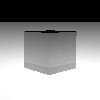

array([[12.195543,  0.      ]], dtype=float32)

''

''

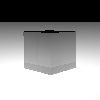

array([[12.196433,  0.      ]], dtype=float32)

''

''

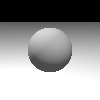

array([[ 0.      , 14.129049]], dtype=float32)

''

''

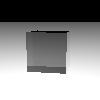

array([[11.413445  ,  0.10401251]], dtype=float32)

''

''

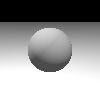

array([[ 0.      , 14.253284]], dtype=float32)

''

''

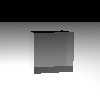

array([[11.422387,  0.311569]], dtype=float32)

''

''

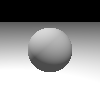

array([[ 0.      , 14.161685]], dtype=float32)

''

''

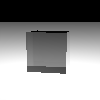

array([[11.344884  ,  0.45436993]], dtype=float32)

''

''

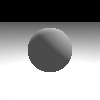

array([[ 1.2978878, 12.886148 ]], dtype=float32)

''

''

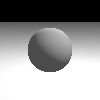

array([[ 0.26763517, 13.947994  ]], dtype=float32)

''

''

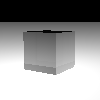

array([[12.222551,  0.      ]], dtype=float32)

''

''

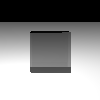

array([[11.379769,  0.340608]], dtype=float32)

''

''

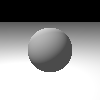

array([[ 0.26371205, 13.936985  ]], dtype=float32)

''

''

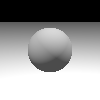

array([[ 0.      , 14.371538]], dtype=float32)

''

''

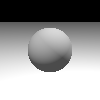

array([[ 0.      , 14.199422]], dtype=float32)

''

''

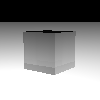

array([[12.138838,  0.      ]], dtype=float32)

''

''

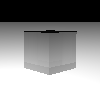

array([[12.130784,  0.      ]], dtype=float32)

''

''

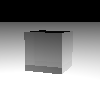

array([[11.919685,  0.      ]], dtype=float32)

''

''

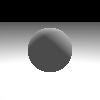

array([[ 1.8161607, 12.318442 ]], dtype=float32)

''

''

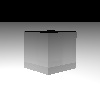

array([[12.130731,  0.      ]], dtype=float32)

''

''

In [59]:
with torch.no_grad():
    for t in range(20):
        pic = (pt_test_ds[t].transpose(0, 2).cpu().numpy() + 0.5)*255
        int_pic = pic.astype(np.uint8).repeat(3, axis=2)
        display(Image.fromarray(int_pic), m(pt_test_ds[t:t+1]).cpu().detach().numpy(), '', '')  # 